In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import cm
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from numpy import linalg as la
from numpy import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from solver_sdmd_torch_gpu import KoopmanNNTorch, KoopmanSolverTorch

from numpy import random as rrr
from time import time
from koopman_bandit import KoopmanBandit
import joblib
from collections import namedtuple, deque
import math
import random as rnd
from scipy import stats

In [2]:
print (torch.__version__, torch.cuda.is_available())
print(torch.version.cuda)
print (torch.cuda.get_device_name())
#device= 'cpu'
device= 'cuda'

2.2.2 True
11.8
NVIDIA RTX 6000 Ada Generation


In [3]:
## Choose a system (this is just for name)
system = 'duffing' 
# system = 'double_well'

In [4]:
# reward_hist= joblib.load (f'dqn_history32x32_12000steps_example_{system}_final.jbl')
# os.makedirs(f'figures_dqn_{system}', exist_ok=True)

In [5]:
# #define the domain of the dynamical system
# x_min= -3
# x_max= 3
# y_min = -4
# y_max= 4

# from double_well_potential_2d import potential, simulate_trajectory

# """
# Main script for plotting and trajectory generation.
# Imports potential and simulate_trajectory from double_well.py.
# """

# # Plot the potential landscape
# x_plot = np.linspace(-2, 2, 100)
# y_plot = np.linspace(-3, 3, 100)
# XX, YY = np.meshgrid(x_plot, y_plot)
# ZZ = potential(XX, YY)

# plt.figure(figsize=(6, 4))
# plt.contourf(XX, YY, ZZ, levels=20, cmap='coolwarm')
# plt.colorbar(label='Potential')
# plt.title('2D Double Well Potential Landscape')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.show()

# # Generate a single SDE trajectory

# def get_single_trajectory(x0, y0, T):
#     """
#     Produce SDE trajectory starting at (x0, y0) over T steps.
#     This function delegates the simulation to double_well.simulate_trajectory.
#     """
#     return simulate_trajectory(x0, y0, T)

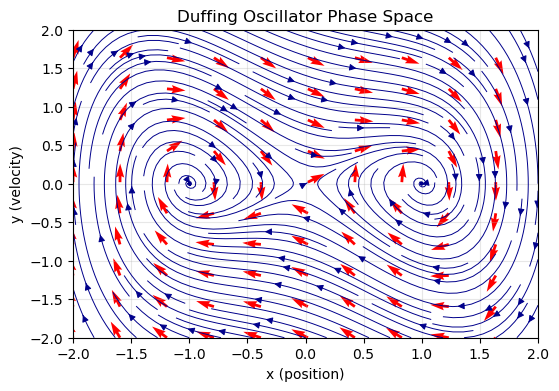

In [6]:
from duffing_system_2d import simulate_trajectory

"""
Main script for Duffing oscillator system simulation
"""

# Set parameters for the Duffing oscillator
delta = 0.5
alpha = -1
beta = 1
gamma = 0
omega = 0
sigma = 0.1

# Create a grid of points for phase space visualization
x_plot = np.linspace(-2, 2, 100)
y_plot = np.linspace(-2, 2, 100)
XX, YY = np.meshgrid(x_plot, y_plot)

# Calculate vector field for phase space plot
U = YY  # dx/dt = y
V = -delta*YY - alpha*XX - beta*(XX**3) + gamma*np.cos(omega*0)  # dy/dt at t=0

# Normalize the arrows
magnitude = np.sqrt(U**2 + V**2)
U_norm = U / magnitude
V_norm = V / magnitude

# Plot the phase space
plt.figure(figsize=(6, 4))
plt.streamplot(XX, YY, U, V, density=1.5, color='darkblue', linewidth=0.7)
plt.quiver(XX[::10, ::10], YY[::10, ::10], U_norm[::10, ::10], V_norm[::10, ::10], 
           color='red', scale=25)
plt.title('Duffing Oscillator Phase Space')
plt.xlabel('x (position)')
plt.ylabel('y (velocity)')
plt.grid(alpha=0.3)
plt.show()

def get_single_trajectory(x0, y0, T):
    """
    Produce SDE trajectory starting at (x0, y0) over T steps.
    This function delegates the simulation to duffing_system_2d.simulate_trajectory.
    
    Args:
        x0: Initial x-coordinate (position)
        y0: Initial y-coordinate (velocity)
        T: Total simulation time steps
        
    Returns:
        Tuple of (data_matrix_single, lag_time)
    """
    return simulate_trajectory(x0, y0, T, delta=delta, alpha=alpha, beta=beta, gamma=gamma, omega=omega)

In [7]:
def koopman_reward_func (action, k_grid= 4):
    action_x= action//k_grid
    action_y= action%k_grid
    x_borders= linspace (-3,3, k_grid+1)
    y_borders= linspace (-4,4, k_grid+1)
    x_lo= x_borders[action_x]
    x_hi= x_borders[action_x+1]
    y_lo= y_borders[action_y]
    y_hi= y_borders[action_y+1]
    x0_single= rrr.uniform (x_lo, x_hi)
    y0_single= rrr.uniform (y_lo, y_hi)
    
    T= 1000 # 1000
    
    data_matrix_single, lag_time= get_single_trajectory (x0_single, y0_single, T)
    # Extract data_X and data_Y from the data matrix
    data_X = data_matrix_single[:, :-1, :]
    data_Y = data_matrix_single[:, 1:, :]
    print(f"Shape of data_X: {data_X.shape}")
    print(f"Shape of data_Y: {data_Y.shape}")
    
    # Reshape data_X and data_Y into a single column
    X = data_X.reshape(-1, data_X.shape[2])  # 2D features
    Y = data_Y.reshape(-1, data_X.shape[2])  # 2D targets
    print(f"Shape of X: {X.shape}")
    print(f"Shape of Y: {Y.shape}")
    
    # Separate data into two parts: train and validation
    len_all = X.shape[0]
    data_x_train = X[:int(0.7*len_all)]
    data_x_valid = X[int(0.7*len_all)+1:]
    
    data_y_train = Y[:int(0.7*len_all)]
    data_y_valid = Y[int(0.7*len_all)+1:]
    
    data_train = [data_x_train, data_y_train]
    data_valid = [data_x_valid, data_y_valid]
    
    print(data_x_train.shape)
    
    checkpoint_file= f'example_{system}_dqn_ckpt.torch'
    basis_function = KoopmanNNTorch(input_size= 2, layer_sizes=[10], n_psi_train=10).to(device)  # basis number would be 20
    
    
    solver = KoopmanSolverTorch(dic=basis_function, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                           target_dim=np.shape(data_x_train)[-1],
                                                       reg=0.1,  checkpoint_file= checkpoint_file, fnn_checkpoint_file= f'example_{system}_fnn_dqn.torch', 
                                a_b_file= f'sde_coefficients_example_{system}_dqn.jbl', 
                            generator_batch_size= 2, fnn_batch_size= 32, delta_t= lag_time)
    solver.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=4,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )
    consistency= 0
    for ii in arange (len (solver.eigenvalues)):
        phi_x= solver.eigenfunctions (X)[ii]
        phi_y=  solver.eigenfunctions (Y)[ii]
        lmbd=  solver.eigenvalues[ii]
        consistency= consistency + la.norm (phi_y- lmbd*phi_x)**2
    print (consistency)
    
    return 16-consistency

def get_ee_reward (trajectory,next_initial_point):
    ee_epsilon= 0.1
    kernel = stats.gaussian_kde(trajectory.squeeze().T)
    mean_kernel= np.mean (kernel(trajectory.squeeze().T))
    normalized_p= kernel (next_initial_point)/mean_kernel
    ee_reward= 1.0/(normalized_p + ee_epsilon)
    return ee_reward

def do_koopman_step (state, action, k_grid= 4, state_len= 10, chunk_len= 100):
    chunk_list= []
    T= chunk_len
    action_x= action//k_grid
    action_y= action%k_grid
    for ii in arange(state_len-1):
        
        x0_single= state[0, ii]
        y0_single=  state[1, ii]
   
        data_matrix_single, lag_time= get_single_trajectory (x0_single, y0_single, T)
        chunk_list.append (data_matrix_single)
    x_borders= linspace (-3,3, k_grid+1)
    y_borders= linspace (-4,4, k_grid+1)
    x_lo= x_borders[action_x]
    x_hi= x_borders[action_x+1]
    y_lo= y_borders[action_y]
    y_hi= y_borders[action_y+1]
    x0_single= rrr.uniform (x_lo, x_hi)
    y0_single= rrr.uniform (y_lo, y_hi)
    data_matrix_single, lag_time= get_single_trajectory (x0_single, y0_single, T)
    trajectory= hstack (chunk_list)
    chunk_list.append (data_matrix_single)
    data_matrix_single= hstack (chunk_list)
    ee_reward= get_ee_reward (trajectory, [x0_single, y0_single])
    #print ('EE reward:' , ee_reward)
    #Extract data_X and data_Y from the data matrix
    data_X = data_matrix_single[:, :-1, :]
    data_Y = data_matrix_single[:, 1:, :]
    print(f"Shape of data_X: {data_X.shape}")
    print(f"Shape of data_Y: {data_Y.shape}")
    
    # Reshape data_X and data_Y into a single column
    X = data_X.reshape(-1, data_X.shape[2])  # 2D features
    Y = data_Y.reshape(-1, data_X.shape[2])  # 2D targets
    print(f"Shape of X: {X.shape}")
    print(f"Shape of Y: {Y.shape}")
    
    # Separate data into two parts: train and validation
    len_all = X.shape[0]
    data_x_train = X[:int(0.7*len_all)]
    data_x_valid = X[int(0.7*len_all)+1:]
    
    data_y_train = Y[:int(0.7*len_all)]
    data_y_valid = Y[int(0.7*len_all)+1:]
    
    data_train = [data_x_train, data_y_train]
    data_valid = [data_x_valid, data_y_valid]
    
    print(data_x_train.shape)
    
    checkpoint_file= f'example_{system}_dqn_ckpt3.torch'
    basis_function = KoopmanNNTorch(input_size= 2, layer_sizes=[10], n_psi_train=10).to(device)  # basis number would be 20
    
    
    solver = KoopmanSolverTorch(dic=basis_function, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                           target_dim=np.shape(data_x_train)[-1],
                                                       reg=0.1,  checkpoint_file= checkpoint_file, fnn_checkpoint_file= f'example_{system}_fnn_dqn1.torch', 
                                a_b_file= f'sde_coefficients_example_{system}_dqn1.jbl', 
                            generator_batch_size= 2, fnn_batch_size= 32, delta_t= lag_time)
    solver.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=4,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )
    consistency= 0
    for ii in arange (len (solver.eigenvalues)):
        phi_x= solver.eigenfunctions (X)[ii]
        phi_y=  solver.eigenfunctions (Y)[ii]
        lmbd=  solver.eigenvalues[ii]
        consistency= consistency + la.norm (phi_y- lmbd*phi_x)**2
    print (consistency)
    reward= 16- consistency+  0.15*ee_reward
    next_state= hstack ([state[:, 1:], expand_dims (array ([x0_single, y0_single]), axis= 1)])
    return next_state, reward
        
    



Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return rnd.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [8]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [9]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
batch_size= 64
gamma = 0.99
eps_start = 0.9
eps_end = 0.2
eps_decay = 2000
tau = 0.05
lr = 1e-4

k_grid= 32
state_len= 12
chunk_len= 100


In [10]:
n_actions = k_grid**2
# Get the number of state observations

n_observations = state_len*2

In [11]:
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=lr, amsgrad=True)
memory = ReplayMemory(20000)


steps_done = 0

In [12]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = eps_end + (eps_start - eps_end) * \
        math.exp(-1. * steps_done / eps_decay)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            state_tensor= torch.tensor(state.ravel(), dtype=torch.float64, device=device).unsqueeze(0)
            #state_tensor= torch.tensor (state.ravel(), dtype=torch.float64).to (device)
            return policy_net(state_tensor).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[np.random.choice(arange(n_actions))]], device=device, dtype=torch.long)

In [13]:
def optimize_model():
    if len(memory) < batch_size:
        return
    transitions = memory.sample(batch_size)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [14]:
#Below, you can find the main training loop. At the beginning we reset the environment and obtain the initial state Tensor. Then, we sample an action, execute it, observe the next state and the reward (always 1), and optimize our model once. When the episode ends (our model fails), we restart the loop.

#Below, num_episodes is set to 600 if a GPU is available, otherwise 50 episodes are scheduled so training does not take too long. However, 50 episodes is insufficient for to observe good performance on CartPole. You should see the model constantly achieve 500 steps within 600 training episodes. Training RL agents can be a noisy process, so restarting training can produce better results if convergence is not observed.

In [15]:
# num_episodes= 1
# reward_hist= []
# num_steps= 12000 # 15000
# for i_episode in range(num_episodes):
#     # Initialize the environment and get its state
#     initial_state= 2*(np.random.uniform(size=(2,state_len))-1)
#     state= initial_state
#     for t in arange(num_steps):
#         initial_state= 2*(np.random.uniform(size=(2,state_len))-1)
#         action_tensor = select_action(state)
#         action= action_tensor.detach().cpu().numpy()
#         observation, reward= do_koopman_step (state, int (action.squeeze()), k_grid= k_grid)
#         reward_tensor = torch.tensor([reward], device=device)
#         #done = terminated or truncated

#         state_tensor= torch.tensor(state.ravel(), dtype=torch.float64, device=device).unsqueeze(0)
#         next_state = observation #torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
#         next_state_tensor= torch.tensor(observation.ravel(), dtype=torch.float64, device=device).unsqueeze(0)
#         # Store the transition in memory
#         memory.push(state_tensor, action_tensor, next_state_tensor, reward_tensor)
#         reward_hist.append ([state, action, next_state, reward])
#         # Move to the next state
#         state = next_state

#         # Perform one step of the optimization (on the policy network)
#         optimize_model()

#         # Soft update of the target network's weights
#         # θ′ ← τ θ + (1 −τ )θ′
#         target_net_state_dict = target_net.state_dict()
#         policy_net_state_dict = policy_net.state_dict()
#         for key in policy_net_state_dict:
#             target_net_state_dict[key] = policy_net_state_dict[key]*tau + target_net_state_dict[key]*(1-tau)
#         target_net.load_state_dict(target_net_state_dict)
        
#         # Write detailed status to file
#         with open(f'dqn_state_{system}.txt', 'w') as f:
#             f.write(f"System: {system}\n")
#             f.write(f"Current RL step: {int(t)}/{num_steps} ({(t/num_steps)*100:.1f}%)\n")
#             f.write(f"Elapsed time: {format_time(elapsed_time)}\n")
#             f.write(f"Estimated time remaining: {format_time(estimated_time_remaining)}\n")
            
#         if (t%100==0):
            
#             # joblib.dump (reward_hist, 'dqn_history64x64_example.jbl')
#             if (t % 100 == 0):
#                 joblib.dump(
#                     reward_hist,
#                     f'dqn_history{k_grid}x{k_grid}_{num_steps}steps_example_{system}.jbl'
#                 )


# print('Complete')

In [16]:
import time

# Start timing the execution
start_time = time.time()

num_episodes = 1
reward_hist = []
num_steps = 12000  # 15000

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    initial_state = 2 * (np.random.uniform(size=(2, state_len)) - 1)
    state = initial_state
    
    for t in range(num_steps):
        # Record current time for time estimation
        current_time = time.time()
        elapsed_time = current_time - start_time
        
        # Calculate estimated time remaining
        if t > 0:
            avg_time_per_step = elapsed_time / t
            remaining_steps = num_steps - t
            estimated_time_remaining = avg_time_per_step * remaining_steps
        else:
            estimated_time_remaining = 0
        
        initial_state = 2 * (np.random.uniform(size=(2, state_len)) - 1)
        action_tensor = select_action(state)
        action = action_tensor.detach().cpu().numpy()
        observation, reward = do_koopman_step(state, int(action.squeeze()), k_grid=k_grid)
        reward_tensor = torch.tensor([reward], device=device)
        
        state_tensor = torch.tensor(state.ravel(), dtype=torch.float64, device=device).unsqueeze(0)
        next_state = observation
        next_state_tensor = torch.tensor(observation.ravel(), dtype=torch.float64, device=device).unsqueeze(0)
        
        # Store the transition in memory
        memory.push(state_tensor, action_tensor, next_state_tensor, reward_tensor)
        reward_hist.append([state, action, next_state, reward])
        
        # Move to the next state
        state = next_state
        
        # Perform one step of the optimization (on the policy network)
        optimize_model()
        
        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * tau + target_net_state_dict[key] * (1 - tau)
        target_net.load_state_dict(target_net_state_dict)
        
        # Format time strings for better readability
        def format_time(seconds):
            hours = int(seconds // 3600)
            minutes = int((seconds % 3600) // 60)
            seconds = int(seconds % 60)
            return f"{hours:02d}h:{minutes:02d}m:{seconds:02d}s"
        
        # Write detailed status to file
        with open(f'dqn_state_{system}.txt', 'w') as f:
            f.write(f"System: {system}\n")
            f.write(f"Current RL step: {int(t)}/{num_steps} ({(t/num_steps)*100:.1f}%)\n")
            f.write(f"Elapsed time: {format_time(elapsed_time)}\n")
            f.write(f"Estimated time remaining: {format_time(estimated_time_remaining)}\n")
        
        # Periodically save results
        if (t % 100 == 0):
            joblib.dump(
                reward_hist,
                f'dqn_history{k_grid}x{k_grid}_{num_steps}steps_example_{system}.jbl'
            )
            print(f"Step {t}/{num_steps} completed. System: {system}. Elapsed: {format_time(elapsed_time)}")

# Record total execution time
total_time = time.time() - start_time
print(f'Complete! Total execution time: {format_time(total_time)}')

Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 836.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 895.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2904.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2943.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2793.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2935.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2919.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2929.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2915.86it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.490118 val loss: 5.013918
saving, val loss enhanced: 5.0139182298666185 10000
Epoch: 2 	Training Loss: 4.429295 val loss: 4.978151
saving, val loss enhanced: 4.9781506528118245 5.0139182298666185
Epoch: 3 	Training Loss: 4.377285 val loss: 4.882791
saving, val loss enhanced: 4.882791119347404 4.9781506528118245
Epoch: 4 	Training Loss: 4.360646 val loss: 4.853291
saving, val loss enhanced: 4.853291428158702 4.882791119347404
Epoch: 5 	Training Loss: 4.315199 val loss: 4.786450
saving, val loss enhanced: 4.7864504757141155 4.853291428158702
Epoch: 6 	Training Loss: 4.263667 val loss: 4.749010
saving, val loss enhanced: 4.7490096896545655 4.7864504757141155
Epoch: 7 	Training Loss: 4.180170 val loss: 4.640156
saving, val loss enhanced: 4.640156159345208 4.7490096896545655
Epoch: 8 	Training Loss: 4.179858 val loss: 4.605651
saving, val loss enhanced:

/tmp/ipykernel_248211/1737056544.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403388920/work/torch/csrc/utils/tensor_new.cpp:275.)
  reward_tensor = torch.tensor([reward], device=device)


Step 0/12000 completed. System: duffing. Elapsed: 00h:00m:00s
Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2892.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2905.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2453.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2916.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2711.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 698.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 490.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2937.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2939.21it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 0.528454 val loss: 0.512769
saving, val loss enhanced: 0.5127692865489248 10000
Epoch: 2 	Training Loss: 0.520911 val loss: 0.501507
saving, val loss enhanced: 0.5015065177856434 0.5127692865489248
Epoch: 3 	Training Loss: 0.517037 val loss: 0.502676
Epoch: 4 	Training Loss: 0.508818 val loss: 0.493569
saving, val loss enhanced: 0.49356928581750237 0.5015065177856434
Epoch: 5 	Training Loss: 0.505206 val loss: 0.495843
Epoch: 6 	Training Loss: 0.502298 val loss: 0.494111
Epoch: 7 	Training Loss: 0.493180 val loss: 0.489595
saving, val loss enhanced: 0.48959513687840495 0.49356928581750237
Epoch: 8 	Training Loss: 0.492238 val loss: 0.483002
saving, val loss enhanced: 0.48300236512890965 0.48959513687840495
Epoch: 9 	Training Loss: 0.489162 val loss: 0.477639
saving, val loss enhanced: 0.47763945980277156 0.48300236512890965
Epoch: 10 	Training Loss: 

100%|██████████| 101/101 [00:00<00:00, 2983.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2569.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2878.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2916.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2939.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2923.71it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.077385 val loss: 0.872738
saving, val loss enhanced: 0.8727381459132028 10000
Epoch: 2 	Training Loss: 1.053503 val loss: 0.852335
saving, val loss enhanced: 0.8523349420677916 0.8727381459132028
Epoch: 3 	Training Loss: 1.041869 val loss: 0.847431
saving, val loss enhanced: 0.8474314414528313 0.8523349420677916
Epoch: 4 	Training Loss: 1.036561 val loss: 0.834119
saving, val loss enhanced: 0.8341192833454426 0.8474314414528313
Epoch: 5 	Training Loss: 1.019604 val loss: 0.825579
saving, val loss enhanced: 0.8255789709922312 0.8341192833454426
Epoch: 6 	Training Loss: 1.012379 val loss: 0.819298
saving, val loss enhanced: 0.8192976833465453 0.8255789709922312
Epoch: 7 	Training Loss: 0.985951 val loss: 0.813682
saving, val loss enhanced: 0.8136819674934037 0.8192976833465453
Epoch: 8 	Training Loss: 0.987023 val loss: 0.797213
saving, val loss enha

100%|██████████| 101/101 [00:00<00:00, 2995.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.76it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 0.627969 val loss: 0.718338
saving, val loss enhanced: 0.7183383243586914 10000
Epoch: 2 	Training Loss: 0.618480 val loss: 0.699088
saving, val loss enhanced: 0.6990875491651392 0.7183383243586914
Epoch: 3 	Training Loss: 0.602187 val loss: 0.700389
Epoch: 4 	Training Loss: 0.591264 val loss: 0.673953
saving, val loss enhanced: 0.6739528899161904 0.6990875491651392
Epoch: 5 	Training Loss: 0.580182 val loss: 0.681629
Epoch: 6 	Training Loss: 0.575927 val loss: 0.658737
saving, val loss enhanced: 0.6587366176552221 0.6739528899161904
Epoch: 7 	Training Loss: 0.571203 val loss: 0.659587
Epoch: 8 	Training Loss: 0.562739 val loss: 0.638301
saving, val loss enhanced: 0.6383013430037666 0.6587366176552221
Epoch: 9 	Training Loss: 0.551461 val loss: 0.632143
saving, val loss enhanced: 0.6321434638796208 0.6383013430037666
Epoch: 10 	Training Loss: 0.54301

100%|██████████| 101/101 [00:00<00:00, 2869.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2562.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2558.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2677.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2786.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.96it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 0.719019 val loss: 0.677985
saving, val loss enhanced: 0.6779850369791255 10000
Epoch: 2 	Training Loss: 0.719672 val loss: 0.672309
saving, val loss enhanced: 0.6723093128775709 0.6779850369791255
Epoch: 3 	Training Loss: 0.709462 val loss: 0.666715
saving, val loss enhanced: 0.6667147672937769 0.6723093128775709
Epoch: 4 	Training Loss: 0.702734 val loss: 0.661378
saving, val loss enhanced: 0.6613782195698221 0.6667147672937769
Epoch: 5 	Training Loss: 0.703078 val loss: 0.658923
saving, val loss enhanced: 0.6589228612051946 0.6613782195698221
Epoch: 6 	Training Loss: 0.693947 val loss: 0.649926
saving, val loss enhanced: 0.6499255412761658 0.6589228612051946
Epoch: 7 	Training Loss: 0.689624 val loss: 0.648424
saving, val loss enhanced: 0.6484243727632004 0.6499255412761658
Epoch: 8 	Training Loss: 0.683570 val loss: 0.638723
saving, val loss enha

100%|██████████| 101/101 [00:00<00:00, 2780.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2919.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2548.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2891.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2588.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2565.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2828.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.16it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.701852 val loss: 1.664983
saving, val loss enhanced: 1.6649833797025397 10000
Epoch: 2 	Training Loss: 1.685707 val loss: 1.615600
saving, val loss enhanced: 1.615599565964083 1.6649833797025397
Epoch: 3 	Training Loss: 1.656806 val loss: 1.613585
saving, val loss enhanced: 1.6135847933810614 1.615599565964083
Epoch: 4 	Training Loss: 1.639445 val loss: 1.585559
saving, val loss enhanced: 1.5855586255072474 1.6135847933810614
Epoch: 5 	Training Loss: 1.621477 val loss: 1.558655
saving, val loss enhanced: 1.5586545366417486 1.5855586255072474
Epoch: 6 	Training Loss: 1.590942 val loss: 1.545656
saving, val loss enhanced: 1.545656441088442 1.5586545366417486
Epoch: 7 	Training Loss: 1.578360 val loss: 1.519124
saving, val loss enhanced: 1.5191241815561878 1.545656441088442
Epoch: 8 	Training Loss: 1.549470 val loss: 1.507274
saving, val loss enhanced

100%|██████████| 101/101 [00:00<00:00, 2941.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 542.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.02it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.022771 val loss: 2.286666
saving, val loss enhanced: 2.2866662253356846 10000
Epoch: 2 	Training Loss: 2.019669 val loss: 2.275131
saving, val loss enhanced: 2.2751310359537262 2.2866662253356846
Epoch: 3 	Training Loss: 1.990749 val loss: 2.231037
saving, val loss enhanced: 2.231036991138333 2.2751310359537262
Epoch: 4 	Training Loss: 1.976932 val loss: 2.230260
saving, val loss enhanced: 2.2302596622998885 2.231036991138333
Epoch: 5 	Training Loss: 1.965019 val loss: 2.246869
Epoch: 6 	Training Loss: 1.948149 val loss: 2.209839
saving, val loss enhanced: 2.2098385243843333 2.2302596622998885
Epoch: 7 	Training Loss: 1.924245 val loss: 2.179553
saving, val loss enhanced: 2.179552525650781 2.2098385243843333
Epoch: 8 	Training Loss: 1.914910 val loss: 2.155239
saving, val loss enhanced: 2.155239233188753 2.179552525650781
Epoch: 9 	Training Loss: 1

100%|██████████| 101/101 [00:00<00:00, 2899.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2566.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2817.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2665.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2966.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2602.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2896.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.91it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.743918 val loss: 1.648309
saving, val loss enhanced: 1.6483088237591816 10000
Epoch: 2 	Training Loss: 1.729823 val loss: 1.645296
saving, val loss enhanced: 1.6452963350369676 1.6483088237591816
Epoch: 3 	Training Loss: 1.734026 val loss: 1.626430
saving, val loss enhanced: 1.6264297084723285 1.6452963350369676
Epoch: 4 	Training Loss: 1.728913 val loss: 1.616814
saving, val loss enhanced: 1.616814414670637 1.6264297084723285
Epoch: 5 	Training Loss: 1.708266 val loss: 1.618371
Epoch: 6 	Training Loss: 1.707100 val loss: 1.597427
saving, val loss enhanced: 1.5974270652924647 1.616814414670637
Epoch: 7 	Training Loss: 1.691261 val loss: 1.587851
saving, val loss enhanced: 1.5878513012656703 1.5974270652924647
Epoch: 8 	Training Loss: 1.693824 val loss: 1.594936
Epoch: 9 	Training Loss: 1.672286 val loss: 1.568726
saving, val loss enhanced: 1.568725

100%|██████████| 101/101 [00:00<00:00, 2819.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2943.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2538.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2517.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2744.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2775.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.12it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.821736 val loss: 2.872056
saving, val loss enhanced: 2.872056490592155 10000
Epoch: 2 	Training Loss: 2.786978 val loss: 2.858948
saving, val loss enhanced: 2.858947965946286 2.872056490592155
Epoch: 3 	Training Loss: 2.769786 val loss: 2.819063
saving, val loss enhanced: 2.8190633357381745 2.858947965946286
Epoch: 4 	Training Loss: 2.759905 val loss: 2.801722
saving, val loss enhanced: 2.80172173084398 2.8190633357381745
Epoch: 5 	Training Loss: 2.744962 val loss: 2.803240
Epoch: 6 	Training Loss: 2.726192 val loss: 2.778150
saving, val loss enhanced: 2.778150401579071 2.80172173084398
Epoch: 7 	Training Loss: 2.702669 val loss: 2.763916
saving, val loss enhanced: 2.763915534809481 2.778150401579071
Epoch: 8 	Training Loss: 2.678425 val loss: 2.737057
saving, val loss enhanced: 2.737056655253319 2.763915534809481
Epoch: 9 	Training Loss: 2.674115 

100%|██████████| 101/101 [00:00<00:00, 2978.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2963.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.97it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 8.573923 val loss: 9.120134
saving, val loss enhanced: 9.120134464990429 10000
Epoch: 2 	Training Loss: 8.482343 val loss: 9.053341
saving, val loss enhanced: 9.053340560875693 9.120134464990429
Epoch: 3 	Training Loss: 8.437780 val loss: 8.985902
saving, val loss enhanced: 8.985901885023276 9.053340560875693
Epoch: 4 	Training Loss: 8.415220 val loss: 8.919636
saving, val loss enhanced: 8.919636488884025 8.985901885023276
Epoch: 5 	Training Loss: 8.282878 val loss: 8.344489
saving, val loss enhanced: 8.344489144050067 8.919636488884025
Epoch: 6 	Training Loss: 8.278799 val loss: 8.785483
Epoch: 7 	Training Loss: 8.181317 val loss: 8.715490
Epoch: 8 	Training Loss: 8.154065 val loss: 8.557170
Epoch: 9 	Training Loss: 7.963059 val loss: 8.472154
Epoch: 10 	Training Loss: 7.986226 val loss: 8.529324
Epoch: 11 	Training Loss: 7.933276 val loss: 8.383264

100%|██████████| 101/101 [00:00<00:00, 2982.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2878.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2658.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 823.91it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.596485 val loss: 2.806135
saving, val loss enhanced: 2.806135059574171 10000
Epoch: 2 	Training Loss: 2.563106 val loss: 2.794689
saving, val loss enhanced: 2.7946889442801623 2.806135059574171
Epoch: 3 	Training Loss: 2.543309 val loss: 2.771241
saving, val loss enhanced: 2.7712408882306323 2.7946889442801623
Epoch: 4 	Training Loss: 2.523109 val loss: 2.752690
saving, val loss enhanced: 2.7526902345326123 2.7712408882306323
Epoch: 5 	Training Loss: 2.499307 val loss: 2.732213
saving, val loss enhanced: 2.732212622185057 2.7526902345326123
Epoch: 6 	Training Loss: 2.493079 val loss: 2.707868
saving, val loss enhanced: 2.707867663485379 2.732212622185057
Epoch: 7 	Training Loss: 2.469251 val loss: 2.701215
saving, val loss enhanced: 2.701214646899524 2.707867663485379
Epoch: 8 	Training Loss: 2.459264 val loss: 2.646129
saving, val loss enhanced: 2

100%|██████████| 101/101 [00:00<00:00, 2968.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2906.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2938.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2923.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2944.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.91it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.853597 val loss: 2.758978
saving, val loss enhanced: 2.758978078027621 10000
Epoch: 2 	Training Loss: 2.832060 val loss: 2.743740
saving, val loss enhanced: 2.7437395421851494 2.758978078027621
Epoch: 3 	Training Loss: 2.801953 val loss: 2.726346
saving, val loss enhanced: 2.726345783052697 2.7437395421851494
Epoch: 4 	Training Loss: 2.808787 val loss: 2.709993
saving, val loss enhanced: 2.7099929543813253 2.726345783052697
Epoch: 5 	Training Loss: 2.795064 val loss: 2.708645
saving, val loss enhanced: 2.7086451896522816 2.7099929543813253
Epoch: 6 	Training Loss: 2.784162 val loss: 2.692740
saving, val loss enhanced: 2.69274042144666 2.7086451896522816
Epoch: 7 	Training Loss: 2.759314 val loss: 2.686942
saving, val loss enhanced: 2.6869423527378578 2.69274042144666
Epoch: 8 	Training Loss: 2.724342 val loss: 2.657562
saving, val loss enhanced: 2.

100%|██████████| 101/101 [00:00<00:00, 2984.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2526.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2556.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2951.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 554.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2500.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.60it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.859327 val loss: 3.131399
saving, val loss enhanced: 3.131398939146916 10000
Epoch: 2 	Training Loss: 2.848002 val loss: 3.144537
Epoch: 3 	Training Loss: 2.834081 val loss: 3.100595
saving, val loss enhanced: 3.1005946423467354 3.131398939146916
Epoch: 4 	Training Loss: 2.827770 val loss: 3.095900
saving, val loss enhanced: 3.0959001648116247 3.1005946423467354
Epoch: 5 	Training Loss: 2.809379 val loss: 3.057388
saving, val loss enhanced: 3.057387605854479 3.0959001648116247
Epoch: 6 	Training Loss: 2.808073 val loss: 3.067106
Epoch: 7 	Training Loss: 2.781045 val loss: 3.053994
saving, val loss enhanced: 3.053993699851544 3.057387605854479
Epoch: 8 	Training Loss: 2.783889 val loss: 3.012066
saving, val loss enhanced: 3.012065632344492 3.053993699851544
Epoch: 9 	Training Loss: 2.779200 val loss: 3.013806
Epoch: 10 	Training Loss: 2.757207 val l

100%|██████████| 101/101 [00:00<00:00, 2977.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1418.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 914.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 884.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2707.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2715.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2963.20it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.196564 val loss: 3.047946
saving, val loss enhanced: 3.0479459542193847 10000
Epoch: 2 	Training Loss: 3.165073 val loss: 2.988987
saving, val loss enhanced: 2.988986806798292 3.0479459542193847
Epoch: 3 	Training Loss: 3.124378 val loss: 2.998672
Epoch: 4 	Training Loss: 3.099408 val loss: 2.972238
saving, val loss enhanced: 2.97223762602167 2.988986806798292
Epoch: 5 	Training Loss: 3.083500 val loss: 2.954944
saving, val loss enhanced: 2.9549436041040695 2.97223762602167
Epoch: 6 	Training Loss: 3.067696 val loss: 2.910801
saving, val loss enhanced: 2.9108011108875465 2.9549436041040695
Epoch: 7 	Training Loss: 3.022369 val loss: 2.893449
saving, val loss enhanced: 2.8934493373477843 2.9108011108875465
Epoch: 8 	Training Loss: 3.005337 val loss: 2.853231
saving, val loss enhanced: 2.8532311559921966 2.8934493373477843
Epoch: 9 	Training Loss: 2.

100%|██████████| 101/101 [00:00<00:00, 2810.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2583.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2521.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 558.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2559.37it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.689801 val loss: 2.887836
saving, val loss enhanced: 2.8878355092095607 10000
Epoch: 2 	Training Loss: 2.671458 val loss: 2.859772
saving, val loss enhanced: 2.859772416004273 2.8878355092095607
Epoch: 3 	Training Loss: 2.651828 val loss: 2.833616
saving, val loss enhanced: 2.8336156391008047 2.859772416004273
Epoch: 4 	Training Loss: 2.639170 val loss: 2.847134
Epoch: 5 	Training Loss: 2.613380 val loss: 2.794160
saving, val loss enhanced: 2.79415957287595 2.8336156391008047
Epoch: 6 	Training Loss: 2.610753 val loss: 2.797125
Epoch: 7 	Training Loss: 2.574025 val loss: 2.769541
saving, val loss enhanced: 2.7695413314173805 2.79415957287595
Epoch: 8 	Training Loss: 2.562893 val loss: 2.780595
Epoch: 9 	Training Loss: 2.558209 val loss: 2.740475
saving, val loss enhanced: 2.7404750384731185 2.7695413314173805
Epoch: 10 	Training Loss: 2.530636 val 

100%|██████████| 101/101 [00:00<00:00, 2641.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2651.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 396.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3024.68it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.296639 val loss: 3.474153
saving, val loss enhanced: 3.47415261156938 10000
Epoch: 2 	Training Loss: 3.285047 val loss: 3.471794
saving, val loss enhanced: 3.4717937662188216 3.47415261156938
Epoch: 3 	Training Loss: 3.275392 val loss: 3.468474
saving, val loss enhanced: 3.4684743613424 3.4717937662188216
Epoch: 4 	Training Loss: 3.239771 val loss: 3.453499
saving, val loss enhanced: 3.4534986372700684 3.4684743613424
Epoch: 5 	Training Loss: 3.244308 val loss: 3.435177
saving, val loss enhanced: 3.435177403372545 3.4534986372700684
Epoch: 6 	Training Loss: 3.214915 val loss: 3.405716
saving, val loss enhanced: 3.405715579930125 3.435177403372545
Epoch: 7 	Training Loss: 3.219692 val loss: 3.383623
saving, val loss enhanced: 3.383623446335319 3.405715579930125
Epoch: 8 	Training Loss: 3.209576 val loss: 3.389746
Epoch: 9 	Training Loss: 3.192113 va

100%|██████████| 101/101 [00:00<00:00, 3009.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2584.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2697.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2825.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2561.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.76it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.557544 val loss: 3.315623
saving, val loss enhanced: 3.315622745046008 10000
Epoch: 2 	Training Loss: 3.542512 val loss: 3.353361
Epoch: 3 	Training Loss: 3.508470 val loss: 3.330860
Epoch: 4 	Training Loss: 3.492322 val loss: 3.309136
saving, val loss enhanced: 3.309136174546283 3.315622745046008
Epoch: 5 	Training Loss: 3.474097 val loss: 3.270045
saving, val loss enhanced: 3.270044848153952 3.309136174546283
Epoch: 6 	Training Loss: 3.456364 val loss: 3.267776
saving, val loss enhanced: 3.267776175961174 3.270044848153952
Epoch: 7 	Training Loss: 3.428649 val loss: 3.232363
saving, val loss enhanced: 3.232362860561573 3.267776175961174
Epoch: 8 	Training Loss: 3.420464 val loss: 3.228254
saving, val loss enhanced: 3.228254233112362 3.232362860561573
Epoch: 9 	Training Loss: 3.381924 val loss: 3.207400
saving, val loss enhanced: 3.207400482935727

100%|██████████| 101/101 [00:00<00:00, 2972.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2963.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2912.59it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.885171 val loss: 3.619030
saving, val loss enhanced: 3.6190304545074743 10000
Epoch: 2 	Training Loss: 3.840126 val loss: 3.555508
saving, val loss enhanced: 3.5555078658521095 3.6190304545074743
Epoch: 3 	Training Loss: 3.810940 val loss: 3.544899
saving, val loss enhanced: 3.5448986039831096 3.5555078658521095
Epoch: 4 	Training Loss: 3.791396 val loss: 3.558205
Epoch: 5 	Training Loss: 3.771010 val loss: 3.535307
saving, val loss enhanced: 3.535306740623662 3.5448986039831096
Epoch: 6 	Training Loss: 3.745484 val loss: 3.468284
saving, val loss enhanced: 3.4682838080666225 3.535306740623662
Epoch: 7 	Training Loss: 3.725525 val loss: 3.470345
Epoch: 8 	Training Loss: 3.703479 val loss: 3.464175
saving, val loss enhanced: 3.464174783543356 3.4682838080666225
Epoch: 9 	Training Loss: 3.672572 val loss: 3.459431
saving, val loss enhanced: 3.4594306

100%|██████████| 101/101 [00:00<00:00, 2960.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2969.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2955.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2867.56it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.538809 val loss: 5.579933
saving, val loss enhanced: 5.5799326769963224 10000
Epoch: 2 	Training Loss: 5.513776 val loss: 5.556526
saving, val loss enhanced: 5.556525622785777 5.5799326769963224
Epoch: 3 	Training Loss: 5.491804 val loss: 5.517205
saving, val loss enhanced: 5.517204661050514 5.556525622785777
Epoch: 4 	Training Loss: 5.366640 val loss: 5.441624
saving, val loss enhanced: 5.441624218239894 5.517204661050514
Epoch: 5 	Training Loss: 5.423837 val loss: 5.439845
saving, val loss enhanced: 5.4398447467909765 5.441624218239894
Epoch: 6 	Training Loss: 5.344258 val loss: 5.426008
saving, val loss enhanced: 5.4260083011192455 5.4398447467909765
Epoch: 7 	Training Loss: 5.355108 val loss: 5.368615
saving, val loss enhanced: 5.368614875636132 5.4260083011192455
Epoch: 8 	Training Loss: 5.329846 val loss: 5.343820
saving, val loss enhanced: 5

100%|██████████| 101/101 [00:00<00:00, 2955.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2931.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2848.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2900.35it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.710097 val loss: 2.680715
saving, val loss enhanced: 2.6807145652817783 10000
Epoch: 2 	Training Loss: 2.708850 val loss: 2.712976
Epoch: 3 	Training Loss: 2.682223 val loss: 2.651344
saving, val loss enhanced: 2.6513444950413723 2.6807145652817783
Epoch: 4 	Training Loss: 2.651671 val loss: 2.649425
saving, val loss enhanced: 2.6494245391694706 2.6513444950413723
Epoch: 5 	Training Loss: 2.648646 val loss: 2.648534
saving, val loss enhanced: 2.648533774966438 2.6494245391694706
Epoch: 6 	Training Loss: 2.629264 val loss: 2.628507
saving, val loss enhanced: 2.6285069242174774 2.648533774966438
Epoch: 7 	Training Loss: 2.610534 val loss: 2.605332
saving, val loss enhanced: 2.6053323035391682 2.6285069242174774
Epoch: 8 	Training Loss: 2.603098 val loss: 2.590324
saving, val loss enhanced: 2.5903242478012185 2.6053323035391682
Epoch: 9 	Training Loss

100%|██████████| 101/101 [00:00<00:00, 2965.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2959.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2936.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2944.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2950.38it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1987.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 840.05it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 10.211382 val loss: 10.558123
saving, val loss enhanced: 10.558122590134653 10000
Epoch: 2 	Training Loss: 10.093966 val loss: 10.489538
saving, val loss enhanced: 10.489538371322638 10.558122590134653
Epoch: 3 	Training Loss: 9.974507 val loss: 10.414878
saving, val loss enhanced: 10.414877905625659 10.489538371322638
Epoch: 4 	Training Loss: 9.844366 val loss: 10.241166
saving, val loss enhanced: 10.241166342518078 10.414877905625659
Epoch: 5 	Training Loss: 9.798215 val loss: 10.209279
saving, val loss enhanced: 10.209279251207704 10.241166342518078
Epoch: 6 	Training Loss: 9.702196 val loss: 10.124718
saving, val loss enhanced: 10.124718117020546 10.209279251207704
Epoch: 7 	Training Loss: 9.585679 val loss: 10.015452
saving, val loss enhanced: 10.015451707657496 10.124718117020546
Epoch: 8 	Training Loss: 9.530687 val loss: 9.720094
saving, val 

100%|██████████| 101/101 [00:00<00:00, 2970.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2951.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2953.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2963.38it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.69it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.413461 val loss: 3.473611
saving, val loss enhanced: 3.473610855942463 10000
Epoch: 2 	Training Loss: 4.379164 val loss: 3.421209
saving, val loss enhanced: 3.421209194064076 3.473610855942463
Epoch: 3 	Training Loss: 4.357506 val loss: 3.407982
saving, val loss enhanced: 3.4079823879677282 3.421209194064076
Epoch: 4 	Training Loss: 4.341341 val loss: 3.408787
Epoch: 5 	Training Loss: 4.303627 val loss: 3.351682
saving, val loss enhanced: 3.3516816139182675 3.4079823879677282
Epoch: 6 	Training Loss: 4.272731 val loss: 3.323140
saving, val loss enhanced: 3.3231401999171855 3.3516816139182675
Epoch: 7 	Training Loss: 4.255457 val loss: 3.302260
saving, val loss enhanced: 3.302260060453165 3.3231401999171855
Epoch: 8 	Training Loss: 4.204099 val loss: 3.299898
saving, val loss enhanced: 3.299897726669095 3.302260060453165
Epoch: 9 	Training Loss: 4.1

100%|██████████| 101/101 [00:00<00:00, 2968.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2953.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2928.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2956.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2957.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2957.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2891.83it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 14.079902 val loss: 13.507188
saving, val loss enhanced: 13.507188236798003 10000
Epoch: 2 	Training Loss: 13.950013 val loss: 13.471174
saving, val loss enhanced: 13.471173808839955 13.507188236798003
Epoch: 3 	Training Loss: 13.836037 val loss: 13.111381
saving, val loss enhanced: 13.11138107868537 13.471173808839955
Epoch: 4 	Training Loss: 13.852580 val loss: 12.946686
saving, val loss enhanced: 12.94668646509023 13.11138107868537
Epoch: 5 	Training Loss: 13.634565 val loss: 13.129119
Epoch: 6 	Training Loss: 13.565040 val loss: 13.036703
Epoch: 7 	Training Loss: 13.524367 val loss: 12.775165
saving, val loss enhanced: 12.77516465605096 12.94668646509023
Epoch: 8 	Training Loss: 13.426662 val loss: 13.003938
Epoch: 9 	Training Loss: 13.230111 val loss: 12.715184
saving, val loss enhanced: 12.715184451295068 12.77516465605096
Epoch: 10 	Training L

100%|██████████| 101/101 [00:00<00:00, 2957.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2951.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.05it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.258447 val loss: 5.252673
saving, val loss enhanced: 5.252673166317706 10000
Epoch: 2 	Training Loss: 5.228029 val loss: 5.233380
saving, val loss enhanced: 5.233380160618942 5.252673166317706
Epoch: 3 	Training Loss: 5.227606 val loss: 5.208511
saving, val loss enhanced: 5.208511159583227 5.233380160618942
Epoch: 4 	Training Loss: 5.201617 val loss: 5.150162
saving, val loss enhanced: 5.150162010124872 5.208511159583227
Epoch: 5 	Training Loss: 5.181852 val loss: 5.154077
Epoch: 6 	Training Loss: 5.170340 val loss: 5.126647
saving, val loss enhanced: 5.126646627094358 5.150162010124872
Epoch: 7 	Training Loss: 5.132297 val loss: 5.125026
saving, val loss enhanced: 5.12502609472608 5.126646627094358
Epoch: 8 	Training Loss: 5.112673 val loss: 5.073394
saving, val loss enhanced: 5.073393847372793 5.12502609472608
Epoch: 9 	Training Loss: 5.096463 va

100%|██████████| 101/101 [00:00<00:00, 2979.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2935.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2947.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2925.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2933.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2942.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2938.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2931.88it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 7.994940 val loss: 7.471619
saving, val loss enhanced: 7.47161912865526 10000
Epoch: 2 	Training Loss: 7.900427 val loss: 7.346848
saving, val loss enhanced: 7.346848416829105 7.47161912865526
Epoch: 3 	Training Loss: 7.906348 val loss: 7.418601
Epoch: 4 	Training Loss: 7.807291 val loss: 7.300553
saving, val loss enhanced: 7.300552924783775 7.346848416829105
Epoch: 5 	Training Loss: 7.623355 val loss: 7.272586
saving, val loss enhanced: 7.272585974831663 7.300552924783775
Epoch: 6 	Training Loss: 7.568317 val loss: 7.111259
saving, val loss enhanced: 7.111258592657036 7.272585974831663
Epoch: 7 	Training Loss: 7.599381 val loss: 6.941127
saving, val loss enhanced: 6.941127128823446 7.111258592657036
Epoch: 8 	Training Loss: 7.413893 val loss: 7.040306
Epoch: 9 	Training Loss: 7.259230 val loss: 6.844178
saving, val loss enhanced: 6.844178147755548 6

100%|██████████| 101/101 [00:00<00:00, 899.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2736.79it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 8.250588 val loss: 8.638834
saving, val loss enhanced: 8.63883372729252 10000
Epoch: 2 	Training Loss: 8.211892 val loss: 8.534453
saving, val loss enhanced: 8.534452644591635 8.63883372729252
Epoch: 3 	Training Loss: 8.148496 val loss: 8.362249
saving, val loss enhanced: 8.362249406756574 8.534452644591635
Epoch: 4 	Training Loss: 8.012199 val loss: 8.297056
saving, val loss enhanced: 8.29705552116983 8.362249406756574
Epoch: 5 	Training Loss: 8.037485 val loss: 8.222374
saving, val loss enhanced: 8.22237375249208 8.29705552116983
Epoch: 6 	Training Loss: 7.908980 val loss: 8.140796
saving, val loss enhanced: 8.140795718140367 8.22237375249208
Epoch: 7 	Training Loss: 7.839812 val loss: 8.109830
saving, val loss enhanced: 8.109830163248473 8.140795718140367
Epoch: 8 	Training Loss: 7.799191 val loss: 7.859892
saving, val loss enhanced: 7.85989235100

100%|██████████| 101/101 [00:00<00:00, 777.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 880.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2913.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.43it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.773581 val loss: 5.279131
saving, val loss enhanced: 5.279130607488519 10000
Epoch: 2 	Training Loss: 5.742008 val loss: 5.291914
Epoch: 3 	Training Loss: 5.730216 val loss: 5.287936
Epoch: 4 	Training Loss: 5.650329 val loss: 5.255096
saving, val loss enhanced: 5.255096209208502 5.279130607488519
Epoch: 5 	Training Loss: 5.657836 val loss: 5.231022
saving, val loss enhanced: 5.231022263056944 5.255096209208502
Epoch: 6 	Training Loss: 5.620410 val loss: 5.170396
saving, val loss enhanced: 5.170396156279373 5.231022263056944
Epoch: 7 	Training Loss: 5.616035 val loss: 5.189405
Epoch: 8 	Training Loss: 5.569875 val loss: 5.185440
Epoch: 9 	Training Loss: 5.557355 val loss: 5.165027
saving, val loss enhanced: 5.1650273148690795 5.170396156279373
Epoch: 10 	Training Loss: 5.499444 val loss: 5.145028
saving, val loss enhanced: 5.145027748178315 5.16502

100%|██████████| 101/101 [00:00<00:00, 2984.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2955.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2857.98it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.839627 val loss: 2.059272
saving, val loss enhanced: 2.0592718466146427 10000
Epoch: 2 	Training Loss: 1.835969 val loss: 2.044100
saving, val loss enhanced: 2.044099845005849 2.0592718466146427
Epoch: 3 	Training Loss: 1.824883 val loss: 2.034247
saving, val loss enhanced: 2.0342465453023184 2.044099845005849
Epoch: 4 	Training Loss: 1.805307 val loss: 2.022970
saving, val loss enhanced: 2.022970498287155 2.0342465453023184
Epoch: 5 	Training Loss: 1.828202 val loss: 2.024210
Epoch: 6 	Training Loss: 1.779237 val loss: 1.991119
saving, val loss enhanced: 1.991118917521892 2.022970498287155
Epoch: 7 	Training Loss: 1.763518 val loss: 1.975485
saving, val loss enhanced: 1.9754850779553956 1.991118917521892
Epoch: 8 	Training Loss: 1.786231 val loss: 1.964448
saving, val loss enhanced: 1.9644475665256205 1.9754850779553956
Epoch: 9 	Training Loss: 1.

100%|██████████| 101/101 [00:00<00:00, 2955.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2969.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2954.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2966.08it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.796183 val loss: 2.815453
saving, val loss enhanced: 2.81545347961757 10000
Epoch: 2 	Training Loss: 2.791446 val loss: 2.798609
saving, val loss enhanced: 2.798609120729721 2.81545347961757
Epoch: 3 	Training Loss: 2.781403 val loss: 2.781163
saving, val loss enhanced: 2.7811625591251183 2.798609120729721
Epoch: 4 	Training Loss: 2.743202 val loss: 2.764845
saving, val loss enhanced: 2.764845357133667 2.7811625591251183
Epoch: 5 	Training Loss: 2.746492 val loss: 2.748290
saving, val loss enhanced: 2.7482897058543077 2.764845357133667
Epoch: 6 	Training Loss: 2.723953 val loss: 2.741986
saving, val loss enhanced: 2.741986259086791 2.7482897058543077
Epoch: 7 	Training Loss: 2.692748 val loss: 2.791735
Epoch: 8 	Training Loss: 2.689737 val loss: 2.704951
saving, val loss enhanced: 2.704950788089186 2.741986259086791
Epoch: 9 	Training Loss: 2.66635

100%|██████████| 101/101 [00:00<00:00, 2945.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2957.39it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.948225 val loss: 3.536059
saving, val loss enhanced: 3.5360589514829996 10000
Epoch: 2 	Training Loss: 3.912533 val loss: 3.517811
saving, val loss enhanced: 3.5178109923349132 3.5360589514829996
Epoch: 3 	Training Loss: 3.884331 val loss: 3.484390
saving, val loss enhanced: 3.4843898970211455 3.5178109923349132
Epoch: 4 	Training Loss: 3.820482 val loss: 3.420830
saving, val loss enhanced: 3.4208302230572207 3.4843898970211455
Epoch: 5 	Training Loss: 3.806259 val loss: 3.434213
Epoch: 6 	Training Loss: 3.776393 val loss: 3.379880
saving, val loss enhanced: 3.3798799382541524 3.4208302230572207
Epoch: 7 	Training Loss: 3.755435 val loss: 3.369580
saving, val loss enhanced: 3.3695803909158077 3.3798799382541524
Epoch: 8 	Training Loss: 3.702082 val loss: 3.340446
saving, val loss enhanced: 3.3404461669963537 3.3695803909158077
Epoch: 9 	Training Lo

100%|██████████| 101/101 [00:00<00:00, 2968.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2958.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2951.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2954.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2922.62it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.734571 val loss: 1.750661
saving, val loss enhanced: 1.7506613286762205 10000
Epoch: 2 	Training Loss: 1.742634 val loss: 1.700851
saving, val loss enhanced: 1.7008514285253205 1.7506613286762205
Epoch: 3 	Training Loss: 1.718199 val loss: 1.706433
Epoch: 4 	Training Loss: 1.675096 val loss: 1.668160
saving, val loss enhanced: 1.6681604344536154 1.7008514285253205
Epoch: 5 	Training Loss: 1.694856 val loss: 1.664738
saving, val loss enhanced: 1.664738084467658 1.6681604344536154
Epoch: 6 	Training Loss: 1.682330 val loss: 1.649579
saving, val loss enhanced: 1.6495790006529136 1.664738084467658
Epoch: 7 	Training Loss: 1.662904 val loss: 1.652068
Epoch: 8 	Training Loss: 1.637139 val loss: 1.625235
saving, val loss enhanced: 1.6252350027310531 1.6495790006529136
Epoch: 9 	Training Loss: 1.663932 val loss: 1.614746
saving, val loss enhanced: 1.614745

100%|██████████| 101/101 [00:00<00:00, 2973.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2881.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2905.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2944.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2898.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2940.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2896.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2928.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.69it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 9.142654 val loss: 9.682500
saving, val loss enhanced: 9.68250018515971 10000
Epoch: 2 	Training Loss: 9.076513 val loss: 9.603751
saving, val loss enhanced: 9.603751005634663 9.68250018515971
Epoch: 3 	Training Loss: 8.899931 val loss: 9.445316
saving, val loss enhanced: 9.445315622006381 9.603751005634663
Epoch: 4 	Training Loss: 8.880528 val loss: 9.427680
saving, val loss enhanced: 9.427680002386312 9.445315622006381
Epoch: 5 	Training Loss: 8.843539 val loss: 9.148866
saving, val loss enhanced: 9.148865831084546 9.427680002386312
Epoch: 6 	Training Loss: 8.741257 val loss: 9.170953
Epoch: 7 	Training Loss: 8.604202 val loss: 9.099926
saving, val loss enhanced: 9.099926217463517 9.148865831084546
Epoch: 8 	Training Loss: 8.554163 val loss: 9.067419
saving, val loss enhanced: 9.067418834176674 9.099926217463517
Epoch: 9 	Training Loss: 8.502403 va

100%|██████████| 101/101 [00:00<00:00, 2628.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2948.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.58it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.169495 val loss: 3.879476
saving, val loss enhanced: 3.879475575557725 10000
Epoch: 2 	Training Loss: 4.147550 val loss: 3.865854
saving, val loss enhanced: 3.8658536252039433 3.879475575557725
Epoch: 3 	Training Loss: 4.128802 val loss: 3.843920
saving, val loss enhanced: 3.843920181528425 3.8658536252039433
Epoch: 4 	Training Loss: 4.102917 val loss: 3.829377
saving, val loss enhanced: 3.8293769760640908 3.843920181528425
Epoch: 5 	Training Loss: 4.090538 val loss: 3.805861
saving, val loss enhanced: 3.805860534861988 3.8293769760640908
Epoch: 6 	Training Loss: 4.068637 val loss: 3.779004
saving, val loss enhanced: 3.7790036767179305 3.805860534861988
Epoch: 7 	Training Loss: 4.046244 val loss: 3.765428
saving, val loss enhanced: 3.7654284686082016 3.7790036767179305
Epoch: 8 	Training Loss: 4.018331 val loss: 3.750992
saving, val loss enhanced: 

100%|██████████| 101/101 [00:00<00:00, 2970.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.34it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.720911 val loss: 3.832626
saving, val loss enhanced: 3.8326260222361697 10000
Epoch: 2 	Training Loss: 3.707292 val loss: 3.814794
saving, val loss enhanced: 3.8147936329300216 3.8326260222361697
Epoch: 3 	Training Loss: 3.679434 val loss: 3.775441
saving, val loss enhanced: 3.775440866636093 3.8147936329300216
Epoch: 4 	Training Loss: 3.653133 val loss: 3.755159
saving, val loss enhanced: 3.7551590264879984 3.775440866636093
Epoch: 5 	Training Loss: 3.638522 val loss: 3.787701
Epoch: 6 	Training Loss: 3.620486 val loss: 3.706642
saving, val loss enhanced: 3.7066424604363695 3.7551590264879984
Epoch: 7 	Training Loss: 3.593706 val loss: 3.717575
Epoch: 8 	Training Loss: 3.566923 val loss: 3.656586
saving, val loss enhanced: 3.656585801288874 3.7066424604363695
Epoch: 9 	Training Loss: 3.533898 val loss: 3.666958
Epoch: 10 	Training Loss: 3.525149 v

100%|██████████| 101/101 [00:00<00:00, 2952.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2943.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2936.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2955.80it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.979662 val loss: 6.619052
saving, val loss enhanced: 6.61905200043304 10000
Epoch: 2 	Training Loss: 5.867863 val loss: 6.563195
saving, val loss enhanced: 6.563194897534992 6.61905200043304
Epoch: 3 	Training Loss: 5.877772 val loss: 6.508545
saving, val loss enhanced: 6.508545022752508 6.563194897534992
Epoch: 4 	Training Loss: 5.810746 val loss: 6.452226
saving, val loss enhanced: 6.452225915678289 6.508545022752508
Epoch: 5 	Training Loss: 5.771999 val loss: 6.319093
saving, val loss enhanced: 6.31909275682031 6.452225915678289
Epoch: 6 	Training Loss: 5.733231 val loss: 6.373991
Epoch: 7 	Training Loss: 5.617868 val loss: 6.162739
saving, val loss enhanced: 6.162738967550055 6.31909275682031
Epoch: 8 	Training Loss: 5.539985 val loss: 6.278016
Epoch: 9 	Training Loss: 5.504115 val loss: 6.189677
Epoch: 10 	Training Loss: 5.424137 val loss: 6.1

100%|██████████| 101/101 [00:00<00:00, 2967.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2913.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2896.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2934.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2948.37it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.693903 val loss: 6.859971
saving, val loss enhanced: 6.859970531347718 10000
Epoch: 2 	Training Loss: 6.653930 val loss: 6.871573
Epoch: 3 	Training Loss: 6.649301 val loss: 6.842432
saving, val loss enhanced: 6.842432051197736 6.859970531347718
Epoch: 4 	Training Loss: 6.590717 val loss: 6.800887
saving, val loss enhanced: 6.80088717190832 6.842432051197736
Epoch: 5 	Training Loss: 6.538956 val loss: 6.759166
saving, val loss enhanced: 6.759165861066532 6.80088717190832
Epoch: 6 	Training Loss: 6.519532 val loss: 6.711359
saving, val loss enhanced: 6.711359169044133 6.759165861066532
Epoch: 7 	Training Loss: 6.469419 val loss: 6.682237
saving, val loss enhanced: 6.6822373547217655 6.711359169044133
Epoch: 8 	Training Loss: 6.419434 val loss: 6.643710
saving, val loss enhanced: 6.643710244578875 6.6822373547217655
Epoch: 9 	Training Loss: 6.384989 

100%|██████████| 101/101 [00:00<00:00, 2986.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.09it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 10.536191 val loss: 8.078957
saving, val loss enhanced: 8.07895655484142 10000
Epoch: 2 	Training Loss: 10.462921 val loss: 8.467701
Epoch: 3 	Training Loss: 10.362548 val loss: 8.395150
Epoch: 4 	Training Loss: 10.269814 val loss: 7.923044
saving, val loss enhanced: 7.923044071036731 8.07895655484142
Epoch: 5 	Training Loss: 10.348452 val loss: 8.296182
Epoch: 6 	Training Loss: 10.267282 val loss: 8.249389
Epoch: 7 	Training Loss: 10.072970 val loss: 8.144317
Epoch: 8 	Training Loss: 10.129116 val loss: 8.046928
Epoch: 9 	Training Loss: 10.145552 val loss: 8.111982
Epoch: 10 	Training Loss: 10.080889 val loss: 8.088821
Epoch: 11 	Training Loss: 10.018660 val loss: 8.034526
Epoch: 12 	Training Loss: 9.967419 val loss: 7.961773
Epoch: 13 	Training Loss: 9.827626 val loss: 7.946089
Epoch: 14 	Training Loss: 9.836507 val loss: 7.922009
saving, val loss 

100%|██████████| 101/101 [00:00<00:00, 2979.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2903.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2936.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2915.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2911.09it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.816552 val loss: 5.873401
saving, val loss enhanced: 5.873401122985855 10000
Epoch: 2 	Training Loss: 5.769057 val loss: 5.851350
saving, val loss enhanced: 5.851350345371748 5.873401122985855
Epoch: 3 	Training Loss: 5.738000 val loss: 5.799843
saving, val loss enhanced: 5.799843237979894 5.851350345371748
Epoch: 4 	Training Loss: 5.707775 val loss: 5.758455
saving, val loss enhanced: 5.758454877550459 5.799843237979894
Epoch: 5 	Training Loss: 5.681991 val loss: 5.737710
saving, val loss enhanced: 5.737709639902244 5.758454877550459
Epoch: 6 	Training Loss: 5.648256 val loss: 5.720463
saving, val loss enhanced: 5.7204634680093625 5.737709639902244
Epoch: 7 	Training Loss: 5.611859 val loss: 5.650172
saving, val loss enhanced: 5.650172163611307 5.7204634680093625
Epoch: 8 	Training Loss: 5.573767 val loss: 5.635259
saving, val loss enhanced: 5.635

100%|██████████| 101/101 [00:00<00:00, 2944.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2945.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1108.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 873.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1713.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2947.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2932.45it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.162019 val loss: 5.492379
saving, val loss enhanced: 5.492379274781817 10000
Epoch: 2 	Training Loss: 5.135806 val loss: 5.475621
saving, val loss enhanced: 5.475621452110662 5.492379274781817
Epoch: 3 	Training Loss: 5.107885 val loss: 5.457258
saving, val loss enhanced: 5.4572580642714525 5.475621452110662
Epoch: 4 	Training Loss: 5.100386 val loss: 5.391838
saving, val loss enhanced: 5.3918383479113094 5.4572580642714525
Epoch: 5 	Training Loss: 5.074522 val loss: 5.408934
Epoch: 6 	Training Loss: 5.064105 val loss: 5.372730
saving, val loss enhanced: 5.372729705379454 5.3918383479113094
Epoch: 7 	Training Loss: 5.038599 val loss: 5.369739
saving, val loss enhanced: 5.369739396025285 5.372729705379454
Epoch: 8 	Training Loss: 5.030203 val loss: 5.351261
saving, val loss enhanced: 5.351260504288345 5.369739396025285
Epoch: 9 	Training Loss: 5.002

100%|██████████| 101/101 [00:00<00:00, 2955.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2952.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2936.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2949.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2946.07it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.839751 val loss: 3.679303
saving, val loss enhanced: 3.679302706074507 10000
Epoch: 2 	Training Loss: 3.803420 val loss: 3.664123
saving, val loss enhanced: 3.6641232202333374 3.679302706074507
Epoch: 3 	Training Loss: 3.785905 val loss: 3.629066
saving, val loss enhanced: 3.6290659563329357 3.6641232202333374
Epoch: 4 	Training Loss: 3.750700 val loss: 3.591551
saving, val loss enhanced: 3.591551493017602 3.6290659563329357
Epoch: 5 	Training Loss: 3.732638 val loss: 3.581900
saving, val loss enhanced: 3.581900319313842 3.591551493017602
Epoch: 6 	Training Loss: 3.706494 val loss: 3.555977
saving, val loss enhanced: 3.5559773575761264 3.581900319313842
Epoch: 7 	Training Loss: 3.677084 val loss: 3.535054
saving, val loss enhanced: 3.535054208449731 3.5559773575761264
Epoch: 8 	Training Loss: 3.667704 val loss: 3.503138
saving, val loss enhanced: 3

100%|██████████| 101/101 [00:00<00:00, 2977.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2957.76it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.990516 val loss: 3.814525
saving, val loss enhanced: 3.814525291009625 10000
Epoch: 2 	Training Loss: 3.972700 val loss: 3.812576
saving, val loss enhanced: 3.812576042700178 3.814525291009625
Epoch: 3 	Training Loss: 3.959468 val loss: 3.797658
saving, val loss enhanced: 3.7976584391488855 3.812576042700178
Epoch: 4 	Training Loss: 3.926208 val loss: 3.777243
saving, val loss enhanced: 3.777242847037858 3.7976584391488855
Epoch: 5 	Training Loss: 3.922688 val loss: 3.760797
saving, val loss enhanced: 3.7607968453069884 3.777242847037858
Epoch: 6 	Training Loss: 3.898758 val loss: 3.745218
saving, val loss enhanced: 3.7452180890143945 3.7607968453069884
Epoch: 7 	Training Loss: 3.872105 val loss: 3.731015
saving, val loss enhanced: 3.731015482490537 3.7452180890143945
Epoch: 8 	Training Loss: 3.861185 val loss: 3.707520
saving, val loss enhanced: 3

100%|██████████| 101/101 [00:00<00:00, 2979.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2957.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2959.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2948.84it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.772599 val loss: 5.075293
saving, val loss enhanced: 5.07529259618996 10000
Epoch: 2 	Training Loss: 4.740757 val loss: 5.060472
saving, val loss enhanced: 5.060471797945091 5.07529259618996
Epoch: 3 	Training Loss: 4.728288 val loss: 5.011263
saving, val loss enhanced: 5.011262750821748 5.060471797945091
Epoch: 4 	Training Loss: 4.674903 val loss: 4.983097
saving, val loss enhanced: 4.983097341051912 5.011262750821748
Epoch: 5 	Training Loss: 4.664256 val loss: 4.962006
saving, val loss enhanced: 4.962006353928463 4.983097341051912
Epoch: 6 	Training Loss: 4.651612 val loss: 4.927197
saving, val loss enhanced: 4.927197054578114 4.962006353928463
Epoch: 7 	Training Loss: 4.588003 val loss: 4.900001
saving, val loss enhanced: 4.90000061883524 4.927197054578114
Epoch: 8 	Training Loss: 4.578456 val loss: 4.863834
saving, val loss enhanced: 4.86383442

100%|██████████| 101/101 [00:00<00:00, 2971.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2956.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2952.13it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.684924 val loss: 3.949957
saving, val loss enhanced: 3.9499567157319797 10000
Epoch: 2 	Training Loss: 3.659987 val loss: 3.959580
Epoch: 3 	Training Loss: 3.663601 val loss: 3.910714
saving, val loss enhanced: 3.9107141758204356 3.9499567157319797
Epoch: 4 	Training Loss: 3.621420 val loss: 3.910972
Epoch: 5 	Training Loss: 3.611653 val loss: 3.901068
saving, val loss enhanced: 3.901068142513912 3.9107141758204356
Epoch: 6 	Training Loss: 3.587046 val loss: 3.857769
saving, val loss enhanced: 3.8577694613948137 3.901068142513912
Epoch: 7 	Training Loss: 3.560049 val loss: 3.796686
saving, val loss enhanced: 3.796685560351701 3.8577694613948137
Epoch: 8 	Training Loss: 3.556828 val loss: 3.820278
Epoch: 9 	Training Loss: 3.525877 val loss: 3.792657
saving, val loss enhanced: 3.7926567089062937 3.796685560351701
Epoch: 10 	Training Loss: 3.511483 va

100%|██████████| 101/101 [00:00<00:00, 2962.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2963.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2946.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2936.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2894.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2955.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2959.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2903.51it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.402863 val loss: 4.548467
saving, val loss enhanced: 4.548466557443354 10000
Epoch: 2 	Training Loss: 5.431383 val loss: 4.582248
Epoch: 3 	Training Loss: 5.360305 val loss: 4.529350
saving, val loss enhanced: 4.529350416585747 4.548466557443354
Epoch: 4 	Training Loss: 5.339982 val loss: 4.493161
saving, val loss enhanced: 4.493161244542705 4.529350416585747
Epoch: 5 	Training Loss: 5.280183 val loss: 4.446765
saving, val loss enhanced: 4.446765097266725 4.493161244542705
Epoch: 6 	Training Loss: 5.262652 val loss: 4.367962
saving, val loss enhanced: 4.367962430315271 4.446765097266725
Epoch: 7 	Training Loss: 5.238794 val loss: 4.414368
Epoch: 8 	Training Loss: 5.222195 val loss: 4.401701
Epoch: 9 	Training Loss: 5.177450 val loss: 4.345742
saving, val loss enhanced: 4.345741944080397 4.367962430315271
Epoch: 10 	Training Loss: 5.131974 val loss:

100%|██████████| 101/101 [00:00<00:00, 2982.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2859.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2914.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2937.05it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 9.501154 val loss: 8.482814
saving, val loss enhanced: 8.48281374221335 10000
Epoch: 2 	Training Loss: 9.504457 val loss: 8.400895
saving, val loss enhanced: 8.400895495707173 8.48281374221335
Epoch: 3 	Training Loss: 9.421342 val loss: 8.425689
Epoch: 4 	Training Loss: 9.343296 val loss: 8.231263
saving, val loss enhanced: 8.231262982336041 8.400895495707173
Epoch: 5 	Training Loss: 9.296329 val loss: 8.327784
Epoch: 6 	Training Loss: 9.241144 val loss: 8.218837
saving, val loss enhanced: 8.218836674273717 8.231262982336041
Epoch: 7 	Training Loss: 9.212611 val loss: 8.207612
saving, val loss enhanced: 8.20761220854323 8.218836674273717
Epoch: 8 	Training Loss: 9.135858 val loss: 8.159640
saving, val loss enhanced: 8.15964044079914 8.20761220854323
Epoch: 9 	Training Loss: 9.090445 val loss: 8.017425
saving, val loss enhanced: 8.01742482297761 8.159

100%|██████████| 101/101 [00:00<00:00, 900.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2871.95it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.181309 val loss: 2.962566
saving, val loss enhanced: 2.9625661492399247 10000
Epoch: 2 	Training Loss: 3.147853 val loss: 2.944403
saving, val loss enhanced: 2.944402971174105 2.9625661492399247
Epoch: 3 	Training Loss: 3.171458 val loss: 2.966227
Epoch: 4 	Training Loss: 3.121782 val loss: 2.928249
saving, val loss enhanced: 2.928248604814906 2.944402971174105
Epoch: 5 	Training Loss: 3.112351 val loss: 2.937116
Epoch: 6 	Training Loss: 3.081432 val loss: 2.878236
saving, val loss enhanced: 2.878236335147859 2.928248604814906
Epoch: 7 	Training Loss: 3.062904 val loss: 2.878549
Epoch: 8 	Training Loss: 3.037626 val loss: 2.873307
saving, val loss enhanced: 2.8733071183058443 2.878236335147859
Epoch: 9 	Training Loss: 3.026896 val loss: 2.831765
saving, val loss enhanced: 2.8317648595042617 2.8733071183058443
Epoch: 10 	Training Loss: 3.013898 val 

100%|██████████| 101/101 [00:00<00:00, 2925.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2937.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3024.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2916.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2927.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2931.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2925.63it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 19.508801 val loss: 17.458649
saving, val loss enhanced: 17.458649151574335 10000
Epoch: 2 	Training Loss: 19.310076 val loss: 17.489304
Epoch: 3 	Training Loss: 19.466626 val loss: 17.279853
saving, val loss enhanced: 17.279852894395457 17.458649151574335
Epoch: 4 	Training Loss: 18.973187 val loss: 17.363796
Epoch: 5 	Training Loss: 18.968166 val loss: 17.168890
saving, val loss enhanced: 17.16888957943421 17.279852894395457
Epoch: 6 	Training Loss: 19.025453 val loss: 16.731429
saving, val loss enhanced: 16.73142883041235 17.16888957943421
Epoch: 7 	Training Loss: 18.958905 val loss: 16.767288
Epoch: 8 	Training Loss: 18.837231 val loss: 16.542697
saving, val loss enhanced: 16.542696801411214 16.73142883041235
Epoch: 9 	Training Loss: 18.748248 val loss: 16.718749
Epoch: 10 	Training Loss: 18.483859 val loss: 16.561526
Epoch: 11 	Training Loss: 18

100%|██████████| 101/101 [00:00<00:00, 2960.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2953.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2941.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2933.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2937.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2931.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2892.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2924.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2921.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2784.02it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.836684 val loss: 3.851646
saving, val loss enhanced: 3.851645897305779 10000
Epoch: 2 	Training Loss: 3.757355 val loss: 3.861028
Epoch: 3 	Training Loss: 3.748945 val loss: 3.909616
Epoch: 4 	Training Loss: 3.773707 val loss: 3.773438
saving, val loss enhanced: 3.773437699520492 3.851645897305779
Epoch: 5 	Training Loss: 3.680498 val loss: 3.763455
saving, val loss enhanced: 3.7634552534693184 3.773437699520492
Epoch: 6 	Training Loss: 3.678775 val loss: 3.730396
saving, val loss enhanced: 3.730396287211229 3.7634552534693184
Epoch: 7 	Training Loss: 3.621105 val loss: 3.674140
saving, val loss enhanced: 3.6741396858656183 3.730396287211229
Epoch: 8 	Training Loss: 3.577879 val loss: 3.679397
Epoch: 9 	Training Loss: 3.529262 val loss: 3.636201
saving, val loss enhanced: 3.636201061837786 3.6741396858656183
Epoch: 10 	Training Loss: 3.511768 val l

100%|██████████| 101/101 [00:00<00:00, 2967.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2957.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2942.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2753.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 527.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2898.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2946.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2931.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2950.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2929.65it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.977918 val loss: 6.675842
saving, val loss enhanced: 6.675842455230441 10000
Epoch: 2 	Training Loss: 6.946278 val loss: 6.641599
saving, val loss enhanced: 6.641598911286505 6.675842455230441
Epoch: 3 	Training Loss: 6.896266 val loss: 6.602213
saving, val loss enhanced: 6.602213174808005 6.641598911286505
Epoch: 4 	Training Loss: 6.821057 val loss: 6.532321
saving, val loss enhanced: 6.532320792706386 6.602213174808005
Epoch: 5 	Training Loss: 6.843198 val loss: 6.539285
Epoch: 6 	Training Loss: 6.787630 val loss: 6.501806
saving, val loss enhanced: 6.501805956406763 6.532320792706386
Epoch: 7 	Training Loss: 6.737822 val loss: 6.449229
saving, val loss enhanced: 6.4492294818385 6.501805956406763
Epoch: 8 	Training Loss: 6.723900 val loss: 6.430820
saving, val loss enhanced: 6.430819847898947 6.4492294818385
Epoch: 9 	Training Loss: 6.663206 val 

100%|██████████| 101/101 [00:00<00:00, 2973.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2912.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2949.64it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.872607 val loss: 5.836444
saving, val loss enhanced: 5.83644402384283 10000
Epoch: 2 	Training Loss: 5.840349 val loss: 5.773887
saving, val loss enhanced: 5.773887088998675 5.83644402384283
Epoch: 3 	Training Loss: 5.833420 val loss: 5.740747
saving, val loss enhanced: 5.740746501751735 5.773887088998675
Epoch: 4 	Training Loss: 5.799877 val loss: 5.757943
Epoch: 5 	Training Loss: 5.775507 val loss: 5.740977
Epoch: 6 	Training Loss: 5.760577 val loss: 5.705129
saving, val loss enhanced: 5.705129289625955 5.740746501751735
Epoch: 7 	Training Loss: 5.741927 val loss: 5.686088
saving, val loss enhanced: 5.68608843671796 5.705129289625955
Epoch: 8 	Training Loss: 5.724901 val loss: 5.664438
saving, val loss enhanced: 5.664438452269331 5.68608843671796
Epoch: 9 	Training Loss: 5.701615 val loss: 5.609680
saving, val loss enhanced: 5.609680261207381 5.6

100%|██████████| 101/101 [00:00<00:00, 2996.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2925.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2928.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2936.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2930.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2951.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2935.91it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.892531 val loss: 2.778773
saving, val loss enhanced: 2.7787733665733296 10000
Epoch: 2 	Training Loss: 2.893096 val loss: 2.756004
saving, val loss enhanced: 2.756003511426658 2.7787733665733296
Epoch: 3 	Training Loss: 2.885617 val loss: 2.777336
Epoch: 4 	Training Loss: 2.806861 val loss: 2.681762
saving, val loss enhanced: 2.6817617203653517 2.756003511426658
Epoch: 5 	Training Loss: 2.827581 val loss: 2.779959
Epoch: 6 	Training Loss: 2.770997 val loss: 2.650244
saving, val loss enhanced: 2.650244415622269 2.6817617203653517
Epoch: 7 	Training Loss: 2.747701 val loss: 2.626261
saving, val loss enhanced: 2.6262612520820445 2.650244415622269
Epoch: 8 	Training Loss: 2.735998 val loss: 2.571548
saving, val loss enhanced: 2.57154756989559 2.6262612520820445
Epoch: 9 	Training Loss: 2.655115 val loss: 2.564731
saving, val loss enhanced: 2.5647308167

100%|██████████| 101/101 [00:00<00:00, 2970.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2931.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2946.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2946.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2948.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2959.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2946.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2954.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2932.13it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.366286 val loss: 4.376879
saving, val loss enhanced: 4.376878578470143 10000
Epoch: 2 	Training Loss: 4.354468 val loss: 4.349161
saving, val loss enhanced: 4.349160745891406 4.376878578470143
Epoch: 3 	Training Loss: 4.328908 val loss: 4.326206
saving, val loss enhanced: 4.326205725468723 4.349160745891406
Epoch: 4 	Training Loss: 4.323505 val loss: 4.308896
saving, val loss enhanced: 4.308895731192575 4.326205725468723
Epoch: 5 	Training Loss: 4.283083 val loss: 4.398802
Epoch: 6 	Training Loss: 4.261574 val loss: 4.328530
Epoch: 7 	Training Loss: 4.248382 val loss: 4.235392
saving, val loss enhanced: 4.235391917661094 4.308895731192575
Epoch: 8 	Training Loss: 4.209986 val loss: 4.240258
Epoch: 9 	Training Loss: 4.179267 val loss: 4.241639
Epoch: 10 	Training Loss: 4.173152 val loss: 4.153604
saving, val loss enhanced: 4.153604278254775 4.235391

100%|██████████| 101/101 [00:00<00:00, 2972.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2969.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 637.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 530.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 891.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2941.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2939.92it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.521941 val loss: 3.208289
saving, val loss enhanced: 3.208289102932557 10000
Epoch: 2 	Training Loss: 3.500511 val loss: 3.179009
saving, val loss enhanced: 3.179008885235399 3.208289102932557
Epoch: 3 	Training Loss: 3.479758 val loss: 3.164617
saving, val loss enhanced: 3.1646170768186104 3.179008885235399
Epoch: 4 	Training Loss: 3.460084 val loss: 3.135428
saving, val loss enhanced: 3.1354279168615644 3.1646170768186104
Epoch: 5 	Training Loss: 3.424549 val loss: 3.121973
saving, val loss enhanced: 3.1219731515642373 3.1354279168615644
Epoch: 6 	Training Loss: 3.416930 val loss: 3.093874
saving, val loss enhanced: 3.0938742380942728 3.1219731515642373
Epoch: 7 	Training Loss: 3.396818 val loss: 3.079601
saving, val loss enhanced: 3.079601320388314 3.0938742380942728
Epoch: 8 	Training Loss: 3.373574 val loss: 3.052941
saving, val loss enhanced:

100%|██████████| 101/101 [00:00<00:00, 2980.38it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2966.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2969.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2956.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2966.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2956.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2949.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2935.84it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.775860 val loss: 2.703619
saving, val loss enhanced: 2.7036194342945516 10000
Epoch: 2 	Training Loss: 2.762758 val loss: 2.688580
saving, val loss enhanced: 2.688579686659609 2.7036194342945516
Epoch: 3 	Training Loss: 2.749969 val loss: 2.675013
saving, val loss enhanced: 2.6750133273355523 2.688579686659609
Epoch: 4 	Training Loss: 2.736275 val loss: 2.667512
saving, val loss enhanced: 2.667511734203902 2.6750133273355523
Epoch: 5 	Training Loss: 2.725102 val loss: 2.645859
saving, val loss enhanced: 2.6458589251192914 2.667511734203902
Epoch: 6 	Training Loss: 2.707903 val loss: 2.635610
saving, val loss enhanced: 2.6356097131798424 2.6458589251192914
Epoch: 7 	Training Loss: 2.692598 val loss: 2.619610
saving, val loss enhanced: 2.6196098714763005 2.6356097131798424
Epoch: 8 	Training Loss: 2.687539 val loss: 2.610221
saving, val loss enhanced

100%|██████████| 101/101 [00:00<00:00, 2972.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2957.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2922.13it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.904433 val loss: 4.157670
saving, val loss enhanced: 4.157670462078421 10000
Epoch: 2 	Training Loss: 3.878225 val loss: 4.175831
Epoch: 3 	Training Loss: 3.850663 val loss: 4.156240
saving, val loss enhanced: 4.15624021333418 4.157670462078421
Epoch: 4 	Training Loss: 3.845422 val loss: 4.141562
saving, val loss enhanced: 4.1415617872452755 4.15624021333418
Epoch: 5 	Training Loss: 3.815980 val loss: 4.132779
saving, val loss enhanced: 4.132779382594926 4.1415617872452755
Epoch: 6 	Training Loss: 3.808766 val loss: 4.138010
Epoch: 7 	Training Loss: 3.787975 val loss: 4.077261
saving, val loss enhanced: 4.077260661354473 4.132779382594926
Epoch: 8 	Training Loss: 3.755750 val loss: 4.093761
Epoch: 9 	Training Loss: 3.756406 val loss: 4.054041
saving, val loss enhanced: 4.05404084298898 4.077260661354473
Epoch: 10 	Training Loss: 3.719791 val loss: 

100%|██████████| 101/101 [00:00<00:00, 2968.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2944.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2845.05it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 8.360153 val loss: 9.532156
saving, val loss enhanced: 9.532155924260495 10000
Epoch: 2 	Training Loss: 8.358235 val loss: 9.457649
saving, val loss enhanced: 9.45764864270799 9.532155924260495
Epoch: 3 	Training Loss: 8.356884 val loss: 9.426080
saving, val loss enhanced: 9.426079532834036 9.45764864270799
Epoch: 4 	Training Loss: 8.244349 val loss: 9.040219
saving, val loss enhanced: 9.040218789581646 9.426079532834036
Epoch: 5 	Training Loss: 8.250983 val loss: 9.310801
Epoch: 6 	Training Loss: 8.138343 val loss: 9.249180
Epoch: 7 	Training Loss: 8.134123 val loss: 9.185719
Epoch: 8 	Training Loss: 8.107585 val loss: 9.123860
Epoch: 9 	Training Loss: 8.029577 val loss: 9.079917
Epoch: 10 	Training Loss: 7.997148 val loss: 9.019710
saving, val loss enhanced: 9.01970972304011 9.040218789581646
Epoch: 11 	Training Loss: 7.898042 val loss: 8.955086
sa

100%|██████████| 101/101 [00:00<00:00, 2979.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2938.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2934.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2954.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2957.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2950.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2946.13it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.256196 val loss: 3.320068
saving, val loss enhanced: 3.320067802984872 10000
Epoch: 2 	Training Loss: 3.251174 val loss: 3.297307
saving, val loss enhanced: 3.297307105475541 3.320067802984872
Epoch: 3 	Training Loss: 3.224429 val loss: 3.301168
Epoch: 4 	Training Loss: 3.181316 val loss: 3.257924
saving, val loss enhanced: 3.257923502765813 3.297307105475541
Epoch: 5 	Training Loss: 3.178742 val loss: 3.233361
saving, val loss enhanced: 3.233360639998777 3.257923502765813
Epoch: 6 	Training Loss: 3.155205 val loss: 3.191177
saving, val loss enhanced: 3.1911767612073363 3.233360639998777
Epoch: 7 	Training Loss: 3.123881 val loss: 3.191163
saving, val loss enhanced: 3.1911629164171673 3.1911767612073363
Epoch: 8 	Training Loss: 3.084802 val loss: 3.239727
Epoch: 9 	Training Loss: 3.099996 val loss: 3.196826
Epoch: 10 	Training Loss: 3.051748 val lo

100%|██████████| 101/101 [00:00<00:00, 2943.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2954.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2956.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2936.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2959.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2953.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2948.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2941.67it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.759184 val loss: 5.886613
saving, val loss enhanced: 5.88661340504578 10000
Epoch: 2 	Training Loss: 5.767196 val loss: 5.856613
saving, val loss enhanced: 5.856612534361531 5.88661340504578
Epoch: 3 	Training Loss: 5.723072 val loss: 5.840497
saving, val loss enhanced: 5.8404973390263875 5.856612534361531
Epoch: 4 	Training Loss: 5.674312 val loss: 5.782241
saving, val loss enhanced: 5.782241037237666 5.8404973390263875
Epoch: 5 	Training Loss: 5.678822 val loss: 5.750898
saving, val loss enhanced: 5.750898290029301 5.782241037237666
Epoch: 6 	Training Loss: 5.557958 val loss: 5.468397
saving, val loss enhanced: 5.468397270779877 5.750898290029301
Epoch: 7 	Training Loss: 5.648265 val loss: 5.719580
Epoch: 8 	Training Loss: 5.553647 val loss: 5.653257
Epoch: 9 	Training Loss: 5.537573 val loss: 5.629246
Epoch: 10 	Training Loss: 5.508909 val loss:

100%|██████████| 101/101 [00:00<00:00, 2964.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2942.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2963.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2942.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2937.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2940.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2951.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2923.75it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 9.199437 val loss: 8.702891
saving, val loss enhanced: 8.7028910582843 10000
Epoch: 2 	Training Loss: 9.069375 val loss: 8.842007
Epoch: 3 	Training Loss: 9.058337 val loss: 8.522396
saving, val loss enhanced: 8.522395603555326 8.7028910582843
Epoch: 4 	Training Loss: 8.930653 val loss: 8.759061
Epoch: 5 	Training Loss: 8.940159 val loss: 8.656701
Epoch: 6 	Training Loss: 8.876724 val loss: 8.441722
saving, val loss enhanced: 8.441721594742013 8.522395603555326
Epoch: 7 	Training Loss: 8.780174 val loss: 8.411578
saving, val loss enhanced: 8.411578437700909 8.441721594742013
Epoch: 8 	Training Loss: 8.693541 val loss: 8.311297
saving, val loss enhanced: 8.311296905950012 8.411578437700909
Epoch: 9 	Training Loss: 8.683644 val loss: 8.427519
Epoch: 10 	Training Loss: 8.545451 val loss: 8.313225
Epoch: 11 	Training Loss: 8.550739 val loss: 8.309594
sav

100%|██████████| 101/101 [00:00<00:00, 2954.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2946.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2956.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2905.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2925.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2920.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2921.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2956.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2941.00it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.348389 val loss: 5.133982
saving, val loss enhanced: 5.13398208941001 10000
Epoch: 2 	Training Loss: 5.300623 val loss: 5.032989
saving, val loss enhanced: 5.032989205266408 5.13398208941001
Epoch: 3 	Training Loss: 5.306042 val loss: 5.067248
Epoch: 4 	Training Loss: 5.278332 val loss: 5.027840
saving, val loss enhanced: 5.027840328669726 5.032989205266408
Epoch: 5 	Training Loss: 5.209125 val loss: 5.016642
saving, val loss enhanced: 5.016642092578013 5.027840328669726
Epoch: 6 	Training Loss: 5.196107 val loss: 5.008788
saving, val loss enhanced: 5.00878838879281 5.016642092578013
Epoch: 7 	Training Loss: 5.131107 val loss: 4.943446
saving, val loss enhanced: 4.943446372841717 5.00878838879281
Epoch: 8 	Training Loss: 5.104941 val loss: 4.940483
saving, val loss enhanced: 4.940482931734045 4.943446372841717
Epoch: 9 	Training Loss: 5.083638 val 

100%|██████████| 101/101 [00:00<00:00, 2958.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2850.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2953.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2892.37it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.972153 val loss: 4.215054
saving, val loss enhanced: 4.215053861109327 10000
Epoch: 2 	Training Loss: 3.927397 val loss: 4.171987
saving, val loss enhanced: 4.1719868482662505 4.215053861109327
Epoch: 3 	Training Loss: 3.921726 val loss: 4.155796
saving, val loss enhanced: 4.155795871751799 4.1719868482662505
Epoch: 4 	Training Loss: 3.898331 val loss: 4.110666
saving, val loss enhanced: 4.110665620141987 4.155795871751799
Epoch: 5 	Training Loss: 3.863300 val loss: 4.078956
saving, val loss enhanced: 4.078955963584505 4.110665620141987
Epoch: 6 	Training Loss: 3.848095 val loss: 4.057173
saving, val loss enhanced: 4.057173027273253 4.078955963584505
Epoch: 7 	Training Loss: 3.813394 val loss: 4.035447
saving, val loss enhanced: 4.035446610897303 4.057173027273253
Epoch: 8 	Training Loss: 3.824379 val loss: 4.023688
saving, val loss enhanced: 4.023

100%|██████████| 101/101 [00:00<00:00, 2935.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2935.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2937.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2951.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2944.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2954.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2943.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2950.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2914.31it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.582695 val loss: 3.632981
saving, val loss enhanced: 3.6329806157558404 10000
Epoch: 2 	Training Loss: 3.558797 val loss: 3.601669
saving, val loss enhanced: 3.6016691326867796 3.6329806157558404
Epoch: 3 	Training Loss: 3.537340 val loss: 3.565917
saving, val loss enhanced: 3.565917436557126 3.6016691326867796
Epoch: 4 	Training Loss: 3.497858 val loss: 3.540585
saving, val loss enhanced: 3.540585164079627 3.565917436557126
Epoch: 5 	Training Loss: 3.460276 val loss: 3.504626
saving, val loss enhanced: 3.5046257078510687 3.540585164079627
Epoch: 6 	Training Loss: 3.417017 val loss: 3.479363
saving, val loss enhanced: 3.4793625729268998 3.5046257078510687
Epoch: 7 	Training Loss: 3.444090 val loss: 3.436665
saving, val loss enhanced: 3.4366645968327267 3.4793625729268998
Epoch: 8 	Training Loss: 3.392414 val loss: 3.421095
saving, val loss enhanced

100%|██████████| 101/101 [00:00<00:00, 2959.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2902.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2819.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2917.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2931.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.62it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.340728 val loss: 2.900050
saving, val loss enhanced: 2.9000497173265987 10000
Epoch: 2 	Training Loss: 3.335351 val loss: 2.887665
saving, val loss enhanced: 2.887664853186602 2.9000497173265987
Epoch: 3 	Training Loss: 3.313038 val loss: 2.885332
saving, val loss enhanced: 2.8853315273792206 2.887664853186602
Epoch: 4 	Training Loss: 3.312491 val loss: 2.874684
saving, val loss enhanced: 2.8746839458055304 2.8853315273792206
Epoch: 5 	Training Loss: 3.298933 val loss: 2.849238
saving, val loss enhanced: 2.849238387460839 2.8746839458055304
Epoch: 6 	Training Loss: 3.297960 val loss: 2.843999
saving, val loss enhanced: 2.8439989519217934 2.849238387460839
Epoch: 7 	Training Loss: 3.269761 val loss: 2.822157
saving, val loss enhanced: 2.822156565494243 2.8439989519217934
Epoch: 8 	Training Loss: 3.265114 val loss: 2.811626
saving, val loss enhanced:

100%|██████████| 101/101 [00:00<00:00, 2986.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2883.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2951.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2930.77it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 7.474713 val loss: 7.794829
saving, val loss enhanced: 7.794829138060439 10000
Epoch: 2 	Training Loss: 7.435722 val loss: 7.735402
saving, val loss enhanced: 7.735401565702268 7.794829138060439
Epoch: 3 	Training Loss: 7.383835 val loss: 7.730409
saving, val loss enhanced: 7.730409122316971 7.735401565702268
Epoch: 4 	Training Loss: 7.333784 val loss: 7.623783
saving, val loss enhanced: 7.623783077803552 7.730409122316971
Epoch: 5 	Training Loss: 7.309210 val loss: 7.591011
saving, val loss enhanced: 7.59101104093818 7.623783077803552
Epoch: 6 	Training Loss: 7.279801 val loss: 7.597585
Epoch: 7 	Training Loss: 7.223378 val loss: 7.549931
saving, val loss enhanced: 7.5499307486717955 7.59101104093818
Epoch: 8 	Training Loss: 7.193947 val loss: 7.492611
saving, val loss enhanced: 7.492611261057588 7.5499307486717955
Epoch: 9 	Training Loss: 7.145323 

/root/anaconda3/envs/torch_env001/lib/python3.10/site-packages/torch/nn/modules/loss.py:933: UserWarning: Using a target size (torch.Size([64, 1, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2958.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2940.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2956.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2917.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.46it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.134885 val loss: 4.394872
saving, val loss enhanced: 4.39487206739511 10000
Epoch: 2 	Training Loss: 4.124552 val loss: 4.322303
saving, val loss enhanced: 4.322303115289885 4.39487206739511
Epoch: 3 	Training Loss: 4.057278 val loss: 4.280987
saving, val loss enhanced: 4.2809874867301625 4.322303115289885
Epoch: 4 	Training Loss: 4.032899 val loss: 4.213881
saving, val loss enhanced: 4.213880581195287 4.2809874867301625
Epoch: 5 	Training Loss: 4.023594 val loss: 4.191910
saving, val loss enhanced: 4.191910278003707 4.213880581195287
Epoch: 6 	Training Loss: 3.975387 val loss: 4.091327
saving, val loss enhanced: 4.091327068797687 4.191910278003707
Epoch: 7 	Training Loss: 4.004202 val loss: 4.134847
Epoch: 8 	Training Loss: 3.918230 val loss: 4.053456
saving, val loss enhanced: 4.053456156165306 4.091327068797687
Epoch: 9 	Training Loss: 3.927790 

100%|██████████| 101/101 [00:00<00:00, 2974.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2870.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2922.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2866.96it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.489483 val loss: 5.860595
saving, val loss enhanced: 5.860595088363925 10000
Epoch: 2 	Training Loss: 5.463314 val loss: 5.787431
saving, val loss enhanced: 5.7874310107071025 5.860595088363925
Epoch: 3 	Training Loss: 5.391702 val loss: 5.733424
saving, val loss enhanced: 5.733423927815394 5.7874310107071025
Epoch: 4 	Training Loss: 5.394954 val loss: 5.725025
saving, val loss enhanced: 5.725024845845407 5.733423927815394
Epoch: 5 	Training Loss: 5.302332 val loss: 5.644159
saving, val loss enhanced: 5.644158915333687 5.725024845845407
Epoch: 6 	Training Loss: 5.271029 val loss: 5.543576
saving, val loss enhanced: 5.543575972465929 5.644158915333687
Epoch: 7 	Training Loss: 5.204680 val loss: 5.597803
Epoch: 8 	Training Loss: 5.169188 val loss: 5.482852
saving, val loss enhanced: 5.482851558948908 5.543575972465929
Epoch: 9 	Training Loss: 5.11290

100%|██████████| 101/101 [00:00<00:00, 2969.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2923.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 913.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 884.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2908.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.93it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 7.073605 val loss: 7.174623
saving, val loss enhanced: 7.174622670108013 10000
Epoch: 2 	Training Loss: 7.052469 val loss: 7.086571
saving, val loss enhanced: 7.086571396123366 7.174622670108013
Epoch: 3 	Training Loss: 6.956383 val loss: 7.026484
saving, val loss enhanced: 7.026483828690031 7.086571396123366
Epoch: 4 	Training Loss: 6.899479 val loss: 6.996447
saving, val loss enhanced: 6.9964467505649575 7.026483828690031
Epoch: 5 	Training Loss: 6.795020 val loss: 6.927492
saving, val loss enhanced: 6.927492051351317 6.9964467505649575
Epoch: 6 	Training Loss: 6.795631 val loss: 6.747429
saving, val loss enhanced: 6.747429327004236 6.927492051351317
Epoch: 7 	Training Loss: 6.688600 val loss: 6.723669
saving, val loss enhanced: 6.723669333435965 6.747429327004236
Epoch: 8 	Training Loss: 6.614436 val loss: 6.616613
saving, val loss enhanced: 6.616

100%|██████████| 101/101 [00:00<00:00, 2980.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2963.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2954.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.03it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 17.705564 val loss: 17.828090
saving, val loss enhanced: 17.828090224032913 10000
Epoch: 2 	Training Loss: 17.670136 val loss: 17.507577
saving, val loss enhanced: 17.507577051588022 17.828090224032913
Epoch: 3 	Training Loss: 17.443777 val loss: 17.256966
saving, val loss enhanced: 17.256965517364517 17.507577051588022
Epoch: 4 	Training Loss: 17.444409 val loss: 17.377365
Epoch: 5 	Training Loss: 17.051796 val loss: 17.082831
saving, val loss enhanced: 17.0828305401794 17.256965517364517
Epoch: 6 	Training Loss: 16.940143 val loss: 16.834400
saving, val loss enhanced: 16.83440021792688 17.0828305401794
Epoch: 7 	Training Loss: 16.849815 val loss: 16.705378
saving, val loss enhanced: 16.70537822906348 16.83440021792688
Epoch: 8 	Training Loss: 16.849479 val loss: 16.782700
Epoch: 9 	Training Loss: 16.699271 val loss: 16.665725
saving, val loss enhan

100%|██████████| 101/101 [00:00<00:00, 2994.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2631.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 467.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.40it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 10.315343 val loss: 10.715156
saving, val loss enhanced: 10.715156139181222 10000
Epoch: 2 	Training Loss: 10.182844 val loss: 10.666437
saving, val loss enhanced: 10.66643659142432 10.715156139181222
Epoch: 3 	Training Loss: 10.126478 val loss: 10.474767
saving, val loss enhanced: 10.474767493374637 10.66643659142432
Epoch: 4 	Training Loss: 10.074655 val loss: 10.472888
saving, val loss enhanced: 10.472887743005053 10.474767493374637
Epoch: 5 	Training Loss: 9.993495 val loss: 10.434841
saving, val loss enhanced: 10.434841033202806 10.472887743005053
Epoch: 6 	Training Loss: 9.915518 val loss: 10.309629
saving, val loss enhanced: 10.309628572516692 10.434841033202806
Epoch: 7 	Training Loss: 9.854052 val loss: 10.226307
saving, val loss enhanced: 10.226306887388386 10.309628572516692
Epoch: 8 	Training Loss: 9.820688 val loss: 10.169116
saving, val

100%|██████████| 101/101 [00:00<00:00, 2936.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2953.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2938.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2955.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2941.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.43it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 7.581051 val loss: 6.653387
saving, val loss enhanced: 6.653387315020049 10000
Epoch: 2 	Training Loss: 7.497061 val loss: 6.621855
saving, val loss enhanced: 6.621854526551881 6.653387315020049
Epoch: 3 	Training Loss: 7.398130 val loss: 6.519425
saving, val loss enhanced: 6.519424875775449 6.621854526551881
Epoch: 4 	Training Loss: 7.373324 val loss: 6.523949
Epoch: 5 	Training Loss: 7.341962 val loss: 6.467156
saving, val loss enhanced: 6.467155857912997 6.519424875775449
Epoch: 6 	Training Loss: 7.278852 val loss: 6.425433
saving, val loss enhanced: 6.42543293763933 6.467155857912997
Epoch: 7 	Training Loss: 7.217892 val loss: 6.395578
saving, val loss enhanced: 6.3955784729140985 6.42543293763933
Epoch: 8 	Training Loss: 7.162357 val loss: 6.293109
saving, val loss enhanced: 6.2931093683423756 6.3955784729140985
Epoch: 9 	Training Loss: 7.092294

100%|██████████| 101/101 [00:00<00:00, 2986.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2297.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 543.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.36it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 13.454259 val loss: 13.871672
saving, val loss enhanced: 13.871672068292046 10000
Epoch: 2 	Training Loss: 13.233477 val loss: 13.667643
saving, val loss enhanced: 13.667642735239927 13.871672068292046
Epoch: 3 	Training Loss: 13.183676 val loss: 13.614884
saving, val loss enhanced: 13.614883998272434 13.667642735239927
Epoch: 4 	Training Loss: 13.082732 val loss: 13.475343
saving, val loss enhanced: 13.475343310595667 13.614883998272434
Epoch: 5 	Training Loss: 12.934530 val loss: 13.463503
saving, val loss enhanced: 13.46350345648494 13.475343310595667
Epoch: 6 	Training Loss: 12.888476 val loss: 13.183749
saving, val loss enhanced: 13.183748768090352 13.46350345648494
Epoch: 7 	Training Loss: 12.790526 val loss: 13.080270
saving, val loss enhanced: 13.080269530417644 13.183748768090352
Epoch: 8 	Training Loss: 12.620952 val loss: 12.902689
saving,

100%|██████████| 101/101 [00:00<00:00, 2988.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2955.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2956.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2956.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2941.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.48it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.704397 val loss: 6.803307
saving, val loss enhanced: 6.8033070246316205 10000
Epoch: 2 	Training Loss: 6.681979 val loss: 6.756294
saving, val loss enhanced: 6.756293848164496 6.8033070246316205
Epoch: 3 	Training Loss: 6.643231 val loss: 6.683912
saving, val loss enhanced: 6.683912212332635 6.756293848164496
Epoch: 4 	Training Loss: 6.635547 val loss: 6.558855
saving, val loss enhanced: 6.558855022124899 6.683912212332635
Epoch: 5 	Training Loss: 6.582679 val loss: 6.673959
Epoch: 6 	Training Loss: 6.560648 val loss: 6.575339
Epoch: 7 	Training Loss: 6.493334 val loss: 6.443804
saving, val loss enhanced: 6.443803776422564 6.558855022124899
Epoch: 8 	Training Loss: 6.509286 val loss: 6.489326
Epoch: 9 	Training Loss: 6.390778 val loss: 6.446945
Epoch: 10 	Training Loss: 6.380913 val loss: 6.325777
saving, val loss enhanced: 6.325776891309553 6.4438

100%|██████████| 101/101 [00:00<00:00, 905.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2940.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2927.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2958.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.15it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.325408 val loss: 6.689052
saving, val loss enhanced: 6.689052179352341 10000
Epoch: 2 	Training Loss: 6.317985 val loss: 6.645091
saving, val loss enhanced: 6.645091069148111 6.689052179352341
Epoch: 3 	Training Loss: 6.244604 val loss: 6.621354
saving, val loss enhanced: 6.621354242048532 6.645091069148111
Epoch: 4 	Training Loss: 6.217596 val loss: 6.526943
saving, val loss enhanced: 6.526943072083599 6.621354242048532
Epoch: 5 	Training Loss: 6.188715 val loss: 6.524729
saving, val loss enhanced: 6.5247287088597545 6.526943072083599
Epoch: 6 	Training Loss: 6.150623 val loss: 6.514859
saving, val loss enhanced: 6.5148586540726034 6.5247287088597545
Epoch: 7 	Training Loss: 6.087421 val loss: 6.413036
saving, val loss enhanced: 6.4130359202652025 6.5148586540726034
Epoch: 8 	Training Loss: 6.059212 val loss: 6.390557
saving, val loss enhanced: 6.

100%|██████████| 101/101 [00:00<00:00, 2976.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2969.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2781.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.86it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.692762 val loss: 4.675843
saving, val loss enhanced: 4.675843305048106 10000
Epoch: 2 	Training Loss: 4.686477 val loss: 4.657906
saving, val loss enhanced: 4.657905869341967 4.675843305048106
Epoch: 3 	Training Loss: 4.634289 val loss: 4.576506
saving, val loss enhanced: 4.576506364078836 4.657905869341967
Epoch: 4 	Training Loss: 4.629282 val loss: 4.605796
Epoch: 5 	Training Loss: 4.597768 val loss: 4.560646
saving, val loss enhanced: 4.56064630887421 4.576506364078836
Epoch: 6 	Training Loss: 4.582036 val loss: 4.532598
saving, val loss enhanced: 4.5325980084921955 4.56064630887421
Epoch: 7 	Training Loss: 4.566099 val loss: 4.567137
Epoch: 8 	Training Loss: 4.567998 val loss: 4.511315
saving, val loss enhanced: 4.511314782510306 4.5325980084921955
Epoch: 9 	Training Loss: 4.519501 val loss: 4.496847
saving, val loss enhanced: 4.496846931384587

100%|██████████| 101/101 [00:00<00:00, 2982.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2955.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2954.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2955.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2954.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2940.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.75it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 8.377185 val loss: 8.760782
saving, val loss enhanced: 8.76078201937669 10000
Epoch: 2 	Training Loss: 8.327788 val loss: 8.658536
saving, val loss enhanced: 8.658536214260153 8.76078201937669
Epoch: 3 	Training Loss: 8.319177 val loss: 8.672446
Epoch: 4 	Training Loss: 8.259376 val loss: 8.634954
saving, val loss enhanced: 8.634953742130177 8.658536214260153
Epoch: 5 	Training Loss: 8.181604 val loss: 8.585750
saving, val loss enhanced: 8.58575022358936 8.634953742130177
Epoch: 6 	Training Loss: 8.202186 val loss: 8.474880
saving, val loss enhanced: 8.474880422413566 8.58575022358936
Epoch: 7 	Training Loss: 8.084218 val loss: 8.455900
saving, val loss enhanced: 8.455899590200076 8.474880422413566
Epoch: 8 	Training Loss: 8.087555 val loss: 8.413037
saving, val loss enhanced: 8.413037447201715 8.455899590200076
Epoch: 9 	Training Loss: 7.987838 val 

100%|██████████| 101/101 [00:00<00:00, 2974.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2952.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2939.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2955.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2958.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2952.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 532.09it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.724073 val loss: 4.853636
saving, val loss enhanced: 4.853635756721671 10000
Epoch: 2 	Training Loss: 4.680304 val loss: 4.805793
saving, val loss enhanced: 4.805793416832664 4.853635756721671
Epoch: 3 	Training Loss: 4.659907 val loss: 4.776329
saving, val loss enhanced: 4.776329351110965 4.805793416832664
Epoch: 4 	Training Loss: 4.637855 val loss: 4.742764
saving, val loss enhanced: 4.742764432994525 4.776329351110965
Epoch: 5 	Training Loss: 4.617521 val loss: 4.708923
saving, val loss enhanced: 4.708923056142524 4.742764432994525
Epoch: 6 	Training Loss: 4.587276 val loss: 4.661256
saving, val loss enhanced: 4.661256479148325 4.708923056142524
Epoch: 7 	Training Loss: 4.553070 val loss: 4.630998
saving, val loss enhanced: 4.630998396965929 4.661256479148325
Epoch: 8 	Training Loss: 4.517242 val loss: 4.621706
saving, val loss enhanced: 4.62170

100%|██████████| 101/101 [00:00<00:00, 2989.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 999.21it/s] 


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 521.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 890.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2949.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.95it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.185518 val loss: 3.138371
saving, val loss enhanced: 3.13837120325662 10000
Epoch: 2 	Training Loss: 3.159297 val loss: 3.111320
saving, val loss enhanced: 3.111319655288155 3.13837120325662
Epoch: 3 	Training Loss: 3.137641 val loss: 3.102896
saving, val loss enhanced: 3.1028961970213382 3.111319655288155
Epoch: 4 	Training Loss: 3.129743 val loss: 3.125996
Epoch: 5 	Training Loss: 3.102819 val loss: 3.077592
saving, val loss enhanced: 3.0775916713763687 3.1028961970213382
Epoch: 6 	Training Loss: 3.082399 val loss: 3.056400
saving, val loss enhanced: 3.0563995678485636 3.0775916713763687
Epoch: 7 	Training Loss: 3.071529 val loss: 3.040672
saving, val loss enhanced: 3.0406724247488324 3.0563995678485636
Epoch: 8 	Training Loss: 3.062157 val loss: 2.987304
saving, val loss enhanced: 2.9873036826536388 3.0406724247488324
Epoch: 9 	Training Loss: 3.

100%|██████████| 101/101 [00:00<00:00, 2985.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2954.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2929.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2952.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2927.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2949.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2939.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2941.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2930.26it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.820593 val loss: 1.914530
saving, val loss enhanced: 1.9145297651429607 10000
Epoch: 2 	Training Loss: 1.827992 val loss: 1.767579
saving, val loss enhanced: 1.7675788787906777 1.9145297651429607
Epoch: 3 	Training Loss: 1.776634 val loss: 1.807855
Epoch: 4 	Training Loss: 1.748395 val loss: 1.764336
saving, val loss enhanced: 1.764335816999489 1.7675788787906777
Epoch: 5 	Training Loss: 1.749349 val loss: 1.722740
saving, val loss enhanced: 1.722739685965967 1.764335816999489
Epoch: 6 	Training Loss: 1.713990 val loss: 1.717476
saving, val loss enhanced: 1.7174758967953512 1.722739685965967
Epoch: 7 	Training Loss: 1.727081 val loss: 1.700507
saving, val loss enhanced: 1.700506945634695 1.7174758967953512
Epoch: 8 	Training Loss: 1.674408 val loss: 1.744258
Epoch: 9 	Training Loss: 1.680206 val loss: 1.688197
saving, val loss enhanced: 1.688197138

100%|██████████| 101/101 [00:00<00:00, 2994.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2951.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2940.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.12it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.741299 val loss: 6.804925
saving, val loss enhanced: 6.8049245151586035 10000
Epoch: 2 	Training Loss: 6.694230 val loss: 6.802671
saving, val loss enhanced: 6.802670809659558 6.8049245151586035
Epoch: 3 	Training Loss: 6.669373 val loss: 6.783004
saving, val loss enhanced: 6.78300437236413 6.802670809659558
Epoch: 4 	Training Loss: 6.624711 val loss: 6.748490
saving, val loss enhanced: 6.74848959734222 6.78300437236413
Epoch: 5 	Training Loss: 6.584349 val loss: 6.714405
saving, val loss enhanced: 6.714404553878423 6.74848959734222
Epoch: 6 	Training Loss: 6.575535 val loss: 6.672331
saving, val loss enhanced: 6.672330527402281 6.714404553878423
Epoch: 7 	Training Loss: 6.511515 val loss: 6.639736
saving, val loss enhanced: 6.639736399362477 6.672330527402281
Epoch: 8 	Training Loss: 6.482860 val loss: 6.574105
saving, val loss enhanced: 6.5741048

100%|██████████| 101/101 [00:00<00:00, 2959.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2887.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2950.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2948.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 907.43it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.983402 val loss: 6.969327
saving, val loss enhanced: 6.9693271038847024 10000
Epoch: 2 	Training Loss: 6.912170 val loss: 6.944226
saving, val loss enhanced: 6.944225977536488 6.9693271038847024
Epoch: 3 	Training Loss: 6.926269 val loss: 6.899526
saving, val loss enhanced: 6.8995264947326005 6.944225977536488
Epoch: 4 	Training Loss: 6.865039 val loss: 6.856269
saving, val loss enhanced: 6.856269269965159 6.8995264947326005
Epoch: 5 	Training Loss: 6.825697 val loss: 6.836726
saving, val loss enhanced: 6.836725808536093 6.856269269965159
Epoch: 6 	Training Loss: 6.778670 val loss: 6.758320
saving, val loss enhanced: 6.758319854666985 6.836725808536093
Epoch: 7 	Training Loss: 6.688152 val loss: 6.665247
saving, val loss enhanced: 6.665247050369835 6.758319854666985
Epoch: 8 	Training Loss: 6.633976 val loss: 6.699159
Epoch: 9 	Training Loss: 6.672

100%|██████████| 101/101 [00:00<00:00, 2937.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2932.19it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.380458 val loss: 3.094257
saving, val loss enhanced: 3.0942566944751424 10000
Epoch: 2 	Training Loss: 3.369353 val loss: 3.076497
saving, val loss enhanced: 3.076496531230132 3.0942566944751424
Epoch: 3 	Training Loss: 3.336912 val loss: 3.059474
saving, val loss enhanced: 3.0594738281122043 3.076496531230132
Epoch: 4 	Training Loss: 3.321632 val loss: 3.044454
saving, val loss enhanced: 3.0444537729199577 3.0594738281122043
Epoch: 5 	Training Loss: 3.307803 val loss: 3.014939
saving, val loss enhanced: 3.0149389277065204 3.0444537729199577
Epoch: 6 	Training Loss: 3.282293 val loss: 2.992524
saving, val loss enhanced: 2.992523592149218 3.0149389277065204
Epoch: 7 	Training Loss: 3.263882 val loss: 2.977584
saving, val loss enhanced: 2.9775842319331702 2.992523592149218
Epoch: 8 	Training Loss: 3.231595 val loss: 2.980929
Epoch: 9 	Training Loss: 

100%|██████████| 101/101 [00:00<00:00, 2962.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2943.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2954.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1490.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 869.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2951.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2957.57it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.802299 val loss: 3.200823
saving, val loss enhanced: 3.2008230238259805 10000
Epoch: 2 	Training Loss: 2.785918 val loss: 3.181040
saving, val loss enhanced: 3.1810400035969124 3.2008230238259805
Epoch: 3 	Training Loss: 2.799715 val loss: 3.164511
saving, val loss enhanced: 3.1645105108728426 3.1810400035969124
Epoch: 4 	Training Loss: 2.784342 val loss: 3.150113
saving, val loss enhanced: 3.150112534300058 3.1645105108728426
Epoch: 5 	Training Loss: 2.724906 val loss: 3.093295
saving, val loss enhanced: 3.0932950384669944 3.150112534300058
Epoch: 6 	Training Loss: 2.731201 val loss: 3.110762
Epoch: 7 	Training Loss: 2.733074 val loss: 3.107659
Epoch: 8 	Training Loss: 2.676391 val loss: 3.045426
saving, val loss enhanced: 3.0454264465468937 3.0932950384669944
Epoch: 9 	Training Loss: 2.676603 val loss: 3.058941
Epoch: 10 	Training Loss: 2.693394 

100%|██████████| 101/101 [00:00<00:00, 2983.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2966.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2966.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2911.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.56it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 10.733460 val loss: 11.730736
saving, val loss enhanced: 11.730735887533644 10000
Epoch: 2 	Training Loss: 10.691618 val loss: 11.817452
Epoch: 3 	Training Loss: 10.639373 val loss: 11.728451
saving, val loss enhanced: 11.72845062080512 11.730735887533644
Epoch: 4 	Training Loss: 10.523628 val loss: 11.692897
saving, val loss enhanced: 11.692896509934158 11.72845062080512
Epoch: 5 	Training Loss: 10.465137 val loss: 11.590410
saving, val loss enhanced: 11.590409904724167 11.692896509934158
Epoch: 6 	Training Loss: 10.464384 val loss: 11.626718
Epoch: 7 	Training Loss: 10.436137 val loss: 11.623179
Epoch: 8 	Training Loss: 10.337077 val loss: 11.409221
saving, val loss enhanced: 11.409220865374289 11.590409904724167
Epoch: 9 	Training Loss: 10.379089 val loss: 11.318692
saving, val loss enhanced: 11.318691656617883 11.409220865374289
Epoch: 10 	Traini

100%|██████████| 101/101 [00:00<00:00, 2974.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2946.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.38it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.04it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 7.601546 val loss: 7.840151
saving, val loss enhanced: 7.840151312220842 10000
Epoch: 2 	Training Loss: 7.556711 val loss: 7.768364
saving, val loss enhanced: 7.7683638930683605 7.840151312220842
Epoch: 3 	Training Loss: 7.461240 val loss: 7.728846
saving, val loss enhanced: 7.72884611538174 7.7683638930683605
Epoch: 4 	Training Loss: 7.480934 val loss: 7.682090
saving, val loss enhanced: 7.682089964333224 7.72884611538174
Epoch: 5 	Training Loss: 7.446491 val loss: 7.672333
saving, val loss enhanced: 7.672332596373777 7.682089964333224
Epoch: 6 	Training Loss: 7.402507 val loss: 7.604989
saving, val loss enhanced: 7.604988519123364 7.672332596373777
Epoch: 7 	Training Loss: 7.347199 val loss: 7.589957
saving, val loss enhanced: 7.589956653353279 7.604988519123364
Epoch: 8 	Training Loss: 7.321820 val loss: 7.516860
saving, val loss enhanced: 7.51686

100%|██████████| 101/101 [00:00<00:00, 2979.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2662.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 523.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2600.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.27it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 8.574417 val loss: 7.624192
saving, val loss enhanced: 7.624191885366481 10000
Epoch: 2 	Training Loss: 8.519329 val loss: 7.593979
saving, val loss enhanced: 7.593978726507906 7.624191885366481
Epoch: 3 	Training Loss: 8.472366 val loss: 7.529199
saving, val loss enhanced: 7.529199437851093 7.593978726507906
Epoch: 4 	Training Loss: 8.458993 val loss: 7.541042
Epoch: 5 	Training Loss: 8.422123 val loss: 7.506797
saving, val loss enhanced: 7.5067967970660785 7.529199437851093
Epoch: 6 	Training Loss: 8.387151 val loss: 7.466464
saving, val loss enhanced: 7.466463597377663 7.5067967970660785
Epoch: 7 	Training Loss: 8.332771 val loss: 7.383944
saving, val loss enhanced: 7.383944146136812 7.466463597377663
Epoch: 8 	Training Loss: 8.273551 val loss: 7.378101
saving, val loss enhanced: 7.3781006623159735 7.383944146136812
Epoch: 9 	Training Loss: 8.2746

100%|██████████| 101/101 [00:00<00:00, 2963.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2966.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2950.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2940.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2947.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2942.00it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 8.188454 val loss: 7.334702
saving, val loss enhanced: 7.334702467755885 10000
Epoch: 2 	Training Loss: 8.128983 val loss: 7.387402
Epoch: 3 	Training Loss: 8.034759 val loss: 7.237379
saving, val loss enhanced: 7.237378929184561 7.334702467755885
Epoch: 4 	Training Loss: 8.009213 val loss: 7.270469
Epoch: 5 	Training Loss: 7.986767 val loss: 7.226084
saving, val loss enhanced: 7.226083531506859 7.237378929184561
Epoch: 6 	Training Loss: 7.936544 val loss: 7.109521
saving, val loss enhanced: 7.109520556293256 7.226083531506859
Epoch: 7 	Training Loss: 7.883263 val loss: 7.167092
Epoch: 8 	Training Loss: 7.850796 val loss: 6.987963
saving, val loss enhanced: 6.987963480564459 7.109520556293256
Epoch: 9 	Training Loss: 7.796397 val loss: 7.107338
Epoch: 10 	Training Loss: 7.741871 val loss: 7.048402
Epoch: 11 	Training Loss: 7.731713 val loss: 6.956732

100%|██████████| 101/101 [00:00<00:00, 2973.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2769.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2906.02it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 21.708036 val loss: 23.782898
saving, val loss enhanced: 23.782898397702443 10000
Epoch: 2 	Training Loss: 21.860044 val loss: 23.673210
saving, val loss enhanced: 23.673210491893233 23.782898397702443
Epoch: 3 	Training Loss: 21.730697 val loss: 23.463519
saving, val loss enhanced: 23.46351929129615 23.673210491893233
Epoch: 4 	Training Loss: 21.546538 val loss: 23.362615
saving, val loss enhanced: 23.362615060720024 23.46351929129615
Epoch: 5 	Training Loss: 21.344542 val loss: 23.158134
saving, val loss enhanced: 23.158134467264613 23.362615060720024
Epoch: 6 	Training Loss: 21.084878 val loss: 22.373170
saving, val loss enhanced: 22.373170401800103 23.158134467264613
Epoch: 7 	Training Loss: 21.082016 val loss: 22.798679
Epoch: 8 	Training Loss: 20.863130 val loss: 22.412005
Epoch: 9 	Training Loss: 20.778328 val loss: 21.993558
saving, val loss 

100%|██████████| 101/101 [00:00<00:00, 2982.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.38it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2566.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 414.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 836.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.75it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.427010 val loss: 4.336116
saving, val loss enhanced: 4.33611557089077 10000
Epoch: 2 	Training Loss: 4.382263 val loss: 4.360740
Epoch: 3 	Training Loss: 4.394048 val loss: 4.271876
saving, val loss enhanced: 4.271876160726071 4.33611557089077
Epoch: 4 	Training Loss: 4.312281 val loss: 4.222033
saving, val loss enhanced: 4.222033212041526 4.271876160726071
Epoch: 5 	Training Loss: 4.297506 val loss: 4.196769
saving, val loss enhanced: 4.1967694531109805 4.222033212041526
Epoch: 6 	Training Loss: 4.272657 val loss: 4.143529
saving, val loss enhanced: 4.143529034224697 4.1967694531109805
Epoch: 7 	Training Loss: 4.214615 val loss: 4.116797
saving, val loss enhanced: 4.116796814018173 4.143529034224697
Epoch: 8 	Training Loss: 4.198501 val loss: 4.113312
saving, val loss enhanced: 4.113312256961056 4.116796814018173
Epoch: 9 	Training Loss: 4.167588 

100%|██████████| 101/101 [00:00<00:00, 2966.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2957.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2929.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2931.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2956.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2914.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2931.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2941.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2955.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2931.44it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 10.204216 val loss: 10.290733
saving, val loss enhanced: 10.29073296616475 10000
Epoch: 2 	Training Loss: 10.109181 val loss: 10.382455
Epoch: 3 	Training Loss: 10.079688 val loss: 10.427407
Epoch: 4 	Training Loss: 10.012117 val loss: 10.387386
Epoch: 5 	Training Loss: 9.888345 val loss: 10.249175
saving, val loss enhanced: 10.249174671808264 10.29073296616475
Epoch: 6 	Training Loss: 9.856405 val loss: 10.222566
saving, val loss enhanced: 10.222565869760055 10.249174671808264
Epoch: 7 	Training Loss: 9.888036 val loss: 10.172652
saving, val loss enhanced: 10.172651528734747 10.222565869760055
Epoch: 8 	Training Loss: 9.838400 val loss: 10.123006
saving, val loss enhanced: 10.123005992105556 10.172651528734747
Epoch: 9 	Training Loss: 9.807785 val loss: 10.078365
saving, val loss enhanced: 10.078365189351885 10.123005992105556
Epoch: 10 	Training Lo

100%|██████████| 101/101 [00:00<00:00, 2925.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2951.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2958.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2952.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2902.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2898.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2898.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2925.58it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.307305 val loss: 4.091415
saving, val loss enhanced: 4.091414570453691 10000
Epoch: 2 	Training Loss: 4.253245 val loss: 4.007954
saving, val loss enhanced: 4.007953590466342 4.091414570453691
Epoch: 3 	Training Loss: 4.260142 val loss: 4.022071
Epoch: 4 	Training Loss: 4.245156 val loss: 3.924420
saving, val loss enhanced: 3.924419649645586 4.007953590466342
Epoch: 5 	Training Loss: 4.160739 val loss: 3.977432
Epoch: 6 	Training Loss: 4.119113 val loss: 3.881079
saving, val loss enhanced: 3.881078557912124 3.924419649645586
Epoch: 7 	Training Loss: 4.077753 val loss: 3.908237
Epoch: 8 	Training Loss: 4.053282 val loss: 3.842454
saving, val loss enhanced: 3.842453667859188 3.881078557912124
Epoch: 9 	Training Loss: 4.018810 val loss: 3.821823
saving, val loss enhanced: 3.821822722819321 3.842453667859188
Epoch: 10 	Training Loss: 3.978743 val loss:

100%|██████████| 101/101 [00:00<00:00, 2991.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2942.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2958.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.45it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 7.325128 val loss: 7.934255
saving, val loss enhanced: 7.934255340480661 10000
Epoch: 2 	Training Loss: 7.363734 val loss: 7.669607
saving, val loss enhanced: 7.669607291279127 7.934255340480661
Epoch: 3 	Training Loss: 7.342855 val loss: 7.831460
Epoch: 4 	Training Loss: 7.167135 val loss: 7.696968
Epoch: 5 	Training Loss: 7.157844 val loss: 7.577848
saving, val loss enhanced: 7.577847827744903 7.669607291279127
Epoch: 6 	Training Loss: 7.111860 val loss: 7.623530
Epoch: 7 	Training Loss: 6.949027 val loss: 7.565392
saving, val loss enhanced: 7.5653916162051305 7.577847827744903
Epoch: 8 	Training Loss: 6.911214 val loss: 7.405395
saving, val loss enhanced: 7.405394734841479 7.5653916162051305
Epoch: 9 	Training Loss: 6.795286 val loss: 7.308561
saving, val loss enhanced: 7.30856124295335 7.405394734841479
Epoch: 10 	Training Loss: 6.745258 val loss

100%|██████████| 101/101 [00:00<00:00, 2921.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2944.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2938.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2930.52it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.720394 val loss: 3.731598
saving, val loss enhanced: 3.7315980035239757 10000
Epoch: 2 	Training Loss: 3.721347 val loss: 3.701930
saving, val loss enhanced: 3.7019299928915763 3.7315980035239757
Epoch: 3 	Training Loss: 3.719770 val loss: 3.677524
saving, val loss enhanced: 3.6775244814939616 3.7019299928915763
Epoch: 4 	Training Loss: 3.686813 val loss: 3.649261
saving, val loss enhanced: 3.6492608260811 3.6775244814939616
Epoch: 5 	Training Loss: 3.610726 val loss: 3.632740
saving, val loss enhanced: 3.632740196451642 3.6492608260811
Epoch: 6 	Training Loss: 3.564220 val loss: 3.595396
saving, val loss enhanced: 3.595395661749507 3.632740196451642
Epoch: 7 	Training Loss: 3.557007 val loss: 3.584929
saving, val loss enhanced: 3.584929302398087 3.595395661749507
Epoch: 8 	Training Loss: 3.543378 val loss: 3.492648
saving, val loss enhanced: 3.492

100%|██████████| 101/101 [00:00<00:00, 2972.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2952.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2942.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2908.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2947.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2890.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2946.38it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2874.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2936.76it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.770789 val loss: 2.500966
saving, val loss enhanced: 2.5009661892420723 10000
Epoch: 2 	Training Loss: 2.760905 val loss: 2.483284
saving, val loss enhanced: 2.4832843110902334 2.5009661892420723
Epoch: 3 	Training Loss: 2.744430 val loss: 2.470668
saving, val loss enhanced: 2.470668440726336 2.4832843110902334
Epoch: 4 	Training Loss: 2.739545 val loss: 2.485507
Epoch: 5 	Training Loss: 2.725349 val loss: 2.484151
Epoch: 6 	Training Loss: 2.718127 val loss: 2.437600
saving, val loss enhanced: 2.4376002241805916 2.470668440726336
Epoch: 7 	Training Loss: 2.694734 val loss: 2.446693
Epoch: 8 	Training Loss: 2.687902 val loss: 2.437006
saving, val loss enhanced: 2.437006076549258 2.4376002241805916
Epoch: 9 	Training Loss: 2.682830 val loss: 2.408630
saving, val loss enhanced: 2.4086301207624023 2.437006076549258
Epoch: 10 	Training Loss: 2.667559 va

100%|██████████| 101/101 [00:00<00:00, 2956.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2897.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2871.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2928.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2830.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2912.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2946.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2940.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2936.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2853.98it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.187008 val loss: 6.350754
saving, val loss enhanced: 6.350753665469032 10000
Epoch: 2 	Training Loss: 6.148609 val loss: 6.321767
saving, val loss enhanced: 6.321767002377523 6.350753665469032
Epoch: 3 	Training Loss: 6.126499 val loss: 6.229828
saving, val loss enhanced: 6.229827856315631 6.321767002377523
Epoch: 4 	Training Loss: 6.067810 val loss: 6.237585
Epoch: 5 	Training Loss: 6.057502 val loss: 6.203376
saving, val loss enhanced: 6.203375517803067 6.229827856315631
Epoch: 6 	Training Loss: 6.008928 val loss: 6.102687
saving, val loss enhanced: 6.102686744756703 6.203375517803067
Epoch: 7 	Training Loss: 5.961954 val loss: 6.148077
Epoch: 8 	Training Loss: 5.905716 val loss: 6.098391
saving, val loss enhanced: 6.098390889104444 6.102686744756703
Epoch: 9 	Training Loss: 5.912608 val loss: 6.057023
saving, val loss enhanced: 6.057022671194034

100%|██████████| 101/101 [00:00<00:00, 2987.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2948.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2946.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2938.37it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.352371 val loss: 4.329752
saving, val loss enhanced: 4.329751951354555 10000
Epoch: 2 	Training Loss: 4.238820 val loss: 4.286715
saving, val loss enhanced: 4.286714865927497 4.329751951354555
Epoch: 3 	Training Loss: 4.300176 val loss: 4.280372
saving, val loss enhanced: 4.280371601653639 4.286714865927497
Epoch: 4 	Training Loss: 4.282847 val loss: 4.219132
saving, val loss enhanced: 4.219132058345648 4.280371601653639
Epoch: 5 	Training Loss: 4.267130 val loss: 4.196726
saving, val loss enhanced: 4.19672568782895 4.219132058345648
Epoch: 6 	Training Loss: 4.251798 val loss: 4.197361
Epoch: 7 	Training Loss: 4.186096 val loss: 4.144335
saving, val loss enhanced: 4.144334988172737 4.19672568782895
Epoch: 8 	Training Loss: 4.220743 val loss: 4.180849
Epoch: 9 	Training Loss: 4.185411 val loss: 4.147459
Epoch: 10 	Training Loss: 4.152758 val loss: 4

100%|██████████| 101/101 [00:00<00:00, 2976.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 507.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 893.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 889.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1098.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2948.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2955.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2956.68it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.984474 val loss: 4.588472
saving, val loss enhanced: 4.588472191537558 10000
Epoch: 2 	Training Loss: 5.961145 val loss: 4.629329
Epoch: 3 	Training Loss: 5.939490 val loss: 4.588351
saving, val loss enhanced: 4.588350927977381 4.588472191537558
Epoch: 4 	Training Loss: 5.803066 val loss: 4.590320
Epoch: 5 	Training Loss: 5.877307 val loss: 4.559632
saving, val loss enhanced: 4.5596322837746746 4.588350927977381
Epoch: 6 	Training Loss: 5.867288 val loss: 4.555049
saving, val loss enhanced: 4.555048765502582 4.5596322837746746
Epoch: 7 	Training Loss: 5.812945 val loss: 4.523146
saving, val loss enhanced: 4.523145955052631 4.555048765502582
Epoch: 8 	Training Loss: 5.808183 val loss: 4.509135
saving, val loss enhanced: 4.509134799593556 4.523145955052631
Epoch: 9 	Training Loss: 5.795817 val loss: 4.495079
saving, val loss enhanced: 4.4950786434367

100%|██████████| 101/101 [00:00<00:00, 2903.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2822.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2941.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2937.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2945.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2895.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2898.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2932.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2844.23it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.045296 val loss: 1.954606
saving, val loss enhanced: 1.9546063249602348 10000
Epoch: 2 	Training Loss: 2.046164 val loss: 1.936898
saving, val loss enhanced: 1.936898018981617 1.9546063249602348
Epoch: 3 	Training Loss: 2.018148 val loss: 1.897367
saving, val loss enhanced: 1.8973674499227449 1.936898018981617
Epoch: 4 	Training Loss: 2.006588 val loss: 1.899159
Epoch: 5 	Training Loss: 1.993919 val loss: 1.886226
saving, val loss enhanced: 1.8862260841021605 1.8973674499227449
Epoch: 6 	Training Loss: 1.974218 val loss: 1.874694
saving, val loss enhanced: 1.8746938469055117 1.8862260841021605
Epoch: 7 	Training Loss: 1.971159 val loss: 1.861353
saving, val loss enhanced: 1.8613529360301981 1.8746938469055117
Epoch: 8 	Training Loss: 1.949831 val loss: 1.865727
Epoch: 9 	Training Loss: 1.950111 val loss: 1.842243
saving, val loss enhanced: 1.842242

100%|██████████| 101/101 [00:00<00:00, 2965.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2954.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2958.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2937.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2953.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2956.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2934.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2914.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2943.98it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.949282 val loss: 4.812563
saving, val loss enhanced: 4.812563272054881 10000
Epoch: 2 	Training Loss: 5.909659 val loss: 4.802103
saving, val loss enhanced: 4.802103348239237 4.812563272054881
Epoch: 3 	Training Loss: 5.850707 val loss: 4.770928
saving, val loss enhanced: 4.770928221503567 4.802103348239237
Epoch: 4 	Training Loss: 5.805668 val loss: 4.692115
saving, val loss enhanced: 4.692114595364598 4.770928221503567
Epoch: 5 	Training Loss: 5.753063 val loss: 4.694099
Epoch: 6 	Training Loss: 5.703171 val loss: 4.583242
saving, val loss enhanced: 4.583242112924056 4.692114595364598
Epoch: 7 	Training Loss: 5.681547 val loss: 4.610320
Epoch: 8 	Training Loss: 5.608081 val loss: 4.596027
Epoch: 9 	Training Loss: 5.531994 val loss: 4.493896
saving, val loss enhanced: 4.493895727287172 4.583242112924056
Epoch: 10 	Training Loss: 5.525370 val loss:

100%|██████████| 101/101 [00:00<00:00, 2951.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2956.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2955.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2947.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2947.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2946.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2940.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2947.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2963.03it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.585462 val loss: 4.897572
saving, val loss enhanced: 4.897571903523299 10000
Epoch: 2 	Training Loss: 4.552897 val loss: 4.791914
saving, val loss enhanced: 4.791913843158555 4.897571903523299
Epoch: 3 	Training Loss: 4.524112 val loss: 4.739170
saving, val loss enhanced: 4.739170082006117 4.791913843158555
Epoch: 4 	Training Loss: 4.476261 val loss: 4.761288
Epoch: 5 	Training Loss: 4.470844 val loss: 4.733330
saving, val loss enhanced: 4.733329940356647 4.739170082006117
Epoch: 6 	Training Loss: 4.446210 val loss: 4.750279
Epoch: 7 	Training Loss: 4.400889 val loss: 4.666030
saving, val loss enhanced: 4.666030207427389 4.733329940356647
Epoch: 8 	Training Loss: 4.371015 val loss: 4.606957
saving, val loss enhanced: 4.606957261899448 4.666030207427389
Epoch: 9 	Training Loss: 4.359988 val loss: 4.615207
Epoch: 10 	Training Loss: 4.347885 val loss:

100%|██████████| 101/101 [00:00<00:00, 3000.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2901.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2944.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2938.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2936.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2882.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2878.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2896.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2950.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2934.30it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 8.394816 val loss: 7.835424
saving, val loss enhanced: 7.835423820964204 10000
Epoch: 2 	Training Loss: 8.367807 val loss: 7.865011
Epoch: 3 	Training Loss: 8.285663 val loss: 7.778470
saving, val loss enhanced: 7.778469869962253 7.835423820964204
Epoch: 4 	Training Loss: 8.143225 val loss: 7.712512
saving, val loss enhanced: 7.712512419659381 7.778469869962253
Epoch: 5 	Training Loss: 8.112112 val loss: 7.675311
saving, val loss enhanced: 7.675310712061214 7.712512419659381
Epoch: 6 	Training Loss: 8.076607 val loss: 7.525105
saving, val loss enhanced: 7.525104865132981 7.675310712061214
Epoch: 7 	Training Loss: 7.898269 val loss: 7.400095
saving, val loss enhanced: 7.4000948938240825 7.525104865132981
Epoch: 8 	Training Loss: 7.843932 val loss: 7.373034
saving, val loss enhanced: 7.373033815896046 7.4000948938240825
Epoch: 9 	Training Loss: 7.78005

100%|██████████| 101/101 [00:00<00:00, 3000.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2934.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2926.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2940.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2940.02it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.723506 val loss: 2.730493
saving, val loss enhanced: 2.730492915100802 10000
Epoch: 2 	Training Loss: 2.720692 val loss: 2.701014
saving, val loss enhanced: 2.7010138466135567 2.730492915100802
Epoch: 3 	Training Loss: 2.692246 val loss: 2.672264
saving, val loss enhanced: 2.672264197872445 2.7010138466135567
Epoch: 4 	Training Loss: 2.639861 val loss: 2.673265
Epoch: 5 	Training Loss: 2.632328 val loss: 2.659359
saving, val loss enhanced: 2.659359036997714 2.672264197872445
Epoch: 6 	Training Loss: 2.594988 val loss: 2.639026
saving, val loss enhanced: 2.6390255575266375 2.659359036997714
Epoch: 7 	Training Loss: 2.585375 val loss: 2.613579
saving, val loss enhanced: 2.6135789887705885 2.6390255575266375
Epoch: 8 	Training Loss: 2.559074 val loss: 2.603567
saving, val loss enhanced: 2.6035673569877247 2.6135789887705885
Epoch: 9 	Training Loss: 2.

100%|██████████| 101/101 [00:00<00:00, 2961.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2955.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2955.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2938.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2937.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2947.12it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.739605 val loss: 5.903461
saving, val loss enhanced: 5.903460588005448 10000
Epoch: 2 	Training Loss: 5.738156 val loss: 5.811175
saving, val loss enhanced: 5.811175130312856 5.903460588005448
Epoch: 3 	Training Loss: 5.666784 val loss: 5.692838
saving, val loss enhanced: 5.692837945388773 5.811175130312856
Epoch: 4 	Training Loss: 5.652738 val loss: 5.719065
Epoch: 5 	Training Loss: 5.637867 val loss: 5.683464
saving, val loss enhanced: 5.683464438334883 5.692837945388773
Epoch: 6 	Training Loss: 5.566925 val loss: 5.657816
saving, val loss enhanced: 5.657815647333618 5.683464438334883
Epoch: 7 	Training Loss: 5.514963 val loss: 5.507574
saving, val loss enhanced: 5.507573778654217 5.657815647333618
Epoch: 8 	Training Loss: 5.482543 val loss: 5.416195
saving, val loss enhanced: 5.4161954915235615 5.507573778654217
Epoch: 9 	Training Loss: 5.427625

100%|██████████| 101/101 [00:00<00:00, 2986.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2940.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2919.19it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.944715 val loss: 4.227876
saving, val loss enhanced: 4.227875804902513 10000
Epoch: 2 	Training Loss: 3.925414 val loss: 4.241583
Epoch: 3 	Training Loss: 3.915216 val loss: 4.173442
saving, val loss enhanced: 4.173441866482588 4.227875804902513
Epoch: 4 	Training Loss: 3.896531 val loss: 4.149393
saving, val loss enhanced: 4.1493930499729625 4.173441866482588
Epoch: 5 	Training Loss: 3.857653 val loss: 4.126486
saving, val loss enhanced: 4.1264855241030896 4.1493930499729625
Epoch: 6 	Training Loss: 3.824739 val loss: 4.095324
saving, val loss enhanced: 4.095324345667641 4.1264855241030896
Epoch: 7 	Training Loss: 3.861644 val loss: 4.082998
saving, val loss enhanced: 4.082997801696716 4.095324345667641
Epoch: 8 	Training Loss: 3.791376 val loss: 4.082729
saving, val loss enhanced: 4.082728886494454 4.082997801696716
Epoch: 9 	Training Loss: 3.775

100%|██████████| 101/101 [00:00<00:00, 2967.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.32it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.613373 val loss: 3.934956
saving, val loss enhanced: 3.9349562619591305 10000
Epoch: 2 	Training Loss: 3.594457 val loss: 3.940016
Epoch: 3 	Training Loss: 3.563418 val loss: 3.897500
saving, val loss enhanced: 3.8974999301152318 3.9349562619591305
Epoch: 4 	Training Loss: 3.572318 val loss: 3.864217
saving, val loss enhanced: 3.8642169877794905 3.8974999301152318
Epoch: 5 	Training Loss: 3.524301 val loss: 3.837177
saving, val loss enhanced: 3.8371769858383558 3.8642169877794905
Epoch: 6 	Training Loss: 3.510615 val loss: 3.829525
saving, val loss enhanced: 3.8295246696096563 3.8371769858383558
Epoch: 7 	Training Loss: 3.508391 val loss: 3.862198
Epoch: 8 	Training Loss: 3.473866 val loss: 3.789963
saving, val loss enhanced: 3.7899625119132128 3.8295246696096563
Epoch: 9 	Training Loss: 3.465894 val loss: 3.756195
saving, val loss enhanced: 3.7561

100%|██████████| 101/101 [00:00<00:00, 3013.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2909.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2956.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.90it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.832368 val loss: 3.106887
saving, val loss enhanced: 3.10688679473374 10000
Epoch: 2 	Training Loss: 3.879910 val loss: 3.184677
Epoch: 3 	Training Loss: 3.770981 val loss: 2.982625
saving, val loss enhanced: 2.982625322448016 3.10688679473374
Epoch: 4 	Training Loss: 3.701344 val loss: 3.023044
Epoch: 5 	Training Loss: 3.636449 val loss: 3.018240
Epoch: 6 	Training Loss: 3.613919 val loss: 2.960354
saving, val loss enhanced: 2.9603535735668483 2.982625322448016
Epoch: 7 	Training Loss: 3.558371 val loss: 2.931971
saving, val loss enhanced: 2.931970972815821 2.9603535735668483
Epoch: 8 	Training Loss: 3.539842 val loss: 2.876310
saving, val loss enhanced: 2.8763099707210302 2.931970972815821
Epoch: 9 	Training Loss: 3.440383 val loss: 2.868471
saving, val loss enhanced: 2.868470788122319 2.8763099707210302
Epoch: 10 	Training Loss: 3.473222 val los

100%|██████████| 101/101 [00:00<00:00, 2988.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2926.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2954.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2958.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2894.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2930.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2947.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2865.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2908.57it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.204397 val loss: 5.285804
saving, val loss enhanced: 5.285804327988492 10000
Epoch: 2 	Training Loss: 5.205122 val loss: 5.253140
saving, val loss enhanced: 5.2531399954297155 5.285804327988492
Epoch: 3 	Training Loss: 5.189617 val loss: 5.204632
saving, val loss enhanced: 5.204631830257503 5.2531399954297155
Epoch: 4 	Training Loss: 5.150376 val loss: 5.176987
saving, val loss enhanced: 5.1769872100774466 5.204631830257503
Epoch: 5 	Training Loss: 5.124048 val loss: 5.170426
saving, val loss enhanced: 5.17042613272684 5.1769872100774466
Epoch: 6 	Training Loss: 5.098819 val loss: 5.136763
saving, val loss enhanced: 5.136763245632424 5.17042613272684
Epoch: 7 	Training Loss: 5.052189 val loss: 5.075916
saving, val loss enhanced: 5.0759164971456805 5.136763245632424
Epoch: 8 	Training Loss: 5.027095 val loss: 5.089332
Epoch: 9 	Training Loss: 5.0121

100%|██████████| 101/101 [00:00<00:00, 2993.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.12it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.632685 val loss: 5.966533
saving, val loss enhanced: 5.966532835859237 10000
Epoch: 2 	Training Loss: 5.603573 val loss: 5.912697
saving, val loss enhanced: 5.912697025848907 5.966532835859237
Epoch: 3 	Training Loss: 5.558441 val loss: 5.828849
saving, val loss enhanced: 5.828849016833413 5.912697025848907
Epoch: 4 	Training Loss: 5.512325 val loss: 5.816732
saving, val loss enhanced: 5.816732084781287 5.828849016833413
Epoch: 5 	Training Loss: 5.497333 val loss: 5.814415
saving, val loss enhanced: 5.814415325512478 5.816732084781287
Epoch: 6 	Training Loss: 5.448823 val loss: 5.769543
saving, val loss enhanced: 5.76954304234982 5.814415325512478
Epoch: 7 	Training Loss: 5.433178 val loss: 5.719986
saving, val loss enhanced: 5.719985864893815 5.76954304234982
Epoch: 8 	Training Loss: 5.384477 val loss: 5.683927
saving, val loss enhanced: 5.6839274

100%|██████████| 101/101 [00:00<00:00, 2983.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2919.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2942.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2952.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2958.48it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.467716 val loss: 6.900090
saving, val loss enhanced: 6.90009000723584 10000
Epoch: 2 	Training Loss: 6.411943 val loss: 6.885212
saving, val loss enhanced: 6.885212023522985 6.90009000723584
Epoch: 3 	Training Loss: 6.396097 val loss: 6.856824
saving, val loss enhanced: 6.8568238915284665 6.885212023522985
Epoch: 4 	Training Loss: 6.328974 val loss: 6.813391
saving, val loss enhanced: 6.813390936963531 6.8568238915284665
Epoch: 5 	Training Loss: 6.321028 val loss: 6.773509
saving, val loss enhanced: 6.773508664884382 6.813390936963531
Epoch: 6 	Training Loss: 6.274710 val loss: 6.716026
saving, val loss enhanced: 6.716026125215537 6.773508664884382
Epoch: 7 	Training Loss: 6.253437 val loss: 6.687992
saving, val loss enhanced: 6.687991555815214 6.716026125215537
Epoch: 8 	Training Loss: 6.203033 val loss: 6.623504
saving, val loss enhanced: 6.62350

100%|██████████| 101/101 [00:00<00:00, 2859.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2831.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2588.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2931.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2900.05it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.175937 val loss: 3.956761
saving, val loss enhanced: 3.9567613174575893 10000
Epoch: 2 	Training Loss: 5.159676 val loss: 3.911999
saving, val loss enhanced: 3.911998879105679 3.9567613174575893
Epoch: 3 	Training Loss: 5.129102 val loss: 3.925074
Epoch: 4 	Training Loss: 5.105418 val loss: 3.936574
Epoch: 5 	Training Loss: 5.051619 val loss: 3.841916
saving, val loss enhanced: 3.841916127458787 3.911998879105679
Epoch: 6 	Training Loss: 5.031756 val loss: 3.821302
saving, val loss enhanced: 3.8213024030062352 3.841916127458787
Epoch: 7 	Training Loss: 5.054835 val loss: 3.794089
saving, val loss enhanced: 3.7940893322516867 3.8213024030062352
Epoch: 8 	Training Loss: 4.986415 val loss: 3.807938
Epoch: 9 	Training Loss: 5.003389 val loss: 3.675949
saving, val loss enhanced: 3.67594937412347 3.7940893322516867
Epoch: 10 	Training Loss: 4.935271 val 

100%|██████████| 101/101 [00:00<00:00, 2947.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2914.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1854.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 531.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.10it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.313847 val loss: 5.362031
saving, val loss enhanced: 5.362030890308869 10000
Epoch: 2 	Training Loss: 5.271958 val loss: 5.324648
saving, val loss enhanced: 5.324647941481368 5.362030890308869
Epoch: 3 	Training Loss: 5.276273 val loss: 5.307424
saving, val loss enhanced: 5.30742380872124 5.324647941481368
Epoch: 4 	Training Loss: 5.231345 val loss: 5.281850
saving, val loss enhanced: 5.281850433131613 5.30742380872124
Epoch: 5 	Training Loss: 5.224676 val loss: 5.239501
saving, val loss enhanced: 5.239500943614323 5.281850433131613
Epoch: 6 	Training Loss: 5.205412 val loss: 5.242646
Epoch: 7 	Training Loss: 5.161726 val loss: 5.211087
saving, val loss enhanced: 5.2110867610513285 5.239500943614323
Epoch: 8 	Training Loss: 5.135050 val loss: 5.190028
saving, val loss enhanced: 5.190027864005992 5.2110867610513285
Epoch: 9 	Training Loss: 5.124544 

100%|██████████| 101/101 [00:00<00:00, 2953.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2942.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2969.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2952.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2952.91it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 7.586949 val loss: 7.621318
saving, val loss enhanced: 7.621318199852237 10000
Epoch: 2 	Training Loss: 7.454798 val loss: 7.560468
saving, val loss enhanced: 7.560467705366909 7.621318199852237
Epoch: 3 	Training Loss: 7.479508 val loss: 7.591456
Epoch: 4 	Training Loss: 7.419291 val loss: 7.494684
saving, val loss enhanced: 7.494683760182831 7.560467705366909
Epoch: 5 	Training Loss: 7.312137 val loss: 7.523565
Epoch: 6 	Training Loss: 7.332481 val loss: 7.483257
saving, val loss enhanced: 7.483256769019387 7.494683760182831
Epoch: 7 	Training Loss: 7.206850 val loss: 7.438359
saving, val loss enhanced: 7.438359074649345 7.483256769019387
Epoch: 8 	Training Loss: 7.205416 val loss: 7.395220
saving, val loss enhanced: 7.3952195855025975 7.438359074649345
Epoch: 9 	Training Loss: 7.210146 val loss: 7.378025
saving, val loss enhanced: 7.37802463349682

100%|██████████| 101/101 [00:00<00:00, 2996.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3030.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.64it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.654521 val loss: 6.081724
saving, val loss enhanced: 6.081724242480071 10000
Epoch: 2 	Training Loss: 6.641521 val loss: 6.116950
Epoch: 3 	Training Loss: 6.597939 val loss: 6.120089
Epoch: 4 	Training Loss: 6.545128 val loss: 6.136482
Epoch: 5 	Training Loss: 6.433578 val loss: 6.037028
saving, val loss enhanced: 6.037028453979806 6.081724242480071
Epoch: 6 	Training Loss: 6.467195 val loss: 6.011383
saving, val loss enhanced: 6.011382643708914 6.037028453979806
Epoch: 7 	Training Loss: 6.436366 val loss: 5.982416
saving, val loss enhanced: 5.982415514194832 6.011382643708914
Epoch: 8 	Training Loss: 6.431305 val loss: 5.970567
saving, val loss enhanced: 5.970566776367117 5.982415514194832
Epoch: 9 	Training Loss: 6.411373 val loss: 5.952659
saving, val loss enhanced: 5.952658590695657 5.970566776367117
Epoch: 10 	Training Loss: 6.380161 val loss:

100%|██████████| 101/101 [00:00<00:00, 3044.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 997.87it/s] 


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 886.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3047.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.03it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.737598 val loss: 2.832909
saving, val loss enhanced: 2.8329093625137713 10000
Epoch: 2 	Training Loss: 2.742317 val loss: 2.768090
saving, val loss enhanced: 2.7680898943439707 2.8329093625137713
Epoch: 3 	Training Loss: 2.726801 val loss: 2.759621
saving, val loss enhanced: 2.759620796454584 2.7680898943439707
Epoch: 4 	Training Loss: 2.696170 val loss: 2.720731
saving, val loss enhanced: 2.720731249424134 2.759620796454584
Epoch: 5 	Training Loss: 2.649389 val loss: 2.748508
Epoch: 6 	Training Loss: 2.631457 val loss: 2.670724
saving, val loss enhanced: 2.6707239207319873 2.720731249424134
Epoch: 7 	Training Loss: 2.592865 val loss: 2.633828
saving, val loss enhanced: 2.6338282173621153 2.6707239207319873
Epoch: 8 	Training Loss: 2.589898 val loss: 2.667155
Epoch: 9 	Training Loss: 2.560195 val loss: 2.594712
saving, val loss enhanced: 2.59471249

100%|██████████| 101/101 [00:00<00:00, 3034.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2969.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2886.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2926.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2918.45it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.009099 val loss: 6.097394
saving, val loss enhanced: 6.0973935864943805 10000
Epoch: 2 	Training Loss: 5.941372 val loss: 6.060255
saving, val loss enhanced: 6.060255443369543 6.0973935864943805
Epoch: 3 	Training Loss: 5.885760 val loss: 5.993672
saving, val loss enhanced: 5.993671763123909 6.060255443369543
Epoch: 4 	Training Loss: 5.887740 val loss: 5.992156
saving, val loss enhanced: 5.992156040493026 5.993671763123909
Epoch: 5 	Training Loss: 5.855351 val loss: 5.895477
saving, val loss enhanced: 5.895476615429344 5.992156040493026
Epoch: 6 	Training Loss: 5.822729 val loss: 5.886049
saving, val loss enhanced: 5.886049085458104 5.895476615429344
Epoch: 7 	Training Loss: 5.798984 val loss: 5.913898
Epoch: 8 	Training Loss: 5.759321 val loss: 5.855020
saving, val loss enhanced: 5.855020286261074 5.886049085458104
Epoch: 9 	Training Loss: 5.72478

100%|██████████| 101/101 [00:00<00:00, 3037.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.38it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2931.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 930.15it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.519333 val loss: 2.592019
saving, val loss enhanced: 2.592018656201256 10000
Epoch: 2 	Training Loss: 2.490921 val loss: 2.545512
saving, val loss enhanced: 2.545511757397916 2.592018656201256
Epoch: 3 	Training Loss: 2.498631 val loss: 2.521319
saving, val loss enhanced: 2.521319433340248 2.545511757397916
Epoch: 4 	Training Loss: 2.464016 val loss: 2.510278
saving, val loss enhanced: 2.5102781448490004 2.521319433340248
Epoch: 5 	Training Loss: 2.462830 val loss: 2.506332
saving, val loss enhanced: 2.506332490428755 2.5102781448490004
Epoch: 6 	Training Loss: 2.447960 val loss: 2.486606
saving, val loss enhanced: 2.4866057428406068 2.506332490428755
Epoch: 7 	Training Loss: 2.424612 val loss: 2.469413
saving, val loss enhanced: 2.4694132574744114 2.4866057428406068
Epoch: 8 	Training Loss: 2.398821 val loss: 2.483254
Epoch: 9 	Training Loss: 2.39

100%|██████████| 101/101 [00:00<00:00, 3002.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 906.87it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.109259 val loss: 2.318056
saving, val loss enhanced: 2.3180562419664503 10000
Epoch: 2 	Training Loss: 2.119316 val loss: 2.272925
saving, val loss enhanced: 2.272924807157664 2.3180562419664503
Epoch: 3 	Training Loss: 2.084805 val loss: 2.262192
saving, val loss enhanced: 2.2621915304248654 2.272924807157664
Epoch: 4 	Training Loss: 2.082644 val loss: 2.240993
saving, val loss enhanced: 2.2409932534249126 2.2621915304248654
Epoch: 5 	Training Loss: 2.071521 val loss: 2.260257
Epoch: 6 	Training Loss: 2.040872 val loss: 2.262454
Epoch: 7 	Training Loss: 2.037572 val loss: 2.195765
saving, val loss enhanced: 2.1957648810556294 2.2409932534249126
Epoch: 8 	Training Loss: 2.005840 val loss: 2.174804
saving, val loss enhanced: 2.1748040574821483 2.1957648810556294
Epoch: 9 	Training Loss: 1.999260 val loss: 2.171230
saving, val loss enhanced: 2.171229

100%|██████████| 101/101 [00:00<00:00, 2526.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2959.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 683.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 902.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2951.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2935.38it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2932.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.30it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.591994 val loss: 3.808009
saving, val loss enhanced: 3.808008890169384 10000
Epoch: 2 	Training Loss: 4.448919 val loss: 3.831374
Epoch: 3 	Training Loss: 4.416558 val loss: 3.864153
Epoch: 4 	Training Loss: 4.303172 val loss: 3.722623
saving, val loss enhanced: 3.7226233253762677 3.808008890169384
Epoch: 5 	Training Loss: 4.225719 val loss: 3.793414
Epoch: 6 	Training Loss: 4.309152 val loss: 3.677735
saving, val loss enhanced: 3.6777349294867703 3.7226233253762677
Epoch: 7 	Training Loss: 4.165830 val loss: 3.647267
saving, val loss enhanced: 3.6472665823963046 3.6777349294867703
Epoch: 8 	Training Loss: 4.118012 val loss: 3.671009
Epoch: 9 	Training Loss: 4.126609 val loss: 3.531771
saving, val loss enhanced: 3.5317712874398253 3.6472665823963046
Epoch: 10 	Training Loss: 4.047506 val loss: 3.663339
Epoch: 11 	Training Loss: 4.035293 val loss: 3

100%|██████████| 101/101 [00:00<00:00, 3065.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3052.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3024.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2946.50it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.826799 val loss: 3.776321
saving, val loss enhanced: 3.776321211020462 10000
Epoch: 2 	Training Loss: 3.785369 val loss: 3.754716
saving, val loss enhanced: 3.7547160767226924 3.776321211020462
Epoch: 3 	Training Loss: 3.743092 val loss: 3.688805
saving, val loss enhanced: 3.688804732268223 3.7547160767226924
Epoch: 4 	Training Loss: 3.683645 val loss: 3.637218
saving, val loss enhanced: 3.637217625906589 3.688804732268223
Epoch: 5 	Training Loss: 3.642543 val loss: 3.598156
saving, val loss enhanced: 3.598155609527201 3.637217625906589
Epoch: 6 	Training Loss: 3.599833 val loss: 3.549523
saving, val loss enhanced: 3.549523219286241 3.598155609527201
Epoch: 7 	Training Loss: 3.575661 val loss: 3.474015
saving, val loss enhanced: 3.4740152142723275 3.549523219286241
Epoch: 8 	Training Loss: 3.530894 val loss: 3.469718
saving, val loss enhanced: 3.46

100%|██████████| 101/101 [00:00<00:00, 3017.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1675.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 897.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 884.36it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.145289 val loss: 5.218821
saving, val loss enhanced: 5.218820876149824 10000
Epoch: 2 	Training Loss: 5.008583 val loss: 5.280646
Epoch: 3 	Training Loss: 5.065745 val loss: 5.234318
Epoch: 4 	Training Loss: 5.003649 val loss: 5.206105
saving, val loss enhanced: 5.206104646384171 5.218820876149824
Epoch: 5 	Training Loss: 4.958744 val loss: 5.011630
saving, val loss enhanced: 5.01163047685052 5.206104646384171
Epoch: 6 	Training Loss: 4.934079 val loss: 5.160597
Epoch: 7 	Training Loss: 4.859778 val loss: 5.088144
Epoch: 8 	Training Loss: 4.861497 val loss: 5.045734
Epoch: 9 	Training Loss: 4.807581 val loss: 5.050284
Epoch: 10 	Training Loss: 4.803035 val loss: 4.969650
saving, val loss enhanced: 4.969650486598695 5.01163047685052
Epoch: 11 	Training Loss: 4.743731 val loss: 4.795077
saving, val loss enhanced: 4.795076508968815 4.969650486598695
E

100%|██████████| 101/101 [00:00<00:00, 2958.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2952.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.38it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3024.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.76it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.884383 val loss: 5.440353
saving, val loss enhanced: 5.4403529999715285 10000
Epoch: 2 	Training Loss: 4.859045 val loss: 5.332884
saving, val loss enhanced: 5.332884140378935 5.4403529999715285
Epoch: 3 	Training Loss: 4.819161 val loss: 5.279847
saving, val loss enhanced: 5.279846943586861 5.332884140378935
Epoch: 4 	Training Loss: 4.783651 val loss: 5.346022
Epoch: 5 	Training Loss: 4.765556 val loss: 5.246641
saving, val loss enhanced: 5.246641377193498 5.279846943586861
Epoch: 6 	Training Loss: 4.697368 val loss: 5.257360
Epoch: 7 	Training Loss: 4.676563 val loss: 5.206676
saving, val loss enhanced: 5.206675907362215 5.246641377193498
Epoch: 8 	Training Loss: 4.637483 val loss: 5.101544
saving, val loss enhanced: 5.101543514335358 5.206675907362215
Epoch: 9 	Training Loss: 4.618595 val loss: 5.156319
Epoch: 10 	Training Loss: 4.596504 val los

100%|██████████| 101/101 [00:00<00:00, 3025.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2952.77it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.755160 val loss: 4.165019
saving, val loss enhanced: 4.165018598082762 10000
Epoch: 2 	Training Loss: 3.740046 val loss: 4.134435
saving, val loss enhanced: 4.134434769094945 4.165018598082762
Epoch: 3 	Training Loss: 3.722493 val loss: 4.112079
saving, val loss enhanced: 4.112079439004605 4.134434769094945
Epoch: 4 	Training Loss: 3.705555 val loss: 4.086134
saving, val loss enhanced: 4.086134168595239 4.112079439004605
Epoch: 5 	Training Loss: 3.677687 val loss: 4.075432
saving, val loss enhanced: 4.075432048014698 4.086134168595239
Epoch: 6 	Training Loss: 3.665987 val loss: 4.034468
saving, val loss enhanced: 4.034468022267097 4.075432048014698
Epoch: 7 	Training Loss: 3.641659 val loss: 4.036146
Epoch: 8 	Training Loss: 3.630554 val loss: 4.030806
saving, val loss enhanced: 4.030806265461582 4.034468022267097
Epoch: 9 	Training Loss: 3.606881 

100%|██████████| 101/101 [00:00<00:00, 3029.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2930.08it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.354236 val loss: 3.494105
saving, val loss enhanced: 3.494104532249878 10000
Epoch: 2 	Training Loss: 3.358372 val loss: 3.465733
saving, val loss enhanced: 3.465732894109481 3.494104532249878
Epoch: 3 	Training Loss: 3.346216 val loss: 3.458573
saving, val loss enhanced: 3.4585727622480573 3.465732894109481
Epoch: 4 	Training Loss: 3.327540 val loss: 3.416059
saving, val loss enhanced: 3.4160585791679896 3.4585727622480573
Epoch: 5 	Training Loss: 3.310897 val loss: 3.397641
saving, val loss enhanced: 3.3976411873342918 3.4160585791679896
Epoch: 6 	Training Loss: 3.290678 val loss: 3.411071
Epoch: 7 	Training Loss: 3.281083 val loss: 3.396168
saving, val loss enhanced: 3.3961678091550933 3.3976411873342918
Epoch: 8 	Training Loss: 3.246531 val loss: 3.357678
saving, val loss enhanced: 3.3576781089630434 3.3961678091550933
Epoch: 9 	Training Loss: 

100%|██████████| 101/101 [00:00<00:00, 3071.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3044.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.04it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.063086 val loss: 1.956401
saving, val loss enhanced: 1.9564011862401778 10000
Epoch: 2 	Training Loss: 2.045911 val loss: 1.903179
saving, val loss enhanced: 1.90317937307319 1.9564011862401778
Epoch: 3 	Training Loss: 2.031568 val loss: 1.910668
Epoch: 4 	Training Loss: 2.065315 val loss: 1.884511
saving, val loss enhanced: 1.8845110172763335 1.90317937307319
Epoch: 5 	Training Loss: 2.024119 val loss: 1.876554
saving, val loss enhanced: 1.8765540351631211 1.8845110172763335
Epoch: 6 	Training Loss: 2.001276 val loss: 1.856037
saving, val loss enhanced: 1.8560374061368163 1.8765540351631211
Epoch: 7 	Training Loss: 1.976444 val loss: 1.844717
saving, val loss enhanced: 1.8447169883908987 1.8560374061368163
Epoch: 8 	Training Loss: 1.969554 val loss: 1.830390
saving, val loss enhanced: 1.8303899288501924 1.8447169883908987
Epoch: 9 	Training Loss: 

100%|██████████| 101/101 [00:00<00:00, 3005.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 920.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 497.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2902.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3056.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.34it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.293460 val loss: 3.216797
saving, val loss enhanced: 3.2167970775470023 10000
Epoch: 2 	Training Loss: 3.286525 val loss: 3.195563
saving, val loss enhanced: 3.1955631885148867 3.2167970775470023
Epoch: 3 	Training Loss: 3.265271 val loss: 3.180213
saving, val loss enhanced: 3.1802133201341816 3.1955631885148867
Epoch: 4 	Training Loss: 3.223756 val loss: 3.157383
saving, val loss enhanced: 3.1573826464049306 3.1802133201341816
Epoch: 5 	Training Loss: 3.241437 val loss: 3.154750
saving, val loss enhanced: 3.1547504382644362 3.1573826464049306
Epoch: 6 	Training Loss: 3.212681 val loss: 3.132414
saving, val loss enhanced: 3.1324138395984047 3.1547504382644362
Epoch: 7 	Training Loss: 3.198692 val loss: 3.140899
Epoch: 8 	Training Loss: 3.165671 val loss: 3.089568
saving, val loss enhanced: 3.0895677891556135 3.1324138395984047
Epoch: 9 	Training Lo

100%|██████████| 101/101 [00:00<00:00, 3011.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3030.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3060.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3049.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3057.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2950.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2959.20it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.146733 val loss: 3.900182
saving, val loss enhanced: 3.9001823715553785 10000
Epoch: 2 	Training Loss: 4.116768 val loss: 3.833356
saving, val loss enhanced: 3.833356492002361 3.9001823715553785
Epoch: 3 	Training Loss: 4.088585 val loss: 3.792927
saving, val loss enhanced: 3.7929266953268512 3.833356492002361
Epoch: 4 	Training Loss: 4.058535 val loss: 3.798446
Epoch: 5 	Training Loss: 4.020359 val loss: 3.766043
saving, val loss enhanced: 3.7660426197714196 3.7929266953268512
Epoch: 6 	Training Loss: 3.998649 val loss: 3.719490
saving, val loss enhanced: 3.7194899687883267 3.7660426197714196
Epoch: 7 	Training Loss: 3.956105 val loss: 3.699538
saving, val loss enhanced: 3.699538165475898 3.7194899687883267
Epoch: 8 	Training Loss: 3.935415 val loss: 3.635462
saving, val loss enhanced: 3.6354620335420784 3.699538165475898
Epoch: 9 	Training Loss: 

100%|██████████| 101/101 [00:00<00:00, 3000.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2949.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2942.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2837.39it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.572790 val loss: 4.849351
saving, val loss enhanced: 4.849351157627047 10000
Epoch: 2 	Training Loss: 4.545566 val loss: 4.734002
saving, val loss enhanced: 4.73400249303942 4.849351157627047
Epoch: 3 	Training Loss: 4.526879 val loss: 4.695475
saving, val loss enhanced: 4.695475407930748 4.73400249303942
Epoch: 4 	Training Loss: 4.488077 val loss: 4.720027
Epoch: 5 	Training Loss: 4.448114 val loss: 4.655714
saving, val loss enhanced: 4.655713775433688 4.695475407930748
Epoch: 6 	Training Loss: 4.398179 val loss: 4.610964
saving, val loss enhanced: 4.610963730771449 4.655713775433688
Epoch: 7 	Training Loss: 4.365393 val loss: 4.565822
saving, val loss enhanced: 4.56582181793866 4.610963730771449
Epoch: 8 	Training Loss: 4.350312 val loss: 4.545020
saving, val loss enhanced: 4.545020161868768 4.56582181793866
Epoch: 9 	Training Loss: 4.282309 val 

100%|██████████| 101/101 [00:00<00:00, 2973.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3041.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2943.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2951.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 829.37it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 12.633552 val loss: 12.681952
saving, val loss enhanced: 12.681952160217822 10000
Epoch: 2 	Training Loss: 12.531033 val loss: 12.794156
Epoch: 3 	Training Loss: 12.431956 val loss: 12.682407
Epoch: 4 	Training Loss: 12.345113 val loss: 12.359920
saving, val loss enhanced: 12.35992012781811 12.681952160217822
Epoch: 5 	Training Loss: 12.122902 val loss: 12.502196
Epoch: 6 	Training Loss: 12.177757 val loss: 12.399654
Epoch: 7 	Training Loss: 12.083646 val loss: 12.138319
saving, val loss enhanced: 12.138318699899665 12.35992012781811
Epoch: 8 	Training Loss: 11.959137 val loss: 12.196425
Epoch: 9 	Training Loss: 11.861781 val loss: 12.104393
saving, val loss enhanced: 12.104392635326603 12.138318699899665
Epoch: 10 	Training Loss: 11.774483 val loss: 12.032594
saving, val loss enhanced: 12.032593995667382 12.104392635326603
Epoch: 11 	Training Loss: 

100%|██████████| 101/101 [00:00<00:00, 3035.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3033.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.52it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 8.045537 val loss: 8.280431
saving, val loss enhanced: 8.280431386680059 10000
Epoch: 2 	Training Loss: 7.966678 val loss: 8.156197
saving, val loss enhanced: 8.15619718472618 8.280431386680059
Epoch: 3 	Training Loss: 7.947191 val loss: 8.122671
saving, val loss enhanced: 8.122670919317983 8.15619718472618
Epoch: 4 	Training Loss: 7.889303 val loss: 8.121214
saving, val loss enhanced: 8.12121410423909 8.122670919317983
Epoch: 5 	Training Loss: 7.813831 val loss: 8.089944
saving, val loss enhanced: 8.089943854300097 8.12121410423909
Epoch: 6 	Training Loss: 7.776897 val loss: 7.954054
saving, val loss enhanced: 7.954054148552689 8.089943854300097
Epoch: 7 	Training Loss: 7.738057 val loss: 7.984178
Epoch: 8 	Training Loss: 7.701208 val loss: 7.906400
saving, val loss enhanced: 7.906399621703429 7.954054148552689
Epoch: 9 	Training Loss: 7.631586 val 

100%|██████████| 101/101 [00:00<00:00, 2974.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3049.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2942.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2908.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2949.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2904.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2930.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2944.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2937.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2924.41it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 11.538621 val loss: 11.176389
saving, val loss enhanced: 11.176389470286184 10000
Epoch: 2 	Training Loss: 11.432511 val loss: 10.869331
saving, val loss enhanced: 10.869330521839307 11.176389470286184
Epoch: 3 	Training Loss: 11.280452 val loss: 10.756306
saving, val loss enhanced: 10.7563055721373 10.869330521839307
Epoch: 4 	Training Loss: 11.284112 val loss: 10.645537
saving, val loss enhanced: 10.645537471768423 10.7563055721373
Epoch: 5 	Training Loss: 11.173280 val loss: 10.483115
saving, val loss enhanced: 10.483114525820744 10.645537471768423
Epoch: 6 	Training Loss: 11.044030 val loss: 10.584366
Epoch: 7 	Training Loss: 10.941027 val loss: 10.537804
Epoch: 8 	Training Loss: 10.835553 val loss: 10.377745
saving, val loss enhanced: 10.377744677124602 10.483114525820744
Epoch: 9 	Training Loss: 10.809223 val loss: 10.356228
saving, val loss en

100%|██████████| 101/101 [00:00<00:00, 2968.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2917.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2969.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2543.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2957.84it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 19.461559 val loss: 17.293594
saving, val loss enhanced: 17.293593867375442 10000
Epoch: 2 	Training Loss: 19.071620 val loss: 17.024980
saving, val loss enhanced: 17.024979863270747 17.293593867375442
Epoch: 3 	Training Loss: 19.169297 val loss: 16.984911
saving, val loss enhanced: 16.984910585608908 17.024979863270747
Epoch: 4 	Training Loss: 19.021753 val loss: 16.847704
saving, val loss enhanced: 16.84770392064214 16.984910585608908
Epoch: 5 	Training Loss: 18.727113 val loss: 16.772541
saving, val loss enhanced: 16.772541134266177 16.84770392064214
Epoch: 6 	Training Loss: 18.695456 val loss: 16.534206
saving, val loss enhanced: 16.53420627512139 16.772541134266177
Epoch: 7 	Training Loss: 18.530126 val loss: 16.507613
saving, val loss enhanced: 16.507613063234917 16.53420627512139
Epoch: 8 	Training Loss: 18.294262 val loss: 16.278917
saving, v

100%|██████████| 101/101 [00:00<00:00, 3027.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3029.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.85it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.940844 val loss: 3.672501
saving, val loss enhanced: 3.6725014782187917 10000
Epoch: 2 	Training Loss: 3.928060 val loss: 3.688774
Epoch: 3 	Training Loss: 3.879614 val loss: 3.599818
saving, val loss enhanced: 3.599817797312817 3.6725014782187917
Epoch: 4 	Training Loss: 3.862353 val loss: 3.587076
saving, val loss enhanced: 3.5870762644804315 3.599817797312817
Epoch: 5 	Training Loss: 3.878938 val loss: 3.524941
saving, val loss enhanced: 3.524941094150426 3.5870762644804315
Epoch: 6 	Training Loss: 3.828271 val loss: 3.514650
saving, val loss enhanced: 3.5146498511489903 3.524941094150426
Epoch: 7 	Training Loss: 3.823274 val loss: 3.514875
Epoch: 8 	Training Loss: 3.783273 val loss: 3.495900
saving, val loss enhanced: 3.4958996706771805 3.5146498511489903
Epoch: 9 	Training Loss: 3.778700 val loss: 3.451511
saving, val loss enhanced: 3.45151055

100%|██████████| 101/101 [00:00<00:00, 3053.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3047.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3029.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3029.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.03it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.845219 val loss: 5.632792
saving, val loss enhanced: 5.632792346882272 10000
Epoch: 2 	Training Loss: 5.822822 val loss: 5.583101
saving, val loss enhanced: 5.583100870078567 5.632792346882272
Epoch: 3 	Training Loss: 5.820256 val loss: 5.581584
saving, val loss enhanced: 5.581583776757822 5.583100870078567
Epoch: 4 	Training Loss: 5.760089 val loss: 5.520070
saving, val loss enhanced: 5.52007048754608 5.581583776757822
Epoch: 5 	Training Loss: 5.758958 val loss: 5.499969
saving, val loss enhanced: 5.499969241152954 5.52007048754608
Epoch: 6 	Training Loss: 5.732269 val loss: 5.489492
saving, val loss enhanced: 5.489491889273418 5.499969241152954
Epoch: 7 	Training Loss: 5.694253 val loss: 5.456025
saving, val loss enhanced: 5.456024560609541 5.489491889273418
Epoch: 8 	Training Loss: 5.684357 val loss: 5.423152
saving, val loss enhanced: 5.4231523

100%|██████████| 101/101 [00:00<00:00, 2986.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2939.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2946.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2956.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.22it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.592484 val loss: 6.300823
saving, val loss enhanced: 6.300823398150455 10000
Epoch: 2 	Training Loss: 6.507603 val loss: 6.282596
saving, val loss enhanced: 6.2825964587923036 6.300823398150455
Epoch: 3 	Training Loss: 6.506696 val loss: 6.211193
saving, val loss enhanced: 6.211192828267901 6.2825964587923036
Epoch: 4 	Training Loss: 6.490909 val loss: 6.205253
saving, val loss enhanced: 6.205253176249274 6.211192828267901
Epoch: 5 	Training Loss: 6.431805 val loss: 6.191286
saving, val loss enhanced: 6.191286392869414 6.205253176249274
Epoch: 6 	Training Loss: 6.406163 val loss: 6.114788
saving, val loss enhanced: 6.114788247869545 6.191286392869414
Epoch: 7 	Training Loss: 6.383728 val loss: 6.138864
Epoch: 8 	Training Loss: 6.368377 val loss: 6.088913
saving, val loss enhanced: 6.088912582007518 6.114788247869545
Epoch: 9 	Training Loss: 6.32941

100%|██████████| 101/101 [00:00<00:00, 3009.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2969.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.09it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.836928 val loss: 5.540448
saving, val loss enhanced: 5.540447812547715 10000
Epoch: 2 	Training Loss: 5.836735 val loss: 5.478943
saving, val loss enhanced: 5.478943475794794 5.540447812547715
Epoch: 3 	Training Loss: 5.816619 val loss: 5.507969
Epoch: 4 	Training Loss: 5.792703 val loss: 5.427478
saving, val loss enhanced: 5.427477550113145 5.478943475794794
Epoch: 5 	Training Loss: 5.742723 val loss: 5.446422
Epoch: 6 	Training Loss: 5.738185 val loss: 5.416196
saving, val loss enhanced: 5.4161957902357765 5.427477550113145
Epoch: 7 	Training Loss: 5.702928 val loss: 5.388555
saving, val loss enhanced: 5.388554918412022 5.4161957902357765
Epoch: 8 	Training Loss: 5.686630 val loss: 5.364896
saving, val loss enhanced: 5.364896335320263 5.388554918412022
Epoch: 9 	Training Loss: 5.645518 val loss: 5.322671
saving, val loss enhanced: 5.3226712230455

100%|██████████| 101/101 [00:00<00:00, 2982.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3056.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3029.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2945.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2921.15it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.446906 val loss: 5.639444
saving, val loss enhanced: 5.63944389232385 10000
Epoch: 2 	Training Loss: 5.460798 val loss: 5.615259
saving, val loss enhanced: 5.615258966582669 5.63944389232385
Epoch: 3 	Training Loss: 5.416142 val loss: 5.648635
Epoch: 4 	Training Loss: 5.404863 val loss: 5.588904
saving, val loss enhanced: 5.588903798478803 5.615258966582669
Epoch: 5 	Training Loss: 5.389663 val loss: 5.551420
saving, val loss enhanced: 5.551420277810382 5.588903798478803
Epoch: 6 	Training Loss: 5.336447 val loss: 5.549016
saving, val loss enhanced: 5.549016061593055 5.551420277810382
Epoch: 7 	Training Loss: 5.349493 val loss: 5.488756
saving, val loss enhanced: 5.488756394816512 5.549016061593055
Epoch: 8 	Training Loss: 5.306396 val loss: 5.454192
saving, val loss enhanced: 5.454192083633225 5.488756394816512
Epoch: 9 	Training Loss: 5.270933 va

100%|██████████| 101/101 [00:00<00:00, 3011.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.33it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 14.965521 val loss: 15.254930
saving, val loss enhanced: 15.254930418362278 10000
Epoch: 2 	Training Loss: 14.962209 val loss: 14.748754
saving, val loss enhanced: 14.7487537653299 15.254930418362278
Epoch: 3 	Training Loss: 14.834088 val loss: 14.976071
Epoch: 4 	Training Loss: 14.653685 val loss: 14.835187
Epoch: 5 	Training Loss: 14.589917 val loss: 14.685941
saving, val loss enhanced: 14.68594075896066 14.7487537653299
Epoch: 6 	Training Loss: 14.498589 val loss: 14.105533
saving, val loss enhanced: 14.10553328292946 14.68594075896066
Epoch: 7 	Training Loss: 14.416711 val loss: 14.394441
Epoch: 8 	Training Loss: 14.272766 val loss: 14.383134
Epoch: 9 	Training Loss: 14.032640 val loss: 14.314578
Epoch: 10 	Training Loss: 13.957252 val loss: 13.892884
saving, val loss enhanced: 13.89288368110228 14.10553328292946
Epoch: 11 	Training Loss: 13.9227

100%|██████████| 101/101 [00:00<00:00, 3033.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.98it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.331614 val loss: 4.633465
saving, val loss enhanced: 4.633464839266169 10000
Epoch: 2 	Training Loss: 4.326073 val loss: 4.552767
saving, val loss enhanced: 4.5527667964433105 4.633464839266169
Epoch: 3 	Training Loss: 4.296353 val loss: 4.492460
saving, val loss enhanced: 4.492460104332489 4.5527667964433105
Epoch: 4 	Training Loss: 4.265971 val loss: 4.612884
Epoch: 5 	Training Loss: 4.225864 val loss: 4.551998
Epoch: 6 	Training Loss: 4.219161 val loss: 4.424774
saving, val loss enhanced: 4.424774066700069 4.492460104332489
Epoch: 7 	Training Loss: 4.196313 val loss: 4.404686
saving, val loss enhanced: 4.404685505475615 4.424774066700069
Epoch: 8 	Training Loss: 4.122592 val loss: 4.467388
Epoch: 9 	Training Loss: 4.108562 val loss: 4.436012
Epoch: 10 	Training Loss: 4.113840 val loss: 4.433427
Epoch: 11 	Training Loss: 4.098809 val loss: 4.4300

100%|██████████| 101/101 [00:00<00:00, 2993.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2921.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2959.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2942.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2849.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.83it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.772302 val loss: 3.759798
saving, val loss enhanced: 3.759797829641452 10000
Epoch: 2 	Training Loss: 3.761390 val loss: 3.739108
saving, val loss enhanced: 3.7391083160124716 3.759797829641452
Epoch: 3 	Training Loss: 3.745440 val loss: 3.729083
saving, val loss enhanced: 3.7290831095744887 3.7391083160124716
Epoch: 4 	Training Loss: 3.731329 val loss: 3.718438
saving, val loss enhanced: 3.718437521067532 3.7290831095744887
Epoch: 5 	Training Loss: 3.725580 val loss: 3.679962
saving, val loss enhanced: 3.6799621974038956 3.718437521067532
Epoch: 6 	Training Loss: 3.709543 val loss: 3.696352
Epoch: 7 	Training Loss: 3.701558 val loss: 3.684764
Epoch: 8 	Training Loss: 3.690361 val loss: 3.670566
saving, val loss enhanced: 3.670565693377068 3.6799621974038956
Epoch: 9 	Training Loss: 3.678332 val loss: 3.662849
saving, val loss enhanced: 3.662849253

100%|██████████| 101/101 [00:00<00:00, 3038.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3049.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.30it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.154307 val loss: 2.191051
saving, val loss enhanced: 2.191050649251512 10000
Epoch: 2 	Training Loss: 2.143397 val loss: 2.136397
saving, val loss enhanced: 2.1363966838716957 2.191050649251512
Epoch: 3 	Training Loss: 2.123299 val loss: 2.086251
saving, val loss enhanced: 2.0862506773050105 2.1363966838716957
Epoch: 4 	Training Loss: 2.104916 val loss: 2.131318
Epoch: 5 	Training Loss: 2.098059 val loss: 2.104341
Epoch: 6 	Training Loss: 2.077600 val loss: 2.098516
Epoch: 7 	Training Loss: 2.072286 val loss: 2.090496
Epoch: 8 	Training Loss: 2.061466 val loss: 2.057876
saving, val loss enhanced: 2.0578761609337404 2.0862506773050105
Epoch: 9 	Training Loss: 2.052029 val loss: 2.077466
Epoch: 10 	Training Loss: 2.022171 val loss: 2.057534
saving, val loss enhanced: 2.05753399352202 2.0578761609337404
Epoch: 11 	Training Loss: 2.023726 val loss: 2.0

100%|██████████| 101/101 [00:00<00:00, 3052.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3030.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3033.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 831.86it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 9.375471 val loss: 10.472980
saving, val loss enhanced: 10.472980287177576 10000
Epoch: 2 	Training Loss: 9.332685 val loss: 10.483466
Epoch: 3 	Training Loss: 9.254711 val loss: 10.444274
saving, val loss enhanced: 10.444274471569797 10.472980287177576
Epoch: 4 	Training Loss: 9.232446 val loss: 10.382689
saving, val loss enhanced: 10.382689272497121 10.444274471569797
Epoch: 5 	Training Loss: 9.182125 val loss: 10.314780
saving, val loss enhanced: 10.314779601543894 10.382689272497121
Epoch: 6 	Training Loss: 9.110492 val loss: 9.993719
saving, val loss enhanced: 9.993719287779822 10.314779601543894
Epoch: 7 	Training Loss: 9.047292 val loss: 10.187117
Epoch: 8 	Training Loss: 8.995836 val loss: 10.141429
Epoch: 9 	Training Loss: 8.956694 val loss: 10.023717
Epoch: 10 	Training Loss: 8.865962 val loss: 9.955996
saving, val loss enhanced: 9.95599570

100%|██████████| 101/101 [00:00<00:00, 3035.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3024.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2749.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2943.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.70it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.907820 val loss: 3.171805
saving, val loss enhanced: 3.1718046253542194 10000
Epoch: 2 	Training Loss: 2.885076 val loss: 3.142472
saving, val loss enhanced: 3.1424721403158156 3.1718046253542194
Epoch: 3 	Training Loss: 2.868825 val loss: 3.122723
saving, val loss enhanced: 3.122722852737527 3.1424721403158156
Epoch: 4 	Training Loss: 2.843902 val loss: 3.093893
saving, val loss enhanced: 3.0938932394660412 3.122722852737527
Epoch: 5 	Training Loss: 2.824688 val loss: 3.082093
saving, val loss enhanced: 3.082093062580149 3.0938932394660412
Epoch: 6 	Training Loss: 2.806538 val loss: 3.055887
saving, val loss enhanced: 3.055886735814957 3.082093062580149
Epoch: 7 	Training Loss: 2.794548 val loss: 3.047006
saving, val loss enhanced: 3.047005764098454 3.055886735814957
Epoch: 8 	Training Loss: 2.766217 val loss: 3.024408
saving, val loss enhanced: 3

100%|██████████| 101/101 [00:00<00:00, 2999.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 907.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.45it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.895163 val loss: 1.893540
saving, val loss enhanced: 1.8935402658248963 10000
Epoch: 2 	Training Loss: 1.880207 val loss: 1.889082
saving, val loss enhanced: 1.889081804229117 1.8935402658248963
Epoch: 3 	Training Loss: 1.850762 val loss: 1.961130
Epoch: 4 	Training Loss: 1.865255 val loss: 1.856803
saving, val loss enhanced: 1.8568033176692764 1.889081804229117
Epoch: 5 	Training Loss: 1.824119 val loss: 1.850925
saving, val loss enhanced: 1.8509249165293078 1.8568033176692764
Epoch: 6 	Training Loss: 1.835169 val loss: 1.829767
saving, val loss enhanced: 1.8297674145863831 1.8509249165293078
Epoch: 7 	Training Loss: 1.799533 val loss: 1.845487
Epoch: 8 	Training Loss: 1.807829 val loss: 1.807168
saving, val loss enhanced: 1.8071675503959133 1.8297674145863831
Epoch: 9 	Training Loss: 1.802071 val loss: 1.854675
Epoch: 10 	Training Loss: 1.777159 

100%|██████████| 101/101 [00:00<00:00, 2991.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3033.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2920.48it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.106019 val loss: 3.664200
saving, val loss enhanced: 3.6641997884475104 10000
Epoch: 2 	Training Loss: 4.078601 val loss: 3.644197
saving, val loss enhanced: 3.6441969208534206 3.6641997884475104
Epoch: 3 	Training Loss: 4.063019 val loss: 3.650361
Epoch: 4 	Training Loss: 4.040056 val loss: 3.589690
saving, val loss enhanced: 3.58968998728373 3.6441969208534206
Epoch: 5 	Training Loss: 4.014243 val loss: 3.554972
saving, val loss enhanced: 3.5549716591328324 3.58968998728373
Epoch: 6 	Training Loss: 4.000962 val loss: 3.556629
Epoch: 7 	Training Loss: 3.976546 val loss: 3.562301
Epoch: 8 	Training Loss: 3.954242 val loss: 3.529748
saving, val loss enhanced: 3.5297483697095275 3.5549716591328324
Epoch: 9 	Training Loss: 3.939366 val loss: 3.486894
saving, val loss enhanced: 3.4868941694323285 3.5297483697095275
Epoch: 10 	Training Loss: 3.912107 va

100%|██████████| 101/101 [00:00<00:00, 3016.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2958.38it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.141729 val loss: 2.290549
saving, val loss enhanced: 2.2905487842442125 10000
Epoch: 2 	Training Loss: 2.145741 val loss: 2.299805
Epoch: 3 	Training Loss: 2.118713 val loss: 2.335325
Epoch: 4 	Training Loss: 2.106038 val loss: 2.279095
saving, val loss enhanced: 2.27909534519492 2.2905487842442125
Epoch: 5 	Training Loss: 2.095266 val loss: 2.274933
saving, val loss enhanced: 2.2749325972490273 2.27909534519492
Epoch: 6 	Training Loss: 2.087658 val loss: 2.255815
saving, val loss enhanced: 2.2558149314630693 2.2749325972490273
Epoch: 7 	Training Loss: 2.075542 val loss: 2.268570
Epoch: 8 	Training Loss: 2.110040 val loss: 2.268705
Epoch: 9 	Training Loss: 2.081603 val loss: 2.220936
saving, val loss enhanced: 2.220936483356169 2.2558149314630693
Epoch: 10 	Training Loss: 2.079735 val loss: 2.214734
saving, val loss enhanced: 2.214734201357822 2.22

100%|██████████| 101/101 [00:00<00:00, 3049.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3029.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3029.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3046.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1566.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 509.06it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.390738 val loss: 3.430477
saving, val loss enhanced: 3.4304774569180005 10000
Epoch: 2 	Training Loss: 3.395425 val loss: 3.366179
saving, val loss enhanced: 3.3661787097353204 3.4304774569180005
Epoch: 3 	Training Loss: 3.363212 val loss: 3.383687
Epoch: 4 	Training Loss: 3.322895 val loss: 3.359489
saving, val loss enhanced: 3.3594887760739836 3.3661787097353204
Epoch: 5 	Training Loss: 3.319479 val loss: 3.293872
saving, val loss enhanced: 3.2938716150996328 3.3594887760739836
Epoch: 6 	Training Loss: 3.300473 val loss: 3.328220
Epoch: 7 	Training Loss: 3.273408 val loss: 3.216480
saving, val loss enhanced: 3.2164798577089724 3.2938716150996328
Epoch: 8 	Training Loss: 3.250267 val loss: 3.274566
Epoch: 9 	Training Loss: 3.223422 val loss: 3.205324
saving, val loss enhanced: 3.2053240219994152 3.2164798577089724
Epoch: 10 	Training Loss: 3.20480

100%|██████████| 101/101 [00:00<00:00, 859.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2959.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2924.09it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.734425 val loss: 5.010753
saving, val loss enhanced: 5.010753286845196 10000
Epoch: 2 	Training Loss: 4.734442 val loss: 4.983407
saving, val loss enhanced: 4.983406759272376 5.010753286845196
Epoch: 3 	Training Loss: 4.709378 val loss: 4.934344
saving, val loss enhanced: 4.934343581273864 4.983406759272376
Epoch: 4 	Training Loss: 4.687093 val loss: 4.931466
saving, val loss enhanced: 4.9314663539396 4.934343581273864
Epoch: 5 	Training Loss: 4.651632 val loss: 4.916349
saving, val loss enhanced: 4.916348713861826 4.9314663539396
Epoch: 6 	Training Loss: 4.637728 val loss: 4.859568
saving, val loss enhanced: 4.859567631989817 4.916348713861826
Epoch: 7 	Training Loss: 4.612460 val loss: 4.868481
Epoch: 8 	Training Loss: 4.585939 val loss: 4.847177
saving, val loss enhanced: 4.847177307264371 4.859567631989817
Epoch: 9 	Training Loss: 4.565137 val 

100%|██████████| 101/101 [00:00<00:00, 3040.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2455.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 525.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3059.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3054.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3060.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.12it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.895544 val loss: 2.744817
saving, val loss enhanced: 2.744817316790897 10000
Epoch: 2 	Training Loss: 2.864832 val loss: 2.754743
Epoch: 3 	Training Loss: 2.848518 val loss: 2.721836
saving, val loss enhanced: 2.721835920711734 2.744817316790897
Epoch: 4 	Training Loss: 2.817230 val loss: 2.700569
saving, val loss enhanced: 2.7005686773535693 2.721835920711734
Epoch: 5 	Training Loss: 2.818656 val loss: 2.663287
saving, val loss enhanced: 2.663287046303961 2.7005686773535693
Epoch: 6 	Training Loss: 2.791304 val loss: 2.646800
saving, val loss enhanced: 2.646800458738068 2.663287046303961
Epoch: 7 	Training Loss: 2.772731 val loss: 2.620357
saving, val loss enhanced: 2.6203571852267418 2.646800458738068
Epoch: 8 	Training Loss: 2.749473 val loss: 2.636349
Epoch: 9 	Training Loss: 2.734821 val loss: 2.591436
saving, val loss enhanced: 2.591435612916

100%|██████████| 101/101 [00:00<00:00, 2947.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2966.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2958.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2969.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2934.24it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.151850 val loss: 2.833869
saving, val loss enhanced: 2.833869357046398 10000
Epoch: 2 	Training Loss: 3.111708 val loss: 2.823650
saving, val loss enhanced: 2.8236495227174596 2.833869357046398
Epoch: 3 	Training Loss: 3.086007 val loss: 2.801420
saving, val loss enhanced: 2.8014199510911686 2.8236495227174596
Epoch: 4 	Training Loss: 3.085809 val loss: 2.787021
saving, val loss enhanced: 2.787020894070935 2.8014199510911686
Epoch: 5 	Training Loss: 3.058783 val loss: 2.764823
saving, val loss enhanced: 2.7648230510731064 2.787020894070935
Epoch: 6 	Training Loss: 3.025752 val loss: 2.754756
saving, val loss enhanced: 2.7547560794653387 2.7648230510731064
Epoch: 7 	Training Loss: 3.030926 val loss: 2.728463
saving, val loss enhanced: 2.7284631332204676 2.7547560794653387
Epoch: 8 	Training Loss: 2.998825 val loss: 2.718476
saving, val loss enhanced

100%|██████████| 101/101 [00:00<00:00, 3007.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3030.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2938.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3030.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2947.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2921.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.95it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.521871 val loss: 1.309224
saving, val loss enhanced: 1.3092240431687892 10000
Epoch: 2 	Training Loss: 1.497321 val loss: 1.295015
saving, val loss enhanced: 1.2950148431988977 1.3092240431687892
Epoch: 3 	Training Loss: 1.472085 val loss: 1.273273
saving, val loss enhanced: 1.2732730379506583 1.2950148431988977
Epoch: 4 	Training Loss: 1.468975 val loss: 1.307059
Epoch: 5 	Training Loss: 1.433265 val loss: 1.370024
Epoch: 6 	Training Loss: 1.431424 val loss: 1.245795
saving, val loss enhanced: 1.2457948971658903 1.2732730379506583
Epoch: 7 	Training Loss: 1.405754 val loss: 1.209153
saving, val loss enhanced: 1.209153352313654 1.2457948971658903
Epoch: 8 	Training Loss: 1.395719 val loss: 1.212766
Epoch: 9 	Training Loss: 1.388256 val loss: 1.200012
saving, val loss enhanced: 1.2000117225704994 1.209153352313654
Epoch: 10 	Training Loss: 1.393046 

100%|██████████| 101/101 [00:00<00:00, 2997.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2917.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2957.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.50it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.233574 val loss: 5.653466
saving, val loss enhanced: 5.653466141658662 10000
Epoch: 2 	Training Loss: 5.219347 val loss: 5.618650
saving, val loss enhanced: 5.618650490268946 5.653466141658662
Epoch: 3 	Training Loss: 5.192484 val loss: 5.631087
Epoch: 4 	Training Loss: 5.126797 val loss: 5.579597
saving, val loss enhanced: 5.57959671645176 5.618650490268946
Epoch: 5 	Training Loss: 5.033984 val loss: 5.421240
saving, val loss enhanced: 5.421239929389493 5.57959671645176
Epoch: 6 	Training Loss: 5.045519 val loss: 5.499890
Epoch: 7 	Training Loss: 4.966489 val loss: 5.446258
Epoch: 8 	Training Loss: 4.930788 val loss: 5.385070
saving, val loss enhanced: 5.385069561515102 5.421239929389493
Epoch: 9 	Training Loss: 4.894102 val loss: 5.274833
saving, val loss enhanced: 5.274832842446366 5.385069561515102
Epoch: 10 	Training Loss: 4.832844 val loss: 5

100%|██████████| 101/101 [00:00<00:00, 2998.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1473.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 536.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3060.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2908.65it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.291335 val loss: 3.201942
saving, val loss enhanced: 3.201942354931744 10000
Epoch: 2 	Training Loss: 3.262220 val loss: 3.188175
saving, val loss enhanced: 3.1881749581976444 3.201942354931744
Epoch: 3 	Training Loss: 3.242839 val loss: 3.137535
saving, val loss enhanced: 3.137534582123342 3.1881749581976444
Epoch: 4 	Training Loss: 3.216791 val loss: 3.156320
Epoch: 5 	Training Loss: 3.199025 val loss: 3.123079
saving, val loss enhanced: 3.1230787974845438 3.137534582123342
Epoch: 6 	Training Loss: 3.191348 val loss: 3.126371
Epoch: 7 	Training Loss: 3.165306 val loss: 3.082457
saving, val loss enhanced: 3.0824568243708086 3.1230787974845438
Epoch: 8 	Training Loss: 3.146669 val loss: 3.070957
saving, val loss enhanced: 3.0709572460848893 3.0824568243708086
Epoch: 9 	Training Loss: 3.136754 val loss: 3.058411
saving, val loss enhanced: 3.05841095

100%|██████████| 101/101 [00:00<00:00, 483.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 506.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3030.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3052.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2944.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2949.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2943.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.20it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 8.221186 val loss: 8.874583
saving, val loss enhanced: 8.874582873293608 10000
Epoch: 2 	Training Loss: 8.166113 val loss: 8.898063
Epoch: 3 	Training Loss: 8.056522 val loss: 8.846029
saving, val loss enhanced: 8.846029230482042 8.874582873293608
Epoch: 4 	Training Loss: 8.082282 val loss: 8.780230
saving, val loss enhanced: 8.780229737818102 8.846029230482042
Epoch: 5 	Training Loss: 7.953162 val loss: 8.695508
saving, val loss enhanced: 8.695507579814805 8.780229737818102
Epoch: 6 	Training Loss: 7.896199 val loss: 8.660142
saving, val loss enhanced: 8.660141670798751 8.695507579814805
Epoch: 7 	Training Loss: 7.806570 val loss: 8.526615
saving, val loss enhanced: 8.526615440441532 8.660141670798751
Epoch: 8 	Training Loss: 7.758671 val loss: 8.327742
saving, val loss enhanced: 8.327742283077677 8.526615440441532
Epoch: 9 	Training Loss: 7.686173 

100%|██████████| 101/101 [00:00<00:00, 3008.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3029.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2907.77it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.882585 val loss: 2.805307
saving, val loss enhanced: 2.805307083364717 10000
Epoch: 2 	Training Loss: 2.874735 val loss: 2.793734
saving, val loss enhanced: 2.7937340291765462 2.805307083364717
Epoch: 3 	Training Loss: 2.875829 val loss: 2.775357
saving, val loss enhanced: 2.775356635700288 2.7937340291765462
Epoch: 4 	Training Loss: 2.831560 val loss: 2.834188
Epoch: 5 	Training Loss: 2.853412 val loss: 2.754794
saving, val loss enhanced: 2.7547939923198803 2.775356635700288
Epoch: 6 	Training Loss: 2.796955 val loss: 2.729048
saving, val loss enhanced: 2.729047786910196 2.7547939923198803
Epoch: 7 	Training Loss: 2.786434 val loss: 2.751628
Epoch: 8 	Training Loss: 2.759853 val loss: 2.721466
saving, val loss enhanced: 2.7214659051577796 2.729047786910196
Epoch: 9 	Training Loss: 2.734940 val loss: 2.656005
saving, val loss enhanced: 2.6560048925

100%|██████████| 101/101 [00:00<00:00, 497.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2893.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3043.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2958.93it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.193955 val loss: 6.323151
saving, val loss enhanced: 6.323150995724308 10000
Epoch: 2 	Training Loss: 6.200162 val loss: 6.286049
saving, val loss enhanced: 6.286049268391005 6.323150995724308
Epoch: 3 	Training Loss: 6.178569 val loss: 6.206115
saving, val loss enhanced: 6.2061147704065736 6.286049268391005
Epoch: 4 	Training Loss: 6.130189 val loss: 6.208779
Epoch: 5 	Training Loss: 6.125350 val loss: 6.241042
Epoch: 6 	Training Loss: 6.087897 val loss: 6.181359
saving, val loss enhanced: 6.181358786712661 6.2061147704065736
Epoch: 7 	Training Loss: 6.052186 val loss: 6.164129
saving, val loss enhanced: 6.164128705379327 6.181358786712661
Epoch: 8 	Training Loss: 6.022339 val loss: 6.108320
saving, val loss enhanced: 6.108320278850237 6.164128705379327
Epoch: 9 	Training Loss: 5.990798 val loss: 6.047272
saving, val loss enhanced: 6.0472724567396

100%|██████████| 101/101 [00:00<00:00, 3024.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.75it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.166849 val loss: 3.134289
saving, val loss enhanced: 3.1342891180198778 10000
Epoch: 2 	Training Loss: 3.138316 val loss: 3.091256
saving, val loss enhanced: 3.09125573926241 3.1342891180198778
Epoch: 3 	Training Loss: 3.109298 val loss: 3.066584
saving, val loss enhanced: 3.0665844047709947 3.09125573926241
Epoch: 4 	Training Loss: 3.090624 val loss: 3.096923
Epoch: 5 	Training Loss: 3.055184 val loss: 3.031514
saving, val loss enhanced: 3.0315139621606306 3.0665844047709947
Epoch: 6 	Training Loss: 3.054152 val loss: 3.001361
saving, val loss enhanced: 3.001360542708246 3.0315139621606306
Epoch: 7 	Training Loss: 3.028027 val loss: 2.994009
saving, val loss enhanced: 2.9940094772470784 3.001360542708246
Epoch: 8 	Training Loss: 2.986201 val loss: 2.962931
saving, val loss enhanced: 2.9629308628202216 2.9940094772470784
Epoch: 9 	Training Loss: 2.

100%|██████████| 101/101 [00:00<00:00, 3034.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2945.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2949.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2950.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2921.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2932.02it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.052235 val loss: 5.301103
saving, val loss enhanced: 5.3011032409594305 10000
Epoch: 2 	Training Loss: 5.041506 val loss: 5.291820
saving, val loss enhanced: 5.291819566640052 5.3011032409594305
Epoch: 3 	Training Loss: 5.016960 val loss: 5.241848
saving, val loss enhanced: 5.241847801297789 5.291819566640052
Epoch: 4 	Training Loss: 5.004940 val loss: 5.213201
saving, val loss enhanced: 5.213201187473812 5.241847801297789
Epoch: 5 	Training Loss: 4.971042 val loss: 5.207431
saving, val loss enhanced: 5.207431240712859 5.213201187473812
Epoch: 6 	Training Loss: 4.939395 val loss: 5.192536
saving, val loss enhanced: 5.192535885852521 5.207431240712859
Epoch: 7 	Training Loss: 4.926859 val loss: 5.101561
saving, val loss enhanced: 5.101560884687567 5.192535885852521
Epoch: 8 	Training Loss: 4.908436 val loss: 5.125343
Epoch: 9 	Training Loss: 4.88642

100%|██████████| 101/101 [00:00<00:00, 2991.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2937.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2942.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2938.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2950.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2938.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.68it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.011540 val loss: 6.493067
saving, val loss enhanced: 6.493066538201694 10000
Epoch: 2 	Training Loss: 5.939172 val loss: 6.474964
saving, val loss enhanced: 6.474964202055156 6.493066538201694
Epoch: 3 	Training Loss: 5.926259 val loss: 6.382163
saving, val loss enhanced: 6.3821627574255135 6.474964202055156
Epoch: 4 	Training Loss: 5.901308 val loss: 6.358937
saving, val loss enhanced: 6.358936773654573 6.3821627574255135
Epoch: 5 	Training Loss: 5.867809 val loss: 6.345650
saving, val loss enhanced: 6.345650140746532 6.358936773654573
Epoch: 6 	Training Loss: 5.834076 val loss: 6.279254
saving, val loss enhanced: 6.279253767457738 6.345650140746532
Epoch: 7 	Training Loss: 5.800906 val loss: 6.246232
saving, val loss enhanced: 6.2462317668954945 6.279253767457738
Epoch: 8 	Training Loss: 5.764683 val loss: 6.252184
Epoch: 9 	Training Loss: 5.7254

100%|██████████| 101/101 [00:00<00:00, 3031.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3030.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.37it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.394377 val loss: 4.032814
saving, val loss enhanced: 4.032813781053445 10000
Epoch: 2 	Training Loss: 4.317710 val loss: 3.980291
saving, val loss enhanced: 3.980290854649553 4.032813781053445
Epoch: 3 	Training Loss: 4.287726 val loss: 3.956489
saving, val loss enhanced: 3.95648947547392 3.980290854649553
Epoch: 4 	Training Loss: 4.239099 val loss: 3.912034
saving, val loss enhanced: 3.912034185075749 3.95648947547392
Epoch: 5 	Training Loss: 4.216959 val loss: 3.955799
Epoch: 6 	Training Loss: 4.147171 val loss: 3.888689
saving, val loss enhanced: 3.8886894043481974 3.912034185075749
Epoch: 7 	Training Loss: 4.140115 val loss: 3.810736
saving, val loss enhanced: 3.8107355970090597 3.8886894043481974
Epoch: 8 	Training Loss: 4.098911 val loss: 3.756299
saving, val loss enhanced: 3.756299001730827 3.8107355970090597
Epoch: 9 	Training Loss: 4.05026

100%|██████████| 101/101 [00:00<00:00, 3017.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 892.96it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.504614 val loss: 5.753102
saving, val loss enhanced: 5.753102051347933 10000
Epoch: 2 	Training Loss: 5.486838 val loss: 5.733815
saving, val loss enhanced: 5.733814627735748 5.753102051347933
Epoch: 3 	Training Loss: 5.473471 val loss: 5.706062
saving, val loss enhanced: 5.706061751386908 5.733814627735748
Epoch: 4 	Training Loss: 5.447431 val loss: 5.694587
saving, val loss enhanced: 5.694587019899972 5.706061751386908
Epoch: 5 	Training Loss: 5.422613 val loss: 5.676813
saving, val loss enhanced: 5.676812946227004 5.694587019899972
Epoch: 6 	Training Loss: 5.400186 val loss: 5.654957
saving, val loss enhanced: 5.654957300425798 5.676812946227004
Epoch: 7 	Training Loss: 5.382381 val loss: 5.619774
saving, val loss enhanced: 5.61977412564819 5.654957300425798
Epoch: 8 	Training Loss: 5.372914 val loss: 5.599045
saving, val loss enhanced: 5.599044

100%|██████████| 101/101 [00:00<00:00, 2985.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2941.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.35it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.512217 val loss: 2.595245
saving, val loss enhanced: 2.595244663342775 10000
Epoch: 2 	Training Loss: 2.492633 val loss: 2.578764
saving, val loss enhanced: 2.5787640878889873 2.595244663342775
Epoch: 3 	Training Loss: 2.485345 val loss: 2.556824
saving, val loss enhanced: 2.5568240596944154 2.5787640878889873
Epoch: 4 	Training Loss: 2.455472 val loss: 2.552685
saving, val loss enhanced: 2.5526852573110754 2.5568240596944154
Epoch: 5 	Training Loss: 2.437345 val loss: 2.531090
saving, val loss enhanced: 2.5310898892844604 2.5526852573110754
Epoch: 6 	Training Loss: 2.419555 val loss: 2.511740
saving, val loss enhanced: 2.511739565211108 2.5310898892844604
Epoch: 7 	Training Loss: 2.395380 val loss: 2.553191
Epoch: 8 	Training Loss: 2.376820 val loss: 2.474576
saving, val loss enhanced: 2.474575821283327 2.511739565211108
Epoch: 9 	Training Loss: 2

100%|██████████| 101/101 [00:00<00:00, 2922.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.31it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.452808 val loss: 2.456628
saving, val loss enhanced: 2.4566278833411164 10000
Epoch: 2 	Training Loss: 2.452063 val loss: 2.450263
saving, val loss enhanced: 2.4502632528756276 2.4566278833411164
Epoch: 3 	Training Loss: 2.442559 val loss: 2.445824
saving, val loss enhanced: 2.4458244529272344 2.4502632528756276
Epoch: 4 	Training Loss: 2.428709 val loss: 2.429149
saving, val loss enhanced: 2.4291494677664276 2.4458244529272344
Epoch: 5 	Training Loss: 2.412233 val loss: 2.409689
saving, val loss enhanced: 2.4096891172188113 2.4291494677664276
Epoch: 6 	Training Loss: 2.399431 val loss: 2.402663
saving, val loss enhanced: 2.4026632669072425 2.4096891172188113
Epoch: 7 	Training Loss: 2.368777 val loss: 2.396826
saving, val loss enhanced: 2.396826263752993 2.4026632669072425
Epoch: 8 	Training Loss: 2.357659 val loss: 2.371418
saving, val loss enhan

100%|██████████| 101/101 [00:00<00:00, 3038.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.02it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 12.099889 val loss: 12.453691
saving, val loss enhanced: 12.453691454209507 10000
Epoch: 2 	Training Loss: 11.996416 val loss: 12.290745
saving, val loss enhanced: 12.29074542587959 12.453691454209507
Epoch: 3 	Training Loss: 11.826135 val loss: 12.263277
saving, val loss enhanced: 12.263276561643169 12.29074542587959
Epoch: 4 	Training Loss: 11.686684 val loss: 12.045389
saving, val loss enhanced: 12.045389440947423 12.263276561643169
Epoch: 5 	Training Loss: 11.590204 val loss: 11.976462
saving, val loss enhanced: 11.976462145254105 12.045389440947423
Epoch: 6 	Training Loss: 11.531087 val loss: 11.725043
saving, val loss enhanced: 11.725042933861191 11.976462145254105
Epoch: 7 	Training Loss: 11.354712 val loss: 11.808602
Epoch: 8 	Training Loss: 11.267276 val loss: 11.682457
saving, val loss enhanced: 11.682457356808895 11.725042933861191
Epoch: 

100%|██████████| 101/101 [00:00<00:00, 3026.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3046.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3065.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2913.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.50it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.626065 val loss: 2.447542
saving, val loss enhanced: 2.4475420924256355 10000
Epoch: 2 	Training Loss: 2.611889 val loss: 2.488807
Epoch: 3 	Training Loss: 2.599901 val loss: 2.456979
Epoch: 4 	Training Loss: 2.591037 val loss: 2.447650
Epoch: 5 	Training Loss: 2.571990 val loss: 2.446711
saving, val loss enhanced: 2.44671094608121 2.4475420924256355
Epoch: 6 	Training Loss: 2.561748 val loss: 2.449909
Epoch: 7 	Training Loss: 2.553244 val loss: 2.426079
saving, val loss enhanced: 2.4260790130916083 2.44671094608121
Epoch: 8 	Training Loss: 2.531315 val loss: 2.415087
saving, val loss enhanced: 2.4150871517124832 2.4260790130916083
Epoch: 9 	Training Loss: 2.525804 val loss: 2.406413
saving, val loss enhanced: 2.4064133096829776 2.4150871517124832
Epoch: 10 	Training Loss: 2.506880 val loss: 2.394647
saving, val loss enhanced: 2.394646645254114 2.4

100%|██████████| 101/101 [00:00<00:00, 2939.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2886.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2928.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2920.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2923.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2920.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2902.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2944.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.98it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.554069 val loss: 2.345155
saving, val loss enhanced: 2.3451554851833567 10000
Epoch: 2 	Training Loss: 2.535601 val loss: 2.325797
saving, val loss enhanced: 2.325796843120195 2.3451554851833567
Epoch: 3 	Training Loss: 2.521829 val loss: 2.317973
saving, val loss enhanced: 2.317972983502078 2.325796843120195
Epoch: 4 	Training Loss: 2.506815 val loss: 2.303335
saving, val loss enhanced: 2.3033349789116793 2.317972983502078
Epoch: 5 	Training Loss: 2.493895 val loss: 2.293127
saving, val loss enhanced: 2.2931268432482517 2.3033349789116793
Epoch: 6 	Training Loss: 2.482684 val loss: 2.267077
saving, val loss enhanced: 2.267077453186597 2.2931268432482517
Epoch: 7 	Training Loss: 2.467874 val loss: 2.272383
Epoch: 8 	Training Loss: 2.453398 val loss: 2.255829
saving, val loss enhanced: 2.255828655212022 2.267077453186597
Epoch: 9 	Training Loss: 2.4

100%|██████████| 101/101 [00:00<00:00, 3015.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2836.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2943.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 923.11it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.950863 val loss: 3.070325
saving, val loss enhanced: 3.070324950746617 10000
Epoch: 2 	Training Loss: 2.936498 val loss: 3.053959
saving, val loss enhanced: 3.053958563841624 3.070324950746617
Epoch: 3 	Training Loss: 2.929407 val loss: 3.043787
saving, val loss enhanced: 3.0437865627598373 3.053958563841624
Epoch: 4 	Training Loss: 2.898254 val loss: 3.004221
saving, val loss enhanced: 3.0042213162263893 3.0437865627598373
Epoch: 5 	Training Loss: 2.882385 val loss: 2.972439
saving, val loss enhanced: 2.972438949244497 3.0042213162263893
Epoch: 6 	Training Loss: 2.863834 val loss: 2.985464
Epoch: 7 	Training Loss: 2.850344 val loss: 2.967122
saving, val loss enhanced: 2.967122278902375 2.972438949244497
Epoch: 8 	Training Loss: 2.832794 val loss: 2.956196
saving, val loss enhanced: 2.9561958593493545 2.967122278902375
Epoch: 9 	Training Loss: 2.79

100%|██████████| 101/101 [00:00<00:00, 2999.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3044.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3060.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3047.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3070.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.69it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.143506 val loss: 2.166726
saving, val loss enhanced: 2.1667264216725854 10000
Epoch: 2 	Training Loss: 2.130846 val loss: 2.160580
saving, val loss enhanced: 2.160580411611384 2.1667264216725854
Epoch: 3 	Training Loss: 2.122127 val loss: 2.150671
saving, val loss enhanced: 2.1506707378696692 2.160580411611384
Epoch: 4 	Training Loss: 2.114708 val loss: 2.145679
saving, val loss enhanced: 2.145679271919186 2.1506707378696692
Epoch: 5 	Training Loss: 2.107106 val loss: 2.133953
saving, val loss enhanced: 2.1339526841874337 2.145679271919186
Epoch: 6 	Training Loss: 2.098566 val loss: 2.123952
saving, val loss enhanced: 2.1239520268633463 2.1339526841874337
Epoch: 7 	Training Loss: 2.092426 val loss: 2.118628
saving, val loss enhanced: 2.118628415514375 2.1239520268633463
Epoch: 8 	Training Loss: 2.088327 val loss: 2.108665
saving, val loss enhanced:

100%|██████████| 101/101 [00:00<00:00, 2976.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2931.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2911.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2947.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.82it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.742842 val loss: 2.823528
saving, val loss enhanced: 2.8235281858032666 10000
Epoch: 2 	Training Loss: 2.723464 val loss: 2.788877
saving, val loss enhanced: 2.7888770823855804 2.8235281858032666
Epoch: 3 	Training Loss: 2.697225 val loss: 2.785932
saving, val loss enhanced: 2.7859322902703996 2.7888770823855804
Epoch: 4 	Training Loss: 2.671135 val loss: 2.758978
saving, val loss enhanced: 2.758977623789253 2.7859322902703996
Epoch: 5 	Training Loss: 2.659529 val loss: 2.741089
saving, val loss enhanced: 2.74108895718465 2.758977623789253
Epoch: 6 	Training Loss: 2.639886 val loss: 2.708251
saving, val loss enhanced: 2.7082507142900076 2.74108895718465
Epoch: 7 	Training Loss: 2.607132 val loss: 2.689080
saving, val loss enhanced: 2.689080098845649 2.7082507142900076
Epoch: 8 	Training Loss: 2.591576 val loss: 2.637174
saving, val loss enhanced: 2

100%|██████████| 101/101 [00:00<00:00, 2999.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2596.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2930.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2765.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 601.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 500.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2952.25it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.155144 val loss: 4.622938
saving, val loss enhanced: 4.622937658090917 10000
Epoch: 2 	Training Loss: 5.120031 val loss: 4.570507
saving, val loss enhanced: 4.570507442252378 4.622937658090917
Epoch: 3 	Training Loss: 5.065224 val loss: 4.521947
saving, val loss enhanced: 4.521947002687285 4.570507442252378
Epoch: 4 	Training Loss: 5.032786 val loss: 4.534681
Epoch: 5 	Training Loss: 5.001716 val loss: 4.497779
saving, val loss enhanced: 4.497778583703523 4.521947002687285
Epoch: 6 	Training Loss: 4.947758 val loss: 4.462877
saving, val loss enhanced: 4.462876550440155 4.497778583703523
Epoch: 7 	Training Loss: 4.917330 val loss: 4.425550
saving, val loss enhanced: 4.4255504870773565 4.462876550440155
Epoch: 8 	Training Loss: 4.885840 val loss: 4.332607
saving, val loss enhanced: 4.332606985440728 4.4255504870773565
Epoch: 9 	Training Loss: 4.80078

100%|██████████| 101/101 [00:00<00:00, 2975.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2934.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.38it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2933.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2943.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2957.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2894.66it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.571135 val loss: 3.321258
saving, val loss enhanced: 3.321257505268976 10000
Epoch: 2 	Training Loss: 3.536132 val loss: 3.258850
saving, val loss enhanced: 3.258849638290061 3.321257505268976
Epoch: 3 	Training Loss: 3.502670 val loss: 3.262124
Epoch: 4 	Training Loss: 3.502565 val loss: 3.257395
saving, val loss enhanced: 3.2573951479068004 3.258849638290061
Epoch: 5 	Training Loss: 3.448691 val loss: 3.236236
saving, val loss enhanced: 3.236236104956359 3.2573951479068004
Epoch: 6 	Training Loss: 3.393822 val loss: 3.193076
saving, val loss enhanced: 3.1930763577877994 3.236236104956359
Epoch: 7 	Training Loss: 3.399503 val loss: 3.176410
saving, val loss enhanced: 3.1764095008530018 3.1930763577877994
Epoch: 8 	Training Loss: 3.371742 val loss: 3.149462
saving, val loss enhanced: 3.149461929879713 3.1764095008530018
Epoch: 9 	Training Loss: 3.3

100%|██████████| 101/101 [00:00<00:00, 3038.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2943.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2863.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2942.55it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.542703 val loss: 4.526621
saving, val loss enhanced: 4.526621426088247 10000
Epoch: 2 	Training Loss: 4.518430 val loss: 4.508132
saving, val loss enhanced: 4.508131640902835 4.526621426088247
Epoch: 3 	Training Loss: 4.510849 val loss: 4.480621
saving, val loss enhanced: 4.4806207164793 4.508131640902835
Epoch: 4 	Training Loss: 4.487530 val loss: 4.440319
saving, val loss enhanced: 4.440318906059603 4.4806207164793
Epoch: 5 	Training Loss: 4.433338 val loss: 4.441510
Epoch: 6 	Training Loss: 4.449496 val loss: 4.384033
saving, val loss enhanced: 4.384032739823785 4.440318906059603
Epoch: 7 	Training Loss: 4.437759 val loss: 4.405917
Epoch: 8 	Training Loss: 4.405580 val loss: 4.375769
saving, val loss enhanced: 4.375768567813684 4.384032739823785
Epoch: 9 	Training Loss: 4.380454 val loss: 4.360855
saving, val loss enhanced: 4.36085492522818 4.37

100%|██████████| 101/101 [00:00<00:00, 3011.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2911.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3024.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3044.33it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.418643 val loss: 5.193636
saving, val loss enhanced: 5.193636103334187 10000
Epoch: 2 	Training Loss: 4.405529 val loss: 5.325527
Epoch: 3 	Training Loss: 4.366464 val loss: 5.239571
Epoch: 4 	Training Loss: 4.341290 val loss: 5.221325
Epoch: 5 	Training Loss: 4.324376 val loss: 5.212440
Epoch: 6 	Training Loss: 4.290364 val loss: 5.114251
saving, val loss enhanced: 5.114251492135689 5.193636103334187
Epoch: 7 	Training Loss: 4.201559 val loss: 5.101263
saving, val loss enhanced: 5.101262776509206 5.114251492135689
Epoch: 8 	Training Loss: 4.214365 val loss: 4.998291
saving, val loss enhanced: 4.998291299470268 5.101262776509206
Epoch: 9 	Training Loss: 4.173363 val loss: 5.040219
Epoch: 10 	Training Loss: 4.158414 val loss: 4.972623
saving, val loss enhanced: 4.972623395429649 4.998291299470268
Epoch: 11 	Training Loss: 4.119420 val loss: 4.963106

100%|██████████| 101/101 [00:00<00:00, 2939.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.37it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.707624 val loss: 4.592433
saving, val loss enhanced: 4.592433194947556 10000
Epoch: 2 	Training Loss: 4.674856 val loss: 4.551385
saving, val loss enhanced: 4.551385243317821 4.592433194947556
Epoch: 3 	Training Loss: 4.650625 val loss: 4.531321
saving, val loss enhanced: 4.531321326815588 4.551385243317821
Epoch: 4 	Training Loss: 4.622264 val loss: 4.517828
saving, val loss enhanced: 4.517828169903537 4.531321326815588
Epoch: 5 	Training Loss: 4.610025 val loss: 4.475085
saving, val loss enhanced: 4.4750846674894635 4.517828169903537
Epoch: 6 	Training Loss: 4.594966 val loss: 4.460139
saving, val loss enhanced: 4.460138722847195 4.4750846674894635
Epoch: 7 	Training Loss: 4.566521 val loss: 4.437490
saving, val loss enhanced: 4.437490136397649 4.460138722847195
Epoch: 8 	Training Loss: 4.542563 val loss: 4.424735
saving, val loss enhanced: 4.424

100%|██████████| 101/101 [00:00<00:00, 3013.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2947.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2922.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2955.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2952.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3053.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.76it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.921478 val loss: 5.403856
saving, val loss enhanced: 5.40385594704536 10000
Epoch: 2 	Training Loss: 5.908656 val loss: 5.442293
Epoch: 3 	Training Loss: 5.883387 val loss: 5.398175
saving, val loss enhanced: 5.398175392154338 5.40385594704536
Epoch: 4 	Training Loss: 5.809489 val loss: 5.382060
saving, val loss enhanced: 5.382059584299029 5.398175392154338
Epoch: 5 	Training Loss: 5.778947 val loss: 5.338093
saving, val loss enhanced: 5.338092569346378 5.382059584299029
Epoch: 6 	Training Loss: 5.749661 val loss: 5.287718
saving, val loss enhanced: 5.287718184666876 5.338092569346378
Epoch: 7 	Training Loss: 5.717494 val loss: 5.286607
saving, val loss enhanced: 5.286606795617415 5.287718184666876
Epoch: 8 	Training Loss: 5.665436 val loss: 5.270630
saving, val loss enhanced: 5.270630151440248 5.286606795617415
Epoch: 9 	Training Loss: 5.641481 va

100%|██████████| 101/101 [00:00<00:00, 3031.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2969.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2932.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.15it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.136510 val loss: 3.473778
saving, val loss enhanced: 3.473778426675973 10000
Epoch: 2 	Training Loss: 3.130770 val loss: 3.463591
saving, val loss enhanced: 3.4635906998823383 3.473778426675973
Epoch: 3 	Training Loss: 3.116613 val loss: 3.445394
saving, val loss enhanced: 3.4453944421602722 3.4635906998823383
Epoch: 4 	Training Loss: 3.098224 val loss: 3.391703
saving, val loss enhanced: 3.391703385878811 3.4453944421602722
Epoch: 5 	Training Loss: 3.087659 val loss: 3.442881
Epoch: 6 	Training Loss: 3.075139 val loss: 3.396467
Epoch: 7 	Training Loss: 3.052339 val loss: 3.389767
saving, val loss enhanced: 3.389767395402454 3.391703385878811
Epoch: 8 	Training Loss: 3.040206 val loss: 3.354650
saving, val loss enhanced: 3.3546498645427874 3.389767395402454
Epoch: 9 	Training Loss: 3.029760 val loss: 3.342125
saving, val loss enhanced: 3.3421251811

100%|██████████| 101/101 [00:00<00:00, 2937.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.79it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.549608 val loss: 1.505055
saving, val loss enhanced: 1.5050548442566651 10000
Epoch: 2 	Training Loss: 1.541769 val loss: 1.463909
saving, val loss enhanced: 1.4639091866893694 1.5050548442566651
Epoch: 3 	Training Loss: 1.520527 val loss: 1.467723
Epoch: 4 	Training Loss: 1.495717 val loss: 1.450914
saving, val loss enhanced: 1.4509140621885468 1.4639091866893694
Epoch: 5 	Training Loss: 1.487990 val loss: 1.472051
Epoch: 6 	Training Loss: 1.489629 val loss: 1.493341
Epoch: 7 	Training Loss: 1.472155 val loss: 1.401051
saving, val loss enhanced: 1.4010511075965753 1.4509140621885468
Epoch: 8 	Training Loss: 1.473237 val loss: 1.420749
Epoch: 9 	Training Loss: 1.457299 val loss: 1.386904
saving, val loss enhanced: 1.3869042482665357 1.4010511075965753
Epoch: 10 	Training Loss: 1.442664 val loss: 1.400461
Epoch: 11 	Training Loss: 1.433091 val loss:

100%|██████████| 101/101 [00:00<00:00, 2977.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2953.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2899.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.37it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.031505 val loss: 4.373959
saving, val loss enhanced: 4.373958625895211 10000
Epoch: 2 	Training Loss: 4.026248 val loss: 4.328104
saving, val loss enhanced: 4.328103554575514 4.373958625895211
Epoch: 3 	Training Loss: 4.006483 val loss: 4.313936
saving, val loss enhanced: 4.313935864775684 4.328103554575514
Epoch: 4 	Training Loss: 3.994980 val loss: 4.295270
saving, val loss enhanced: 4.295270167643857 4.313935864775684
Epoch: 5 	Training Loss: 3.973810 val loss: 4.271943
saving, val loss enhanced: 4.2719425455835385 4.295270167643857
Epoch: 6 	Training Loss: 3.961297 val loss: 4.277920
Epoch: 7 	Training Loss: 3.956466 val loss: 4.266093
saving, val loss enhanced: 4.266092998003012 4.2719425455835385
Epoch: 8 	Training Loss: 3.927942 val loss: 4.242288
saving, val loss enhanced: 4.242288143008774 4.266092998003012
Epoch: 9 	Training Loss: 3.91480

100%|██████████| 101/101 [00:00<00:00, 3037.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3059.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3049.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3024.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3046.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 523.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2801.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3067.03it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 10.942841 val loss: 9.183479
saving, val loss enhanced: 9.183478614707042 10000
Epoch: 2 	Training Loss: 10.512838 val loss: 9.104659
saving, val loss enhanced: 9.104658694846398 9.183478614707042
Epoch: 3 	Training Loss: 10.823123 val loss: 9.086377
saving, val loss enhanced: 9.086377051253374 9.104658694846398
Epoch: 4 	Training Loss: 10.598968 val loss: 8.776505
saving, val loss enhanced: 8.776504807667042 9.086377051253374
Epoch: 5 	Training Loss: 10.704658 val loss: 8.993401
Epoch: 6 	Training Loss: 10.566751 val loss: 8.966168
Epoch: 7 	Training Loss: 10.450120 val loss: 8.931834
Epoch: 8 	Training Loss: 10.469682 val loss: 8.460288
saving, val loss enhanced: 8.46028750043293 8.776504807667042
Epoch: 9 	Training Loss: 10.407887 val loss: 8.780702
Epoch: 10 	Training Loss: 10.392579 val loss: 8.750906
Epoch: 11 	Training Loss: 10.320230 val loss

100%|██████████| 101/101 [00:00<00:00, 3028.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3043.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3058.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3044.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3060.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3041.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3043.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.41it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.527996 val loss: 3.490019
saving, val loss enhanced: 3.490018690103491 10000
Epoch: 2 	Training Loss: 3.463467 val loss: 3.438710
saving, val loss enhanced: 3.4387099444551366 3.490018690103491
Epoch: 3 	Training Loss: 3.426385 val loss: 3.450020
Epoch: 4 	Training Loss: 3.406681 val loss: 3.381716
saving, val loss enhanced: 3.3817162624822723 3.4387099444551366
Epoch: 5 	Training Loss: 3.379136 val loss: 3.341729
saving, val loss enhanced: 3.3417287231548825 3.3817162624822723
Epoch: 6 	Training Loss: 3.343301 val loss: 3.318254
saving, val loss enhanced: 3.3182543633906714 3.3417287231548825
Epoch: 7 	Training Loss: 3.302658 val loss: 3.271056
saving, val loss enhanced: 3.2710559419621985 3.3182543633906714
Epoch: 8 	Training Loss: 3.281810 val loss: 3.235376
saving, val loss enhanced: 3.235376088360778 3.2710559419621985
Epoch: 9 	Training Loss:

100%|██████████| 101/101 [00:00<00:00, 3050.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3069.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3072.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3068.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3070.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3063.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2949.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2944.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2891.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.19it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 7.434369 val loss: 7.552739
saving, val loss enhanced: 7.5527389041346 10000
Epoch: 2 	Training Loss: 7.394350 val loss: 7.524533
saving, val loss enhanced: 7.524533253642047 7.5527389041346
Epoch: 3 	Training Loss: 7.318457 val loss: 7.421202
saving, val loss enhanced: 7.421202084533681 7.524533253642047
Epoch: 4 	Training Loss: 7.305233 val loss: 7.391802
saving, val loss enhanced: 7.391801939934984 7.421202084533681
Epoch: 5 	Training Loss: 7.253594 val loss: 7.340200
saving, val loss enhanced: 7.34020042157974 7.391801939934984
Epoch: 6 	Training Loss: 7.219442 val loss: 7.297912
saving, val loss enhanced: 7.297912097989747 7.34020042157974
Epoch: 7 	Training Loss: 7.173126 val loss: 7.263467
saving, val loss enhanced: 7.263467213198136 7.297912097989747
Epoch: 8 	Training Loss: 7.126837 val loss: 7.221855
saving, val loss enhanced: 7.22185487371

100%|██████████| 101/101 [00:00<00:00, 3046.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3043.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2899.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 726.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3043.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.23it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.970067 val loss: 5.326792
saving, val loss enhanced: 5.326792190524355 10000
Epoch: 2 	Training Loss: 4.906177 val loss: 5.395148
Epoch: 3 	Training Loss: 4.883675 val loss: 5.323356
saving, val loss enhanced: 5.323355619148831 5.326792190524355
Epoch: 4 	Training Loss: 4.875775 val loss: 5.310719
saving, val loss enhanced: 5.310719463464736 5.323355619148831
Epoch: 5 	Training Loss: 4.812048 val loss: 5.291923
saving, val loss enhanced: 5.291922803485206 5.310719463464736
Epoch: 6 	Training Loss: 4.803885 val loss: 5.196766
saving, val loss enhanced: 5.196765609176508 5.291922803485206
Epoch: 7 	Training Loss: 4.764246 val loss: 5.205804
Epoch: 8 	Training Loss: 4.742061 val loss: 5.101618
saving, val loss enhanced: 5.10161761146261 5.196765609176508
Epoch: 9 	Training Loss: 4.721144 val loss: 5.148226
Epoch: 10 	Training Loss: 4.698047 val loss: 

100%|██████████| 101/101 [00:00<00:00, 3043.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3043.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3050.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2941.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3030.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.03it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 9.022751 val loss: 10.382913
saving, val loss enhanced: 10.382912904457195 10000
Epoch: 2 	Training Loss: 8.979059 val loss: 10.532819
Epoch: 3 	Training Loss: 8.878559 val loss: 10.498883
Epoch: 4 	Training Loss: 8.853758 val loss: 10.352784
saving, val loss enhanced: 10.352784069228463 10.382912904457195
Epoch: 5 	Training Loss: 8.779586 val loss: 10.381729
Epoch: 6 	Training Loss: 8.714440 val loss: 10.315224
saving, val loss enhanced: 10.315223727275374 10.352784069228463
Epoch: 7 	Training Loss: 8.708747 val loss: 10.062486
saving, val loss enhanced: 10.062485692868627 10.315223727275374
Epoch: 8 	Training Loss: 8.658684 val loss: 10.120262
Epoch: 9 	Training Loss: 8.600296 val loss: 10.118143
Epoch: 10 	Training Loss: 8.538281 val loss: 10.011938
saving, val loss enhanced: 10.011937504968909 10.062485692868627
Epoch: 11 	Training Loss: 8.425327

100%|██████████| 101/101 [00:00<00:00, 3051.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3054.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1600.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 538.03it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.566281 val loss: 3.432480
saving, val loss enhanced: 3.4324798762028097 10000
Epoch: 2 	Training Loss: 3.567113 val loss: 3.401782
saving, val loss enhanced: 3.4017818100760677 3.4324798762028097
Epoch: 3 	Training Loss: 3.545895 val loss: 3.393108
saving, val loss enhanced: 3.3931082199265585 3.4017818100760677
Epoch: 4 	Training Loss: 3.540320 val loss: 3.405193
Epoch: 5 	Training Loss: 3.529138 val loss: 3.364732
saving, val loss enhanced: 3.364732291417895 3.3931082199265585
Epoch: 6 	Training Loss: 3.511344 val loss: 3.369958
Epoch: 7 	Training Loss: 3.511632 val loss: 3.287018
saving, val loss enhanced: 3.2870179439522325 3.364732291417895
Epoch: 8 	Training Loss: 3.491198 val loss: 3.314336
Epoch: 9 	Training Loss: 3.469925 val loss: 3.301099
Epoch: 10 	Training Loss: 3.460110 val loss: 3.294017
Epoch: 11 	Training Loss: 3.452776 val loss: 3

100%|██████████| 101/101 [00:00<00:00, 2998.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.38it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2944.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2949.19it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.877988 val loss: 4.997001
saving, val loss enhanced: 4.997000912170751 10000
Epoch: 2 	Training Loss: 5.846246 val loss: 4.955805
saving, val loss enhanced: 4.955805048703334 4.997000912170751
Epoch: 3 	Training Loss: 5.773228 val loss: 4.909627
saving, val loss enhanced: 4.9096267845178785 4.955805048703334
Epoch: 4 	Training Loss: 5.766827 val loss: 4.876477
saving, val loss enhanced: 4.876477193229384 4.9096267845178785
Epoch: 5 	Training Loss: 5.708124 val loss: 4.845895
saving, val loss enhanced: 4.845894992092215 4.876477193229384
Epoch: 6 	Training Loss: 5.644185 val loss: 4.830871
saving, val loss enhanced: 4.83087068364512 4.845894992092215
Epoch: 7 	Training Loss: 5.629996 val loss: 4.797407
saving, val loss enhanced: 4.797406512064519 4.83087068364512
Epoch: 8 	Training Loss: 5.603248 val loss: 4.779533
saving, val loss enhanced: 4.77953

100%|██████████| 101/101 [00:00<00:00, 2976.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2969.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2958.69it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.590786 val loss: 4.169045
saving, val loss enhanced: 4.16904533277401 10000
Epoch: 2 	Training Loss: 3.569491 val loss: 4.136199
saving, val loss enhanced: 4.136199383459901 4.16904533277401
Epoch: 3 	Training Loss: 3.554827 val loss: 4.110520
saving, val loss enhanced: 4.110520263930106 4.136199383459901
Epoch: 4 	Training Loss: 3.544539 val loss: 4.098548
saving, val loss enhanced: 4.098548249806288 4.110520263930106
Epoch: 5 	Training Loss: 3.504881 val loss: 4.085116
saving, val loss enhanced: 4.085116220332604 4.098548249806288
Epoch: 6 	Training Loss: 3.501695 val loss: 4.066550
saving, val loss enhanced: 4.066549623943078 4.085116220332604
Epoch: 7 	Training Loss: 3.496587 val loss: 4.052210
saving, val loss enhanced: 4.052209566362909 4.066549623943078
Epoch: 8 	Training Loss: 3.472336 val loss: 4.053529
Epoch: 9 	Training Loss: 3.467822 va

100%|██████████| 101/101 [00:00<00:00, 2970.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2963.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.31it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.237551 val loss: 2.806084
saving, val loss enhanced: 2.806084490821479 10000
Epoch: 2 	Training Loss: 3.204913 val loss: 2.787781
saving, val loss enhanced: 2.7877810242981056 2.806084490821479
Epoch: 3 	Training Loss: 3.191339 val loss: 2.791231
Epoch: 4 	Training Loss: 3.200513 val loss: 2.759632
saving, val loss enhanced: 2.7596324623976582 2.7877810242981056
Epoch: 5 	Training Loss: 3.161484 val loss: 2.742410
saving, val loss enhanced: 2.742409966712797 2.7596324623976582
Epoch: 6 	Training Loss: 3.143366 val loss: 2.729159
saving, val loss enhanced: 2.7291589067860635 2.742409966712797
Epoch: 7 	Training Loss: 3.117151 val loss: 2.697373
saving, val loss enhanced: 2.6973726521748858 2.7291589067860635
Epoch: 8 	Training Loss: 3.113601 val loss: 2.697091
saving, val loss enhanced: 2.6970909110874013 2.6973726521748858
Epoch: 9 	Training Loss: 

100%|██████████| 101/101 [00:00<00:00, 3049.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3051.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3044.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.22it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.732336 val loss: 6.687130
saving, val loss enhanced: 6.687129522427787 10000
Epoch: 2 	Training Loss: 6.655038 val loss: 6.630027
saving, val loss enhanced: 6.630027391153507 6.687129522427787
Epoch: 3 	Training Loss: 6.601869 val loss: 6.638083
Epoch: 4 	Training Loss: 6.593969 val loss: 6.613963
saving, val loss enhanced: 6.613962686955587 6.630027391153507
Epoch: 5 	Training Loss: 6.553074 val loss: 6.581731
saving, val loss enhanced: 6.581731118681837 6.613962686955587
Epoch: 6 	Training Loss: 6.514623 val loss: 6.484430
saving, val loss enhanced: 6.48442951194454 6.581731118681837
Epoch: 7 	Training Loss: 6.478341 val loss: 6.505303
Epoch: 8 	Training Loss: 6.451996 val loss: 6.464604
saving, val loss enhanced: 6.464603802196175 6.48442951194454
Epoch: 9 	Training Loss: 6.400811 val loss: 6.426766
saving, val loss enhanced: 6.426765746717474 6

100%|██████████| 101/101 [00:00<00:00, 3015.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2955.32it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 7.104585 val loss: 6.334226
saving, val loss enhanced: 6.334226257101437 10000
Epoch: 2 	Training Loss: 7.049112 val loss: 6.293359
saving, val loss enhanced: 6.293358603032075 6.334226257101437
Epoch: 3 	Training Loss: 7.032819 val loss: 6.229300
saving, val loss enhanced: 6.229300484351611 6.293358603032075
Epoch: 4 	Training Loss: 6.980995 val loss: 6.213664
saving, val loss enhanced: 6.213663568618711 6.229300484351611
Epoch: 5 	Training Loss: 6.956816 val loss: 6.204306
saving, val loss enhanced: 6.204306251413688 6.213663568618711
Epoch: 6 	Training Loss: 6.916790 val loss: 6.184016
saving, val loss enhanced: 6.184015702528054 6.204306251413688
Epoch: 7 	Training Loss: 6.849377 val loss: 6.186057
Epoch: 8 	Training Loss: 6.837968 val loss: 6.058766
saving, val loss enhanced: 6.058765836527709 6.184015702528054
Epoch: 9 	Training Loss: 6.758549 

100%|██████████| 101/101 [00:00<00:00, 3041.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.02it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.693411 val loss: 2.539422
saving, val loss enhanced: 2.53942208260309 10000
Epoch: 2 	Training Loss: 2.692542 val loss: 2.452705
saving, val loss enhanced: 2.452704892279166 2.53942208260309
Epoch: 3 	Training Loss: 2.665253 val loss: 2.496898
Epoch: 4 	Training Loss: 2.640477 val loss: 2.436458
saving, val loss enhanced: 2.436458461395356 2.452704892279166
Epoch: 5 	Training Loss: 2.631674 val loss: 2.375448
saving, val loss enhanced: 2.375448438638457 2.436458461395356
Epoch: 6 	Training Loss: 2.626416 val loss: 2.378218
Epoch: 7 	Training Loss: 2.606782 val loss: 2.366567
saving, val loss enhanced: 2.3665673503013407 2.375448438638457
Epoch: 8 	Training Loss: 2.595445 val loss: 2.358603
saving, val loss enhanced: 2.3586025508236976 2.3665673503013407
Epoch: 9 	Training Loss: 2.575428 val loss: 2.341843
saving, val loss enhanced: 2.34184287165315

100%|██████████| 101/101 [00:00<00:00, 3035.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.70it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 21.267586 val loss: 18.838114
saving, val loss enhanced: 18.83811439346234 10000
Epoch: 2 	Training Loss: 21.225218 val loss: 18.792680
saving, val loss enhanced: 18.792679574813963 18.83811439346234
Epoch: 3 	Training Loss: 21.154203 val loss: 18.652783
saving, val loss enhanced: 18.652783064711254 18.792679574813963
Epoch: 4 	Training Loss: 21.035400 val loss: 18.552616
saving, val loss enhanced: 18.552615744180862 18.652783064711254
Epoch: 5 	Training Loss: 20.852186 val loss: 18.365428
saving, val loss enhanced: 18.365428309009147 18.552615744180862
Epoch: 6 	Training Loss: 20.498954 val loss: 18.212013
saving, val loss enhanced: 18.212013006156656 18.365428309009147
Epoch: 7 	Training Loss: 20.679330 val loss: 17.835949
saving, val loss enhanced: 17.835948678648087 18.212013006156656
Epoch: 8 	Training Loss: 20.481133 val loss: 17.569556
saving,

100%|██████████| 101/101 [00:00<00:00, 3019.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2955.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3041.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.55it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.819753 val loss: 5.143360
saving, val loss enhanced: 5.1433603243907475 10000
Epoch: 2 	Training Loss: 4.751562 val loss: 5.114225
saving, val loss enhanced: 5.114224639481078 5.1433603243907475
Epoch: 3 	Training Loss: 4.738576 val loss: 5.122756
Epoch: 4 	Training Loss: 4.703800 val loss: 5.015981
saving, val loss enhanced: 5.015980682900638 5.114224639481078
Epoch: 5 	Training Loss: 4.704781 val loss: 5.006716
saving, val loss enhanced: 5.006716268241861 5.015980682900638
Epoch: 6 	Training Loss: 4.664462 val loss: 4.974073
saving, val loss enhanced: 4.974073351993551 5.006716268241861
Epoch: 7 	Training Loss: 4.626922 val loss: 4.919128
saving, val loss enhanced: 4.919128020271289 4.974073351993551
Epoch: 8 	Training Loss: 4.591428 val loss: 4.910640
saving, val loss enhanced: 4.910640089101262 4.919128020271289
Epoch: 9 	Training Loss: 4.55897

100%|██████████| 101/101 [00:00<00:00, 3021.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2952.95it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.025291 val loss: 3.267221
saving, val loss enhanced: 3.2672206292084964 10000
Epoch: 2 	Training Loss: 3.014277 val loss: 3.277149
Epoch: 3 	Training Loss: 3.004164 val loss: 3.268968
Epoch: 4 	Training Loss: 2.995040 val loss: 3.242067
saving, val loss enhanced: 3.242066862084835 3.2672206292084964
Epoch: 5 	Training Loss: 2.969115 val loss: 3.255054
Epoch: 6 	Training Loss: 2.950990 val loss: 3.222450
saving, val loss enhanced: 3.2224503245571956 3.242066862084835
Epoch: 7 	Training Loss: 2.954853 val loss: 3.246415
Epoch: 8 	Training Loss: 2.927096 val loss: 3.201982
saving, val loss enhanced: 3.201981837445245 3.2224503245571956
Epoch: 9 	Training Loss: 2.913182 val loss: 3.175881
saving, val loss enhanced: 3.1758807767294965 3.201981837445245
Epoch: 10 	Training Loss: 2.894732 val loss: 3.169350
saving, val loss enhanced: 3.169349764663724 3.1

100%|██████████| 101/101 [00:00<00:00, 2994.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2950.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2948.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2943.80it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.377741 val loss: 5.981209
saving, val loss enhanced: 5.981208919596174 10000
Epoch: 2 	Training Loss: 6.366359 val loss: 5.897986
saving, val loss enhanced: 5.8979861010292485 5.981208919596174
Epoch: 3 	Training Loss: 6.300139 val loss: 5.809186
saving, val loss enhanced: 5.809185946776801 5.8979861010292485
Epoch: 4 	Training Loss: 6.249857 val loss: 5.883754
Epoch: 5 	Training Loss: 6.182794 val loss: 5.771747
saving, val loss enhanced: 5.771747252362335 5.809185946776801
Epoch: 6 	Training Loss: 6.181841 val loss: 5.769771
saving, val loss enhanced: 5.769770570645973 5.771747252362335
Epoch: 7 	Training Loss: 6.147982 val loss: 5.677544
saving, val loss enhanced: 5.677544037813377 5.769770570645973
Epoch: 8 	Training Loss: 6.063621 val loss: 5.683639
Epoch: 9 	Training Loss: 6.050151 val loss: 5.620905
saving, val loss enhanced: 5.6209052639733

100%|██████████| 101/101 [00:00<00:00, 2997.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3047.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.59it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.597410 val loss: 5.344584
saving, val loss enhanced: 5.344584030677898 10000
Epoch: 2 	Training Loss: 4.562366 val loss: 5.305111
saving, val loss enhanced: 5.305110854093827 5.344584030677898
Epoch: 3 	Training Loss: 4.526251 val loss: 5.265280
saving, val loss enhanced: 5.26527961731854 5.305110854093827
Epoch: 4 	Training Loss: 4.493505 val loss: 5.225261
saving, val loss enhanced: 5.225261203011101 5.26527961731854
Epoch: 5 	Training Loss: 4.464680 val loss: 5.187208
saving, val loss enhanced: 5.187207584470246 5.225261203011101
Epoch: 6 	Training Loss: 4.429893 val loss: 5.155076
saving, val loss enhanced: 5.1550762848344 5.187207584470246
Epoch: 7 	Training Loss: 4.404500 val loss: 5.114293
saving, val loss enhanced: 5.114293290756295 5.1550762848344
Epoch: 8 	Training Loss: 4.379219 val loss: 5.078945
saving, val loss enhanced: 5.07894460876

100%|██████████| 101/101 [00:00<00:00, 3069.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3055.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3073.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3051.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3047.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.02it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 9.180417 val loss: 8.487509
saving, val loss enhanced: 8.487508690747196 10000
Epoch: 2 	Training Loss: 9.079539 val loss: 8.629073
Epoch: 3 	Training Loss: 8.952199 val loss: 8.552821
Epoch: 4 	Training Loss: 8.922676 val loss: 8.331909
saving, val loss enhanced: 8.331909188721422 8.487508690747196
Epoch: 5 	Training Loss: 8.824131 val loss: 8.381409
Epoch: 6 	Training Loss: 8.749105 val loss: 8.318422
saving, val loss enhanced: 8.318422071591797 8.331909188721422
Epoch: 7 	Training Loss: 8.676646 val loss: 8.251036
saving, val loss enhanced: 8.25103583151251 8.318422071591797
Epoch: 8 	Training Loss: 8.569349 val loss: 8.149023
saving, val loss enhanced: 8.14902318390406 8.25103583151251
Epoch: 9 	Training Loss: 8.437060 val loss: 7.957467
saving, val loss enhanced: 7.957467406509419 8.14902318390406
Epoch: 10 	Training Loss: 8.457238 val loss: 7.9

100%|██████████| 101/101 [00:00<00:00, 3017.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2963.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.61it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.248029 val loss: 2.198894
saving, val loss enhanced: 2.198893553296279 10000
Epoch: 2 	Training Loss: 2.189879 val loss: 2.154555
saving, val loss enhanced: 2.1545545956917067 2.198893553296279
Epoch: 3 	Training Loss: 2.207215 val loss: 2.214184
Epoch: 4 	Training Loss: 2.228853 val loss: 2.199296
Epoch: 5 	Training Loss: 2.152639 val loss: 2.231464
Epoch: 6 	Training Loss: 2.107049 val loss: 2.072665
saving, val loss enhanced: 2.072665211385717 2.1545545956917067
Epoch: 7 	Training Loss: 2.157237 val loss: 2.025514
saving, val loss enhanced: 2.025514303795745 2.072665211385717
Epoch: 8 	Training Loss: 2.016101 val loss: 2.270211
Epoch: 9 	Training Loss: 2.030688 val loss: 1.996244
saving, val loss enhanced: 1.99624386078485 2.025514303795745
Epoch: 10 	Training Loss: 1.974644 val loss: 1.983655
saving, val loss enhanced: 1.9836549927744633 1.9962

100%|██████████| 101/101 [00:00<00:00, 3019.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3046.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.53it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.239144 val loss: 5.635204
saving, val loss enhanced: 5.635203622246795 10000
Epoch: 2 	Training Loss: 5.181703 val loss: 5.580234
saving, val loss enhanced: 5.580234350705177 5.635203622246795
Epoch: 3 	Training Loss: 5.156265 val loss: 5.557054
saving, val loss enhanced: 5.5570535590443875 5.580234350705177
Epoch: 4 	Training Loss: 5.109406 val loss: 5.521103
saving, val loss enhanced: 5.521102960440092 5.5570535590443875
Epoch: 5 	Training Loss: 5.078364 val loss: 5.484360
saving, val loss enhanced: 5.484360252755995 5.521102960440092
Epoch: 6 	Training Loss: 5.069160 val loss: 5.432192
saving, val loss enhanced: 5.432192273696262 5.484360252755995
Epoch: 7 	Training Loss: 5.025164 val loss: 5.430792
saving, val loss enhanced: 5.430792044255241 5.432192273696262
Epoch: 8 	Training Loss: 4.991204 val loss: 5.371744
saving, val loss enhanced: 5.371

100%|██████████| 101/101 [00:00<00:00, 3037.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3070.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3046.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3070.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3044.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.99it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.410240 val loss: 2.309913
saving, val loss enhanced: 2.3099130925345115 10000
Epoch: 2 	Training Loss: 2.454414 val loss: 2.335914
Epoch: 3 	Training Loss: 2.355740 val loss: 2.310305
Epoch: 4 	Training Loss: 2.285191 val loss: 2.162973
saving, val loss enhanced: 2.1629725393331594 2.3099130925345115
Epoch: 5 	Training Loss: 2.269025 val loss: 2.138320
saving, val loss enhanced: 2.1383201697324643 2.1629725393331594
Epoch: 6 	Training Loss: 2.287049 val loss: 2.080505
saving, val loss enhanced: 2.080504916050303 2.1383201697324643
Epoch: 7 	Training Loss: 2.209106 val loss: 2.067237
saving, val loss enhanced: 2.067236723531515 2.080504916050303
Epoch: 8 	Training Loss: 2.174181 val loss: 2.025344
saving, val loss enhanced: 2.0253436483120946 2.067236723531515
Epoch: 9 	Training Loss: 2.175815 val loss: 2.124411
Epoch: 10 	Training Loss: 2.098887 va

100%|██████████| 101/101 [00:00<00:00, 3038.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.43it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 9.236263 val loss: 9.354673
saving, val loss enhanced: 9.354672745618078 10000
Epoch: 2 	Training Loss: 9.022724 val loss: 9.208401
saving, val loss enhanced: 9.208401073175084 9.354672745618078
Epoch: 3 	Training Loss: 9.087893 val loss: 9.135291
saving, val loss enhanced: 9.135291196779951 9.208401073175084
Epoch: 4 	Training Loss: 9.005413 val loss: 9.027870
saving, val loss enhanced: 9.027870406342872 9.135291196779951
Epoch: 5 	Training Loss: 8.927612 val loss: 8.966189
saving, val loss enhanced: 8.966189271660493 9.027870406342872
Epoch: 6 	Training Loss: 8.856644 val loss: 8.907880
saving, val loss enhanced: 8.907880245935962 8.966189271660493
Epoch: 7 	Training Loss: 8.703653 val loss: 8.858967
saving, val loss enhanced: 8.85896723967359 8.907880245935962
Epoch: 8 	Training Loss: 8.687100 val loss: 8.956852
Epoch: 9 	Training Loss: 8.698263 v

100%|██████████| 101/101 [00:00<00:00, 3016.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.12it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.060023 val loss: 3.720631
saving, val loss enhanced: 3.7206314558381512 10000
Epoch: 2 	Training Loss: 4.056783 val loss: 3.685174
saving, val loss enhanced: 3.685174096131629 3.7206314558381512
Epoch: 3 	Training Loss: 4.024100 val loss: 3.659023
saving, val loss enhanced: 3.6590228866851384 3.685174096131629
Epoch: 4 	Training Loss: 4.003316 val loss: 3.638049
saving, val loss enhanced: 3.6380487437817908 3.6590228866851384
Epoch: 5 	Training Loss: 3.973588 val loss: 3.633344
saving, val loss enhanced: 3.6333444916267483 3.6380487437817908
Epoch: 6 	Training Loss: 3.946943 val loss: 3.567053
saving, val loss enhanced: 3.567052640113719 3.6333444916267483
Epoch: 7 	Training Loss: 3.925355 val loss: 3.541529
saving, val loss enhanced: 3.5415293473994955 3.567052640113719
Epoch: 8 	Training Loss: 3.897741 val loss: 3.550128
Epoch: 9 	Training Loss: 

100%|██████████| 101/101 [00:00<00:00, 3031.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3041.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3033.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2956.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3049.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.43it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.903516 val loss: 1.906971
saving, val loss enhanced: 1.9069706375573907 10000
Epoch: 2 	Training Loss: 1.892083 val loss: 1.897544
saving, val loss enhanced: 1.8975436570102746 1.9069706375573907
Epoch: 3 	Training Loss: 1.883910 val loss: 1.887313
saving, val loss enhanced: 1.887313368737701 1.8975436570102746
Epoch: 4 	Training Loss: 1.869340 val loss: 1.878257
saving, val loss enhanced: 1.878256664326669 1.887313368737701
Epoch: 5 	Training Loss: 1.859447 val loss: 1.859708
saving, val loss enhanced: 1.8597083049675842 1.878256664326669
Epoch: 6 	Training Loss: 1.850716 val loss: 1.855789
saving, val loss enhanced: 1.855789317334329 1.8597083049675842
Epoch: 7 	Training Loss: 1.840519 val loss: 1.844643
saving, val loss enhanced: 1.844643122429739 1.855789317334329
Epoch: 8 	Training Loss: 1.827758 val loss: 1.833395
saving, val loss enhanced: 1

100%|██████████| 101/101 [00:00<00:00, 2924.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3044.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3046.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2966.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3053.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2954.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2954.95it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.278629 val loss: 2.112392
saving, val loss enhanced: 2.1123924573803183 10000
Epoch: 2 	Training Loss: 2.254467 val loss: 2.090024
saving, val loss enhanced: 2.0900238222765593 2.1123924573803183
Epoch: 3 	Training Loss: 2.229207 val loss: 2.067896
saving, val loss enhanced: 2.0678955593547923 2.0900238222765593
Epoch: 4 	Training Loss: 2.204855 val loss: 2.027434
saving, val loss enhanced: 2.027434460970983 2.0678955593547923
Epoch: 5 	Training Loss: 2.179754 val loss: 2.025282
saving, val loss enhanced: 2.025281901761535 2.027434460970983
Epoch: 6 	Training Loss: 2.150946 val loss: 1.992005
saving, val loss enhanced: 1.9920054606514885 2.025281901761535
Epoch: 7 	Training Loss: 2.125702 val loss: 2.005664
Epoch: 8 	Training Loss: 2.117917 val loss: 1.968395
saving, val loss enhanced: 1.9683948812246592 1.9920054606514885
Epoch: 9 	Training Loss: 

100%|██████████| 101/101 [00:00<00:00, 3011.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3043.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3050.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3041.99it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.570027 val loss: 1.271224
saving, val loss enhanced: 1.2712236442674347 10000
Epoch: 2 	Training Loss: 1.546015 val loss: 1.224205
saving, val loss enhanced: 1.2242052650625865 1.2712236442674347
Epoch: 3 	Training Loss: 1.515348 val loss: 1.207521
saving, val loss enhanced: 1.2075206724710537 1.2242052650625865
Epoch: 4 	Training Loss: 1.498943 val loss: 1.226505
Epoch: 5 	Training Loss: 1.467551 val loss: 1.160439
saving, val loss enhanced: 1.1604392714093514 1.2075206724710537
Epoch: 6 	Training Loss: 1.445038 val loss: 1.151558
saving, val loss enhanced: 1.1515580601405166 1.1604392714093514
Epoch: 7 	Training Loss: 1.409817 val loss: 1.166214
Epoch: 8 	Training Loss: 1.403562 val loss: 1.124928
saving, val loss enhanced: 1.1249281808635156 1.1515580601405166
Epoch: 9 	Training Loss: 1.366506 val loss: 1.157445
Epoch: 10 	Training Loss: 1.34219

100%|██████████| 101/101 [00:00<00:00, 3005.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2927.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3049.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.00it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 34.203621 val loss: 36.090129
saving, val loss enhanced: 36.09012898454742 10000
Epoch: 2 	Training Loss: 34.024099 val loss: 36.103619
Epoch: 3 	Training Loss: 33.696944 val loss: 36.076049
saving, val loss enhanced: 36.076048702359415 36.09012898454742
Epoch: 4 	Training Loss: 33.761404 val loss: 35.501015
saving, val loss enhanced: 35.501015297944384 36.076048702359415
Epoch: 5 	Training Loss: 33.354442 val loss: 34.666092
saving, val loss enhanced: 34.666092176305845 35.501015297944384
Epoch: 6 	Training Loss: 32.177690 val loss: 35.417943
Epoch: 7 	Training Loss: 33.130555 val loss: 35.152342
Epoch: 8 	Training Loss: 33.042722 val loss: 34.731335
Epoch: 9 	Training Loss: 32.603092 val loss: 34.767680
Epoch: 10 	Training Loss: 32.433333 val loss: 33.122763
saving, val loss enhanced: 33.12276298485562 34.666092176305845
Epoch: 11 	Training Loss: 3

100%|██████████| 101/101 [00:00<00:00, 3027.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3044.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3043.81it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 7.066681 val loss: 6.223605
saving, val loss enhanced: 6.223605340764056 10000
Epoch: 2 	Training Loss: 7.036356 val loss: 6.129171
saving, val loss enhanced: 6.1291705522042905 6.223605340764056
Epoch: 3 	Training Loss: 6.983924 val loss: 6.101439
saving, val loss enhanced: 6.101438624185828 6.1291705522042905
Epoch: 4 	Training Loss: 6.885014 val loss: 6.034121
saving, val loss enhanced: 6.0341207675491235 6.101438624185828
Epoch: 5 	Training Loss: 6.838744 val loss: 5.961704
saving, val loss enhanced: 5.961703765425017 6.0341207675491235
Epoch: 6 	Training Loss: 6.807220 val loss: 5.916233
saving, val loss enhanced: 5.916232882857878 5.961703765425017
Epoch: 7 	Training Loss: 6.728890 val loss: 5.901735
saving, val loss enhanced: 5.901734658791292 5.916232882857878
Epoch: 8 	Training Loss: 6.662624 val loss: 5.847952
saving, val loss enhanced: 5.8

100%|██████████| 101/101 [00:00<00:00, 3007.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 618.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 904.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3029.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3047.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2966.16it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 8.060018 val loss: 6.626026
saving, val loss enhanced: 6.626025664992834 10000
Epoch: 2 	Training Loss: 7.965452 val loss: 6.624542
saving, val loss enhanced: 6.624542445925026 6.626025664992834
Epoch: 3 	Training Loss: 7.909780 val loss: 6.560967
saving, val loss enhanced: 6.560967359872745 6.624542445925026
Epoch: 4 	Training Loss: 7.818842 val loss: 6.531239
saving, val loss enhanced: 6.5312394063872 6.560967359872745
Epoch: 5 	Training Loss: 7.812646 val loss: 6.476528
saving, val loss enhanced: 6.476528254043639 6.5312394063872
Epoch: 6 	Training Loss: 7.754109 val loss: 6.432186
saving, val loss enhanced: 6.432185668987668 6.476528254043639
Epoch: 7 	Training Loss: 7.624008 val loss: 6.374413
saving, val loss enhanced: 6.374412752378549 6.432185668987668
Epoch: 8 	Training Loss: 7.623012 val loss: 6.319789
saving, val loss enhanced: 6.319789312

100%|██████████| 101/101 [00:00<00:00, 2967.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2954.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2952.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2928.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2944.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1533.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 887.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 907.52it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.593011 val loss: 3.607721
saving, val loss enhanced: 3.6077209608345697 10000
Epoch: 2 	Training Loss: 3.582865 val loss: 3.587088
saving, val loss enhanced: 3.5870882262310175 3.6077209608345697
Epoch: 3 	Training Loss: 3.554460 val loss: 3.574590
saving, val loss enhanced: 3.574589995700164 3.5870882262310175
Epoch: 4 	Training Loss: 3.536083 val loss: 3.543138
saving, val loss enhanced: 3.5431380634108303 3.574589995700164
Epoch: 5 	Training Loss: 3.515747 val loss: 3.528335
saving, val loss enhanced: 3.528335149146661 3.5431380634108303
Epoch: 6 	Training Loss: 3.501315 val loss: 3.504911
saving, val loss enhanced: 3.5049107530887276 3.528335149146661
Epoch: 7 	Training Loss: 3.481304 val loss: 3.515231
Epoch: 8 	Training Loss: 3.466131 val loss: 3.464078
saving, val loss enhanced: 3.4640781193661723 3.5049107530887276
Epoch: 9 	Training Loss: 

100%|██████████| 101/101 [00:00<00:00, 3032.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2940.74it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.536697 val loss: 4.689404
saving, val loss enhanced: 4.689403704377662 10000
Epoch: 2 	Training Loss: 5.513800 val loss: 4.677425
saving, val loss enhanced: 4.677424975117539 4.689403704377662
Epoch: 3 	Training Loss: 5.465889 val loss: 4.625956
saving, val loss enhanced: 4.625955565529547 4.677424975117539
Epoch: 4 	Training Loss: 5.433451 val loss: 4.617967
saving, val loss enhanced: 4.617967384216868 4.625955565529547
Epoch: 5 	Training Loss: 5.399251 val loss: 4.581388
saving, val loss enhanced: 4.58138783565039 4.617967384216868
Epoch: 6 	Training Loss: 5.356248 val loss: 4.529802
saving, val loss enhanced: 4.529801910057017 4.58138783565039
Epoch: 7 	Training Loss: 5.312067 val loss: 4.520020
saving, val loss enhanced: 4.520020010512007 4.529801910057017
Epoch: 8 	Training Loss: 5.287893 val loss: 4.464843
saving, val loss enhanced: 4.4648431

100%|██████████| 101/101 [00:00<00:00, 2932.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2923.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.94it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.684628 val loss: 3.020374
saving, val loss enhanced: 3.020374218664919 10000
Epoch: 2 	Training Loss: 3.621898 val loss: 2.974448
saving, val loss enhanced: 2.974447902646048 3.020374218664919
Epoch: 3 	Training Loss: 3.581326 val loss: 2.913421
saving, val loss enhanced: 2.913421335319241 2.974447902646048
Epoch: 4 	Training Loss: 3.538595 val loss: 2.959446
Epoch: 5 	Training Loss: 3.471929 val loss: 3.044049
Epoch: 6 	Training Loss: 3.413010 val loss: 3.012708
Epoch: 7 	Training Loss: 3.391315 val loss: 2.824628
saving, val loss enhanced: 2.8246275174830626 2.913421335319241
Epoch: 8 	Training Loss: 3.358537 val loss: 2.829420
Epoch: 9 	Training Loss: 3.343138 val loss: 2.756509
saving, val loss enhanced: 2.756508600552022 2.8246275174830626
Epoch: 10 	Training Loss: 3.256012 val loss: 2.785291
Epoch: 11 	Training Loss: 3.210752 val loss: 2.7114

100%|██████████| 101/101 [00:00<00:00, 3022.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3041.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3057.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.09it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.283586 val loss: 2.268688
saving, val loss enhanced: 2.268687680902747 10000
Epoch: 2 	Training Loss: 2.246539 val loss: 2.291572
Epoch: 3 	Training Loss: 2.239842 val loss: 2.237294
saving, val loss enhanced: 2.2372935071437423 2.268687680902747
Epoch: 4 	Training Loss: 2.228453 val loss: 2.263401
Epoch: 5 	Training Loss: 2.225556 val loss: 2.243425
Epoch: 6 	Training Loss: 2.192483 val loss: 2.235130
saving, val loss enhanced: 2.235130280737832 2.2372935071437423
Epoch: 7 	Training Loss: 2.183212 val loss: 2.188114
saving, val loss enhanced: 2.188113773459839 2.235130280737832
Epoch: 8 	Training Loss: 2.162892 val loss: 2.191414
Epoch: 9 	Training Loss: 2.149356 val loss: 2.197543
Epoch: 10 	Training Loss: 2.132892 val loss: 2.161748
saving, val loss enhanced: 2.1617476853896336 2.188113773459839
Epoch: 11 	Training Loss: 2.107443 val loss: 2.160

100%|██████████| 101/101 [00:00<00:00, 3022.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3052.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.04it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.806504 val loss: 1.628541
saving, val loss enhanced: 1.6285405826242114 10000
Epoch: 2 	Training Loss: 1.791307 val loss: 1.617349
saving, val loss enhanced: 1.6173494086214937 1.6285405826242114
Epoch: 3 	Training Loss: 1.763253 val loss: 1.603224
saving, val loss enhanced: 1.6032241540994001 1.6173494086214937
Epoch: 4 	Training Loss: 1.746102 val loss: 1.562145
saving, val loss enhanced: 1.5621450683392657 1.6032241540994001
Epoch: 5 	Training Loss: 1.735227 val loss: 1.560640
saving, val loss enhanced: 1.560639669913918 1.5621450683392657
Epoch: 6 	Training Loss: 1.707333 val loss: 1.543367
saving, val loss enhanced: 1.5433671410699616 1.560639669913918
Epoch: 7 	Training Loss: 1.699836 val loss: 1.504547
saving, val loss enhanced: 1.504546593050404 1.5433671410699616
Epoch: 8 	Training Loss: 1.699776 val loss: 1.494597
saving, val loss enhance

100%|██████████| 101/101 [00:00<00:00, 2980.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3057.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3056.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3046.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3050.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2458.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 493.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3057.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.20it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.000297 val loss: 3.528244
saving, val loss enhanced: 3.528244021881498 10000
Epoch: 2 	Training Loss: 2.973536 val loss: 3.499245
saving, val loss enhanced: 3.499244691986738 3.528244021881498
Epoch: 3 	Training Loss: 2.930035 val loss: 3.421790
saving, val loss enhanced: 3.421790136673394 3.499244691986738
Epoch: 4 	Training Loss: 2.921043 val loss: 3.444366
Epoch: 5 	Training Loss: 2.885645 val loss: 3.356607
saving, val loss enhanced: 3.3566074246779607 3.421790136673394
Epoch: 6 	Training Loss: 2.876028 val loss: 3.400743
Epoch: 7 	Training Loss: 2.819118 val loss: 3.379218
Epoch: 8 	Training Loss: 2.798823 val loss: 3.272451
saving, val loss enhanced: 3.272451076829435 3.3566074246779607
Epoch: 9 	Training Loss: 2.807800 val loss: 3.288189
Epoch: 10 	Training Loss: 2.776383 val loss: 3.297882
Epoch: 11 	Training Loss: 2.755229 val loss: 3.2998

100%|██████████| 101/101 [00:00<00:00, 3040.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3057.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3051.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3047.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3024.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.32it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.838039 val loss: 3.709320
saving, val loss enhanced: 3.7093198313903466 10000
Epoch: 2 	Training Loss: 3.789475 val loss: 3.722686
Epoch: 3 	Training Loss: 3.776853 val loss: 3.674108
saving, val loss enhanced: 3.674108337523795 3.7093198313903466
Epoch: 4 	Training Loss: 3.772247 val loss: 3.634577
saving, val loss enhanced: 3.63457707813269 3.674108337523795
Epoch: 5 	Training Loss: 3.752820 val loss: 3.659995
Epoch: 6 	Training Loss: 3.738348 val loss: 3.638637
Epoch: 7 	Training Loss: 3.689179 val loss: 3.604372
saving, val loss enhanced: 3.6043720923801676 3.63457707813269
Epoch: 8 	Training Loss: 3.677171 val loss: 3.545153
saving, val loss enhanced: 3.545153370070171 3.6043720923801676
Epoch: 9 	Training Loss: 3.662334 val loss: 3.575968
Epoch: 10 	Training Loss: 3.645032 val loss: 3.555160
Epoch: 11 	Training Loss: 3.625694 val loss: 3.5128

100%|██████████| 101/101 [00:00<00:00, 3004.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2866.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2910.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2942.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2931.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2882.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.96it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.082185 val loss: 1.942480
saving, val loss enhanced: 1.9424796191369762 10000
Epoch: 2 	Training Loss: 2.073271 val loss: 1.943071
Epoch: 3 	Training Loss: 2.055717 val loss: 1.934906
saving, val loss enhanced: 1.9349059884851523 1.9424796191369762
Epoch: 4 	Training Loss: 2.049225 val loss: 1.922251
saving, val loss enhanced: 1.922251187326567 1.9349059884851523
Epoch: 5 	Training Loss: 2.028030 val loss: 1.918029
saving, val loss enhanced: 1.9180287912953866 1.922251187326567
Epoch: 6 	Training Loss: 2.031554 val loss: 1.909984
saving, val loss enhanced: 1.9099839724464203 1.9180287912953866
Epoch: 7 	Training Loss: 2.010756 val loss: 1.905847
saving, val loss enhanced: 1.9058465564005966 1.9099839724464203
Epoch: 8 	Training Loss: 2.012908 val loss: 1.881235
saving, val loss enhanced: 1.8812349873489917 1.9058465564005966
Epoch: 9 	Training Loss

100%|██████████| 101/101 [00:00<00:00, 3059.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2936.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 721.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 892.65it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.338614 val loss: 3.014015
saving, val loss enhanced: 3.014014681255311 10000
Epoch: 2 	Training Loss: 3.296843 val loss: 3.050357
Epoch: 3 	Training Loss: 3.284820 val loss: 2.976571
saving, val loss enhanced: 2.9765707095382874 3.014014681255311
Epoch: 4 	Training Loss: 3.218950 val loss: 2.968341
saving, val loss enhanced: 2.968340593383344 2.9765707095382874
Epoch: 5 	Training Loss: 3.216625 val loss: 2.969136
Epoch: 6 	Training Loss: 3.194328 val loss: 2.947534
saving, val loss enhanced: 2.947533535523653 2.968340593383344
Epoch: 7 	Training Loss: 3.166608 val loss: 2.929443
saving, val loss enhanced: 2.9294434636422197 2.947533535523653
Epoch: 8 	Training Loss: 3.124689 val loss: 2.881658
saving, val loss enhanced: 2.881657771633708 2.9294434636422197
Epoch: 9 	Training Loss: 3.108192 val loss: 2.866142
saving, val loss enhanced: 2.86614222708

100%|██████████| 101/101 [00:00<00:00, 2962.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1934.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 508.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2959.43it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.618747 val loss: 1.539870
saving, val loss enhanced: 1.5398695883417621 10000
Epoch: 2 	Training Loss: 1.604581 val loss: 1.530996
saving, val loss enhanced: 1.5309963786230458 1.5398695883417621
Epoch: 3 	Training Loss: 1.598167 val loss: 1.521971
saving, val loss enhanced: 1.5219707499094586 1.5309963786230458
Epoch: 4 	Training Loss: 1.589663 val loss: 1.513219
saving, val loss enhanced: 1.513219154123352 1.5219707499094586
Epoch: 5 	Training Loss: 1.583517 val loss: 1.496983
saving, val loss enhanced: 1.4969833831474746 1.513219154123352
Epoch: 6 	Training Loss: 1.575781 val loss: 1.486345
saving, val loss enhanced: 1.4863450452190097 1.4969833831474746
Epoch: 7 	Training Loss: 1.563144 val loss: 1.490177
Epoch: 8 	Training Loss: 1.556921 val loss: 1.484863
saving, val loss enhanced: 1.4848632006949825 1.4863450452190097
Epoch: 9 	Training Loss

100%|██████████| 101/101 [00:00<00:00, 3043.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2949.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1251.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 916.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3030.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.87it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.109842 val loss: 0.965564
saving, val loss enhanced: 0.9655637792285439 10000
Epoch: 2 	Training Loss: 1.095494 val loss: 0.961401
saving, val loss enhanced: 0.9614006498169816 0.9655637792285439
Epoch: 3 	Training Loss: 1.086287 val loss: 0.951298
saving, val loss enhanced: 0.9512979913218168 0.9614006498169816
Epoch: 4 	Training Loss: 1.080635 val loss: 0.943620
saving, val loss enhanced: 0.9436201535207454 0.9512979913218168
Epoch: 5 	Training Loss: 1.067671 val loss: 0.937288
saving, val loss enhanced: 0.9372877433351572 0.9436201535207454
Epoch: 6 	Training Loss: 1.063305 val loss: 0.929622
saving, val loss enhanced: 0.9296220536913604 0.9372877433351572
Epoch: 7 	Training Loss: 1.052628 val loss: 0.922454
saving, val loss enhanced: 0.9224542517680528 0.9296220536913604
Epoch: 8 	Training Loss: 1.041096 val loss: 0.922458
Epoch: 9 	Training Lo

100%|██████████| 101/101 [00:00<00:00, 887.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2957.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.38it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3055.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3050.49it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.987238 val loss: 2.012503
saving, val loss enhanced: 2.0125032721486775 10000
Epoch: 2 	Training Loss: 1.998494 val loss: 1.898600
saving, val loss enhanced: 1.8986003614224467 2.0125032721486775
Epoch: 3 	Training Loss: 1.948290 val loss: 1.904830
Epoch: 4 	Training Loss: 1.940771 val loss: 1.876395
saving, val loss enhanced: 1.8763948951865874 1.8986003614224467
Epoch: 5 	Training Loss: 1.920011 val loss: 1.868012
saving, val loss enhanced: 1.8680123179815722 1.8763948951865874
Epoch: 6 	Training Loss: 1.902530 val loss: 1.849752
saving, val loss enhanced: 1.849752270409685 1.8680123179815722
Epoch: 7 	Training Loss: 1.884916 val loss: 1.818164
saving, val loss enhanced: 1.8181642589740525 1.849752270409685
Epoch: 8 	Training Loss: 1.849466 val loss: 1.793462
saving, val loss enhanced: 1.7934617510691202 1.8181642589740525
Epoch: 9 	Training Loss

100%|██████████| 101/101 [00:00<00:00, 3028.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3069.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3065.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.46it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.049381 val loss: 3.618215
saving, val loss enhanced: 3.618215056876574 10000
Epoch: 2 	Training Loss: 4.036150 val loss: 3.615988
saving, val loss enhanced: 3.6159881365525623 3.618215056876574
Epoch: 3 	Training Loss: 3.993288 val loss: 3.657526
Epoch: 4 	Training Loss: 3.998377 val loss: 3.583820
saving, val loss enhanced: 3.5838199096179446 3.6159881365525623
Epoch: 5 	Training Loss: 3.961268 val loss: 3.622115
Epoch: 6 	Training Loss: 3.962214 val loss: 3.608832
Epoch: 7 	Training Loss: 3.947819 val loss: 3.583480
saving, val loss enhanced: 3.583479576145932 3.5838199096179446
Epoch: 8 	Training Loss: 3.915693 val loss: 3.565603
saving, val loss enhanced: 3.5656033083577996 3.583479576145932
Epoch: 9 	Training Loss: 3.895195 val loss: 3.543211
saving, val loss enhanced: 3.543210648570307 3.5656033083577996
Epoch: 10 	Training Loss: 3.891280 val

100%|██████████| 101/101 [00:00<00:00, 2991.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.38it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.78it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.658678 val loss: 2.713585
saving, val loss enhanced: 2.713584568886656 10000
Epoch: 2 	Training Loss: 2.650756 val loss: 2.672487
saving, val loss enhanced: 2.6724869186448656 2.713584568886656
Epoch: 3 	Training Loss: 2.637944 val loss: 2.630464
saving, val loss enhanced: 2.630464069450151 2.6724869186448656
Epoch: 4 	Training Loss: 2.620483 val loss: 2.653135
Epoch: 5 	Training Loss: 2.619606 val loss: 2.646232
Epoch: 6 	Training Loss: 2.594891 val loss: 2.642565
Epoch: 7 	Training Loss: 2.588662 val loss: 2.623820
saving, val loss enhanced: 2.6238203225501397 2.630464069450151
Epoch: 8 	Training Loss: 2.571902 val loss: 2.607688
saving, val loss enhanced: 2.6076884120237875 2.6238203225501397
Epoch: 9 	Training Loss: 2.558296 val loss: 2.586411
saving, val loss enhanced: 2.5864113207641224 2.6076884120237875
Epoch: 10 	Training Loss: 2.544705 va

100%|██████████| 101/101 [00:00<00:00, 3018.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3024.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3049.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3029.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3029.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.67it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.836226 val loss: 3.079965
saving, val loss enhanced: 3.0799654937549534 10000
Epoch: 2 	Training Loss: 2.819094 val loss: 3.069882
saving, val loss enhanced: 3.0698816072242017 3.0799654937549534
Epoch: 3 	Training Loss: 2.792724 val loss: 3.031895
saving, val loss enhanced: 3.031895387442434 3.0698816072242017
Epoch: 4 	Training Loss: 2.770822 val loss: 3.056055
Epoch: 5 	Training Loss: 2.758470 val loss: 2.979015
saving, val loss enhanced: 2.979015275138668 3.031895387442434
Epoch: 6 	Training Loss: 2.728524 val loss: 3.011303
Epoch: 7 	Training Loss: 2.720727 val loss: 2.937733
saving, val loss enhanced: 2.9377334036146756 2.979015275138668
Epoch: 8 	Training Loss: 2.702021 val loss: 2.910308
saving, val loss enhanced: 2.9103082702222434 2.9377334036146756
Epoch: 9 	Training Loss: 2.681059 val loss: 2.901683
saving, val loss enhanced: 2.90168314

100%|██████████| 101/101 [00:00<00:00, 3048.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.19it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.000226 val loss: 5.425794
saving, val loss enhanced: 5.425793589503959 10000
Epoch: 2 	Training Loss: 4.964973 val loss: 5.449392
Epoch: 3 	Training Loss: 4.929725 val loss: 5.373786
saving, val loss enhanced: 5.373786069840715 5.425793589503959
Epoch: 4 	Training Loss: 4.933226 val loss: 5.366329
saving, val loss enhanced: 5.366328983929424 5.373786069840715
Epoch: 5 	Training Loss: 4.879054 val loss: 5.282036
saving, val loss enhanced: 5.282035796800949 5.366328983929424
Epoch: 6 	Training Loss: 4.854081 val loss: 5.278273
saving, val loss enhanced: 5.278272724058848 5.282035796800949
Epoch: 7 	Training Loss: 4.828411 val loss: 5.216705
saving, val loss enhanced: 5.216704800584066 5.278272724058848
Epoch: 8 	Training Loss: 4.778432 val loss: 5.196096
saving, val loss enhanced: 5.196096419711024 5.216704800584066
Epoch: 9 	Training Loss: 4.763262 

100%|██████████| 101/101 [00:00<00:00, 3055.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3056.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3041.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2955.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 983.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 911.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.35it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 7.486090 val loss: 7.274600
saving, val loss enhanced: 7.274600379877343 10000
Epoch: 2 	Training Loss: 7.471123 val loss: 7.233739
saving, val loss enhanced: 7.233738715009519 7.274600379877343
Epoch: 3 	Training Loss: 7.455525 val loss: 7.057434
saving, val loss enhanced: 7.057434330005123 7.233738715009519
Epoch: 4 	Training Loss: 7.390495 val loss: 7.106745
Epoch: 5 	Training Loss: 7.340275 val loss: 7.075652
Epoch: 6 	Training Loss: 7.280900 val loss: 6.968949
saving, val loss enhanced: 6.968948860527536 7.057434330005123
Epoch: 7 	Training Loss: 7.251747 val loss: 6.903739
saving, val loss enhanced: 6.90373949608149 6.968948860527536
Epoch: 8 	Training Loss: 7.204509 val loss: 6.806931
saving, val loss enhanced: 6.80693123118982 6.90373949608149
Epoch: 9 	Training Loss: 7.137224 val loss: 6.856597
Epoch: 10 	Training Loss: 7.091107 val loss: 6.

100%|██████████| 101/101 [00:00<00:00, 3020.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.95it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.519175 val loss: 6.292753
saving, val loss enhanced: 6.292752594438922 10000
Epoch: 2 	Training Loss: 6.471962 val loss: 6.243913
saving, val loss enhanced: 6.24391252319002 6.292752594438922
Epoch: 3 	Training Loss: 6.451917 val loss: 6.239700
saving, val loss enhanced: 6.23970002190076 6.24391252319002
Epoch: 4 	Training Loss: 6.411595 val loss: 6.203486
saving, val loss enhanced: 6.203486391631526 6.23970002190076
Epoch: 5 	Training Loss: 6.389475 val loss: 6.171010
saving, val loss enhanced: 6.171009686485537 6.203486391631526
Epoch: 6 	Training Loss: 6.349908 val loss: 6.152459
saving, val loss enhanced: 6.1524585236156915 6.171009686485537
Epoch: 7 	Training Loss: 6.320213 val loss: 6.122492
saving, val loss enhanced: 6.122491753864652 6.1524585236156915
Epoch: 8 	Training Loss: 6.286294 val loss: 6.039742
saving, val loss enhanced: 6.0397420

100%|██████████| 101/101 [00:00<00:00, 3007.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2950.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2946.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 842.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3029.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.42it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 13.650445 val loss: 13.902659
saving, val loss enhanced: 13.90265860382637 10000
Epoch: 2 	Training Loss: 13.521009 val loss: 14.438260
Epoch: 3 	Training Loss: 13.496142 val loss: 14.307668
Epoch: 4 	Training Loss: 13.440085 val loss: 14.007464
Epoch: 5 	Training Loss: 13.354873 val loss: 14.187209
Epoch: 6 	Training Loss: 13.228495 val loss: 14.090965
Epoch: 7 	Training Loss: 13.305750 val loss: 14.010918
Epoch: 8 	Training Loss: 13.239357 val loss: 13.668750
saving, val loss enhanced: 13.668749910203077 13.90265860382637
Epoch: 9 	Training Loss: 13.115917 val loss: 13.728779
Epoch: 10 	Training Loss: 12.981469 val loss: 13.526555
saving, val loss enhanced: 13.526554524617033 13.668749910203077
Epoch: 11 	Training Loss: 12.990598 val loss: 13.753110
Epoch: 12 	Training Loss: 12.854437 val loss: 13.646157
Epoch: 13 	Training Loss: 12.825390 val loss

100%|██████████| 101/101 [00:00<00:00, 3014.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3029.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3033.13it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.881316 val loss: 4.376867
saving, val loss enhanced: 4.376866888891292 10000
Epoch: 2 	Training Loss: 4.837856 val loss: 4.293756
saving, val loss enhanced: 4.293756262297525 4.376866888891292
Epoch: 3 	Training Loss: 4.827289 val loss: 4.291990
saving, val loss enhanced: 4.291990280922139 4.293756262297525
Epoch: 4 	Training Loss: 4.737022 val loss: 4.204730
saving, val loss enhanced: 4.204729852580258 4.291990280922139
Epoch: 5 	Training Loss: 4.705638 val loss: 4.121365
saving, val loss enhanced: 4.12136454978795 4.204729852580258
Epoch: 6 	Training Loss: 4.664528 val loss: 4.121747
Epoch: 7 	Training Loss: 4.622199 val loss: 4.164834
Epoch: 8 	Training Loss: 4.545571 val loss: 3.975508
saving, val loss enhanced: 3.9755076688653768 4.12136454978795
Epoch: 9 	Training Loss: 4.484587 val loss: 4.001548
Epoch: 10 	Training Loss: 4.458635 val loss: 

100%|██████████| 101/101 [00:00<00:00, 850.38it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2966.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.51it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 7.919497 val loss: 9.226908
saving, val loss enhanced: 9.226908422415056 10000
Epoch: 2 	Training Loss: 7.874220 val loss: 9.231324
Epoch: 3 	Training Loss: 7.705046 val loss: 9.136808
saving, val loss enhanced: 9.136807883823147 9.226908422415056
Epoch: 4 	Training Loss: 7.707867 val loss: 9.075172
saving, val loss enhanced: 9.075171793730611 9.136807883823147
Epoch: 5 	Training Loss: 7.699116 val loss: 9.077570
Epoch: 6 	Training Loss: 7.619938 val loss: 8.960937
saving, val loss enhanced: 8.96093659482596 9.075171793730611
Epoch: 7 	Training Loss: 7.523854 val loss: 8.921861
saving, val loss enhanced: 8.921860683533254 8.96093659482596
Epoch: 8 	Training Loss: 7.553561 val loss: 8.815580
saving, val loss enhanced: 8.815580010748706 8.921860683533254
Epoch: 9 	Training Loss: 7.429271 val loss: 8.767541
saving, val loss enhanced: 8.767541346878751 8

100%|██████████| 101/101 [00:00<00:00, 3031.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3030.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3062.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2954.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.09it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.444980 val loss: 5.139132
saving, val loss enhanced: 5.139132368367116 10000
Epoch: 2 	Training Loss: 5.409547 val loss: 5.112104
saving, val loss enhanced: 5.112103951755117 5.139132368367116
Epoch: 3 	Training Loss: 5.395741 val loss: 5.094324
saving, val loss enhanced: 5.0943242756507985 5.112103951755117
Epoch: 4 	Training Loss: 5.354130 val loss: 5.068371
saving, val loss enhanced: 5.068370674255114 5.0943242756507985
Epoch: 5 	Training Loss: 5.271669 val loss: 5.015867
saving, val loss enhanced: 5.015866562105164 5.068370674255114
Epoch: 6 	Training Loss: 5.281625 val loss: 5.014814
saving, val loss enhanced: 5.014814398732775 5.015866562105164
Epoch: 7 	Training Loss: 5.247157 val loss: 4.978500
saving, val loss enhanced: 4.978499770574842 5.014814398732775
Epoch: 8 	Training Loss: 5.249667 val loss: 4.961551
saving, val loss enhanced: 4.961

100%|██████████| 101/101 [00:00<00:00, 3035.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3029.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3047.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3053.35it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.261076 val loss: 2.425500
saving, val loss enhanced: 2.4255003807913798 10000
Epoch: 2 	Training Loss: 2.252683 val loss: 2.414520
saving, val loss enhanced: 2.414519865450061 2.4255003807913798
Epoch: 3 	Training Loss: 2.239934 val loss: 2.408569
saving, val loss enhanced: 2.4085692257898135 2.414519865450061
Epoch: 4 	Training Loss: 2.237647 val loss: 2.384823
saving, val loss enhanced: 2.3848232441441892 2.4085692257898135
Epoch: 5 	Training Loss: 2.224862 val loss: 2.395938
Epoch: 6 	Training Loss: 2.212310 val loss: 2.373594
saving, val loss enhanced: 2.373593959070274 2.3848232441441892
Epoch: 7 	Training Loss: 2.209189 val loss: 2.364791
saving, val loss enhanced: 2.3647906753668257 2.373593959070274
Epoch: 8 	Training Loss: 2.198631 val loss: 2.353823
saving, val loss enhanced: 2.35382297636968 2.3647906753668257
Epoch: 9 	Training Loss: 2.

100%|██████████| 101/101 [00:00<00:00, 2933.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2959.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2950.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2880.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2952.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2929.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.76it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.550638 val loss: 2.622528
saving, val loss enhanced: 2.6225280862359366 10000
Epoch: 2 	Training Loss: 2.540256 val loss: 2.616271
saving, val loss enhanced: 2.6162706619815514 2.6225280862359366
Epoch: 3 	Training Loss: 2.527022 val loss: 2.600396
saving, val loss enhanced: 2.6003959835958583 2.6162706619815514
Epoch: 4 	Training Loss: 2.519018 val loss: 2.590021
saving, val loss enhanced: 2.5900214998230435 2.6003959835958583
Epoch: 5 	Training Loss: 2.506112 val loss: 2.580233
saving, val loss enhanced: 2.5802332070802527 2.5900214998230435
Epoch: 6 	Training Loss: 2.495005 val loss: 2.571967
saving, val loss enhanced: 2.571967003117563 2.5802332070802527
Epoch: 7 	Training Loss: 2.490426 val loss: 2.559647
saving, val loss enhanced: 2.5596474608051185 2.571967003117563
Epoch: 8 	Training Loss: 2.477047 val loss: 2.550415
saving, val loss enhanc

100%|██████████| 101/101 [00:00<00:00, 3017.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3047.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2893.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2923.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2951.33it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.692421 val loss: 1.714746
saving, val loss enhanced: 1.7147462390995167 10000
Epoch: 2 	Training Loss: 1.663405 val loss: 1.705724
saving, val loss enhanced: 1.7057241915163754 1.7147462390995167
Epoch: 3 	Training Loss: 1.652369 val loss: 1.691653
saving, val loss enhanced: 1.6916528214268443 1.7057241915163754
Epoch: 4 	Training Loss: 1.640010 val loss: 1.680677
saving, val loss enhanced: 1.6806766314179074 1.6916528214268443
Epoch: 5 	Training Loss: 1.624074 val loss: 1.675854
saving, val loss enhanced: 1.675854471934089 1.6806766314179074
Epoch: 6 	Training Loss: 1.610860 val loss: 1.656009
saving, val loss enhanced: 1.6560089375825522 1.675854471934089
Epoch: 7 	Training Loss: 1.593357 val loss: 1.642334
saving, val loss enhanced: 1.6423344426794824 1.6560089375825522
Epoch: 8 	Training Loss: 1.590980 val loss: 1.621004
saving, val loss enhanc

100%|██████████| 101/101 [00:00<00:00, 3022.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3033.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2930.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2952.44it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.412422 val loss: 1.501884
saving, val loss enhanced: 1.5018837548345447 10000
Epoch: 2 	Training Loss: 1.400712 val loss: 1.525977
Epoch: 3 	Training Loss: 1.410772 val loss: 1.467324
saving, val loss enhanced: 1.4673235016041906 1.5018837548345447
Epoch: 4 	Training Loss: 1.357612 val loss: 1.497501
Epoch: 5 	Training Loss: 1.355319 val loss: 1.430245
saving, val loss enhanced: 1.4302446884877065 1.4673235016041906
Epoch: 6 	Training Loss: 1.344885 val loss: 1.411136
saving, val loss enhanced: 1.411136412214951 1.4302446884877065
Epoch: 7 	Training Loss: 1.310609 val loss: 1.400925
saving, val loss enhanced: 1.4009246433967815 1.411136412214951
Epoch: 8 	Training Loss: 1.301497 val loss: 1.376722
saving, val loss enhanced: 1.376721802852129 1.4009246433967815
Epoch: 9 	Training Loss: 1.292433 val loss: 1.422190
Epoch: 10 	Training Loss: 1.271315 v

100%|██████████| 101/101 [00:00<00:00, 2970.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2928.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2916.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2938.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2956.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2957.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.75it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.681802 val loss: 2.272482
saving, val loss enhanced: 2.272481845371315 10000
Epoch: 2 	Training Loss: 2.672527 val loss: 2.279824
Epoch: 3 	Training Loss: 2.651046 val loss: 2.268699
saving, val loss enhanced: 2.2686985604995207 2.272481845371315
Epoch: 4 	Training Loss: 2.628667 val loss: 2.246742
saving, val loss enhanced: 2.2467421216421353 2.2686985604995207
Epoch: 5 	Training Loss: 2.601383 val loss: 2.225278
saving, val loss enhanced: 2.2252783218106127 2.2467421216421353
Epoch: 6 	Training Loss: 2.597357 val loss: 2.190448
saving, val loss enhanced: 2.190447955886422 2.2252783218106127
Epoch: 7 	Training Loss: 2.572165 val loss: 2.204320
Epoch: 8 	Training Loss: 2.545224 val loss: 2.200881
Epoch: 9 	Training Loss: 2.531210 val loss: 2.141823
saving, val loss enhanced: 2.14182313588572 2.190447955886422
Epoch: 10 	Training Loss: 2.521761 val 

100%|██████████| 101/101 [00:00<00:00, 2991.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2957.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 729.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 506.46it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.321684 val loss: 1.399410
saving, val loss enhanced: 1.3994099005876866 10000
Epoch: 2 	Training Loss: 1.316351 val loss: 1.368058
saving, val loss enhanced: 1.368057612738125 1.3994099005876866
Epoch: 3 	Training Loss: 1.306179 val loss: 1.364784
saving, val loss enhanced: 1.364784091741702 1.368057612738125
Epoch: 4 	Training Loss: 1.296273 val loss: 1.369344
Epoch: 5 	Training Loss: 1.280547 val loss: 1.340151
saving, val loss enhanced: 1.340150857589725 1.364784091741702
Epoch: 6 	Training Loss: 1.266111 val loss: 1.348833
Epoch: 7 	Training Loss: 1.262559 val loss: 1.335016
saving, val loss enhanced: 1.3350159433370328 1.340150857589725
Epoch: 8 	Training Loss: 1.244293 val loss: 1.314036
saving, val loss enhanced: 1.3140359153048111 1.3350159433370328
Epoch: 9 	Training Loss: 1.237287 val loss: 1.300933
saving, val loss enhanced: 1.3009330159

100%|██████████| 101/101 [00:00<00:00, 3048.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2953.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.59it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.485578 val loss: 1.318301
saving, val loss enhanced: 1.3183007411886358 10000
Epoch: 2 	Training Loss: 1.454356 val loss: 1.311841
saving, val loss enhanced: 1.3118412456878308 1.3183007411886358
Epoch: 3 	Training Loss: 1.437204 val loss: 1.306801
saving, val loss enhanced: 1.3068012807126643 1.3118412456878308
Epoch: 4 	Training Loss: 1.432189 val loss: 1.293394
saving, val loss enhanced: 1.2933944787237217 1.3068012807126643
Epoch: 5 	Training Loss: 1.398880 val loss: 1.263373
saving, val loss enhanced: 1.2633730937635945 1.2933944787237217
Epoch: 6 	Training Loss: 1.402961 val loss: 1.245624
saving, val loss enhanced: 1.2456242706452645 1.2633730937635945
Epoch: 7 	Training Loss: 1.367558 val loss: 1.220895
saving, val loss enhanced: 1.220894544591818 1.2456242706452645
Epoch: 8 	Training Loss: 1.352122 val loss: 1.209196
saving, val loss enhan

100%|██████████| 101/101 [00:00<00:00, 3026.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2963.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2966.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2943.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2963.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.12it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.237588 val loss: 4.311557
saving, val loss enhanced: 4.31155719660327 10000
Epoch: 2 	Training Loss: 4.211211 val loss: 4.307841
saving, val loss enhanced: 4.307840899833122 4.31155719660327
Epoch: 3 	Training Loss: 4.178451 val loss: 4.295022
saving, val loss enhanced: 4.295022088790065 4.307840899833122
Epoch: 4 	Training Loss: 4.128805 val loss: 4.253905
saving, val loss enhanced: 4.253905341619603 4.295022088790065
Epoch: 5 	Training Loss: 4.111045 val loss: 4.232524
saving, val loss enhanced: 4.232524098762947 4.253905341619603
Epoch: 6 	Training Loss: 4.068119 val loss: 4.204606
saving, val loss enhanced: 4.204606158666803 4.232524098762947
Epoch: 7 	Training Loss: 4.045698 val loss: 4.169734
saving, val loss enhanced: 4.1697335735258685 4.204606158666803
Epoch: 8 	Training Loss: 4.013815 val loss: 4.123872
saving, val loss enhanced: 4.123872

100%|██████████| 101/101 [00:00<00:00, 3020.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3046.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3024.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.61it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.030607 val loss: 4.510443
saving, val loss enhanced: 4.510442933121621 10000
Epoch: 2 	Training Loss: 4.980900 val loss: 4.441338
saving, val loss enhanced: 4.4413383177121615 4.510442933121621
Epoch: 3 	Training Loss: 4.880168 val loss: 4.419404
saving, val loss enhanced: 4.419404216607618 4.4413383177121615
Epoch: 4 	Training Loss: 4.848583 val loss: 4.351732
saving, val loss enhanced: 4.351732114731251 4.419404216607618
Epoch: 5 	Training Loss: 4.770856 val loss: 4.333051
saving, val loss enhanced: 4.333050591870282 4.351732114731251
Epoch: 6 	Training Loss: 4.769695 val loss: 4.294830
saving, val loss enhanced: 4.29482965965167 4.333050591870282
Epoch: 7 	Training Loss: 4.695561 val loss: 4.186582
saving, val loss enhanced: 4.1865822029897695 4.29482965965167
Epoch: 8 	Training Loss: 4.667090 val loss: 4.169515
saving, val loss enhanced: 4.1695

100%|██████████| 101/101 [00:00<00:00, 3008.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.68it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.120275 val loss: 3.333760
saving, val loss enhanced: 3.333759645224224 10000
Epoch: 2 	Training Loss: 4.070858 val loss: 3.340285
Epoch: 3 	Training Loss: 4.062098 val loss: 3.328912
saving, val loss enhanced: 3.3289122702117147 3.333759645224224
Epoch: 4 	Training Loss: 3.997229 val loss: 3.290833
saving, val loss enhanced: 3.2908329601795607 3.3289122702117147
Epoch: 5 	Training Loss: 3.985062 val loss: 3.276029
saving, val loss enhanced: 3.2760290718788196 3.2908329601795607
Epoch: 6 	Training Loss: 3.953758 val loss: 3.230550
saving, val loss enhanced: 3.230549641441177 3.2760290718788196
Epoch: 7 	Training Loss: 3.945991 val loss: 3.267444
Epoch: 8 	Training Loss: 3.912654 val loss: 3.168015
saving, val loss enhanced: 3.1680150208234976 3.230549641441177
Epoch: 9 	Training Loss: 3.843328 val loss: 3.159552
saving, val loss enhanced: 3.15955177

100%|██████████| 101/101 [00:00<00:00, 3017.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.05it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.052139 val loss: 5.752864
saving, val loss enhanced: 5.752863970691596 10000
Epoch: 2 	Training Loss: 5.047880 val loss: 5.702314
saving, val loss enhanced: 5.7023141401533755 5.752863970691596
Epoch: 3 	Training Loss: 4.994485 val loss: 5.683559
saving, val loss enhanced: 5.6835585650494975 5.7023141401533755
Epoch: 4 	Training Loss: 4.936962 val loss: 5.668539
saving, val loss enhanced: 5.668539331283355 5.6835585650494975
Epoch: 5 	Training Loss: 4.922244 val loss: 5.529738
saving, val loss enhanced: 5.529737513888591 5.668539331283355
Epoch: 6 	Training Loss: 4.852386 val loss: 5.554011
Epoch: 7 	Training Loss: 4.849557 val loss: 5.400159
saving, val loss enhanced: 5.40015921105565 5.529737513888591
Epoch: 8 	Training Loss: 4.801055 val loss: 5.529354
Epoch: 9 	Training Loss: 4.765384 val loss: 5.498408
Epoch: 10 	Training Loss: 4.762229 val lo

100%|██████████| 101/101 [00:00<00:00, 3030.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2953.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2913.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2963.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2949.23it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 7.463481 val loss: 7.557698
saving, val loss enhanced: 7.557698141865374 10000
Epoch: 2 	Training Loss: 7.448761 val loss: 7.415618
saving, val loss enhanced: 7.415617554290279 7.557698141865374
Epoch: 3 	Training Loss: 7.434788 val loss: 7.407744
saving, val loss enhanced: 7.407744461460018 7.415617554290279
Epoch: 4 	Training Loss: 7.368197 val loss: 7.470392
Epoch: 5 	Training Loss: 7.342843 val loss: 7.378052
saving, val loss enhanced: 7.378051812343509 7.407744461460018
Epoch: 6 	Training Loss: 7.316156 val loss: 7.248645
saving, val loss enhanced: 7.248645291592788 7.378051812343509
Epoch: 7 	Training Loss: 7.272871 val loss: 7.115336
saving, val loss enhanced: 7.115335575911791 7.248645291592788
Epoch: 8 	Training Loss: 7.241046 val loss: 7.283383
Epoch: 9 	Training Loss: 7.209064 val loss: 7.126712
Epoch: 10 	Training Loss: 7.142806 val loss:

100%|██████████| 101/101 [00:00<00:00, 3022.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3033.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2949.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.34it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.559441 val loss: 5.041655
saving, val loss enhanced: 5.041654781129073 10000
Epoch: 2 	Training Loss: 4.521797 val loss: 4.993778
saving, val loss enhanced: 4.993777608706224 5.041654781129073
Epoch: 3 	Training Loss: 4.520632 val loss: 5.003777
Epoch: 4 	Training Loss: 4.495678 val loss: 4.970450
saving, val loss enhanced: 4.970449869677152 4.993777608706224
Epoch: 5 	Training Loss: 4.480685 val loss: 4.951382
saving, val loss enhanced: 4.951381836306832 4.970449869677152
Epoch: 6 	Training Loss: 4.463619 val loss: 4.949465
saving, val loss enhanced: 4.949464909691661 4.951381836306832
Epoch: 7 	Training Loss: 4.442804 val loss: 4.923042
saving, val loss enhanced: 4.923042192116082 4.949464909691661
Epoch: 8 	Training Loss: 4.418325 val loss: 4.894362
saving, val loss enhanced: 4.894361910014991 4.923042192116082
Epoch: 9 	Training Loss: 4.411847 

100%|██████████| 101/101 [00:00<00:00, 3006.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.06it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 7.514550 val loss: 7.142593
saving, val loss enhanced: 7.142592861626637 10000
Epoch: 2 	Training Loss: 7.382228 val loss: 6.927371
saving, val loss enhanced: 6.927371138304127 7.142592861626637
Epoch: 3 	Training Loss: 7.441602 val loss: 7.006945
Epoch: 4 	Training Loss: 7.263848 val loss: 6.946613
Epoch: 5 	Training Loss: 7.177690 val loss: 6.875768
saving, val loss enhanced: 6.875768317590605 6.927371138304127
Epoch: 6 	Training Loss: 7.239856 val loss: 6.733525
saving, val loss enhanced: 6.73352517181093 6.875768317590605
Epoch: 7 	Training Loss: 7.080015 val loss: 6.892867
Epoch: 8 	Training Loss: 7.070130 val loss: 6.487541
saving, val loss enhanced: 6.487540873812409 6.73352517181093
Epoch: 9 	Training Loss: 6.960500 val loss: 6.816885
Epoch: 10 	Training Loss: 6.808046 val loss: 6.393880
saving, val loss enhanced: 6.393880196043794 6.48754087

100%|██████████| 101/101 [00:00<00:00, 3025.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.25it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.763975 val loss: 2.933136
saving, val loss enhanced: 2.9331356665434054 10000
Epoch: 2 	Training Loss: 2.737097 val loss: 2.971679
Epoch: 3 	Training Loss: 2.737282 val loss: 2.893920
saving, val loss enhanced: 2.8939198933706956 2.9331356665434054
Epoch: 4 	Training Loss: 2.705317 val loss: 2.881581
saving, val loss enhanced: 2.8815812896779494 2.8939198933706956
Epoch: 5 	Training Loss: 2.684052 val loss: 2.884968
Epoch: 6 	Training Loss: 2.693037 val loss: 2.933009
Epoch: 7 	Training Loss: 2.660592 val loss: 2.809151
saving, val loss enhanced: 2.8091508948719413 2.8815812896779494
Epoch: 8 	Training Loss: 2.653039 val loss: 2.860270
Epoch: 9 	Training Loss: 2.625781 val loss: 2.792259
saving, val loss enhanced: 2.792259343271695 2.8091508948719413
Epoch: 10 	Training Loss: 2.618508 val loss: 2.803529
Epoch: 11 	Training Loss: 2.592244 val loss: 

100%|██████████| 101/101 [00:00<00:00, 3063.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.23it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.897900 val loss: 2.870598
saving, val loss enhanced: 2.8705979595737086 10000
Epoch: 2 	Training Loss: 2.886196 val loss: 2.804389
saving, val loss enhanced: 2.8043893798628226 2.8705979595737086
Epoch: 3 	Training Loss: 2.893963 val loss: 2.790913
saving, val loss enhanced: 2.7909127179031517 2.8043893798628226
Epoch: 4 	Training Loss: 2.883811 val loss: 2.779520
saving, val loss enhanced: 2.7795201531462292 2.7909127179031517
Epoch: 5 	Training Loss: 2.842528 val loss: 2.797045
Epoch: 6 	Training Loss: 2.831466 val loss: 2.747623
saving, val loss enhanced: 2.7476231559357864 2.7795201531462292
Epoch: 7 	Training Loss: 2.820133 val loss: 2.737487
saving, val loss enhanced: 2.737487316492366 2.7476231559357864
Epoch: 8 	Training Loss: 2.802664 val loss: 2.726203
saving, val loss enhanced: 2.726203078974108 2.737487316492366
Epoch: 9 	Training Loss:

100%|██████████| 101/101 [00:00<00:00, 2990.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2963.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2907.39it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.869824 val loss: 2.880817
saving, val loss enhanced: 2.8808169689154948 10000
Epoch: 2 	Training Loss: 2.852454 val loss: 2.882613
Epoch: 3 	Training Loss: 2.849710 val loss: 2.806905
saving, val loss enhanced: 2.806905280316753 2.8808169689154948
Epoch: 4 	Training Loss: 2.827288 val loss: 2.796393
saving, val loss enhanced: 2.7963933271125314 2.806905280316753
Epoch: 5 	Training Loss: 2.789989 val loss: 2.775835
saving, val loss enhanced: 2.7758351483145556 2.7963933271125314
Epoch: 6 	Training Loss: 2.790056 val loss: 2.777392
Epoch: 7 	Training Loss: 2.773633 val loss: 2.782509
Epoch: 8 	Training Loss: 2.744190 val loss: 2.737269
saving, val loss enhanced: 2.737269415286146 2.7758351483145556
Epoch: 9 	Training Loss: 2.731509 val loss: 2.722613
saving, val loss enhanced: 2.7226133915871134 2.737269415286146
Epoch: 10 	Training Loss: 2.709491 va

100%|██████████| 101/101 [00:00<00:00, 2980.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2948.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2958.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2953.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2939.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2945.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2947.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2899.81it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.787309 val loss: 2.657028
saving, val loss enhanced: 2.657027951823801 10000
Epoch: 2 	Training Loss: 2.697710 val loss: 2.750185
Epoch: 3 	Training Loss: 2.649848 val loss: 2.693782
Epoch: 4 	Training Loss: 2.628385 val loss: 2.502563
saving, val loss enhanced: 2.5025633404555157 2.657027951823801
Epoch: 5 	Training Loss: 2.543935 val loss: 2.468498
saving, val loss enhanced: 2.4684981107243944 2.5025633404555157
Epoch: 6 	Training Loss: 2.569363 val loss: 2.475379
Epoch: 7 	Training Loss: 2.521486 val loss: 2.457613
saving, val loss enhanced: 2.457613371147772 2.4684981107243944
Epoch: 8 	Training Loss: 2.461657 val loss: 2.369847
saving, val loss enhanced: 2.369846931638098 2.457613371147772
Epoch: 9 	Training Loss: 2.469171 val loss: 2.439693
Epoch: 10 	Training Loss: 2.408711 val loss: 2.403019
Epoch: 11 	Training Loss: 2.454190 val loss: 2.28

100%|██████████| 101/101 [00:00<00:00, 3019.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2938.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2963.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.73it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.274642 val loss: 3.925080
saving, val loss enhanced: 3.9250800649228346 10000
Epoch: 2 	Training Loss: 4.271890 val loss: 3.869740
saving, val loss enhanced: 3.869739562442089 3.9250800649228346
Epoch: 3 	Training Loss: 4.213833 val loss: 3.886101
Epoch: 4 	Training Loss: 4.208277 val loss: 3.868472
saving, val loss enhanced: 3.8684722798117304 3.869739562442089
Epoch: 5 	Training Loss: 4.190683 val loss: 3.829818
saving, val loss enhanced: 3.82981843205214 3.8684722798117304
Epoch: 6 	Training Loss: 4.152516 val loss: 3.850420
Epoch: 7 	Training Loss: 4.124460 val loss: 3.721004
saving, val loss enhanced: 3.7210040648540885 3.82981843205214
Epoch: 8 	Training Loss: 4.108701 val loss: 3.776076
Epoch: 9 	Training Loss: 4.055680 val loss: 3.724430
Epoch: 10 	Training Loss: 4.057435 val loss: 3.709545
saving, val loss enhanced: 3.7095450345971575 3.72

100%|██████████| 101/101 [00:00<00:00, 2969.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2886.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2879.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2906.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2930.48it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 7.351156 val loss: 7.732298
saving, val loss enhanced: 7.732298366902719 10000
Epoch: 2 	Training Loss: 7.294795 val loss: 7.622783
saving, val loss enhanced: 7.6227829215096055 7.732298366902719
Epoch: 3 	Training Loss: 7.309596 val loss: 7.518264
saving, val loss enhanced: 7.518263912223058 7.6227829215096055
Epoch: 4 	Training Loss: 7.244627 val loss: 7.550277
Epoch: 5 	Training Loss: 7.202805 val loss: 7.473694
saving, val loss enhanced: 7.473693594790055 7.518263912223058
Epoch: 6 	Training Loss: 7.208290 val loss: 7.454910
saving, val loss enhanced: 7.454910277537405 7.473693594790055
Epoch: 7 	Training Loss: 7.105966 val loss: 7.378897
saving, val loss enhanced: 7.37889671699225 7.454910277537405
Epoch: 8 	Training Loss: 7.081316 val loss: 7.338254
saving, val loss enhanced: 7.338253976993409 7.37889671699225
Epoch: 9 	Training Loss: 7.004515 

100%|██████████| 101/101 [00:00<00:00, 2938.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3057.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.38it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.00it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.022479 val loss: 4.069113
saving, val loss enhanced: 4.069112908130335 10000
Epoch: 2 	Training Loss: 3.983475 val loss: 4.061698
saving, val loss enhanced: 4.061697990692625 4.069112908130335
Epoch: 3 	Training Loss: 3.973763 val loss: 3.981366
saving, val loss enhanced: 3.981366217714891 4.061697990692625
Epoch: 4 	Training Loss: 3.930960 val loss: 3.927411
saving, val loss enhanced: 3.927410749303824 3.981366217714891
Epoch: 5 	Training Loss: 3.884484 val loss: 3.940927
Epoch: 6 	Training Loss: 3.888785 val loss: 3.933108
Epoch: 7 	Training Loss: 3.862628 val loss: 3.921001
saving, val loss enhanced: 3.921000606412071 3.927410749303824
Epoch: 8 	Training Loss: 3.834749 val loss: 3.929807
Epoch: 9 	Training Loss: 3.809745 val loss: 3.881772
saving, val loss enhanced: 3.881772109147793 3.921000606412071
Epoch: 10 	Training Loss: 3.788184 val loss:

100%|██████████| 101/101 [00:00<00:00, 3043.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2966.68it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.889654 val loss: 5.342049
saving, val loss enhanced: 5.342048915850635 10000
Epoch: 2 	Training Loss: 4.863379 val loss: 5.272431
saving, val loss enhanced: 5.272430527304885 5.342048915850635
Epoch: 3 	Training Loss: 4.861280 val loss: 5.257738
saving, val loss enhanced: 5.257738225731848 5.272430527304885
Epoch: 4 	Training Loss: 4.829028 val loss: 5.212662
saving, val loss enhanced: 5.212661974296358 5.257738225731848
Epoch: 5 	Training Loss: 4.787147 val loss: 5.201322
saving, val loss enhanced: 5.201322419231935 5.212661974296358
Epoch: 6 	Training Loss: 4.764652 val loss: 5.159423
saving, val loss enhanced: 5.1594230876508735 5.201322419231935
Epoch: 7 	Training Loss: 4.734325 val loss: 5.153863
saving, val loss enhanced: 5.15386262872486 5.1594230876508735
Epoch: 8 	Training Loss: 4.731821 val loss: 5.160050
Epoch: 9 	Training Loss: 4.694735

100%|██████████| 101/101 [00:00<00:00, 3023.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2946.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2959.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2918.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2953.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.06it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.144144 val loss: 4.391542
saving, val loss enhanced: 4.391541558357716 10000
Epoch: 2 	Training Loss: 4.128567 val loss: 4.375896
saving, val loss enhanced: 4.375896084746144 4.391541558357716
Epoch: 3 	Training Loss: 4.103657 val loss: 4.315628
saving, val loss enhanced: 4.315628389141791 4.375896084746144
Epoch: 4 	Training Loss: 4.061093 val loss: 4.321721
Epoch: 5 	Training Loss: 4.043732 val loss: 4.271441
saving, val loss enhanced: 4.271440629968403 4.315628389141791
Epoch: 6 	Training Loss: 4.003497 val loss: 4.206198
saving, val loss enhanced: 4.206198374583569 4.271440629968403
Epoch: 7 	Training Loss: 3.978756 val loss: 4.187041
saving, val loss enhanced: 4.187040976124394 4.206198374583569
Epoch: 8 	Training Loss: 3.974497 val loss: 4.186923
saving, val loss enhanced: 4.186922954141583 4.187040976124394
Epoch: 9 	Training Loss: 3.937628 

100%|██████████| 101/101 [00:00<00:00, 3048.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2949.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 668.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 885.00it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.607382 val loss: 3.335468
saving, val loss enhanced: 3.335468052899179 10000
Epoch: 2 	Training Loss: 3.617731 val loss: 3.271573
saving, val loss enhanced: 3.2715729070302637 3.335468052899179
Epoch: 3 	Training Loss: 3.580297 val loss: 3.249682
saving, val loss enhanced: 3.2496823451020562 3.2715729070302637
Epoch: 4 	Training Loss: 3.580765 val loss: 3.251700
Epoch: 5 	Training Loss: 3.551715 val loss: 3.245099
saving, val loss enhanced: 3.2450985416831384 3.2496823451020562
Epoch: 6 	Training Loss: 3.497503 val loss: 3.200960
saving, val loss enhanced: 3.200960015063885 3.2450985416831384
Epoch: 7 	Training Loss: 3.500704 val loss: 3.216782
Epoch: 8 	Training Loss: 3.496551 val loss: 3.225076
Epoch: 9 	Training Loss: 3.440306 val loss: 3.210533
Epoch: 10 	Training Loss: 3.434562 val loss: 3.173432
saving, val loss enhanced: 3.1734318513296977 3

100%|██████████| 101/101 [00:00<00:00, 2908.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.36it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.567392 val loss: 6.111819
saving, val loss enhanced: 6.111819413500127 10000
Epoch: 2 	Training Loss: 5.518691 val loss: 5.984319
saving, val loss enhanced: 5.984319362032243 6.111819413500127
Epoch: 3 	Training Loss: 5.501258 val loss: 6.075526
Epoch: 4 	Training Loss: 5.473684 val loss: 6.015543
Epoch: 5 	Training Loss: 5.426069 val loss: 5.977707
saving, val loss enhanced: 5.977706635549626 5.984319362032243
Epoch: 6 	Training Loss: 5.411206 val loss: 5.954426
saving, val loss enhanced: 5.9544255895212626 5.977706635549626
Epoch: 7 	Training Loss: 5.402520 val loss: 5.908701
saving, val loss enhanced: 5.908700806714984 5.9544255895212626
Epoch: 8 	Training Loss: 5.367171 val loss: 5.921700
Epoch: 9 	Training Loss: 5.338760 val loss: 5.862794
saving, val loss enhanced: 5.862794334236323 5.908700806714984
Epoch: 10 	Training Loss: 5.312578 val los

100%|██████████| 101/101 [00:00<00:00, 2978.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.16it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.238919 val loss: 1.384711
saving, val loss enhanced: 1.3847106374588132 10000
Epoch: 2 	Training Loss: 1.226567 val loss: 1.312547
saving, val loss enhanced: 1.3125471362764416 1.3847106374588132
Epoch: 3 	Training Loss: 1.247887 val loss: 1.320404
Epoch: 4 	Training Loss: 1.229883 val loss: 1.390607
Epoch: 5 	Training Loss: 1.162139 val loss: 1.287152
saving, val loss enhanced: 1.2871518327524651 1.3125471362764416
Epoch: 6 	Training Loss: 1.139458 val loss: 1.232135
saving, val loss enhanced: 1.232134805613234 1.2871518327524651
Epoch: 7 	Training Loss: 1.176141 val loss: 1.300837
Epoch: 8 	Training Loss: 1.130970 val loss: 1.195173
saving, val loss enhanced: 1.1951733157363988 1.232134805613234
Epoch: 9 	Training Loss: 1.076251 val loss: 1.190637
saving, val loss enhanced: 1.1906371273504424 1.1951733157363988
Epoch: 10 	Training Loss: 1.115142 

100%|██████████| 101/101 [00:00<00:00, 3036.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3047.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2931.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.69it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.959541 val loss: 5.765334
saving, val loss enhanced: 5.765333540818457 10000
Epoch: 2 	Training Loss: 4.937810 val loss: 5.740052
saving, val loss enhanced: 5.740052306900809 5.765333540818457
Epoch: 3 	Training Loss: 4.896156 val loss: 5.697045
saving, val loss enhanced: 5.697045217572506 5.740052306900809
Epoch: 4 	Training Loss: 4.874023 val loss: 5.628049
saving, val loss enhanced: 5.628049181694286 5.697045217572506
Epoch: 5 	Training Loss: 4.834715 val loss: 5.629023
Epoch: 6 	Training Loss: 4.811983 val loss: 5.538246
saving, val loss enhanced: 5.538246120762898 5.628049181694286
Epoch: 7 	Training Loss: 4.777019 val loss: 5.497570
saving, val loss enhanced: 5.497569787934489 5.538246120762898
Epoch: 8 	Training Loss: 4.742525 val loss: 5.419473
saving, val loss enhanced: 5.41947345931263 5.497569787934489
Epoch: 9 	Training Loss: 4.704378 v

100%|██████████| 101/101 [00:00<00:00, 3052.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3051.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3062.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3067.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3054.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3043.08it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 8.701850 val loss: 8.316197
saving, val loss enhanced: 8.31619674742818 10000
Epoch: 2 	Training Loss: 8.639031 val loss: 8.269531
saving, val loss enhanced: 8.26953052694343 8.31619674742818
Epoch: 3 	Training Loss: 8.571503 val loss: 8.160257
saving, val loss enhanced: 8.160257244014485 8.26953052694343
Epoch: 4 	Training Loss: 8.534551 val loss: 8.137843
saving, val loss enhanced: 8.13784287557001 8.160257244014485
Epoch: 5 	Training Loss: 8.461800 val loss: 8.067739
saving, val loss enhanced: 8.067738845119907 8.13784287557001
Epoch: 6 	Training Loss: 8.401818 val loss: 7.880393
saving, val loss enhanced: 7.880392844452535 8.067738845119907
Epoch: 7 	Training Loss: 8.380427 val loss: 7.976306
Epoch: 8 	Training Loss: 8.289567 val loss: 7.864153
saving, val loss enhanced: 7.864153397532662 7.880392844452535
Epoch: 9 	Training Loss: 8.259859 val lo

100%|██████████| 101/101 [00:00<00:00, 3038.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.64it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 20.832458 val loss: 24.151307
saving, val loss enhanced: 24.151306885336837 10000
Epoch: 2 	Training Loss: 20.465977 val loss: 23.989641
saving, val loss enhanced: 23.98964099073331 24.151306885336837
Epoch: 3 	Training Loss: 20.547420 val loss: 23.240681
saving, val loss enhanced: 23.240681467112072 23.98964099073331
Epoch: 4 	Training Loss: 20.271730 val loss: 23.493383
Epoch: 5 	Training Loss: 20.234193 val loss: 23.250637
Epoch: 6 	Training Loss: 19.936837 val loss: 22.956776
saving, val loss enhanced: 22.956776053345987 23.240681467112072
Epoch: 7 	Training Loss: 19.753867 val loss: 22.863031
saving, val loss enhanced: 22.86303126103568 22.956776053345987
Epoch: 8 	Training Loss: 19.592687 val loss: 22.645502
saving, val loss enhanced: 22.645501683570004 22.86303126103568
Epoch: 9 	Training Loss: 19.477381 val loss: 22.692376
Epoch: 10 	Training

100%|██████████| 101/101 [00:00<00:00, 2420.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3029.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2953.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 927.44it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.718372 val loss: 4.979887
saving, val loss enhanced: 4.9798868786316905 10000
Epoch: 2 	Training Loss: 4.693786 val loss: 4.952069
saving, val loss enhanced: 4.952068563837783 4.9798868786316905
Epoch: 3 	Training Loss: 4.627053 val loss: 4.925456
saving, val loss enhanced: 4.925455949871049 4.952068563837783
Epoch: 4 	Training Loss: 4.601453 val loss: 4.859522
saving, val loss enhanced: 4.859521767859123 4.925455949871049
Epoch: 5 	Training Loss: 4.533015 val loss: 4.831416
saving, val loss enhanced: 4.83141648575423 4.859521767859123
Epoch: 6 	Training Loss: 4.490433 val loss: 4.786224
saving, val loss enhanced: 4.786223634327059 4.83141648575423
Epoch: 7 	Training Loss: 4.442345 val loss: 4.741522
saving, val loss enhanced: 4.741522300284269 4.786223634327059
Epoch: 8 	Training Loss: 4.395524 val loss: 4.689849
saving, val loss enhanced: 4.68984

100%|██████████| 101/101 [00:00<00:00, 891.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2940.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2915.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2930.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2945.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2948.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.96it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.649030 val loss: 2.520368
saving, val loss enhanced: 2.5203675882771437 10000
Epoch: 2 	Training Loss: 2.578458 val loss: 2.521952
Epoch: 3 	Training Loss: 2.572379 val loss: 2.476703
saving, val loss enhanced: 2.4767028517760603 2.5203675882771437
Epoch: 4 	Training Loss: 2.556275 val loss: 2.446441
saving, val loss enhanced: 2.4464408913533964 2.4767028517760603
Epoch: 5 	Training Loss: 2.501348 val loss: 2.415449
saving, val loss enhanced: 2.415448865103728 2.4464408913533964
Epoch: 6 	Training Loss: 2.490755 val loss: 2.378701
saving, val loss enhanced: 2.378700795283048 2.415448865103728
Epoch: 7 	Training Loss: 2.490026 val loss: 2.370697
saving, val loss enhanced: 2.3706967408969364 2.378700795283048
Epoch: 8 	Training Loss: 2.460089 val loss: 2.381558
Epoch: 9 	Training Loss: 2.414553 val loss: 2.309473
saving, val loss enhanced: 2.30947298

100%|██████████| 101/101 [00:00<00:00, 3029.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2891.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2944.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1696.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 518.87it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.641709 val loss: 6.295650
saving, val loss enhanced: 6.29565043946799 10000
Epoch: 2 	Training Loss: 6.560823 val loss: 6.090283
saving, val loss enhanced: 6.090282667331703 6.29565043946799
Epoch: 3 	Training Loss: 6.473905 val loss: 6.155061
Epoch: 4 	Training Loss: 6.390622 val loss: 6.052138
saving, val loss enhanced: 6.0521377812167785 6.090282667331703
Epoch: 5 	Training Loss: 6.343359 val loss: 5.987504
saving, val loss enhanced: 5.9875039317847545 6.0521377812167785
Epoch: 6 	Training Loss: 6.199877 val loss: 5.938055
saving, val loss enhanced: 5.938054644983683 5.9875039317847545
Epoch: 7 	Training Loss: 6.173688 val loss: 5.856466
saving, val loss enhanced: 5.856466280857196 5.938054644983683
Epoch: 8 	Training Loss: 6.152750 val loss: 5.741231
saving, val loss enhanced: 5.741231467562494 5.856466280857196
Epoch: 9 	Training Loss: 6.09757

100%|██████████| 101/101 [00:00<00:00, 3011.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3024.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.59it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.921759 val loss: 3.604165
saving, val loss enhanced: 3.6041651031339326 10000
Epoch: 2 	Training Loss: 3.910256 val loss: 3.578704
saving, val loss enhanced: 3.5787038172921437 3.6041651031339326
Epoch: 3 	Training Loss: 3.890475 val loss: 3.557386
saving, val loss enhanced: 3.557385821845741 3.5787038172921437
Epoch: 4 	Training Loss: 3.806893 val loss: 3.535352
saving, val loss enhanced: 3.5353518506084285 3.557385821845741
Epoch: 5 	Training Loss: 3.820123 val loss: 3.512102
saving, val loss enhanced: 3.512102190602663 3.5353518506084285
Epoch: 6 	Training Loss: 3.788863 val loss: 3.482014
saving, val loss enhanced: 3.482013709050028 3.512102190602663
Epoch: 7 	Training Loss: 3.777985 val loss: 3.461499
saving, val loss enhanced: 3.461498960079922 3.482013709050028
Epoch: 8 	Training Loss: 3.746169 val loss: 3.438995
saving, val loss enhanced: 3

100%|██████████| 101/101 [00:00<00:00, 2927.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2943.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2900.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2923.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2914.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2897.05it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.346794 val loss: 6.072925
saving, val loss enhanced: 6.0729249735025235 10000
Epoch: 2 	Training Loss: 5.339926 val loss: 6.007911
saving, val loss enhanced: 6.007911208604948 6.0729249735025235
Epoch: 3 	Training Loss: 5.278383 val loss: 5.984514
saving, val loss enhanced: 5.984513601748592 6.007911208604948
Epoch: 4 	Training Loss: 5.262582 val loss: 5.940555
saving, val loss enhanced: 5.940555004373441 5.984513601748592
Epoch: 5 	Training Loss: 5.212855 val loss: 5.858872
saving, val loss enhanced: 5.858871786861628 5.940555004373441
Epoch: 6 	Training Loss: 5.210236 val loss: 5.877814
Epoch: 7 	Training Loss: 5.136729 val loss: 5.799204
saving, val loss enhanced: 5.799203712573652 5.858871786861628
Epoch: 8 	Training Loss: 5.120214 val loss: 5.766949
saving, val loss enhanced: 5.766948970875124 5.799203712573652
Epoch: 9 	Training Loss: 5.07783

100%|██████████| 101/101 [00:00<00:00, 2945.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.51it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.970558 val loss: 4.365205
saving, val loss enhanced: 4.365205446531281 10000
Epoch: 2 	Training Loss: 3.934766 val loss: 4.306315
saving, val loss enhanced: 4.306314701006575 4.365205446531281
Epoch: 3 	Training Loss: 3.936250 val loss: 4.291095
saving, val loss enhanced: 4.291095279264417 4.306314701006575
Epoch: 4 	Training Loss: 3.915553 val loss: 4.285798
saving, val loss enhanced: 4.285797983620591 4.291095279264417
Epoch: 5 	Training Loss: 3.880447 val loss: 4.241867
saving, val loss enhanced: 4.241867294782596 4.285797983620591
Epoch: 6 	Training Loss: 3.846270 val loss: 4.227413
saving, val loss enhanced: 4.227413353971012 4.241867294782596
Epoch: 7 	Training Loss: 3.837722 val loss: 4.191803
saving, val loss enhanced: 4.191803388451762 4.227413353971012
Epoch: 8 	Training Loss: 3.810147 val loss: 4.143822
saving, val loss enhanced: 4.14382

100%|██████████| 101/101 [00:00<00:00, 3030.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3052.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2952.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3043.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3061.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2867.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.74it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.375092 val loss: 4.122103
saving, val loss enhanced: 4.12210289763033 10000
Epoch: 2 	Training Loss: 4.349736 val loss: 4.082085
saving, val loss enhanced: 4.082085438455362 4.12210289763033
Epoch: 3 	Training Loss: 4.338601 val loss: 4.058558
saving, val loss enhanced: 4.05855765960748 4.082085438455362
Epoch: 4 	Training Loss: 4.329042 val loss: 4.077674
Epoch: 5 	Training Loss: 4.311717 val loss: 4.043104
saving, val loss enhanced: 4.043103616038351 4.05855765960748
Epoch: 6 	Training Loss: 4.299779 val loss: 4.037621
saving, val loss enhanced: 4.037621418144963 4.043103616038351
Epoch: 7 	Training Loss: 4.269338 val loss: 4.020533
saving, val loss enhanced: 4.020533110332628 4.037621418144963
Epoch: 8 	Training Loss: 4.263278 val loss: 3.990535
saving, val loss enhanced: 3.9905348397790004 4.020533110332628
Epoch: 9 	Training Loss: 4.242818 val

100%|██████████| 101/101 [00:00<00:00, 2975.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2949.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2952.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2966.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2955.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2949.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2910.43it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 11.857650 val loss: 12.450147
saving, val loss enhanced: 12.450147239122234 10000
Epoch: 2 	Training Loss: 11.866632 val loss: 12.387046
saving, val loss enhanced: 12.387046291815908 12.450147239122234
Epoch: 3 	Training Loss: 11.735219 val loss: 12.269170
saving, val loss enhanced: 12.2691703889779 12.387046291815908
Epoch: 4 	Training Loss: 11.632947 val loss: 12.261724
saving, val loss enhanced: 12.261724387662586 12.2691703889779
Epoch: 5 	Training Loss: 11.598661 val loss: 11.984094
saving, val loss enhanced: 11.984094217635961 12.261724387662586
Epoch: 6 	Training Loss: 11.597912 val loss: 12.139072
Epoch: 7 	Training Loss: 11.385674 val loss: 11.953475
saving, val loss enhanced: 11.953474609105498 11.984094217635961
Epoch: 8 	Training Loss: 11.432821 val loss: 11.956808
Epoch: 9 	Training Loss: 11.347472 val loss: 11.964447
Epoch: 10 	Training

100%|██████████| 101/101 [00:00<00:00, 2971.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2916.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2907.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.11it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.521114 val loss: 3.867894
saving, val loss enhanced: 3.8678936260538834 10000
Epoch: 2 	Training Loss: 4.484438 val loss: 3.847468
saving, val loss enhanced: 3.847467683449523 3.8678936260538834
Epoch: 3 	Training Loss: 4.459727 val loss: 3.774856
saving, val loss enhanced: 3.7748555268834223 3.847467683449523
Epoch: 4 	Training Loss: 4.423512 val loss: 3.762398
saving, val loss enhanced: 3.7623976285107408 3.7748555268834223
Epoch: 5 	Training Loss: 4.391666 val loss: 3.730130
saving, val loss enhanced: 3.730129809537408 3.7623976285107408
Epoch: 6 	Training Loss: 4.345900 val loss: 3.695701
saving, val loss enhanced: 3.695700968520683 3.730129809537408
Epoch: 7 	Training Loss: 4.305376 val loss: 3.666284
saving, val loss enhanced: 3.6662835505234863 3.695700968520683
Epoch: 8 	Training Loss: 4.240613 val loss: 3.619488
saving, val loss enhanced: 

100%|██████████| 101/101 [00:00<00:00, 3003.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2948.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.87it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.133522 val loss: 6.020465
saving, val loss enhanced: 6.020465264453454 10000
Epoch: 2 	Training Loss: 6.080610 val loss: 5.964384
saving, val loss enhanced: 5.964384087638168 6.020465264453454
Epoch: 3 	Training Loss: 6.027925 val loss: 5.880571
saving, val loss enhanced: 5.880571264301823 5.964384087638168
Epoch: 4 	Training Loss: 5.969062 val loss: 5.867974
saving, val loss enhanced: 5.867973532603314 5.880571264301823
Epoch: 5 	Training Loss: 5.930590 val loss: 5.812058
saving, val loss enhanced: 5.812057701585661 5.867973532603314
Epoch: 6 	Training Loss: 5.852463 val loss: 5.751574
saving, val loss enhanced: 5.751573897399869 5.812057701585661
Epoch: 7 	Training Loss: 5.794753 val loss: 5.758018
Epoch: 8 	Training Loss: 5.785112 val loss: 5.635131
saving, val loss enhanced: 5.6351310054535055 5.751573897399869
Epoch: 9 	Training Loss: 5.743289

100%|██████████| 101/101 [00:00<00:00, 3023.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3046.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2944.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 571.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.48it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 8.319129 val loss: 8.369948
saving, val loss enhanced: 8.369948218479644 10000
Epoch: 2 	Training Loss: 8.245658 val loss: 8.304397
saving, val loss enhanced: 8.304397096931844 8.369948218479644
Epoch: 3 	Training Loss: 8.061603 val loss: 8.080077
saving, val loss enhanced: 8.080076866312725 8.304397096931844
Epoch: 4 	Training Loss: 7.984740 val loss: 8.131102
Epoch: 5 	Training Loss: 7.907794 val loss: 7.943552
saving, val loss enhanced: 7.94355225671329 8.080076866312725
Epoch: 6 	Training Loss: 7.774398 val loss: 7.827241
saving, val loss enhanced: 7.827240959482034 7.94355225671329
Epoch: 7 	Training Loss: 7.731329 val loss: 7.613000
saving, val loss enhanced: 7.613000458096713 7.827240959482034
Epoch: 8 	Training Loss: 7.580373 val loss: 7.438206
saving, val loss enhanced: 7.438206005836345 7.613000458096713
Epoch: 9 	Training Loss: 7.581743 va

100%|██████████| 101/101 [00:00<00:00, 3007.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2926.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.25it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 8.323710 val loss: 9.039559
saving, val loss enhanced: 9.039559134826739 10000
Epoch: 2 	Training Loss: 8.311334 val loss: 8.960754
saving, val loss enhanced: 8.960754299750471 9.039559134826739
Epoch: 3 	Training Loss: 8.287652 val loss: 8.990258
Epoch: 4 	Training Loss: 8.227214 val loss: 8.739765
saving, val loss enhanced: 8.739765439599259 8.960754299750471
Epoch: 5 	Training Loss: 8.160811 val loss: 8.824363
Epoch: 6 	Training Loss: 8.115785 val loss: 8.695111
saving, val loss enhanced: 8.695111336702826 8.739765439599259
Epoch: 7 	Training Loss: 8.052391 val loss: 8.702122
Epoch: 8 	Training Loss: 8.020212 val loss: 8.652371
saving, val loss enhanced: 8.652371164709717 8.695111336702826
Epoch: 9 	Training Loss: 7.950078 val loss: 8.583736
saving, val loss enhanced: 8.583735620809131 8.652371164709717
Epoch: 10 	Training Loss: 7.907071 val loss:

100%|██████████| 101/101 [00:00<00:00, 909.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 899.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2969.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.47it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.223923 val loss: 4.536392
saving, val loss enhanced: 4.536392258113452 10000
Epoch: 2 	Training Loss: 4.223288 val loss: 4.515212
saving, val loss enhanced: 4.515212459504333 4.536392258113452
Epoch: 3 	Training Loss: 4.205784 val loss: 4.507360
saving, val loss enhanced: 4.5073604712857325 4.515212459504333
Epoch: 4 	Training Loss: 4.181585 val loss: 4.503748
saving, val loss enhanced: 4.503748025360413 4.5073604712857325
Epoch: 5 	Training Loss: 4.161379 val loss: 4.478536
saving, val loss enhanced: 4.478536155280296 4.503748025360413
Epoch: 6 	Training Loss: 4.162394 val loss: 4.462205
saving, val loss enhanced: 4.462205388862476 4.478536155280296
Epoch: 7 	Training Loss: 4.142574 val loss: 4.449872
saving, val loss enhanced: 4.449871575533788 4.462205388862476
Epoch: 8 	Training Loss: 4.133802 val loss: 4.434754
saving, val loss enhanced: 4.434

100%|██████████| 101/101 [00:00<00:00, 3037.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3070.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2969.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2906.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.90it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 9.672713 val loss: 7.273195
saving, val loss enhanced: 7.273194753813123 10000
Epoch: 2 	Training Loss: 9.488826 val loss: 7.297355
Epoch: 3 	Training Loss: 9.529092 val loss: 7.171654
saving, val loss enhanced: 7.1716539830698185 7.273194753813123
Epoch: 4 	Training Loss: 9.308625 val loss: 6.779734
saving, val loss enhanced: 6.779734232734837 7.1716539830698185
Epoch: 5 	Training Loss: 9.420806 val loss: 6.936449
Epoch: 6 	Training Loss: 9.304364 val loss: 6.909920
Epoch: 7 	Training Loss: 9.162222 val loss: 6.675811
saving, val loss enhanced: 6.675810843689415 6.779734232734837
Epoch: 8 	Training Loss: 9.207716 val loss: 6.954194
Epoch: 9 	Training Loss: 9.174827 val loss: 6.914257
Epoch: 10 	Training Loss: 9.066832 val loss: 6.820073
Epoch: 11 	Training Loss: 8.988836 val loss: 6.801125
Epoch: 12 	Training Loss: 8.759506 val loss: 6.787253
Epoch:

100%|██████████| 101/101 [00:00<00:00, 2984.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.93it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 8.221423 val loss: 8.804761
saving, val loss enhanced: 8.804761338310682 10000
Epoch: 2 	Training Loss: 8.092321 val loss: 8.845891
Epoch: 3 	Training Loss: 8.081843 val loss: 8.721903
saving, val loss enhanced: 8.721902989640922 8.804761338310682
Epoch: 4 	Training Loss: 8.007665 val loss: 8.708988
saving, val loss enhanced: 8.708988302171074 8.721902989640922
Epoch: 5 	Training Loss: 7.946045 val loss: 8.445848
saving, val loss enhanced: 8.445848391242633 8.708988302171074
Epoch: 6 	Training Loss: 7.880861 val loss: 8.556077
Epoch: 7 	Training Loss: 7.846608 val loss: 8.517506
Epoch: 8 	Training Loss: 7.739882 val loss: 8.344084
saving, val loss enhanced: 8.34408350845163 8.445848391242633
Epoch: 9 	Training Loss: 7.678371 val loss: 8.365067
Epoch: 10 	Training Loss: 7.649416 val loss: 8.294226
saving, val loss enhanced: 8.294225990881499 8.3440835

100%|██████████| 101/101 [00:00<00:00, 2946.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2966.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2943.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2849.83it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.535437 val loss: 1.454018
saving, val loss enhanced: 1.454017831969686 10000
Epoch: 2 	Training Loss: 1.535451 val loss: 1.403142
saving, val loss enhanced: 1.4031424269064507 1.454017831969686
Epoch: 3 	Training Loss: 1.544287 val loss: 1.391674
saving, val loss enhanced: 1.3916742433483467 1.4031424269064507
Epoch: 4 	Training Loss: 1.526734 val loss: 1.402839
Epoch: 5 	Training Loss: 1.510911 val loss: 1.412784
Epoch: 6 	Training Loss: 1.496066 val loss: 1.361007
saving, val loss enhanced: 1.361006614413803 1.3916742433483467
Epoch: 7 	Training Loss: 1.478427 val loss: 1.349680
saving, val loss enhanced: 1.3496799348707968 1.361006614413803
Epoch: 8 	Training Loss: 1.485615 val loss: 1.351117
Epoch: 9 	Training Loss: 1.468908 val loss: 1.334404
saving, val loss enhanced: 1.3344043916865302 1.3496799348707968
Epoch: 10 	Training Loss: 1.501621 va

100%|██████████| 101/101 [00:00<00:00, 2938.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2954.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2966.54it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.927713 val loss: 3.156888
saving, val loss enhanced: 3.156887992355152 10000
Epoch: 2 	Training Loss: 3.856389 val loss: 3.139238
saving, val loss enhanced: 3.1392381313136424 3.156887992355152
Epoch: 3 	Training Loss: 3.852687 val loss: 3.129279
saving, val loss enhanced: 3.1292786328972557 3.1392381313136424
Epoch: 4 	Training Loss: 3.821260 val loss: 3.091698
saving, val loss enhanced: 3.0916980916109087 3.1292786328972557
Epoch: 5 	Training Loss: 3.786108 val loss: 3.068170
saving, val loss enhanced: 3.068169508699315 3.0916980916109087
Epoch: 6 	Training Loss: 3.767037 val loss: 3.047233
saving, val loss enhanced: 3.04723264771083 3.068169508699315
Epoch: 7 	Training Loss: 3.720899 val loss: 3.023419
saving, val loss enhanced: 3.0234186990254353 3.04723264771083
Epoch: 8 	Training Loss: 3.723445 val loss: 3.019781
saving, val loss enhanced: 3.

100%|██████████| 101/101 [00:00<00:00, 2992.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.38it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.08it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.458731 val loss: 2.094057
saving, val loss enhanced: 2.0940573871952846 10000
Epoch: 2 	Training Loss: 2.472464 val loss: 2.070713
saving, val loss enhanced: 2.0707128761830447 2.0940573871952846
Epoch: 3 	Training Loss: 2.457750 val loss: 2.049763
saving, val loss enhanced: 2.04976256754906 2.0707128761830447
Epoch: 4 	Training Loss: 2.426107 val loss: 2.040356
saving, val loss enhanced: 2.040356132245461 2.04976256754906
Epoch: 5 	Training Loss: 2.412457 val loss: 1.962788
saving, val loss enhanced: 1.9627882432672452 2.040356132245461
Epoch: 6 	Training Loss: 2.382181 val loss: 2.035442
Epoch: 7 	Training Loss: 2.343231 val loss: 1.990919
Epoch: 8 	Training Loss: 2.339736 val loss: 1.980843
Epoch: 9 	Training Loss: 2.315779 val loss: 1.905164
saving, val loss enhanced: 1.9051641757857343 1.9627882432672452
Epoch: 10 	Training Loss: 2.305725 val 

100%|██████████| 101/101 [00:00<00:00, 3026.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3043.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.92it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 13.053035 val loss: 12.810105
saving, val loss enhanced: 12.81010515076877 10000
Epoch: 2 	Training Loss: 12.782401 val loss: 13.064211
Epoch: 3 	Training Loss: 12.800495 val loss: 12.971750
Epoch: 4 	Training Loss: 12.790128 val loss: 12.996832
Epoch: 5 	Training Loss: 12.580660 val loss: 12.896871
Epoch: 6 	Training Loss: 12.565603 val loss: 12.817274
Epoch: 7 	Training Loss: 12.339818 val loss: 12.564934
saving, val loss enhanced: 12.56493440274184 12.81010515076877
Epoch: 8 	Training Loss: 12.443893 val loss: 12.609994
Epoch: 9 	Training Loss: 12.320181 val loss: 12.521026
saving, val loss enhanced: 12.521026341208996 12.56493440274184
Epoch: 10 	Training Loss: 12.171114 val loss: 12.106967
saving, val loss enhanced: 12.106966933639907 12.521026341208996
Epoch: 11 	Training Loss: 12.116271 val loss: 12.365822
Epoch: 12 	Training Loss: 11.993635 v

100%|██████████| 101/101 [00:00<00:00, 2995.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.58it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.287248 val loss: 6.159512
saving, val loss enhanced: 6.159511527142714 10000
Epoch: 2 	Training Loss: 6.236612 val loss: 6.121029
saving, val loss enhanced: 6.121028697965015 6.159511527142714
Epoch: 3 	Training Loss: 6.192990 val loss: 6.101055
saving, val loss enhanced: 6.101055248253554 6.121028697965015
Epoch: 4 	Training Loss: 6.192412 val loss: 6.054909
saving, val loss enhanced: 6.054908830796557 6.101055248253554
Epoch: 5 	Training Loss: 6.188217 val loss: 6.024895
saving, val loss enhanced: 6.024895301780583 6.054908830796557
Epoch: 6 	Training Loss: 6.150081 val loss: 5.995404
saving, val loss enhanced: 5.9954041461030165 6.024895301780583
Epoch: 7 	Training Loss: 6.098542 val loss: 5.937321
saving, val loss enhanced: 5.937320887556421 5.9954041461030165
Epoch: 8 	Training Loss: 6.032468 val loss: 5.945899
Epoch: 9 	Training Loss: 6.02591

100%|██████████| 101/101 [00:00<00:00, 3048.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2920.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.56it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.094220 val loss: 3.944136
saving, val loss enhanced: 3.944136122396453 10000
Epoch: 2 	Training Loss: 4.041397 val loss: 3.910401
saving, val loss enhanced: 3.9104014410323455 3.944136122396453
Epoch: 3 	Training Loss: 4.006335 val loss: 3.869224
saving, val loss enhanced: 3.8692241216936845 3.9104014410323455
Epoch: 4 	Training Loss: 3.990797 val loss: 3.858630
saving, val loss enhanced: 3.8586298920899265 3.8692241216936845
Epoch: 5 	Training Loss: 3.978284 val loss: 3.797923
saving, val loss enhanced: 3.7979228562029714 3.8586298920899265
Epoch: 6 	Training Loss: 3.939856 val loss: 3.826056
Epoch: 7 	Training Loss: 3.921400 val loss: 3.728399
saving, val loss enhanced: 3.7283994750844545 3.7979228562029714
Epoch: 8 	Training Loss: 3.850462 val loss: 3.755173
Epoch: 9 	Training Loss: 3.852848 val loss: 3.773341
Epoch: 10 	Training Loss: 3.827050 

100%|██████████| 101/101 [00:00<00:00, 2962.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2937.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 467.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2163.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.95it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.789895 val loss: 5.361953
saving, val loss enhanced: 5.36195324288183 10000
Epoch: 2 	Training Loss: 5.751288 val loss: 5.280405
saving, val loss enhanced: 5.280405049848921 5.36195324288183
Epoch: 3 	Training Loss: 5.736615 val loss: 5.275865
saving, val loss enhanced: 5.275865226369502 5.280405049848921
Epoch: 4 	Training Loss: 5.702635 val loss: 5.271053
saving, val loss enhanced: 5.2710530928525285 5.275865226369502
Epoch: 5 	Training Loss: 5.688508 val loss: 5.255568
saving, val loss enhanced: 5.255567822887868 5.2710530928525285
Epoch: 6 	Training Loss: 5.643131 val loss: 5.242174
saving, val loss enhanced: 5.242174156992417 5.255567822887868
Epoch: 7 	Training Loss: 5.628646 val loss: 5.218890
saving, val loss enhanced: 5.218890293387063 5.242174156992417
Epoch: 8 	Training Loss: 5.617928 val loss: 5.159654
saving, val loss enhanced: 5.15965

100%|██████████| 101/101 [00:00<00:00, 3000.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2934.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2931.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2957.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 885.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 895.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3062.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.60it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.177320 val loss: 3.029735
saving, val loss enhanced: 3.0297348464449443 10000
Epoch: 2 	Training Loss: 3.145175 val loss: 2.974882
saving, val loss enhanced: 2.974881994592782 3.0297348464449443
Epoch: 3 	Training Loss: 3.122171 val loss: 2.985109
Epoch: 4 	Training Loss: 3.083668 val loss: 2.901807
saving, val loss enhanced: 2.901807462478085 2.974881994592782
Epoch: 5 	Training Loss: 3.040438 val loss: 2.894293
saving, val loss enhanced: 2.894292965983996 2.901807462478085
Epoch: 6 	Training Loss: 3.032602 val loss: 2.891178
saving, val loss enhanced: 2.89117761913195 2.894292965983996
Epoch: 7 	Training Loss: 2.958298 val loss: 2.836846
saving, val loss enhanced: 2.836845714752015 2.89117761913195
Epoch: 8 	Training Loss: 2.936944 val loss: 2.808418
saving, val loss enhanced: 2.808417511375855 2.836845714752015
Epoch: 9 	Training Loss: 2.941968 

100%|██████████| 101/101 [00:00<00:00, 3033.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3024.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2865.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2950.24it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.024135 val loss: 3.751648
saving, val loss enhanced: 3.751647879529192 10000
Epoch: 2 	Training Loss: 3.992369 val loss: 3.722674
saving, val loss enhanced: 3.722673641383374 3.751647879529192
Epoch: 3 	Training Loss: 3.968052 val loss: 3.735043
Epoch: 4 	Training Loss: 3.936019 val loss: 3.669404
saving, val loss enhanced: 3.66940350232476 3.722673641383374
Epoch: 5 	Training Loss: 3.910505 val loss: 3.607003
saving, val loss enhanced: 3.607002729077621 3.66940350232476
Epoch: 6 	Training Loss: 3.859633 val loss: 3.566740
saving, val loss enhanced: 3.5667402282823546 3.607002729077621
Epoch: 7 	Training Loss: 3.857334 val loss: 3.535884
saving, val loss enhanced: 3.535883616900907 3.5667402282823546
Epoch: 8 	Training Loss: 3.789757 val loss: 3.514661
saving, val loss enhanced: 3.514660652935389 3.535883616900907
Epoch: 9 	Training Loss: 3.776868 

100%|██████████| 101/101 [00:00<00:00, 3010.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2913.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2948.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2954.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2958.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3029.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2939.82it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.392723 val loss: 6.721623
saving, val loss enhanced: 6.721622589116426 10000
Epoch: 2 	Training Loss: 6.369453 val loss: 6.715477
saving, val loss enhanced: 6.715476715386888 6.721622589116426
Epoch: 3 	Training Loss: 6.372840 val loss: 6.700543
saving, val loss enhanced: 6.700543051793169 6.715476715386888
Epoch: 4 	Training Loss: 6.358280 val loss: 6.686124
saving, val loss enhanced: 6.686123902411134 6.700543051793169
Epoch: 5 	Training Loss: 6.339206 val loss: 6.675990
saving, val loss enhanced: 6.675990370874645 6.686123902411134
Epoch: 6 	Training Loss: 6.338170 val loss: 6.659556
saving, val loss enhanced: 6.659556017965238 6.675990370874645
Epoch: 7 	Training Loss: 6.313314 val loss: 6.644190
saving, val loss enhanced: 6.644190105077129 6.659556017965238
Epoch: 8 	Training Loss: 6.294904 val loss: 6.632691
saving, val loss enhanced: 6.63269

100%|██████████| 101/101 [00:00<00:00, 2968.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.20it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.124113 val loss: 5.965225
saving, val loss enhanced: 5.965225359506787 10000
Epoch: 2 	Training Loss: 6.082653 val loss: 5.973762
Epoch: 3 	Training Loss: 6.069708 val loss: 5.929572
saving, val loss enhanced: 5.929571545049285 5.965225359506787
Epoch: 4 	Training Loss: 6.029918 val loss: 5.905801
saving, val loss enhanced: 5.905801483022147 5.929571545049285
Epoch: 5 	Training Loss: 6.011039 val loss: 5.869163
saving, val loss enhanced: 5.869163341313122 5.905801483022147
Epoch: 6 	Training Loss: 5.965245 val loss: 5.828190
saving, val loss enhanced: 5.828189926575749 5.869163341313122
Epoch: 7 	Training Loss: 5.945842 val loss: 5.810553
saving, val loss enhanced: 5.810552605413856 5.828189926575749
Epoch: 8 	Training Loss: 5.906435 val loss: 5.779214
saving, val loss enhanced: 5.779213564508825 5.810552605413856
Epoch: 9 	Training Loss: 5.867692 

100%|██████████| 101/101 [00:00<00:00, 3034.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3024.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1153.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 515.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.68it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 14.853417 val loss: 15.496748
saving, val loss enhanced: 15.49674757391777 10000
Epoch: 2 	Training Loss: 14.472088 val loss: 15.220661
saving, val loss enhanced: 15.220661086086997 15.49674757391777
Epoch: 3 	Training Loss: 14.499048 val loss: 15.499054
Epoch: 4 	Training Loss: 14.456533 val loss: 15.372371
Epoch: 5 	Training Loss: 14.334953 val loss: 15.168765
saving, val loss enhanced: 15.16876539304416 15.220661086086997
Epoch: 6 	Training Loss: 14.173674 val loss: 14.709867
saving, val loss enhanced: 14.709867374131855 15.16876539304416
Epoch: 7 	Training Loss: 13.976900 val loss: 14.897004
Epoch: 8 	Training Loss: 13.747482 val loss: 14.684954
saving, val loss enhanced: 14.68495383763875 14.709867374131855
Epoch: 9 	Training Loss: 13.573085 val loss: 14.599264
saving, val loss enhanced: 14.59926432310311 14.68495383763875
Epoch: 10 	Training Lo

100%|██████████| 101/101 [00:00<00:00, 2999.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2935.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2957.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2948.16it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.247295 val loss: 5.690832
saving, val loss enhanced: 5.690831826518904 10000
Epoch: 2 	Training Loss: 5.235154 val loss: 5.690211
saving, val loss enhanced: 5.690210644837483 5.690831826518904
Epoch: 3 	Training Loss: 5.202861 val loss: 5.655017
saving, val loss enhanced: 5.655016907808138 5.690210644837483
Epoch: 4 	Training Loss: 5.209133 val loss: 5.560415
saving, val loss enhanced: 5.560415374329038 5.655016907808138
Epoch: 5 	Training Loss: 5.179156 val loss: 5.588017
Epoch: 6 	Training Loss: 5.189088 val loss: 5.575988
Epoch: 7 	Training Loss: 5.136687 val loss: 5.573374
Epoch: 8 	Training Loss: 5.137816 val loss: 5.502453
saving, val loss enhanced: 5.502452520627255 5.560415374329038
Epoch: 9 	Training Loss: 5.103184 val loss: 5.504932
Epoch: 10 	Training Loss: 5.077641 val loss: 5.472701
saving, val loss enhanced: 5.472700911259801 5.502452

100%|██████████| 101/101 [00:00<00:00, 3039.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3041.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3041.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2966.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3041.14it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.198893 val loss: 6.160095
saving, val loss enhanced: 6.160095460842452 10000
Epoch: 2 	Training Loss: 6.184490 val loss: 6.138825
saving, val loss enhanced: 6.138824873095617 6.160095460842452
Epoch: 3 	Training Loss: 6.167612 val loss: 6.125472
saving, val loss enhanced: 6.125472244311022 6.138824873095617
Epoch: 4 	Training Loss: 6.150433 val loss: 6.110746
saving, val loss enhanced: 6.11074608040724 6.125472244311022
Epoch: 5 	Training Loss: 6.133778 val loss: 6.090382
saving, val loss enhanced: 6.090382197143866 6.11074608040724
Epoch: 6 	Training Loss: 6.118149 val loss: 6.074102
saving, val loss enhanced: 6.074101851968085 6.090382197143866
Epoch: 7 	Training Loss: 6.097497 val loss: 6.064937
saving, val loss enhanced: 6.0649368564771 6.074101851968085
Epoch: 8 	Training Loss: 6.084142 val loss: 6.020156
saving, val loss enhanced: 6.020155530

100%|██████████| 101/101 [00:00<00:00, 3007.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2929.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2941.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2905.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2952.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2914.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2952.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2927.28it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.127960 val loss: 5.577097
saving, val loss enhanced: 5.577097228741629 10000
Epoch: 2 	Training Loss: 5.122000 val loss: 5.496966
saving, val loss enhanced: 5.496965719076108 5.577097228741629
Epoch: 3 	Training Loss: 5.058893 val loss: 5.436889
saving, val loss enhanced: 5.436888593582037 5.496965719076108
Epoch: 4 	Training Loss: 5.006175 val loss: 5.418382
saving, val loss enhanced: 5.418381750512126 5.436888593582037
Epoch: 5 	Training Loss: 4.959820 val loss: 5.406534
saving, val loss enhanced: 5.406534168648335 5.418381750512126
Epoch: 6 	Training Loss: 4.940404 val loss: 5.247278
saving, val loss enhanced: 5.247278006955332 5.406534168648335
Epoch: 7 	Training Loss: 4.872899 val loss: 5.282058
Epoch: 8 	Training Loss: 4.819633 val loss: 5.175647
saving, val loss enhanced: 5.175646533203218 5.247278006955332
Epoch: 9 	Training Loss: 4.813148 

100%|██████████| 101/101 [00:00<00:00, 2999.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2913.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2944.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2912.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2940.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2939.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2959.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2872.58it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 11.215762 val loss: 11.651661
saving, val loss enhanced: 11.651660938349728 10000
Epoch: 2 	Training Loss: 11.055946 val loss: 11.449232
saving, val loss enhanced: 11.449231723569248 11.651660938349728
Epoch: 3 	Training Loss: 10.930611 val loss: 11.334192
saving, val loss enhanced: 11.334191960041869 11.449231723569248
Epoch: 4 	Training Loss: 10.949912 val loss: 11.384152
Epoch: 5 	Training Loss: 10.851890 val loss: 11.232028
saving, val loss enhanced: 11.232027585517683 11.334191960041869
Epoch: 6 	Training Loss: 10.820863 val loss: 11.220352
saving, val loss enhanced: 11.220351770482612 11.232027585517683
Epoch: 7 	Training Loss: 10.812328 val loss: 11.215911
saving, val loss enhanced: 11.215910943695883 11.220351770482612
Epoch: 8 	Training Loss: 10.678292 val loss: 11.108180
saving, val loss enhanced: 11.108179902267763 11.215910943695883
Epoch

100%|██████████| 101/101 [00:00<00:00, 3048.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2966.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2787.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2947.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2853.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.32it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.178450 val loss: 4.282735
saving, val loss enhanced: 4.282735120708987 10000
Epoch: 2 	Training Loss: 5.122761 val loss: 4.315282
Epoch: 3 	Training Loss: 5.109276 val loss: 4.365860
Epoch: 4 	Training Loss: 5.079853 val loss: 4.272342
saving, val loss enhanced: 4.2723423875846676 4.282735120708987
Epoch: 5 	Training Loss: 5.031060 val loss: 4.288456
Epoch: 6 	Training Loss: 4.956022 val loss: 4.206118
saving, val loss enhanced: 4.206118449649404 4.2723423875846676
Epoch: 7 	Training Loss: 4.968170 val loss: 4.174617
saving, val loss enhanced: 4.174617021604505 4.206118449649404
Epoch: 8 	Training Loss: 4.900586 val loss: 4.153769
saving, val loss enhanced: 4.153768605391713 4.174617021604505
Epoch: 9 	Training Loss: 4.867784 val loss: 4.102174
saving, val loss enhanced: 4.1021744337437465 4.153768605391713
Epoch: 10 	Training Loss: 4.825665 val lo

100%|██████████| 101/101 [00:00<00:00, 3027.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3055.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.59it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 11.455064 val loss: 13.253501
saving, val loss enhanced: 13.253500688147888 10000
Epoch: 2 	Training Loss: 11.414431 val loss: 12.906362
saving, val loss enhanced: 12.906362378056407 13.253500688147888
Epoch: 3 	Training Loss: 11.366105 val loss: 12.805721
saving, val loss enhanced: 12.805721495235234 12.906362378056407
Epoch: 4 	Training Loss: 11.318131 val loss: 13.079970
Epoch: 5 	Training Loss: 11.310030 val loss: 12.971700
Epoch: 6 	Training Loss: 11.251577 val loss: 12.931293
Epoch: 7 	Training Loss: 11.178685 val loss: 12.870301
Epoch: 8 	Training Loss: 11.122177 val loss: 12.830860
Epoch: 9 	Training Loss: 11.075069 val loss: 12.744164
saving, val loss enhanced: 12.744163820273824 12.805721495235234
Epoch: 10 	Training Loss: 11.028470 val loss: 12.536893
saving, val loss enhanced: 12.536892958458665 12.744163820273824
Epoch: 11 	Training Loss

100%|██████████| 101/101 [00:00<00:00, 3036.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3067.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.76it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.823312 val loss: 4.966403
saving, val loss enhanced: 4.9664030403729535 10000
Epoch: 2 	Training Loss: 4.784035 val loss: 4.991843
Epoch: 3 	Training Loss: 4.734734 val loss: 4.858854
saving, val loss enhanced: 4.858854032966788 4.9664030403729535
Epoch: 4 	Training Loss: 4.723113 val loss: 4.828435
saving, val loss enhanced: 4.8284352309816505 4.858854032966788
Epoch: 5 	Training Loss: 4.691165 val loss: 4.790825
saving, val loss enhanced: 4.7908250652361595 4.8284352309816505
Epoch: 6 	Training Loss: 4.662309 val loss: 4.734277
saving, val loss enhanced: 4.734276758728971 4.7908250652361595
Epoch: 7 	Training Loss: 4.604043 val loss: 4.778920
Epoch: 8 	Training Loss: 4.586932 val loss: 4.804258
Epoch: 9 	Training Loss: 4.555677 val loss: 4.731785
saving, val loss enhanced: 4.731784721858632 4.734276758728971
Epoch: 10 	Training Loss: 4.539124 val

100%|██████████| 101/101 [00:00<00:00, 3029.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3041.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3049.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3054.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3052.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.82it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.609723 val loss: 2.387186
saving, val loss enhanced: 2.387185706719707 10000
Epoch: 2 	Training Loss: 2.580943 val loss: 2.428267
Epoch: 3 	Training Loss: 2.550915 val loss: 2.379429
saving, val loss enhanced: 2.3794287565637475 2.387185706719707
Epoch: 4 	Training Loss: 2.520283 val loss: 2.322738
saving, val loss enhanced: 2.322738378807052 2.3794287565637475
Epoch: 5 	Training Loss: 2.497710 val loss: 2.322184
saving, val loss enhanced: 2.322183974210792 2.322738378807052
Epoch: 6 	Training Loss: 2.489866 val loss: 2.302953
saving, val loss enhanced: 2.302952521705778 2.322183974210792
Epoch: 7 	Training Loss: 2.472020 val loss: 2.267633
saving, val loss enhanced: 2.2676334481206766 2.302952521705778
Epoch: 8 	Training Loss: 2.449075 val loss: 2.258396
saving, val loss enhanced: 2.25839625378105 2.2676334481206766
Epoch: 9 	Training Loss: 2.4241

100%|██████████| 101/101 [00:00<00:00, 3039.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2704.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.45it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.600166 val loss: 1.778080
saving, val loss enhanced: 1.7780795976190436 10000
Epoch: 2 	Training Loss: 1.560758 val loss: 1.700800
saving, val loss enhanced: 1.7008002503013586 1.7780795976190436
Epoch: 3 	Training Loss: 1.549970 val loss: 1.674511
saving, val loss enhanced: 1.6745108527470942 1.7008002503013586
Epoch: 4 	Training Loss: 1.524224 val loss: 1.583823
saving, val loss enhanced: 1.583823212213615 1.6745108527470942
Epoch: 5 	Training Loss: 1.523860 val loss: 1.580025
saving, val loss enhanced: 1.5800254105527114 1.583823212213615
Epoch: 6 	Training Loss: 1.509641 val loss: 1.583696
Epoch: 7 	Training Loss: 1.445689 val loss: 1.577991
saving, val loss enhanced: 1.5779912054743 1.5800254105527114
Epoch: 8 	Training Loss: 1.461106 val loss: 1.508771
saving, val loss enhanced: 1.508771037444679 1.5779912054743
Epoch: 9 	Training Loss: 1.426

100%|██████████| 101/101 [00:00<00:00, 3035.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3051.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3047.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.26it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.976908 val loss: 4.132553
saving, val loss enhanced: 4.132553103669846 10000
Epoch: 2 	Training Loss: 3.969004 val loss: 4.128619
saving, val loss enhanced: 4.128619111552096 4.132553103669846
Epoch: 3 	Training Loss: 3.963232 val loss: 4.119381
saving, val loss enhanced: 4.119381108552311 4.128619111552096
Epoch: 4 	Training Loss: 3.947361 val loss: 4.109237
saving, val loss enhanced: 4.1092368845584595 4.119381108552311
Epoch: 5 	Training Loss: 3.940216 val loss: 4.101271
saving, val loss enhanced: 4.101270880585625 4.1092368845584595
Epoch: 6 	Training Loss: 3.932866 val loss: 4.090872
saving, val loss enhanced: 4.0908724265028 4.101270880585625
Epoch: 7 	Training Loss: 3.928958 val loss: 4.075159
saving, val loss enhanced: 4.075159185525474 4.0908724265028
Epoch: 8 	Training Loss: 3.920162 val loss: 4.066679
saving, val loss enhanced: 4.0666788

100%|██████████| 101/101 [00:00<00:00, 2979.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.85it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.474126 val loss: 4.504110
saving, val loss enhanced: 4.504110121582814 10000
Epoch: 2 	Training Loss: 5.425188 val loss: 4.478265
saving, val loss enhanced: 4.478264679268054 4.504110121582814
Epoch: 3 	Training Loss: 5.389879 val loss: 4.439063
saving, val loss enhanced: 4.43906307937742 4.478264679268054
Epoch: 4 	Training Loss: 5.367542 val loss: 4.413791
saving, val loss enhanced: 4.41379140628574 4.43906307937742
Epoch: 5 	Training Loss: 5.312029 val loss: 4.378822
saving, val loss enhanced: 4.37882154177718 4.41379140628574
Epoch: 6 	Training Loss: 5.284122 val loss: 4.351307
saving, val loss enhanced: 4.351306974966106 4.37882154177718
Epoch: 7 	Training Loss: 5.243325 val loss: 4.340868
saving, val loss enhanced: 4.340868079124377 4.351306974966106
Epoch: 8 	Training Loss: 5.218473 val loss: 4.288367
saving, val loss enhanced: 4.28836740546

100%|██████████| 101/101 [00:00<00:00, 2995.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3030.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.13it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.024665 val loss: 4.280852
saving, val loss enhanced: 4.280852410705463 10000
Epoch: 2 	Training Loss: 3.999884 val loss: 4.221586
saving, val loss enhanced: 4.221586408639052 4.280852410705463
Epoch: 3 	Training Loss: 3.973453 val loss: 4.249078
Epoch: 4 	Training Loss: 3.949856 val loss: 4.170434
saving, val loss enhanced: 4.170434488727441 4.221586408639052
Epoch: 5 	Training Loss: 3.929086 val loss: 4.144888
saving, val loss enhanced: 4.1448877829805975 4.170434488727441
Epoch: 6 	Training Loss: 3.903034 val loss: 4.121375
saving, val loss enhanced: 4.121375253830726 4.1448877829805975
Epoch: 7 	Training Loss: 3.890311 val loss: 4.100773
saving, val loss enhanced: 4.100772818490674 4.121375253830726
Epoch: 8 	Training Loss: 3.869742 val loss: 4.108907
Epoch: 9 	Training Loss: 3.855551 val loss: 4.084246
saving, val loss enhanced: 4.0842459496074

100%|██████████| 101/101 [00:00<00:00, 3005.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.36it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.916146 val loss: 4.499241
saving, val loss enhanced: 4.499240788085632 10000
Epoch: 2 	Training Loss: 4.903331 val loss: 4.490759
saving, val loss enhanced: 4.490758848584367 4.499240788085632
Epoch: 3 	Training Loss: 4.893491 val loss: 4.485662
saving, val loss enhanced: 4.485661733785522 4.490758848584367
Epoch: 4 	Training Loss: 4.878970 val loss: 4.474906
saving, val loss enhanced: 4.474905822643921 4.485661733785522
Epoch: 5 	Training Loss: 4.868709 val loss: 4.464746
saving, val loss enhanced: 4.464746275151029 4.474905822643921
Epoch: 6 	Training Loss: 4.854620 val loss: 4.455714
saving, val loss enhanced: 4.455713682076766 4.464746275151029
Epoch: 7 	Training Loss: 4.845492 val loss: 4.444134
saving, val loss enhanced: 4.444133799880979 4.455713682076766
Epoch: 8 	Training Loss: 4.831579 val loss: 4.427362
saving, val loss enhanced: 4.42736

100%|██████████| 101/101 [00:00<00:00, 3018.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.63it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.435863 val loss: 3.604087
saving, val loss enhanced: 3.604087489453319 10000
Epoch: 2 	Training Loss: 3.415809 val loss: 3.586427
saving, val loss enhanced: 3.5864270294489007 3.604087489453319
Epoch: 3 	Training Loss: 3.392427 val loss: 3.600502
Epoch: 4 	Training Loss: 3.379136 val loss: 3.555675
saving, val loss enhanced: 3.555674574195466 3.5864270294489007
Epoch: 5 	Training Loss: 3.356669 val loss: 3.539912
saving, val loss enhanced: 3.5399116261924037 3.555674574195466
Epoch: 6 	Training Loss: 3.341922 val loss: 3.516554
saving, val loss enhanced: 3.516554043017585 3.5399116261924037
Epoch: 7 	Training Loss: 3.323370 val loss: 3.505001
saving, val loss enhanced: 3.5050006136843934 3.516554043017585
Epoch: 8 	Training Loss: 3.304695 val loss: 3.479425
saving, val loss enhanced: 3.4794253968074735 3.5050006136843934
Epoch: 9 	Training Loss: 3.

100%|██████████| 101/101 [00:00<00:00, 3037.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3049.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3029.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2916.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.52it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.082610 val loss: 6.530909
saving, val loss enhanced: 6.530909455689021 10000
Epoch: 2 	Training Loss: 6.129607 val loss: 6.631579
Epoch: 3 	Training Loss: 6.105821 val loss: 6.611476
Epoch: 4 	Training Loss: 6.086788 val loss: 6.449123
saving, val loss enhanced: 6.44912269830915 6.530909455689021
Epoch: 5 	Training Loss: 6.049284 val loss: 6.525441
Epoch: 6 	Training Loss: 6.041139 val loss: 6.478618
Epoch: 7 	Training Loss: 5.988272 val loss: 6.500625
Epoch: 8 	Training Loss: 5.968200 val loss: 6.465718
Epoch: 9 	Training Loss: 5.948889 val loss: 6.406009
saving, val loss enhanced: 6.406009075896993 6.44912269830915
Epoch: 10 	Training Loss: 5.932375 val loss: 6.422351
Epoch: 11 	Training Loss: 5.875584 val loss: 6.396656
saving, val loss enhanced: 6.396656349238073 6.406009075896993
Epoch: 12 	Training Loss: 5.861056 val loss: 6.368847
saving, va

100%|██████████| 101/101 [00:00<00:00, 2613.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2969.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2857.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2549.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2565.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2679.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2699.81it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 13.946360 val loss: 15.228474
saving, val loss enhanced: 15.228474103365414 10000
Epoch: 2 	Training Loss: 13.759203 val loss: 15.004985
saving, val loss enhanced: 15.00498515230625 15.228474103365414
Epoch: 3 	Training Loss: 13.618705 val loss: 14.952106
saving, val loss enhanced: 14.952106144447889 15.00498515230625
Epoch: 4 	Training Loss: 13.410751 val loss: 14.559833
saving, val loss enhanced: 14.559833253001619 14.952106144447889
Epoch: 5 	Training Loss: 13.447378 val loss: 14.467101
saving, val loss enhanced: 14.467100558074636 14.559833253001619
Epoch: 6 	Training Loss: 13.290245 val loss: 14.323405
saving, val loss enhanced: 14.323404900126466 14.467100558074636
Epoch: 7 	Training Loss: 13.174001 val loss: 14.446908
Epoch: 8 	Training Loss: 13.055456 val loss: 14.232251
saving, val loss enhanced: 14.232250794088255 14.323404900126466
Epoch: 

100%|██████████| 101/101 [00:00<00:00, 3043.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3046.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3049.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3053.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.97it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 15.959791 val loss: 17.089838
saving, val loss enhanced: 17.089837696888328 10000
Epoch: 2 	Training Loss: 15.836209 val loss: 16.732998
saving, val loss enhanced: 16.732997729157265 17.089837696888328
Epoch: 3 	Training Loss: 15.668456 val loss: 16.916669
Epoch: 4 	Training Loss: 15.530745 val loss: 16.686155
saving, val loss enhanced: 16.686154855854443 16.732997729157265
Epoch: 5 	Training Loss: 15.330993 val loss: 16.289603
saving, val loss enhanced: 16.289603167019095 16.686154855854443
Epoch: 6 	Training Loss: 15.249059 val loss: 16.405559
Epoch: 7 	Training Loss: 15.004584 val loss: 16.236298
saving, val loss enhanced: 16.236297607135857 16.289603167019095
Epoch: 8 	Training Loss: 14.948219 val loss: 16.136491
saving, val loss enhanced: 16.13649103578823 16.236297607135857
Epoch: 9 	Training Loss: 14.864598 val loss: 15.824400
saving, val loss

100%|██████████| 101/101 [00:00<00:00, 3029.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 906.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 898.99it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.118325 val loss: 5.176502
saving, val loss enhanced: 5.176502416313169 10000
Epoch: 2 	Training Loss: 5.069756 val loss: 5.159399
saving, val loss enhanced: 5.15939935209438 5.176502416313169
Epoch: 3 	Training Loss: 5.030097 val loss: 5.152246
saving, val loss enhanced: 5.152245891690996 5.15939935209438
Epoch: 4 	Training Loss: 5.011806 val loss: 5.158184
Epoch: 5 	Training Loss: 4.927742 val loss: 5.055083
saving, val loss enhanced: 5.055082800555222 5.152245891690996
Epoch: 6 	Training Loss: 4.945333 val loss: 5.074092
Epoch: 7 	Training Loss: 4.868552 val loss: 4.969323
saving, val loss enhanced: 4.969323337143257 5.055082800555222
Epoch: 8 	Training Loss: 4.902604 val loss: 4.924239
saving, val loss enhanced: 4.924239092166525 4.969323337143257
Epoch: 9 	Training Loss: 4.824417 val loss: 4.845043
saving, val loss enhanced: 4.845043246076119 4

100%|██████████| 101/101 [00:00<00:00, 3014.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2928.84it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.527227 val loss: 3.369020
saving, val loss enhanced: 3.369020317172702 10000
Epoch: 2 	Training Loss: 3.519603 val loss: 3.352529
saving, val loss enhanced: 3.3525285382995786 3.369020317172702
Epoch: 3 	Training Loss: 3.499995 val loss: 3.320674
saving, val loss enhanced: 3.3206742283951853 3.3525285382995786
Epoch: 4 	Training Loss: 3.480777 val loss: 3.314397
saving, val loss enhanced: 3.3143971318920324 3.3206742283951853
Epoch: 5 	Training Loss: 3.462270 val loss: 3.295849
saving, val loss enhanced: 3.295848913376913 3.3143971318920324
Epoch: 6 	Training Loss: 3.433728 val loss: 3.269521
saving, val loss enhanced: 3.269521335389024 3.295848913376913
Epoch: 7 	Training Loss: 3.439124 val loss: 3.260812
saving, val loss enhanced: 3.2608116179926143 3.269521335389024
Epoch: 8 	Training Loss: 3.412042 val loss: 3.253991
saving, val loss enhanced: 

100%|██████████| 101/101 [00:00<00:00, 3018.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.54it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.812196 val loss: 3.083920
saving, val loss enhanced: 3.0839199643727295 10000
Epoch: 2 	Training Loss: 2.790420 val loss: 3.073279
saving, val loss enhanced: 3.073278501539547 3.0839199643727295
Epoch: 3 	Training Loss: 2.787471 val loss: 3.045216
saving, val loss enhanced: 3.045216203953169 3.073278501539547
Epoch: 4 	Training Loss: 2.753284 val loss: 3.036280
saving, val loss enhanced: 3.036279696176277 3.045216203953169
Epoch: 5 	Training Loss: 2.731135 val loss: 3.008409
saving, val loss enhanced: 3.008409278333247 3.036279696176277
Epoch: 6 	Training Loss: 2.717553 val loss: 2.988112
saving, val loss enhanced: 2.9881123060371544 3.008409278333247
Epoch: 7 	Training Loss: 2.706963 val loss: 3.033958
Epoch: 8 	Training Loss: 2.683095 val loss: 2.944835
saving, val loss enhanced: 2.944834841557387 2.9881123060371544
Epoch: 9 	Training Loss: 2.667

100%|██████████| 101/101 [00:00<00:00, 508.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3044.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.34it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.525087 val loss: 3.442675
saving, val loss enhanced: 3.442674963337503 10000
Epoch: 2 	Training Loss: 3.514720 val loss: 3.439397
saving, val loss enhanced: 3.439396751912683 3.442674963337503
Epoch: 3 	Training Loss: 3.472690 val loss: 3.461866
Epoch: 4 	Training Loss: 3.469020 val loss: 3.410698
saving, val loss enhanced: 3.410697516866212 3.439396751912683
Epoch: 5 	Training Loss: 3.454063 val loss: 3.430697
Epoch: 6 	Training Loss: 3.432453 val loss: 3.375979
saving, val loss enhanced: 3.3759789635823645 3.410697516866212
Epoch: 7 	Training Loss: 3.422313 val loss: 3.368320
saving, val loss enhanced: 3.3683200701058564 3.3759789635823645
Epoch: 8 	Training Loss: 3.420042 val loss: 3.359567
saving, val loss enhanced: 3.359566540382239 3.3683200701058564
Epoch: 9 	Training Loss: 3.403926 val loss: 3.391086
Epoch: 10 	Training Loss: 3.385480 val l

100%|██████████| 101/101 [00:00<00:00, 3023.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3046.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3051.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3050.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3056.76it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.446069 val loss: 6.809613
saving, val loss enhanced: 6.809613363486812 10000
Epoch: 2 	Training Loss: 5.432464 val loss: 6.718901
saving, val loss enhanced: 6.7189013021873345 6.809613363486812
Epoch: 3 	Training Loss: 5.402854 val loss: 6.749041
Epoch: 4 	Training Loss: 5.371518 val loss: 6.614456
saving, val loss enhanced: 6.614456346027757 6.7189013021873345
Epoch: 5 	Training Loss: 5.303461 val loss: 6.556689
saving, val loss enhanced: 6.556688644255554 6.614456346027757
Epoch: 6 	Training Loss: 5.268193 val loss: 6.514814
saving, val loss enhanced: 6.514813810568615 6.556688644255554
Epoch: 7 	Training Loss: 5.213550 val loss: 6.541005
Epoch: 8 	Training Loss: 5.186114 val loss: 6.514979
Epoch: 9 	Training Loss: 5.132703 val loss: 6.337018
saving, val loss enhanced: 6.3370178019496235 6.514813810568615
Epoch: 10 	Training Loss: 5.119740 val lo

100%|██████████| 101/101 [00:00<00:00, 3035.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3044.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3033.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3033.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3043.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.20it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.306866 val loss: 4.944354
saving, val loss enhanced: 4.944354099570287 10000
Epoch: 2 	Training Loss: 5.224211 val loss: 4.891731
saving, val loss enhanced: 4.89173065820421 4.944354099570287
Epoch: 3 	Training Loss: 5.142796 val loss: 4.993213
Epoch: 4 	Training Loss: 5.119061 val loss: 4.897898
Epoch: 5 	Training Loss: 5.127412 val loss: 4.779387
saving, val loss enhanced: 4.779387282370206 4.89173065820421
Epoch: 6 	Training Loss: 5.109356 val loss: 4.873041
Epoch: 7 	Training Loss: 4.965316 val loss: 4.707688
saving, val loss enhanced: 4.707687849616645 4.779387282370206
Epoch: 8 	Training Loss: 4.944286 val loss: 4.682864
saving, val loss enhanced: 4.682863677995278 4.707687849616645
Epoch: 9 	Training Loss: 4.906884 val loss: 4.600690
saving, val loss enhanced: 4.6006902100729485 4.682863677995278
Epoch: 10 	Training Loss: 4.901926 val loss: 

100%|██████████| 101/101 [00:00<00:00, 3015.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3030.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3030.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.12it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.455669 val loss: 2.469711
saving, val loss enhanced: 2.4697114577229566 10000
Epoch: 2 	Training Loss: 2.446789 val loss: 2.462056
saving, val loss enhanced: 2.4620563452552795 2.4697114577229566
Epoch: 3 	Training Loss: 2.428654 val loss: 2.443679
saving, val loss enhanced: 2.443678518384677 2.4620563452552795
Epoch: 4 	Training Loss: 2.420361 val loss: 2.436096
saving, val loss enhanced: 2.4360962377755455 2.443678518384677
Epoch: 5 	Training Loss: 2.401064 val loss: 2.428882
saving, val loss enhanced: 2.4288819036076594 2.4360962377755455
Epoch: 6 	Training Loss: 2.395849 val loss: 2.424145
saving, val loss enhanced: 2.424144641928252 2.4288819036076594
Epoch: 7 	Training Loss: 2.379567 val loss: 2.402695
saving, val loss enhanced: 2.4026953074619075 2.424144641928252
Epoch: 8 	Training Loss: 2.365083 val loss: 2.392179
saving, val loss enhanced

100%|██████████| 101/101 [00:00<00:00, 3043.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.70it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.267695 val loss: 2.371326
saving, val loss enhanced: 2.371325564755589 10000
Epoch: 2 	Training Loss: 2.241131 val loss: 2.392064
Epoch: 3 	Training Loss: 2.250051 val loss: 2.334684
saving, val loss enhanced: 2.33468388819547 2.371325564755589
Epoch: 4 	Training Loss: 2.221361 val loss: 2.344000
Epoch: 5 	Training Loss: 2.251703 val loss: 2.352506
Epoch: 6 	Training Loss: 2.218793 val loss: 2.284485
saving, val loss enhanced: 2.2844852947651866 2.33468388819547
Epoch: 7 	Training Loss: 2.147351 val loss: 2.299058
Epoch: 8 	Training Loss: 2.122509 val loss: 2.234662
saving, val loss enhanced: 2.2346623491013133 2.2844852947651866
Epoch: 9 	Training Loss: 2.136184 val loss: 2.221235
saving, val loss enhanced: 2.2212351172308966 2.2346623491013133
Epoch: 10 	Training Loss: 2.123885 val loss: 2.198384
saving, val loss enhanced: 2.1983836626731463 2.22

100%|██████████| 101/101 [00:00<00:00, 3037.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3058.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3056.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 838.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 504.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 908.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.12it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 8.429570 val loss: 8.393590
saving, val loss enhanced: 8.393589567680403 10000
Epoch: 2 	Training Loss: 8.319714 val loss: 8.356022
saving, val loss enhanced: 8.356022237032292 8.393589567680403
Epoch: 3 	Training Loss: 8.226587 val loss: 8.203761
saving, val loss enhanced: 8.203761209665906 8.356022237032292
Epoch: 4 	Training Loss: 8.226290 val loss: 8.191797
saving, val loss enhanced: 8.191797181148736 8.203761209665906
Epoch: 5 	Training Loss: 8.124281 val loss: 8.111420
saving, val loss enhanced: 8.111419801213682 8.191797181148736
Epoch: 6 	Training Loss: 8.057813 val loss: 8.076417
saving, val loss enhanced: 8.07641705955392 8.111419801213682
Epoch: 7 	Training Loss: 8.042725 val loss: 8.021845
saving, val loss enhanced: 8.021844882370104 8.07641705955392
Epoch: 8 	Training Loss: 7.948723 val loss: 7.975664
saving, val loss enhanced: 7.9756643

100%|██████████| 101/101 [00:00<00:00, 482.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 493.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3053.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3044.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3054.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3052.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.78it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.470018 val loss: 4.582565
saving, val loss enhanced: 4.582564791613718 10000
Epoch: 2 	Training Loss: 4.458380 val loss: 4.563480
saving, val loss enhanced: 4.563480273147149 4.582564791613718
Epoch: 3 	Training Loss: 4.436734 val loss: 4.541866
saving, val loss enhanced: 4.541865747025022 4.563480273147149
Epoch: 4 	Training Loss: 4.421574 val loss: 4.521703
saving, val loss enhanced: 4.521703408708772 4.541865747025022
Epoch: 5 	Training Loss: 4.401749 val loss: 4.500030
saving, val loss enhanced: 4.500030374502385 4.521703408708772
Epoch: 6 	Training Loss: 4.380463 val loss: 4.483684
saving, val loss enhanced: 4.483684420412963 4.500030374502385
Epoch: 7 	Training Loss: 4.356782 val loss: 4.465950
saving, val loss enhanced: 4.46594954991233 4.483684420412963
Epoch: 8 	Training Loss: 4.335900 val loss: 4.442322
saving, val loss enhanced: 4.442321

100%|██████████| 101/101 [00:00<00:00, 3036.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3043.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3041.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3033.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.45it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 7.606235 val loss: 7.453517
saving, val loss enhanced: 7.453517112186702 10000
Epoch: 2 	Training Loss: 7.602774 val loss: 7.451830
saving, val loss enhanced: 7.451829711946576 7.453517112186702
Epoch: 3 	Training Loss: 7.466046 val loss: 7.375795
saving, val loss enhanced: 7.375795128265287 7.451829711946576
Epoch: 4 	Training Loss: 7.510280 val loss: 7.364247
saving, val loss enhanced: 7.364246817790711 7.375795128265287
Epoch: 5 	Training Loss: 7.450456 val loss: 7.295681
saving, val loss enhanced: 7.295681157199853 7.364246817790711
Epoch: 6 	Training Loss: 7.430487 val loss: 7.291672
saving, val loss enhanced: 7.291671901961004 7.295681157199853
Epoch: 7 	Training Loss: 7.402301 val loss: 7.217994
saving, val loss enhanced: 7.217993932169301 7.291671901961004
Epoch: 8 	Training Loss: 7.363061 val loss: 7.239530
Epoch: 9 	Training Loss: 7.330161 

100%|██████████| 101/101 [00:00<00:00, 3014.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.54it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 7.205365 val loss: 9.073738
saving, val loss enhanced: 9.073738110587245 10000
Epoch: 2 	Training Loss: 7.146978 val loss: 9.020376
saving, val loss enhanced: 9.02037634075658 9.073738110587245
Epoch: 3 	Training Loss: 7.134172 val loss: 8.949630
saving, val loss enhanced: 8.949630254956379 9.02037634075658
Epoch: 4 	Training Loss: 7.094007 val loss: 8.950539
Epoch: 5 	Training Loss: 7.080402 val loss: 8.755604
saving, val loss enhanced: 8.755603595957599 8.949630254956379
Epoch: 6 	Training Loss: 7.034493 val loss: 8.741155
saving, val loss enhanced: 8.741155413289276 8.755603595957599
Epoch: 7 	Training Loss: 6.996660 val loss: 8.766994
Epoch: 8 	Training Loss: 6.961230 val loss: 8.784655
Epoch: 9 	Training Loss: 6.911634 val loss: 8.737000
saving, val loss enhanced: 8.737000123805062 8.741155413289276
Epoch: 10 	Training Loss: 6.887162 val loss: 8

100%|██████████| 101/101 [00:00<00:00, 3030.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.05it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 14.645829 val loss: 13.335565
saving, val loss enhanced: 13.335565302739697 10000
Epoch: 2 	Training Loss: 14.535095 val loss: 13.147461
saving, val loss enhanced: 13.147461274090995 13.335565302739697
Epoch: 3 	Training Loss: 14.411620 val loss: 13.164016
Epoch: 4 	Training Loss: 14.286141 val loss: 13.092603
saving, val loss enhanced: 13.092602915796705 13.147461274090995
Epoch: 5 	Training Loss: 14.024050 val loss: 13.021957
saving, val loss enhanced: 13.021956567092825 13.092602915796705
Epoch: 6 	Training Loss: 13.887134 val loss: 12.902452
saving, val loss enhanced: 12.902452338950683 13.021956567092825
Epoch: 7 	Training Loss: 13.790427 val loss: 12.894736
saving, val loss enhanced: 12.894736046691738 12.902452338950683
Epoch: 8 	Training Loss: 13.695292 val loss: 12.415475
saving, val loss enhanced: 12.415474856056798 12.894736046691738
Epoch

100%|██████████| 101/101 [00:00<00:00, 2977.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3073.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2963.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2966.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2952.07it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.381053 val loss: 5.553263
saving, val loss enhanced: 5.553263077787446 10000
Epoch: 2 	Training Loss: 5.361844 val loss: 5.578305
Epoch: 3 	Training Loss: 5.291874 val loss: 5.491915
saving, val loss enhanced: 5.491915066658604 5.553263077787446
Epoch: 4 	Training Loss: 5.300883 val loss: 5.373119
saving, val loss enhanced: 5.373119076204455 5.491915066658604
Epoch: 5 	Training Loss: 5.259221 val loss: 5.436884
Epoch: 6 	Training Loss: 5.239931 val loss: 5.399792
Epoch: 7 	Training Loss: 5.219187 val loss: 5.428114
Epoch: 8 	Training Loss: 5.139800 val loss: 5.344418
saving, val loss enhanced: 5.344417858822745 5.373119076204455
Epoch: 9 	Training Loss: 5.219544 val loss: 5.314383
saving, val loss enhanced: 5.3143833531852716 5.344417858822745
Epoch: 10 	Training Loss: 5.131157 val loss: 5.289525
saving, val loss enhanced: 5.289524564691416 5.31438

100%|██████████| 101/101 [00:00<00:00, 3003.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.82it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.206057 val loss: 6.913468
saving, val loss enhanced: 6.913468161063456 10000
Epoch: 2 	Training Loss: 6.157345 val loss: 6.915253
Epoch: 3 	Training Loss: 6.130915 val loss: 6.887725
saving, val loss enhanced: 6.887725043832054 6.913468161063456
Epoch: 4 	Training Loss: 6.078251 val loss: 6.865956
saving, val loss enhanced: 6.865955749938165 6.887725043832054
Epoch: 5 	Training Loss: 6.069241 val loss: 6.774025
saving, val loss enhanced: 6.774024995050462 6.865955749938165
Epoch: 6 	Training Loss: 6.019891 val loss: 6.735550
saving, val loss enhanced: 6.735550252049285 6.774024995050462
Epoch: 7 	Training Loss: 6.010489 val loss: 6.717342
saving, val loss enhanced: 6.7173424073937404 6.735550252049285
Epoch: 8 	Training Loss: 5.974722 val loss: 6.713897
saving, val loss enhanced: 6.713897122934123 6.7173424073937404
Epoch: 9 	Training Loss: 5.91193

100%|██████████| 101/101 [00:00<00:00, 3010.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2956.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.33it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.460668 val loss: 4.212000
saving, val loss enhanced: 4.212000233941314 10000
Epoch: 2 	Training Loss: 4.342086 val loss: 4.228377
Epoch: 3 	Training Loss: 4.297897 val loss: 4.168725
saving, val loss enhanced: 4.1687248700445645 4.212000233941314
Epoch: 4 	Training Loss: 4.237518 val loss: 4.060723
saving, val loss enhanced: 4.060722816127382 4.1687248700445645
Epoch: 5 	Training Loss: 4.198499 val loss: 4.021087
saving, val loss enhanced: 4.021087473762719 4.060722816127382
Epoch: 6 	Training Loss: 4.155976 val loss: 3.946962
saving, val loss enhanced: 3.946961840077803 4.021087473762719
Epoch: 7 	Training Loss: 4.101334 val loss: 3.912336
saving, val loss enhanced: 3.91233564826339 3.946961840077803
Epoch: 8 	Training Loss: 4.037443 val loss: 3.907578
saving, val loss enhanced: 3.907578359393354 3.91233564826339
Epoch: 9 	Training Loss: 4.021741 

100%|██████████| 101/101 [00:00<00:00, 2942.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.29it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.839293 val loss: 5.650964
saving, val loss enhanced: 5.650963529863839 10000
Epoch: 2 	Training Loss: 4.800471 val loss: 5.570529
saving, val loss enhanced: 5.570528926051341 5.650963529863839
Epoch: 3 	Training Loss: 4.766093 val loss: 5.534620
saving, val loss enhanced: 5.534620089948445 5.570528926051341
Epoch: 4 	Training Loss: 4.744859 val loss: 5.558259
Epoch: 5 	Training Loss: 4.712890 val loss: 5.506112
saving, val loss enhanced: 5.506112299183376 5.534620089948445
Epoch: 6 	Training Loss: 4.665985 val loss: 5.551732
Epoch: 7 	Training Loss: 4.643660 val loss: 5.475561
saving, val loss enhanced: 5.475560597701183 5.506112299183376
Epoch: 8 	Training Loss: 4.602112 val loss: 5.403104
saving, val loss enhanced: 5.403104452416797 5.475560597701183
Epoch: 9 	Training Loss: 4.595649 val loss: 5.372073
saving, val loss enhanced: 5.372073404668324

100%|██████████| 101/101 [00:00<00:00, 3021.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3024.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.98it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.873346 val loss: 3.999058
saving, val loss enhanced: 3.999058294637362 10000
Epoch: 2 	Training Loss: 3.845759 val loss: 3.966381
saving, val loss enhanced: 3.966380658777734 3.999058294637362
Epoch: 3 	Training Loss: 3.838690 val loss: 3.974861
Epoch: 4 	Training Loss: 3.812058 val loss: 3.966829
Epoch: 5 	Training Loss: 3.778960 val loss: 3.912521
saving, val loss enhanced: 3.9125211725557185 3.966380658777734
Epoch: 6 	Training Loss: 3.767475 val loss: 3.901344
saving, val loss enhanced: 3.9013443509586465 3.9125211725557185
Epoch: 7 	Training Loss: 3.761041 val loss: 3.861822
saving, val loss enhanced: 3.861821901053437 3.9013443509586465
Epoch: 8 	Training Loss: 3.712617 val loss: 3.843666
saving, val loss enhanced: 3.843665628224518 3.861821901053437
Epoch: 9 	Training Loss: 3.708966 val loss: 3.815647
saving, val loss enhanced: 3.81564740582

100%|██████████| 101/101 [00:00<00:00, 3012.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2859.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3074.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2969.22it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.634646 val loss: 3.938443
saving, val loss enhanced: 3.938442635273136 10000
Epoch: 2 	Training Loss: 3.592598 val loss: 3.887550
saving, val loss enhanced: 3.8875495642506337 3.938442635273136
Epoch: 3 	Training Loss: 3.583018 val loss: 3.869786
saving, val loss enhanced: 3.869785630216874 3.8875495642506337
Epoch: 4 	Training Loss: 3.564390 val loss: 3.811489
saving, val loss enhanced: 3.8114892725337657 3.869785630216874
Epoch: 5 	Training Loss: 3.549901 val loss: 3.872112
Epoch: 6 	Training Loss: 3.498322 val loss: 3.888240
Epoch: 7 	Training Loss: 3.502960 val loss: 3.869575
Epoch: 8 	Training Loss: 3.462949 val loss: 3.773124
saving, val loss enhanced: 3.7731240268221824 3.8114892725337657
Epoch: 9 	Training Loss: 3.447701 val loss: 3.754136
saving, val loss enhanced: 3.754136125519658 3.7731240268221824
Epoch: 10 	Training Loss: 3.415332 val

100%|██████████| 101/101 [00:00<00:00, 3024.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3050.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.88it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 7.772175 val loss: 8.146282
saving, val loss enhanced: 8.146282453251427 10000
Epoch: 2 	Training Loss: 7.754809 val loss: 8.117597
saving, val loss enhanced: 8.117596990325016 8.146282453251427
Epoch: 3 	Training Loss: 7.622501 val loss: 7.872057
saving, val loss enhanced: 7.87205703991424 8.117596990325016
Epoch: 4 	Training Loss: 7.531768 val loss: 7.867773
saving, val loss enhanced: 7.86777265654314 7.87205703991424
Epoch: 5 	Training Loss: 7.530602 val loss: 7.893089
Epoch: 6 	Training Loss: 7.369677 val loss: 7.707981
saving, val loss enhanced: 7.707981370951624 7.86777265654314
Epoch: 7 	Training Loss: 7.350713 val loss: 7.683957
saving, val loss enhanced: 7.683956981103652 7.707981370951624
Epoch: 8 	Training Loss: 7.354162 val loss: 7.571651
saving, val loss enhanced: 7.571651300405487 7.683956981103652
Epoch: 9 	Training Loss: 7.242380 val 

100%|██████████| 101/101 [00:00<00:00, 3030.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3043.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2942.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.46it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.239397 val loss: 4.198635
saving, val loss enhanced: 4.198634822077563 10000
Epoch: 2 	Training Loss: 4.197039 val loss: 4.191584
saving, val loss enhanced: 4.191584141045105 4.198634822077563
Epoch: 3 	Training Loss: 4.154790 val loss: 4.152926
saving, val loss enhanced: 4.152925591207467 4.191584141045105
Epoch: 4 	Training Loss: 4.163762 val loss: 4.083469
saving, val loss enhanced: 4.0834687605670075 4.152925591207467
Epoch: 5 	Training Loss: 4.098433 val loss: 4.043461
saving, val loss enhanced: 4.043461338725548 4.0834687605670075
Epoch: 6 	Training Loss: 4.029895 val loss: 3.977010
saving, val loss enhanced: 3.977009803860844 4.043461338725548
Epoch: 7 	Training Loss: 3.977879 val loss: 3.993252
Epoch: 8 	Training Loss: 3.969652 val loss: 3.986844
Epoch: 9 	Training Loss: 3.918749 val loss: 3.864694
saving, val loss enhanced: 3.8646937678157

100%|██████████| 101/101 [00:00<00:00, 3020.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 962.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 912.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3065.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3030.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3041.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3044.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.19it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.054616 val loss: 5.814740
saving, val loss enhanced: 5.814740327343707 10000
Epoch: 2 	Training Loss: 5.937957 val loss: 5.759631
saving, val loss enhanced: 5.75963133855581 5.814740327343707
Epoch: 3 	Training Loss: 5.889919 val loss: 5.734612
saving, val loss enhanced: 5.734612082301712 5.75963133855581
Epoch: 4 	Training Loss: 5.879131 val loss: 5.690056
saving, val loss enhanced: 5.69005556627835 5.734612082301712
Epoch: 5 	Training Loss: 5.871203 val loss: 5.672560
saving, val loss enhanced: 5.672560463200459 5.69005556627835
Epoch: 6 	Training Loss: 5.867931 val loss: 5.637713
saving, val loss enhanced: 5.6377127278380845 5.672560463200459
Epoch: 7 	Training Loss: 5.779078 val loss: 5.566010
saving, val loss enhanced: 5.566010306786905 5.6377127278380845
Epoch: 8 	Training Loss: 5.725245 val loss: 5.510451
saving, val loss enhanced: 5.5104508

100%|██████████| 101/101 [00:00<00:00, 3027.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2600.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 500.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2912.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2821.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.95it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 11.852007 val loss: 11.466741
saving, val loss enhanced: 11.466741216743024 10000
Epoch: 2 	Training Loss: 11.815752 val loss: 11.440396
saving, val loss enhanced: 11.440396410487866 11.466741216743024
Epoch: 3 	Training Loss: 11.766749 val loss: 11.357420
saving, val loss enhanced: 11.357420187949659 11.440396410487866
Epoch: 4 	Training Loss: 11.634235 val loss: 11.302258
saving, val loss enhanced: 11.302258466433228 11.357420187949659
Epoch: 5 	Training Loss: 11.629039 val loss: 11.228848
saving, val loss enhanced: 11.228847996979537 11.302258466433228
Epoch: 6 	Training Loss: 11.479727 val loss: 11.149735
saving, val loss enhanced: 11.149734834520054 11.228847996979537
Epoch: 7 	Training Loss: 11.464326 val loss: 11.116887
saving, val loss enhanced: 11.116886590324466 11.149734834520054
Epoch: 8 	Training Loss: 11.347258 val loss: 10.653102
savin

100%|██████████| 101/101 [00:00<00:00, 3014.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.34it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.342765 val loss: 5.068339
saving, val loss enhanced: 5.068338656225644 10000
Epoch: 2 	Training Loss: 5.291498 val loss: 5.056835
saving, val loss enhanced: 5.056834952980092 5.068338656225644
Epoch: 3 	Training Loss: 5.256902 val loss: 4.998315
saving, val loss enhanced: 4.998315261462202 5.056834952980092
Epoch: 4 	Training Loss: 5.201838 val loss: 4.929664
saving, val loss enhanced: 4.929664371281385 4.998315261462202
Epoch: 5 	Training Loss: 5.187088 val loss: 4.990577
Epoch: 6 	Training Loss: 5.140246 val loss: 4.917867
saving, val loss enhanced: 4.917867435177841 4.929664371281385
Epoch: 7 	Training Loss: 5.100210 val loss: 4.884985
saving, val loss enhanced: 4.884984787680572 4.917867435177841
Epoch: 8 	Training Loss: 5.066601 val loss: 4.802271
saving, val loss enhanced: 4.8022712180761085 4.884984787680572
Epoch: 9 	Training Loss: 5.028313

100%|██████████| 101/101 [00:00<00:00, 3004.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2845.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.41it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.503691 val loss: 5.806176
saving, val loss enhanced: 5.8061764766855894 10000
Epoch: 2 	Training Loss: 5.480323 val loss: 5.790342
saving, val loss enhanced: 5.790341529604745 5.8061764766855894
Epoch: 3 	Training Loss: 5.477050 val loss: 5.757980
saving, val loss enhanced: 5.757979905509272 5.790341529604745
Epoch: 4 	Training Loss: 5.433442 val loss: 5.740214
saving, val loss enhanced: 5.740213627713617 5.757979905509272
Epoch: 5 	Training Loss: 5.413984 val loss: 5.703678
saving, val loss enhanced: 5.703677743200899 5.740213627713617
Epoch: 6 	Training Loss: 5.395210 val loss: 5.694754
saving, val loss enhanced: 5.694753845168105 5.703677743200899
Epoch: 7 	Training Loss: 5.364886 val loss: 5.714147
Epoch: 8 	Training Loss: 5.337426 val loss: 5.633896
saving, val loss enhanced: 5.633896462869915 5.694753845168105
Epoch: 9 	Training Loss: 5.33352

100%|██████████| 101/101 [00:00<00:00, 2994.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3024.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2944.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3049.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.50it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 17.593378 val loss: 18.724621
saving, val loss enhanced: 18.72462069866752 10000
Epoch: 2 	Training Loss: 17.360120 val loss: 18.557421
saving, val loss enhanced: 18.557421115422514 18.72462069866752
Epoch: 3 	Training Loss: 17.410986 val loss: 18.413904
saving, val loss enhanced: 18.413903978995343 18.557421115422514
Epoch: 4 	Training Loss: 17.360035 val loss: 18.188355
saving, val loss enhanced: 18.188354787464434 18.413903978995343
Epoch: 5 	Training Loss: 17.192973 val loss: 18.158700
saving, val loss enhanced: 18.158699870065988 18.188354787464434
Epoch: 6 	Training Loss: 17.176434 val loss: 18.038436
saving, val loss enhanced: 18.038435591831245 18.158699870065988
Epoch: 7 	Training Loss: 16.985180 val loss: 17.804805
saving, val loss enhanced: 17.804805467908842 18.038435591831245
Epoch: 8 	Training Loss: 16.783157 val loss: 17.953530
Epoch: 

100%|██████████| 101/101 [00:00<00:00, 496.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3063.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3065.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2958.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3041.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.38it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3058.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3043.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3050.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3052.56it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.523785 val loss: 5.891071
saving, val loss enhanced: 5.891070635580265 10000
Epoch: 2 	Training Loss: 5.459398 val loss: 5.860053
saving, val loss enhanced: 5.8600527274816265 5.891070635580265
Epoch: 3 	Training Loss: 5.419089 val loss: 5.818054
saving, val loss enhanced: 5.81805443699145 5.8600527274816265
Epoch: 4 	Training Loss: 5.402474 val loss: 5.774059
saving, val loss enhanced: 5.774059425628306 5.81805443699145
Epoch: 5 	Training Loss: 5.328861 val loss: 5.752537
saving, val loss enhanced: 5.7525374313275215 5.774059425628306
Epoch: 6 	Training Loss: 5.309217 val loss: 5.686575
saving, val loss enhanced: 5.6865754632488805 5.7525374313275215
Epoch: 7 	Training Loss: 5.266351 val loss: 5.648229
saving, val loss enhanced: 5.648228827035083 5.6865754632488805
Epoch: 8 	Training Loss: 5.260134 val loss: 5.615542
saving, val loss enhanced: 5.6

100%|██████████| 101/101 [00:00<00:00, 3004.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3033.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.90it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.274651 val loss: 5.019309
saving, val loss enhanced: 5.019308773710479 10000
Epoch: 2 	Training Loss: 5.251538 val loss: 5.024521
Epoch: 3 	Training Loss: 5.205155 val loss: 4.978524
saving, val loss enhanced: 4.978524479186772 5.019308773710479
Epoch: 4 	Training Loss: 5.189832 val loss: 4.956998
saving, val loss enhanced: 4.956998260854077 4.978524479186772
Epoch: 5 	Training Loss: 5.132243 val loss: 4.915909
saving, val loss enhanced: 4.9159092498513175 4.956998260854077
Epoch: 6 	Training Loss: 5.144992 val loss: 4.924455
Epoch: 7 	Training Loss: 5.108236 val loss: 4.889521
saving, val loss enhanced: 4.8895213382030915 4.9159092498513175
Epoch: 8 	Training Loss: 5.107216 val loss: 4.892278
Epoch: 9 	Training Loss: 5.072938 val loss: 4.853021
saving, val loss enhanced: 4.853020592039017 4.8895213382030915
Epoch: 10 	Training Loss: 5.034069 val l

100%|██████████| 101/101 [00:00<00:00, 2969.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3046.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2959.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.28it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.941964 val loss: 2.530500
saving, val loss enhanced: 2.5304995287886882 10000
Epoch: 2 	Training Loss: 2.918511 val loss: 2.451609
saving, val loss enhanced: 2.4516088911442777 2.5304995287886882
Epoch: 3 	Training Loss: 2.924080 val loss: 2.433829
saving, val loss enhanced: 2.4338290365037185 2.4516088911442777
Epoch: 4 	Training Loss: 2.881972 val loss: 2.436912
Epoch: 5 	Training Loss: 2.853936 val loss: 2.413052
saving, val loss enhanced: 2.4130524003110727 2.4338290365037185
Epoch: 6 	Training Loss: 2.849881 val loss: 2.434683
Epoch: 7 	Training Loss: 2.812687 val loss: 2.362824
saving, val loss enhanced: 2.362824355351439 2.4130524003110727
Epoch: 8 	Training Loss: 2.786536 val loss: 2.345183
saving, val loss enhanced: 2.345182702280084 2.362824355351439
Epoch: 9 	Training Loss: 2.777906 val loss: 2.347509
Epoch: 10 	Training Loss: 2.762246 v

100%|██████████| 101/101 [00:00<00:00, 3016.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2563.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 913.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 895.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.11it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.745658 val loss: 6.067848
saving, val loss enhanced: 6.067848113858071 10000
Epoch: 2 	Training Loss: 5.721170 val loss: 6.044254
saving, val loss enhanced: 6.044254033662709 6.067848113858071
Epoch: 3 	Training Loss: 5.694169 val loss: 6.041303
saving, val loss enhanced: 6.041302830225448 6.044254033662709
Epoch: 4 	Training Loss: 5.649224 val loss: 5.996469
saving, val loss enhanced: 5.996469157441775 6.041302830225448
Epoch: 5 	Training Loss: 5.616376 val loss: 5.962423
saving, val loss enhanced: 5.96242326412015 5.996469157441775
Epoch: 6 	Training Loss: 5.554776 val loss: 5.946612
saving, val loss enhanced: 5.946611940510431 5.96242326412015
Epoch: 7 	Training Loss: 5.556517 val loss: 5.916240
saving, val loss enhanced: 5.916240071224929 5.946611940510431
Epoch: 8 	Training Loss: 5.521282 val loss: 5.818550
saving, val loss enhanced: 5.8185500

100%|██████████| 101/101 [00:00<00:00, 3021.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2949.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.96it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.345671 val loss: 3.636916
saving, val loss enhanced: 3.6369163546399754 10000
Epoch: 2 	Training Loss: 3.329905 val loss: 3.607239
saving, val loss enhanced: 3.607239399204969 3.6369163546399754
Epoch: 3 	Training Loss: 3.314923 val loss: 3.594767
saving, val loss enhanced: 3.5947667539433747 3.607239399204969
Epoch: 4 	Training Loss: 3.287487 val loss: 3.551560
saving, val loss enhanced: 3.5515602297898066 3.5947667539433747
Epoch: 5 	Training Loss: 3.281662 val loss: 3.559906
Epoch: 6 	Training Loss: 3.275242 val loss: 3.545366
saving, val loss enhanced: 3.5453657299768673 3.5515602297898066
Epoch: 7 	Training Loss: 3.254887 val loss: 3.517953
saving, val loss enhanced: 3.517952973676483 3.5453657299768673
Epoch: 8 	Training Loss: 3.242863 val loss: 3.515148
saving, val loss enhanced: 3.5151479939584345 3.517952973676483
Epoch: 9 	Training Loss: 

100%|██████████| 101/101 [00:00<00:00, 3029.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2957.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3029.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3046.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.80it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.354629 val loss: 2.279257
saving, val loss enhanced: 2.2792574010666047 10000
Epoch: 2 	Training Loss: 2.336102 val loss: 2.276325
saving, val loss enhanced: 2.2763252863863497 2.2792574010666047
Epoch: 3 	Training Loss: 2.321040 val loss: 2.323996
Epoch: 4 	Training Loss: 2.308481 val loss: 2.307906
Epoch: 5 	Training Loss: 2.294237 val loss: 2.217719
saving, val loss enhanced: 2.217718904481344 2.2763252863863497
Epoch: 6 	Training Loss: 2.295561 val loss: 2.206105
saving, val loss enhanced: 2.2061052493955904 2.217718904481344
Epoch: 7 	Training Loss: 2.283589 val loss: 2.191830
saving, val loss enhanced: 2.1918303603748828 2.2061052493955904
Epoch: 8 	Training Loss: 2.262725 val loss: 2.185890
saving, val loss enhanced: 2.1858904038963227 2.1918303603748828
Epoch: 9 	Training Loss: 2.249711 val loss: 2.216841
Epoch: 10 	Training Loss: 2.231802 

100%|██████████| 101/101 [00:00<00:00, 2994.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2299.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3043.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3041.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.85it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.792350 val loss: 3.577650
saving, val loss enhanced: 3.5776502000570978 10000
Epoch: 2 	Training Loss: 3.777075 val loss: 3.560476
saving, val loss enhanced: 3.56047633970251 3.5776502000570978
Epoch: 3 	Training Loss: 3.764524 val loss: 3.564881
Epoch: 4 	Training Loss: 3.747757 val loss: 3.545205
saving, val loss enhanced: 3.5452049568778006 3.56047633970251
Epoch: 5 	Training Loss: 3.724955 val loss: 3.530137
saving, val loss enhanced: 3.5301367164067057 3.5452049568778006
Epoch: 6 	Training Loss: 3.712023 val loss: 3.526421
saving, val loss enhanced: 3.526421257389281 3.5301367164067057
Epoch: 7 	Training Loss: 3.698066 val loss: 3.491211
saving, val loss enhanced: 3.491210916073025 3.526421257389281
Epoch: 8 	Training Loss: 3.675649 val loss: 3.483203
saving, val loss enhanced: 3.483202728177638 3.491210916073025
Epoch: 9 	Training Loss: 3.662

100%|██████████| 101/101 [00:00<00:00, 3038.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2956.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3078.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2954.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3050.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3046.70it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.011364 val loss: 2.997568
saving, val loss enhanced: 2.9975684884751232 10000
Epoch: 2 	Training Loss: 2.984729 val loss: 3.028710
Epoch: 3 	Training Loss: 2.991568 val loss: 2.997593
Epoch: 4 	Training Loss: 2.960444 val loss: 2.973822
saving, val loss enhanced: 2.9738215963508745 2.9975684884751232
Epoch: 5 	Training Loss: 2.945119 val loss: 3.040480
Epoch: 6 	Training Loss: 2.923869 val loss: 2.976276
Epoch: 7 	Training Loss: 2.899341 val loss: 2.931870
saving, val loss enhanced: 2.931870034626415 2.9738215963508745
Epoch: 8 	Training Loss: 2.884870 val loss: 2.947824
Epoch: 9 	Training Loss: 2.885770 val loss: 2.875976
saving, val loss enhanced: 2.875976189541216 2.931870034626415
Epoch: 10 	Training Loss: 2.866156 val loss: 2.860455
saving, val loss enhanced: 2.860455298002867 2.875976189541216
Epoch: 11 	Training Loss: 2.846009 val loss: 2.84

100%|██████████| 101/101 [00:00<00:00, 3048.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2791.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3024.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2820.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2827.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 708.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 848.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.59it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.041605 val loss: 4.118758
saving, val loss enhanced: 4.118758278694655 10000
Epoch: 2 	Training Loss: 4.020559 val loss: 4.089857
saving, val loss enhanced: 4.089856763224118 4.118758278694655
Epoch: 3 	Training Loss: 4.004972 val loss: 4.072702
saving, val loss enhanced: 4.072701904213017 4.089856763224118
Epoch: 4 	Training Loss: 3.987567 val loss: 4.048184
saving, val loss enhanced: 4.048183724161744 4.072701904213017
Epoch: 5 	Training Loss: 3.952971 val loss: 4.024751
saving, val loss enhanced: 4.024750871282941 4.048183724161744
Epoch: 6 	Training Loss: 3.935581 val loss: 4.002732
saving, val loss enhanced: 4.002731923103788 4.024750871282941
Epoch: 7 	Training Loss: 3.919243 val loss: 3.978346
saving, val loss enhanced: 3.9783459753710444 4.002731923103788
Epoch: 8 	Training Loss: 3.899996 val loss: 3.953913
saving, val loss enhanced: 3.9539

100%|██████████| 101/101 [00:00<00:00, 3019.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3043.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3058.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3052.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3057.21it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.900444 val loss: 6.890411
saving, val loss enhanced: 6.890410867070764 10000
Epoch: 2 	Training Loss: 6.826467 val loss: 6.679277
saving, val loss enhanced: 6.679277320501888 6.890410867070764
Epoch: 3 	Training Loss: 6.766662 val loss: 6.703492
Epoch: 4 	Training Loss: 6.676036 val loss: 6.704466
Epoch: 5 	Training Loss: 6.677402 val loss: 6.686741
Epoch: 6 	Training Loss: 6.609291 val loss: 6.530013
saving, val loss enhanced: 6.5300131562060235 6.679277320501888
Epoch: 7 	Training Loss: 6.549162 val loss: 6.490393
saving, val loss enhanced: 6.490393122092753 6.5300131562060235
Epoch: 8 	Training Loss: 6.450768 val loss: 6.378563
saving, val loss enhanced: 6.378563382233763 6.490393122092753
Epoch: 9 	Training Loss: 6.419085 val loss: 6.336321
saving, val loss enhanced: 6.336321369781676 6.378563382233763
Epoch: 10 	Training Loss: 6.393501 val los

100%|██████████| 101/101 [00:00<00:00, 3024.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3029.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3024.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1141.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 908.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 885.14it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.464809 val loss: 3.505896
saving, val loss enhanced: 3.505896052520437 10000
Epoch: 2 	Training Loss: 3.442370 val loss: 3.501776
saving, val loss enhanced: 3.5017763518382954 3.505896052520437
Epoch: 3 	Training Loss: 3.412836 val loss: 3.473730
saving, val loss enhanced: 3.4737297522764305 3.5017763518382954
Epoch: 4 	Training Loss: 3.390860 val loss: 3.461955
saving, val loss enhanced: 3.4619551820676056 3.4737297522764305
Epoch: 5 	Training Loss: 3.371628 val loss: 3.424230
saving, val loss enhanced: 3.424230234640079 3.4619551820676056
Epoch: 6 	Training Loss: 3.359659 val loss: 3.403072
saving, val loss enhanced: 3.4030720127171223 3.424230234640079
Epoch: 7 	Training Loss: 3.333036 val loss: 3.384533
saving, val loss enhanced: 3.3845327502612257 3.4030720127171223
Epoch: 8 	Training Loss: 3.307962 val loss: 3.364863
saving, val loss enhanced

100%|██████████| 101/101 [00:00<00:00, 2996.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2948.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2734.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2676.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2211.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2477.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2898.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2920.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2941.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2944.62it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.060212 val loss: 5.108640
saving, val loss enhanced: 5.10864006799628 10000
Epoch: 2 	Training Loss: 5.024261 val loss: 5.081190
saving, val loss enhanced: 5.081189852177247 5.10864006799628
Epoch: 3 	Training Loss: 4.988005 val loss: 5.091985
Epoch: 4 	Training Loss: 4.961260 val loss: 5.051692
saving, val loss enhanced: 5.051692310662867 5.081189852177247
Epoch: 5 	Training Loss: 4.948426 val loss: 5.031718
saving, val loss enhanced: 5.031718156210214 5.051692310662867
Epoch: 6 	Training Loss: 4.905149 val loss: 4.989584
saving, val loss enhanced: 4.989583888106178 5.031718156210214
Epoch: 7 	Training Loss: 4.886194 val loss: 4.961181
saving, val loss enhanced: 4.961180828958854 4.989583888106178
Epoch: 8 	Training Loss: 4.850246 val loss: 4.912365
saving, val loss enhanced: 4.91236544326249 4.961180828958854
Epoch: 9 	Training Loss: 4.823277 val

100%|██████████| 101/101 [00:00<00:00, 3047.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3041.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.80it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.405411 val loss: 2.293584
saving, val loss enhanced: 2.2935841898447498 10000
Epoch: 2 	Training Loss: 2.367994 val loss: 2.248729
saving, val loss enhanced: 2.2487294759301144 2.2935841898447498
Epoch: 3 	Training Loss: 2.344945 val loss: 2.250136
Epoch: 4 	Training Loss: 2.363227 val loss: 2.232666
saving, val loss enhanced: 2.2326663270098073 2.2487294759301144
Epoch: 5 	Training Loss: 2.311534 val loss: 2.201029
saving, val loss enhanced: 2.201028907966895 2.2326663270098073
Epoch: 6 	Training Loss: 2.289869 val loss: 2.195559
saving, val loss enhanced: 2.1955588544334934 2.201028907966895
Epoch: 7 	Training Loss: 2.265676 val loss: 2.209599
Epoch: 8 	Training Loss: 2.247520 val loss: 2.176628
saving, val loss enhanced: 2.176628161163435 2.1955588544334934
Epoch: 9 	Training Loss: 2.214488 val loss: 2.171251
saving, val loss enhanced: 2.1712507

100%|██████████| 101/101 [00:00<00:00, 3006.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 676.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 861.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3056.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.77it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 7.534629 val loss: 8.368130
saving, val loss enhanced: 8.368129552741332 10000
Epoch: 2 	Training Loss: 7.581937 val loss: 8.265776
saving, val loss enhanced: 8.265775556669833 8.368129552741332
Epoch: 3 	Training Loss: 7.536116 val loss: 8.188738
saving, val loss enhanced: 8.18873757654418 8.265775556669833
Epoch: 4 	Training Loss: 7.457114 val loss: 8.210954
Epoch: 5 	Training Loss: 7.416646 val loss: 8.190716
Epoch: 6 	Training Loss: 7.369070 val loss: 8.106653
saving, val loss enhanced: 8.106653251315802 8.18873757654418
Epoch: 7 	Training Loss: 7.288570 val loss: 7.991209
saving, val loss enhanced: 7.991209153085674 8.106653251315802
Epoch: 8 	Training Loss: 7.300478 val loss: 7.987179
saving, val loss enhanced: 7.987178610247466 7.991209153085674
Epoch: 9 	Training Loss: 7.241947 val loss: 7.867448
saving, val loss enhanced: 7.86744753410585 7.

100%|██████████| 101/101 [00:00<00:00, 3010.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 588.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 848.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.00it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.086349 val loss: 4.568310
saving, val loss enhanced: 4.568309959622983 10000
Epoch: 2 	Training Loss: 5.051293 val loss: 4.594213
Epoch: 3 	Training Loss: 5.056375 val loss: 4.623314
Epoch: 4 	Training Loss: 5.033187 val loss: 4.575060
Epoch: 5 	Training Loss: 5.009908 val loss: 4.557804
saving, val loss enhanced: 4.557804124038062 4.568309959622983
Epoch: 6 	Training Loss: 4.951154 val loss: 4.526655
saving, val loss enhanced: 4.526654653775522 4.557804124038062
Epoch: 7 	Training Loss: 4.933731 val loss: 4.508840
saving, val loss enhanced: 4.508839941543447 4.526654653775522
Epoch: 8 	Training Loss: 4.888713 val loss: 4.475129
saving, val loss enhanced: 4.47512876022152 4.508839941543447
Epoch: 9 	Training Loss: 4.878141 val loss: 4.496536
Epoch: 10 	Training Loss: 4.843796 val loss: 4.429891
saving, val loss enhanced: 4.4298909881522945 4.475128

100%|██████████| 101/101 [00:00<00:00, 3056.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3041.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3051.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3030.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.66it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.177846 val loss: 6.549100
saving, val loss enhanced: 6.549099549754419 10000
Epoch: 2 	Training Loss: 6.103077 val loss: 6.494784
saving, val loss enhanced: 6.494784443614095 6.549099549754419
Epoch: 3 	Training Loss: 6.094345 val loss: 6.520645
Epoch: 4 	Training Loss: 6.031979 val loss: 6.495912
Epoch: 5 	Training Loss: 6.025933 val loss: 6.469135
saving, val loss enhanced: 6.469135262035594 6.494784443614095
Epoch: 6 	Training Loss: 5.972199 val loss: 6.443333
saving, val loss enhanced: 6.4433334802270315 6.469135262035594
Epoch: 7 	Training Loss: 5.955020 val loss: 6.370341
saving, val loss enhanced: 6.370340974631124 6.4433334802270315
Epoch: 8 	Training Loss: 5.857523 val loss: 6.267436
saving, val loss enhanced: 6.267435590119611 6.370340974631124
Epoch: 9 	Training Loss: 5.880284 val loss: 6.115188
saving, val loss enhanced: 6.1151877575050

100%|██████████| 101/101 [00:00<00:00, 3016.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.22it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.437307 val loss: 5.749948
saving, val loss enhanced: 5.749947955755798 10000
Epoch: 2 	Training Loss: 5.388873 val loss: 5.723080
saving, val loss enhanced: 5.7230799768375 5.749947955755798
Epoch: 3 	Training Loss: 5.381223 val loss: 5.683984
saving, val loss enhanced: 5.683983752543352 5.7230799768375
Epoch: 4 	Training Loss: 5.340371 val loss: 5.557086
saving, val loss enhanced: 5.557085696106781 5.683983752543352
Epoch: 5 	Training Loss: 5.294109 val loss: 5.623126
Epoch: 6 	Training Loss: 5.277184 val loss: 5.500050
saving, val loss enhanced: 5.500049584443966 5.557085696106781
Epoch: 7 	Training Loss: 5.240066 val loss: 5.552738
Epoch: 8 	Training Loss: 5.225345 val loss: 5.517021
Epoch: 9 	Training Loss: 5.173506 val loss: 5.451451
saving, val loss enhanced: 5.451450942177419 5.500049584443966
Epoch: 10 	Training Loss: 5.143487 val loss: 5.4

100%|██████████| 101/101 [00:00<00:00, 3043.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3052.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 617.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 896.78it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.873231 val loss: 2.375001
saving, val loss enhanced: 2.3750006433521054 10000
Epoch: 2 	Training Loss: 2.869572 val loss: 2.346042
saving, val loss enhanced: 2.3460415779878745 2.3750006433521054
Epoch: 3 	Training Loss: 2.840864 val loss: 2.330418
saving, val loss enhanced: 2.3304181762948146 2.3460415779878745
Epoch: 4 	Training Loss: 2.821135 val loss: 2.308872
saving, val loss enhanced: 2.308871981622065 2.3304181762948146
Epoch: 5 	Training Loss: 2.802112 val loss: 2.334350
Epoch: 6 	Training Loss: 2.783257 val loss: 2.322483
Epoch: 7 	Training Loss: 2.771029 val loss: 2.288230
saving, val loss enhanced: 2.2882299027579154 2.308871981622065
Epoch: 8 	Training Loss: 2.753280 val loss: 2.258497
saving, val loss enhanced: 2.2584971622175005 2.2882299027579154
Epoch: 9 	Training Loss: 2.747628 val loss: 2.256059
saving, val loss enhanced: 2.256059

100%|██████████| 101/101 [00:00<00:00, 3029.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.50it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.861871 val loss: 6.031003
saving, val loss enhanced: 6.031003461376933 10000
Epoch: 2 	Training Loss: 5.831941 val loss: 5.937451
saving, val loss enhanced: 5.937450663276149 6.031003461376933
Epoch: 3 	Training Loss: 5.806436 val loss: 5.951895
Epoch: 4 	Training Loss: 5.771248 val loss: 5.915863
saving, val loss enhanced: 5.91586322530318 5.937450663276149
Epoch: 5 	Training Loss: 5.735905 val loss: 5.875391
saving, val loss enhanced: 5.875391229842676 5.91586322530318
Epoch: 6 	Training Loss: 5.721984 val loss: 5.823939
saving, val loss enhanced: 5.823939314819071 5.875391229842676
Epoch: 7 	Training Loss: 5.667623 val loss: 5.799620
saving, val loss enhanced: 5.799620229129621 5.823939314819071
Epoch: 8 	Training Loss: 5.653882 val loss: 5.769210
saving, val loss enhanced: 5.769210185770111 5.799620229129621
Epoch: 9 	Training Loss: 5.620092 va

100%|██████████| 101/101 [00:00<00:00, 3033.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3033.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3052.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.46it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.321628 val loss: 5.576458
saving, val loss enhanced: 5.576457806604513 10000
Epoch: 2 	Training Loss: 6.229945 val loss: 5.323297
saving, val loss enhanced: 5.323296586978875 5.576457806604513
Epoch: 3 	Training Loss: 6.161214 val loss: 5.255752
saving, val loss enhanced: 5.255752079467641 5.323296586978875
Epoch: 4 	Training Loss: 6.127572 val loss: 5.172850
saving, val loss enhanced: 5.172850322921922 5.255752079467641
Epoch: 5 	Training Loss: 6.053483 val loss: 5.122517
saving, val loss enhanced: 5.122516965359759 5.172850322921922
Epoch: 6 	Training Loss: 6.068809 val loss: 5.133072
Epoch: 7 	Training Loss: 6.011884 val loss: 5.026267
saving, val loss enhanced: 5.026266737958609 5.122516965359759
Epoch: 8 	Training Loss: 5.945019 val loss: 5.054800
Epoch: 9 	Training Loss: 5.899052 val loss: 4.947041
saving, val loss enhanced: 4.94704137659043 

100%|██████████| 101/101 [00:00<00:00, 887.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3030.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.38it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2806.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.33it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 8.391738 val loss: 9.062320
saving, val loss enhanced: 9.062319713569902 10000
Epoch: 2 	Training Loss: 8.339371 val loss: 9.027557
saving, val loss enhanced: 9.027556503242232 9.062319713569902
Epoch: 3 	Training Loss: 8.281259 val loss: 8.975794
saving, val loss enhanced: 8.975794317951113 9.027556503242232
Epoch: 4 	Training Loss: 8.247281 val loss: 9.011112
Epoch: 5 	Training Loss: 8.221041 val loss: 8.931261
saving, val loss enhanced: 8.931260608161315 8.975794317951113
Epoch: 6 	Training Loss: 8.164240 val loss: 8.923762
saving, val loss enhanced: 8.923762491463153 8.931260608161315
Epoch: 7 	Training Loss: 8.125204 val loss: 8.881384
saving, val loss enhanced: 8.88138390500737 8.923762491463153
Epoch: 8 	Training Loss: 8.116173 val loss: 8.854051
saving, val loss enhanced: 8.854050926516912 8.88138390500737
Epoch: 9 	Training Loss: 8.075028 va

100%|██████████| 101/101 [00:00<00:00, 2995.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.89it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 11.418504 val loss: 11.624757
saving, val loss enhanced: 11.624756736271554 10000
Epoch: 2 	Training Loss: 11.334569 val loss: 11.694722
Epoch: 3 	Training Loss: 11.293407 val loss: 11.614139
saving, val loss enhanced: 11.614139063518163 11.624756736271554
Epoch: 4 	Training Loss: 11.240516 val loss: 11.549482
saving, val loss enhanced: 11.54948199418651 11.614139063518163
Epoch: 5 	Training Loss: 11.199818 val loss: 11.296346
saving, val loss enhanced: 11.296345794910613 11.54948199418651
Epoch: 6 	Training Loss: 11.072184 val loss: 11.381579
Epoch: 7 	Training Loss: 11.032561 val loss: 11.270220
saving, val loss enhanced: 11.27021961375285 11.296345794910613
Epoch: 8 	Training Loss: 11.006019 val loss: 11.095001
saving, val loss enhanced: 11.095001417330034 11.27021961375285
Epoch: 9 	Training Loss: 10.917429 val loss: 11.198784
Epoch: 10 	Training

100%|██████████| 101/101 [00:00<00:00, 3020.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3051.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2878.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3062.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3066.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.91it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 11.922634 val loss: 10.780748
saving, val loss enhanced: 10.780748407059713 10000
Epoch: 2 	Training Loss: 11.852154 val loss: 10.668159
saving, val loss enhanced: 10.668158553103384 10.780748407059713
Epoch: 3 	Training Loss: 11.747285 val loss: 10.654476
saving, val loss enhanced: 10.654475548631247 10.668158553103384
Epoch: 4 	Training Loss: 11.682275 val loss: 10.473855
saving, val loss enhanced: 10.47385517307716 10.654475548631247
Epoch: 5 	Training Loss: 11.553715 val loss: 10.534517
Epoch: 6 	Training Loss: 11.475710 val loss: 10.275076
saving, val loss enhanced: 10.275076034099925 10.47385517307716
Epoch: 7 	Training Loss: 11.411189 val loss: 10.253582
saving, val loss enhanced: 10.253581702887939 10.275076034099925
Epoch: 8 	Training Loss: 11.400626 val loss: 10.260697
Epoch: 9 	Training Loss: 11.316391 val loss: 10.256457
Epoch: 10 	Traini

100%|██████████| 101/101 [00:00<00:00, 3029.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3044.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3046.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3059.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3059.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3052.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.84it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.832908 val loss: 6.072910
saving, val loss enhanced: 6.072910263700489 10000
Epoch: 2 	Training Loss: 5.801008 val loss: 6.034323
saving, val loss enhanced: 6.03432309906426 6.072910263700489
Epoch: 3 	Training Loss: 5.759408 val loss: 5.925002
saving, val loss enhanced: 5.925001979779825 6.03432309906426
Epoch: 4 	Training Loss: 5.715668 val loss: 5.894361
saving, val loss enhanced: 5.894361271567702 5.925001979779825
Epoch: 5 	Training Loss: 5.681129 val loss: 5.819191
saving, val loss enhanced: 5.819190727405625 5.894361271567702
Epoch: 6 	Training Loss: 5.628482 val loss: 5.780951
saving, val loss enhanced: 5.7809509866273165 5.819190727405625
Epoch: 7 	Training Loss: 5.582639 val loss: 5.759366
saving, val loss enhanced: 5.759366339365944 5.7809509866273165
Epoch: 8 	Training Loss: 5.530868 val loss: 5.705747
saving, val loss enhanced: 5.70574

100%|██████████| 101/101 [00:00<00:00, 3031.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3051.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3056.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3051.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3060.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3052.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3063.57it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.673038 val loss: 3.721428
saving, val loss enhanced: 3.7214282048345044 10000
Epoch: 2 	Training Loss: 3.741839 val loss: 3.726444
Epoch: 3 	Training Loss: 3.648897 val loss: 3.624417
saving, val loss enhanced: 3.624416822473832 3.7214282048345044
Epoch: 4 	Training Loss: 3.624894 val loss: 3.692235
Epoch: 5 	Training Loss: 3.570323 val loss: 3.587997
saving, val loss enhanced: 3.587996906051356 3.624416822473832
Epoch: 6 	Training Loss: 3.542872 val loss: 3.532020
saving, val loss enhanced: 3.532020330968461 3.587996906051356
Epoch: 7 	Training Loss: 3.538526 val loss: 3.502785
saving, val loss enhanced: 3.502785433597984 3.532020330968461
Epoch: 8 	Training Loss: 3.531654 val loss: 3.472558
saving, val loss enhanced: 3.472558178031074 3.502785433597984
Epoch: 9 	Training Loss: 3.506811 val loss: 3.435017
saving, val loss enhanced: 3.4350171124689

100%|██████████| 101/101 [00:00<00:00, 3020.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3054.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3033.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3029.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3030.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.43it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 8.056492 val loss: 7.994200
saving, val loss enhanced: 7.99420001160148 10000
Epoch: 2 	Training Loss: 8.006376 val loss: 7.924409
saving, val loss enhanced: 7.924409460045664 7.99420001160148
Epoch: 3 	Training Loss: 7.930410 val loss: 7.789705
saving, val loss enhanced: 7.789704785311877 7.924409460045664
Epoch: 4 	Training Loss: 7.899318 val loss: 7.853065
Epoch: 5 	Training Loss: 7.839187 val loss: 7.807011
Epoch: 6 	Training Loss: 7.818532 val loss: 7.767549
saving, val loss enhanced: 7.767549313873744 7.789704785311877
Epoch: 7 	Training Loss: 7.701870 val loss: 7.719235
saving, val loss enhanced: 7.719234599803254 7.767549313873744
Epoch: 8 	Training Loss: 7.704464 val loss: 7.665235
saving, val loss enhanced: 7.665234913958264 7.719234599803254
Epoch: 9 	Training Loss: 7.604106 val loss: 7.612693
saving, val loss enhanced: 7.612693411640185 7

100%|██████████| 101/101 [00:00<00:00, 3030.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.28it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.435364 val loss: 5.261169
saving, val loss enhanced: 5.2611685501214005 10000
Epoch: 2 	Training Loss: 5.381581 val loss: 5.236615
saving, val loss enhanced: 5.236615111408105 5.2611685501214005
Epoch: 3 	Training Loss: 5.354443 val loss: 5.239857
Epoch: 4 	Training Loss: 5.284517 val loss: 5.149200
saving, val loss enhanced: 5.149200403997689 5.236615111408105
Epoch: 5 	Training Loss: 5.243495 val loss: 5.140598
saving, val loss enhanced: 5.1405975470492855 5.149200403997689
Epoch: 6 	Training Loss: 5.208490 val loss: 5.058383
saving, val loss enhanced: 5.058382909624757 5.1405975470492855
Epoch: 7 	Training Loss: 5.180892 val loss: 5.010202
saving, val loss enhanced: 5.01020169622388 5.058382909624757
Epoch: 8 	Training Loss: 5.124500 val loss: 5.031492
Epoch: 9 	Training Loss: 5.116914 val loss: 4.977128
saving, val loss enhanced: 4.977127876236

100%|██████████| 101/101 [00:00<00:00, 3029.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3043.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3030.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3049.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3024.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3044.07it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.184910 val loss: 6.612972
saving, val loss enhanced: 6.612971780430717 10000
Epoch: 2 	Training Loss: 6.139546 val loss: 6.584379
saving, val loss enhanced: 6.584379001241591 6.612971780430717
Epoch: 3 	Training Loss: 6.086822 val loss: 6.513154
saving, val loss enhanced: 6.513154195196654 6.584379001241591
Epoch: 4 	Training Loss: 6.058357 val loss: 6.481266
saving, val loss enhanced: 6.48126574159998 6.513154195196654
Epoch: 5 	Training Loss: 6.024859 val loss: 6.424083
saving, val loss enhanced: 6.424082735277479 6.48126574159998
Epoch: 6 	Training Loss: 5.984746 val loss: 6.395846
saving, val loss enhanced: 6.395846334262942 6.424082735277479
Epoch: 7 	Training Loss: 5.951297 val loss: 6.387743
saving, val loss enhanced: 6.38774276162488 6.395846334262942
Epoch: 8 	Training Loss: 5.911892 val loss: 6.289535
saving, val loss enhanced: 6.28953475

100%|██████████| 101/101 [00:00<00:00, 3030.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3056.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3046.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.04it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 7.658965 val loss: 9.991442
saving, val loss enhanced: 9.99144158507624 10000
Epoch: 2 	Training Loss: 7.614778 val loss: 9.782410
saving, val loss enhanced: 9.782410107377066 9.99144158507624
Epoch: 3 	Training Loss: 7.569950 val loss: 9.798704
Epoch: 4 	Training Loss: 7.513970 val loss: 9.777134
saving, val loss enhanced: 9.777134486936717 9.782410107377066
Epoch: 5 	Training Loss: 7.410916 val loss: 9.623524
saving, val loss enhanced: 9.62352449285541 9.777134486936717
Epoch: 6 	Training Loss: 7.390247 val loss: 9.655522
Epoch: 7 	Training Loss: 7.361092 val loss: 9.574106
saving, val loss enhanced: 9.574106313755687 9.62352449285541
Epoch: 8 	Training Loss: 7.349594 val loss: 9.488605
saving, val loss enhanced: 9.488605305535241 9.574106313755687
Epoch: 9 	Training Loss: 7.279795 val loss: 9.425749
saving, val loss enhanced: 9.42574882235052 9.48

100%|██████████| 101/101 [00:00<00:00, 3055.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3050.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3060.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3051.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.44it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 12.238235 val loss: 12.355337
saving, val loss enhanced: 12.355336641250485 10000
Epoch: 2 	Training Loss: 12.208151 val loss: 12.338759
saving, val loss enhanced: 12.33875876017815 12.355336641250485
Epoch: 3 	Training Loss: 12.080729 val loss: 12.165287
saving, val loss enhanced: 12.165286941902915 12.33875876017815
Epoch: 4 	Training Loss: 11.957550 val loss: 12.049914
saving, val loss enhanced: 12.049914266411784 12.165286941902915
Epoch: 5 	Training Loss: 11.966437 val loss: 12.039242
saving, val loss enhanced: 12.039242065244968 12.049914266411784
Epoch: 6 	Training Loss: 11.859573 val loss: 11.957941
saving, val loss enhanced: 11.957941433471628 12.039242065244968
Epoch: 7 	Training Loss: 11.763364 val loss: 11.860492
saving, val loss enhanced: 11.860492320660804 11.957941433471628
Epoch: 8 	Training Loss: 11.657501 val loss: 11.896740
Epoch: 

100%|██████████| 101/101 [00:00<00:00, 3069.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3044.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3060.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.71it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 7.978697 val loss: 8.420742
saving, val loss enhanced: 8.420742158957601 10000
Epoch: 2 	Training Loss: 7.975129 val loss: 8.498920
Epoch: 3 	Training Loss: 7.872095 val loss: 8.491321
Epoch: 4 	Training Loss: 7.885618 val loss: 8.350449
saving, val loss enhanced: 8.350449469054084 8.420742158957601
Epoch: 5 	Training Loss: 7.826627 val loss: 8.350623
Epoch: 6 	Training Loss: 7.799090 val loss: 8.314604
saving, val loss enhanced: 8.31460391180169 8.350449469054084
Epoch: 7 	Training Loss: 7.776623 val loss: 8.221923
saving, val loss enhanced: 8.221923151182336 8.31460391180169
Epoch: 8 	Training Loss: 7.721168 val loss: 8.282597
Epoch: 9 	Training Loss: 7.671109 val loss: 8.221201
saving, val loss enhanced: 8.221201121771283 8.221923151182336
Epoch: 10 	Training Loss: 7.586597 val loss: 8.167626
saving, val loss enhanced: 8.16762613606631 8.221201121

100%|██████████| 101/101 [00:00<00:00, 3024.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.01it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.938443 val loss: 5.612729
saving, val loss enhanced: 5.612729166261026 10000
Epoch: 2 	Training Loss: 6.902207 val loss: 5.579897
saving, val loss enhanced: 5.579897022211049 5.612729166261026
Epoch: 3 	Training Loss: 6.855197 val loss: 5.551770
saving, val loss enhanced: 5.551769748913238 5.579897022211049
Epoch: 4 	Training Loss: 6.815760 val loss: 5.554198
Epoch: 5 	Training Loss: 6.753326 val loss: 5.486678
saving, val loss enhanced: 5.48667754231374 5.551769748913238
Epoch: 6 	Training Loss: 6.735197 val loss: 5.495131
Epoch: 7 	Training Loss: 6.706381 val loss: 5.403167
saving, val loss enhanced: 5.403166683361585 5.48667754231374
Epoch: 8 	Training Loss: 6.662296 val loss: 5.366382
saving, val loss enhanced: 5.366382149687161 5.403166683361585
Epoch: 9 	Training Loss: 6.644678 val loss: 5.341185
saving, val loss enhanced: 5.341184513931223 5

100%|██████████| 101/101 [00:00<00:00, 3028.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.54it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.331556 val loss: 6.327542
saving, val loss enhanced: 6.327542186511551 10000
Epoch: 2 	Training Loss: 6.289201 val loss: 6.292780
saving, val loss enhanced: 6.292779647340473 6.327542186511551
Epoch: 3 	Training Loss: 6.280949 val loss: 6.222656
saving, val loss enhanced: 6.222655542017626 6.292779647340473
Epoch: 4 	Training Loss: 6.242646 val loss: 6.160108
saving, val loss enhanced: 6.160108136855996 6.222655542017626
Epoch: 5 	Training Loss: 6.209266 val loss: 6.170801
Epoch: 6 	Training Loss: 6.176674 val loss: 6.115114
saving, val loss enhanced: 6.115113648205349 6.160108136855996
Epoch: 7 	Training Loss: 6.143045 val loss: 6.106686
saving, val loss enhanced: 6.106685862704013 6.115113648205349
Epoch: 8 	Training Loss: 6.112326 val loss: 5.996952
saving, val loss enhanced: 5.996951643037472 6.106685862704013
Epoch: 9 	Training Loss: 6.070742 

100%|██████████| 101/101 [00:00<00:00, 3034.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3058.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3024.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.69it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.791071 val loss: 3.687304
saving, val loss enhanced: 3.687304170298324 10000
Epoch: 2 	Training Loss: 3.780388 val loss: 3.651879
saving, val loss enhanced: 3.651878630564581 3.687304170298324
Epoch: 3 	Training Loss: 3.765901 val loss: 3.631203
saving, val loss enhanced: 3.6312026598361697 3.651878630564581
Epoch: 4 	Training Loss: 3.743121 val loss: 3.609155
saving, val loss enhanced: 3.609154557467932 3.6312026598361697
Epoch: 5 	Training Loss: 3.730834 val loss: 3.568705
saving, val loss enhanced: 3.5687051954756344 3.609154557467932
Epoch: 6 	Training Loss: 3.697871 val loss: 3.569148
Epoch: 7 	Training Loss: 3.669214 val loss: 3.547861
saving, val loss enhanced: 3.547861320209273 3.5687051954756344
Epoch: 8 	Training Loss: 3.663431 val loss: 3.537671
saving, val loss enhanced: 3.537670699893758 3.547861320209273
Epoch: 9 	Training Loss: 3.642

100%|██████████| 101/101 [00:00<00:00, 3017.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3053.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3024.62it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 10.944490 val loss: 11.285321
saving, val loss enhanced: 11.28532060559513 10000
Epoch: 2 	Training Loss: 10.760856 val loss: 11.269000
saving, val loss enhanced: 11.269000160498338 11.28532060559513
Epoch: 3 	Training Loss: 10.788090 val loss: 11.134733
saving, val loss enhanced: 11.134732623540282 11.269000160498338
Epoch: 4 	Training Loss: 10.665692 val loss: 11.021864
saving, val loss enhanced: 11.021863781141978 11.134732623540282
Epoch: 5 	Training Loss: 10.553413 val loss: 11.016220
saving, val loss enhanced: 11.016219647992253 11.021863781141978
Epoch: 6 	Training Loss: 10.518572 val loss: 10.810866
saving, val loss enhanced: 10.810865798860815 11.016219647992253
Epoch: 7 	Training Loss: 10.467254 val loss: 10.760859
saving, val loss enhanced: 10.760859267183 10.810865798860815
Epoch: 8 	Training Loss: 10.391857 val loss: 10.694027
saving, va

100%|██████████| 101/101 [00:00<00:00, 3027.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2950.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2966.04it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.153068 val loss: 5.101860
saving, val loss enhanced: 5.1018604177708475 10000
Epoch: 2 	Training Loss: 5.105261 val loss: 5.076269
saving, val loss enhanced: 5.076268534722602 5.1018604177708475
Epoch: 3 	Training Loss: 5.086296 val loss: 4.970587
saving, val loss enhanced: 4.9705872197406284 5.076268534722602
Epoch: 4 	Training Loss: 5.056687 val loss: 4.938725
saving, val loss enhanced: 4.938724590148625 4.9705872197406284
Epoch: 5 	Training Loss: 5.019282 val loss: 4.918582
saving, val loss enhanced: 4.91858246159841 4.938724590148625
Epoch: 6 	Training Loss: 4.987891 val loss: 4.899174
saving, val loss enhanced: 4.899174409838972 4.91858246159841
Epoch: 7 	Training Loss: 4.994943 val loss: 4.853818
saving, val loss enhanced: 4.853817788162974 4.899174409838972
Epoch: 8 	Training Loss: 4.941408 val loss: 4.854422
Epoch: 9 	Training Loss: 4.87744

100%|██████████| 101/101 [00:00<00:00, 3020.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.85it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 9.094197 val loss: 7.478624
saving, val loss enhanced: 7.4786238697620675 10000
Epoch: 2 	Training Loss: 9.026840 val loss: 7.442272
saving, val loss enhanced: 7.44227160555687 7.4786238697620675
Epoch: 3 	Training Loss: 8.984659 val loss: 7.393553
saving, val loss enhanced: 7.393552766992932 7.44227160555687
Epoch: 4 	Training Loss: 8.882578 val loss: 7.323779
saving, val loss enhanced: 7.323779068959414 7.393552766992932
Epoch: 5 	Training Loss: 8.748149 val loss: 7.273356
saving, val loss enhanced: 7.2733557272360025 7.323779068959414
Epoch: 6 	Training Loss: 8.750290 val loss: 7.188039
saving, val loss enhanced: 7.188038830841002 7.2733557272360025
Epoch: 7 	Training Loss: 8.663448 val loss: 7.146700
saving, val loss enhanced: 7.146700176294864 7.188038830841002
Epoch: 8 	Training Loss: 8.576276 val loss: 7.101725
saving, val loss enhanced: 7.101

100%|██████████| 101/101 [00:00<00:00, 2957.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2940.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2956.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.27it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 10.935535 val loss: 9.931909
saving, val loss enhanced: 9.931908524230533 10000
Epoch: 2 	Training Loss: 10.896659 val loss: 9.805664
saving, val loss enhanced: 9.805663552150287 9.931908524230533
Epoch: 3 	Training Loss: 10.750929 val loss: 9.729589
saving, val loss enhanced: 9.729588750345718 9.805663552150287
Epoch: 4 	Training Loss: 10.653795 val loss: 9.437590
saving, val loss enhanced: 9.437590040383595 9.729588750345718
Epoch: 5 	Training Loss: 10.537317 val loss: 9.567907
Epoch: 6 	Training Loss: 10.421926 val loss: 9.251674
saving, val loss enhanced: 9.251673796905514 9.437590040383595
Epoch: 7 	Training Loss: 10.364303 val loss: 9.299660
Epoch: 8 	Training Loss: 10.278070 val loss: 9.264097
Epoch: 9 	Training Loss: 10.163298 val loss: 9.212048
saving, val loss enhanced: 9.21204781065325 9.251673796905514
Epoch: 10 	Training Loss: 10.070633 

100%|██████████| 101/101 [00:00<00:00, 3061.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2918.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2966.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2957.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.77it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.629512 val loss: 4.172317
saving, val loss enhanced: 4.172317414847617 10000
Epoch: 2 	Training Loss: 3.620831 val loss: 4.179537
Epoch: 3 	Training Loss: 3.627552 val loss: 4.115591
saving, val loss enhanced: 4.1155909824536225 4.172317414847617
Epoch: 4 	Training Loss: 3.542825 val loss: 4.153100
Epoch: 5 	Training Loss: 3.535587 val loss: 4.074805
saving, val loss enhanced: 4.074804679027846 4.1155909824536225
Epoch: 6 	Training Loss: 3.492243 val loss: 4.002996
saving, val loss enhanced: 4.002996230037742 4.074804679027846
Epoch: 7 	Training Loss: 3.462556 val loss: 4.004075
Epoch: 8 	Training Loss: 3.461248 val loss: 3.948287
saving, val loss enhanced: 3.9482874069781593 4.002996230037742
Epoch: 9 	Training Loss: 3.424955 val loss: 3.949003
Epoch: 10 	Training Loss: 3.399779 val loss: 3.925428
saving, val loss enhanced: 3.9254279784436052 3.94

100%|██████████| 101/101 [00:00<00:00, 3019.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2949.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.12it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.491697 val loss: 5.648668
saving, val loss enhanced: 5.648668131579489 10000
Epoch: 2 	Training Loss: 5.474344 val loss: 5.588393
saving, val loss enhanced: 5.588392685099091 5.648668131579489
Epoch: 3 	Training Loss: 5.445865 val loss: 5.575270
saving, val loss enhanced: 5.575269928864598 5.588392685099091
Epoch: 4 	Training Loss: 5.406481 val loss: 5.577507
Epoch: 5 	Training Loss: 5.428279 val loss: 5.547542
saving, val loss enhanced: 5.547542471724695 5.575269928864598
Epoch: 6 	Training Loss: 5.402865 val loss: 5.482842
saving, val loss enhanced: 5.482841779872799 5.547542471724695
Epoch: 7 	Training Loss: 5.364315 val loss: 5.455209
saving, val loss enhanced: 5.4552090102445385 5.482841779872799
Epoch: 8 	Training Loss: 5.355285 val loss: 5.482611
Epoch: 9 	Training Loss: 5.335162 val loss: 5.434653
saving, val loss enhanced: 5.43465341146312

100%|██████████| 101/101 [00:00<00:00, 2140.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2905.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2643.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2924.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2905.38it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.626521 val loss: 4.757941
saving, val loss enhanced: 4.757941007901991 10000
Epoch: 2 	Training Loss: 4.604416 val loss: 4.721590
saving, val loss enhanced: 4.72159038971391 4.757941007901991
Epoch: 3 	Training Loss: 4.573624 val loss: 4.707946
saving, val loss enhanced: 4.707946022611566 4.72159038971391
Epoch: 4 	Training Loss: 4.554852 val loss: 4.666153
saving, val loss enhanced: 4.66615297644261 4.707946022611566
Epoch: 5 	Training Loss: 4.522356 val loss: 4.649164
saving, val loss enhanced: 4.649163961449144 4.66615297644261
Epoch: 6 	Training Loss: 4.502808 val loss: 4.616455
saving, val loss enhanced: 4.616455424152071 4.649163961449144
Epoch: 7 	Training Loss: 4.477687 val loss: 4.592800
saving, val loss enhanced: 4.592799876339905 4.616455424152071
Epoch: 8 	Training Loss: 4.450603 val loss: 4.537805
saving, val loss enhanced: 4.537805468

100%|██████████| 101/101 [00:00<00:00, 2996.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2953.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2948.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2957.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2953.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2866.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2943.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2948.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2884.00it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.890545 val loss: 6.160892
saving, val loss enhanced: 6.160891986071982 10000
Epoch: 2 	Training Loss: 4.852358 val loss: 6.118345
saving, val loss enhanced: 6.1183447725063775 6.160891986071982
Epoch: 3 	Training Loss: 4.808806 val loss: 6.081287
saving, val loss enhanced: 6.081286572551786 6.1183447725063775
Epoch: 4 	Training Loss: 4.785931 val loss: 6.036633
saving, val loss enhanced: 6.0366332896340165 6.081286572551786
Epoch: 5 	Training Loss: 4.742308 val loss: 5.997280
saving, val loss enhanced: 5.997280399604146 6.0366332896340165
Epoch: 6 	Training Loss: 4.740915 val loss: 5.978819
saving, val loss enhanced: 5.978818838994889 5.997280399604146
Epoch: 7 	Training Loss: 4.693574 val loss: 5.906479
saving, val loss enhanced: 5.906479354534953 5.978818838994889
Epoch: 8 	Training Loss: 4.673793 val loss: 5.887421
saving, val loss enhanced: 5.8

100%|██████████| 101/101 [00:00<00:00, 3010.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2938.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.59it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.692704 val loss: 4.830209
saving, val loss enhanced: 4.830209288623479 10000
Epoch: 2 	Training Loss: 4.657574 val loss: 4.875218
Epoch: 3 	Training Loss: 4.623400 val loss: 4.848288
Epoch: 4 	Training Loss: 4.589782 val loss: 4.839711
Epoch: 5 	Training Loss: 4.566083 val loss: 4.795973
saving, val loss enhanced: 4.7959725995472695 4.830209288623479
Epoch: 6 	Training Loss: 4.560272 val loss: 4.768390
saving, val loss enhanced: 4.768389882763089 4.7959725995472695
Epoch: 7 	Training Loss: 4.528124 val loss: 4.744830
saving, val loss enhanced: 4.744829931503951 4.768389882763089
Epoch: 8 	Training Loss: 4.512595 val loss: 4.653870
saving, val loss enhanced: 4.653869739543524 4.744829931503951
Epoch: 9 	Training Loss: 4.458100 val loss: 4.692619
Epoch: 10 	Training Loss: 4.472488 val loss: 4.665506
Epoch: 11 	Training Loss: 4.415435 val loss: 4.5809

100%|██████████| 101/101 [00:00<00:00, 2976.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3053.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3059.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.06it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.424039 val loss: 2.458757
saving, val loss enhanced: 2.458756769990776 10000
Epoch: 2 	Training Loss: 2.405461 val loss: 2.403773
saving, val loss enhanced: 2.403772641779225 2.458756769990776
Epoch: 3 	Training Loss: 2.366386 val loss: 2.406876
Epoch: 4 	Training Loss: 2.343133 val loss: 2.446099
Epoch: 5 	Training Loss: 2.304559 val loss: 2.378005
saving, val loss enhanced: 2.3780053555619776 2.403772641779225
Epoch: 6 	Training Loss: 2.300470 val loss: 2.342268
saving, val loss enhanced: 2.3422675345159902 2.3780053555619776
Epoch: 7 	Training Loss: 2.264616 val loss: 2.330748
saving, val loss enhanced: 2.3307477170044395 2.3422675345159902
Epoch: 8 	Training Loss: 2.239900 val loss: 2.324939
saving, val loss enhanced: 2.3249390247728696 2.3307477170044395
Epoch: 9 	Training Loss: 2.228320 val loss: 2.264289
saving, val loss enhanced: 2.26428942

100%|██████████| 101/101 [00:00<00:00, 3027.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2943.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3046.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3054.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 624.38it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 873.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3044.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.36it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.917264 val loss: 3.045919
saving, val loss enhanced: 3.0459190376079244 10000
Epoch: 2 	Training Loss: 2.906115 val loss: 2.987072
saving, val loss enhanced: 2.98707209133176 3.0459190376079244
Epoch: 3 	Training Loss: 2.891949 val loss: 2.988994
Epoch: 4 	Training Loss: 2.870418 val loss: 3.003344
Epoch: 5 	Training Loss: 2.838304 val loss: 2.954286
saving, val loss enhanced: 2.9542855191830704 2.98707209133176
Epoch: 6 	Training Loss: 2.836337 val loss: 2.956237
Epoch: 7 	Training Loss: 2.815015 val loss: 2.940231
saving, val loss enhanced: 2.9402307288473697 2.9542855191830704
Epoch: 8 	Training Loss: 2.808312 val loss: 2.916847
saving, val loss enhanced: 2.916846527859885 2.9402307288473697
Epoch: 9 	Training Loss: 2.786894 val loss: 2.904694
saving, val loss enhanced: 2.904694362899907 2.916846527859885
Epoch: 10 	Training Loss: 2.779279 val l

100%|██████████| 101/101 [00:00<00:00, 2243.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2159.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2337.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2177.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2309.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2296.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2245.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2485.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2786.03it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.108788 val loss: 4.034627
saving, val loss enhanced: 4.034627289077691 10000
Epoch: 2 	Training Loss: 4.101141 val loss: 4.055318
Epoch: 3 	Training Loss: 4.076876 val loss: 3.925009
saving, val loss enhanced: 3.9250087830055276 4.034627289077691
Epoch: 4 	Training Loss: 4.065091 val loss: 3.941532
Epoch: 5 	Training Loss: 4.032524 val loss: 3.942256
Epoch: 6 	Training Loss: 4.014982 val loss: 3.957933
Epoch: 7 	Training Loss: 3.970637 val loss: 3.928897
Epoch: 8 	Training Loss: 3.948401 val loss: 3.909713
saving, val loss enhanced: 3.90971292841964 3.9250087830055276
Epoch: 9 	Training Loss: 3.946921 val loss: 3.849934
saving, val loss enhanced: 3.849934027985814 3.90971292841964
Epoch: 10 	Training Loss: 3.881015 val loss: 3.847992
saving, val loss enhanced: 3.8479915746145275 3.849934027985814
Epoch: 11 	Training Loss: 3.915483 val loss: 3.83801

100%|██████████| 101/101 [00:00<00:00, 3028.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2744.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2213.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2107.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2522.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2535.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.54it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.997463 val loss: 3.017713
saving, val loss enhanced: 3.0177130478388627 10000
Epoch: 2 	Training Loss: 2.944695 val loss: 2.972620
saving, val loss enhanced: 2.972619856505848 3.0177130478388627
Epoch: 3 	Training Loss: 2.921271 val loss: 2.971900
saving, val loss enhanced: 2.9719001140311825 2.972619856505848
Epoch: 4 	Training Loss: 2.912966 val loss: 2.951069
saving, val loss enhanced: 2.951068836596742 2.9719001140311825
Epoch: 5 	Training Loss: 2.855513 val loss: 2.912079
saving, val loss enhanced: 2.912078813841627 2.951068836596742
Epoch: 6 	Training Loss: 2.853293 val loss: 2.882439
saving, val loss enhanced: 2.8824387621832366 2.912078813841627
Epoch: 7 	Training Loss: 2.805076 val loss: 2.858017
saving, val loss enhanced: 2.858016745218735 2.8824387621832366
Epoch: 8 	Training Loss: 2.770749 val loss: 2.825791
saving, val loss enhanced: 2

100%|██████████| 101/101 [00:00<00:00, 3023.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 652.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 897.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.18it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.056599 val loss: 2.205260
saving, val loss enhanced: 2.2052600077486337 10000
Epoch: 2 	Training Loss: 2.028058 val loss: 2.182301
saving, val loss enhanced: 2.182301039881543 2.2052600077486337
Epoch: 3 	Training Loss: 2.021061 val loss: 2.171842
saving, val loss enhanced: 2.1718424804541026 2.182301039881543
Epoch: 4 	Training Loss: 1.993571 val loss: 2.145741
saving, val loss enhanced: 2.145740616611902 2.1718424804541026
Epoch: 5 	Training Loss: 1.975378 val loss: 2.141405
saving, val loss enhanced: 2.1414051555714044 2.145740616611902
Epoch: 6 	Training Loss: 1.955044 val loss: 2.092917
saving, val loss enhanced: 2.0929167493308194 2.1414051555714044
Epoch: 7 	Training Loss: 1.938459 val loss: 2.067808
saving, val loss enhanced: 2.0678076259461524 2.0929167493308194
Epoch: 8 	Training Loss: 1.924627 val loss: 2.064174
saving, val loss enhanced

100%|██████████| 101/101 [00:00<00:00, 3018.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1440.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 516.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3059.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.56it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 11.107540 val loss: 7.854748
saving, val loss enhanced: 7.8547477463952005 10000
Epoch: 2 	Training Loss: 11.037369 val loss: 8.048126
Epoch: 3 	Training Loss: 10.888048 val loss: 7.913532
Epoch: 4 	Training Loss: 10.805831 val loss: 7.870759
Epoch: 5 	Training Loss: 10.725716 val loss: 7.869175
Epoch: 6 	Training Loss: 10.589730 val loss: 7.571634
saving, val loss enhanced: 7.5716341309365465 7.8547477463952005
Epoch: 7 	Training Loss: 10.477376 val loss: 7.576569
Epoch: 8 	Training Loss: 10.438953 val loss: 7.568511
saving, val loss enhanced: 7.568510718025231 7.5716341309365465
Epoch: 9 	Training Loss: 10.373560 val loss: 7.545736
saving, val loss enhanced: 7.545735899767477 7.568510718025231
Epoch: 10 	Training Loss: 10.221015 val loss: 7.530351
saving, val loss enhanced: 7.53035069726355 7.545735899767477
Epoch: 11 	Training Loss: 10.166050 val 

100%|██████████| 101/101 [00:00<00:00, 2965.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3069.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2956.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2931.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2948.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2695.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2568.56it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.656298 val loss: 3.409760
saving, val loss enhanced: 3.409759698686483 10000
Epoch: 2 	Training Loss: 3.629308 val loss: 3.354638
saving, val loss enhanced: 3.3546384835312617 3.409759698686483
Epoch: 3 	Training Loss: 3.592989 val loss: 3.298711
saving, val loss enhanced: 3.298710685655015 3.3546384835312617
Epoch: 4 	Training Loss: 3.558044 val loss: 3.335818
Epoch: 5 	Training Loss: 3.539483 val loss: 3.307424
Epoch: 6 	Training Loss: 3.511946 val loss: 3.215999
saving, val loss enhanced: 3.2159990721610296 3.298710685655015
Epoch: 7 	Training Loss: 3.481668 val loss: 3.239512
Epoch: 8 	Training Loss: 3.464319 val loss: 3.220540
Epoch: 9 	Training Loss: 3.427868 val loss: 3.208819
saving, val loss enhanced: 3.2088191900130476 3.2159990721610296
Epoch: 10 	Training Loss: 3.414299 val loss: 3.170621
saving, val loss enhanced: 3.1706206930475935 3.

100%|██████████| 101/101 [00:00<00:00, 3026.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2936.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2952.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.33it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.294104 val loss: 2.217636
saving, val loss enhanced: 2.21763550549757 10000
Epoch: 2 	Training Loss: 2.286930 val loss: 2.207530
saving, val loss enhanced: 2.2075300012809813 2.21763550549757
Epoch: 3 	Training Loss: 2.281902 val loss: 2.194979
saving, val loss enhanced: 2.1949790150040784 2.2075300012809813
Epoch: 4 	Training Loss: 2.274834 val loss: 2.197995
Epoch: 5 	Training Loss: 2.268534 val loss: 2.185996
saving, val loss enhanced: 2.1859955575336696 2.1949790150040784
Epoch: 6 	Training Loss: 2.262545 val loss: 2.185340
saving, val loss enhanced: 2.18533987975576 2.1859955575336696
Epoch: 7 	Training Loss: 2.256569 val loss: 2.174949
saving, val loss enhanced: 2.1749485425845463 2.18533987975576
Epoch: 8 	Training Loss: 2.251512 val loss: 2.168136
saving, val loss enhanced: 2.1681359918290983 2.1749485425845463
Epoch: 9 	Training Loss: 2.24

100%|██████████| 101/101 [00:00<00:00, 3038.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2969.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3030.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2847.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.35it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.273534 val loss: 2.007467
saving, val loss enhanced: 2.007467203733027 10000
Epoch: 2 	Training Loss: 2.236664 val loss: 1.994275
saving, val loss enhanced: 1.994275418480843 2.007467203733027
Epoch: 3 	Training Loss: 2.204938 val loss: 1.959318
saving, val loss enhanced: 1.9593177909617423 1.994275418480843
Epoch: 4 	Training Loss: 2.208502 val loss: 1.910641
saving, val loss enhanced: 1.910640973999732 1.9593177909617423
Epoch: 5 	Training Loss: 2.122510 val loss: 1.861009
saving, val loss enhanced: 1.86100931439905 1.910640973999732
Epoch: 6 	Training Loss: 2.155240 val loss: 1.870718
Epoch: 7 	Training Loss: 2.100143 val loss: 1.883942
Epoch: 8 	Training Loss: 2.071025 val loss: 1.822195
saving, val loss enhanced: 1.822195184993023 1.86100931439905
Epoch: 9 	Training Loss: 2.017736 val loss: 1.797982
saving, val loss enhanced: 1.797981809825024

100%|██████████| 101/101 [00:00<00:00, 3021.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3044.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 857.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 877.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.31it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.759739 val loss: 2.014875
saving, val loss enhanced: 2.0148754351027036 10000
Epoch: 2 	Training Loss: 1.737505 val loss: 2.010834
saving, val loss enhanced: 2.0108338452677432 2.0148754351027036
Epoch: 3 	Training Loss: 1.731878 val loss: 1.984528
saving, val loss enhanced: 1.9845283344219515 2.0108338452677432
Epoch: 4 	Training Loss: 1.699001 val loss: 1.965931
saving, val loss enhanced: 1.9659308563916085 1.9845283344219515
Epoch: 5 	Training Loss: 1.685301 val loss: 1.953936
saving, val loss enhanced: 1.9539358871120474 1.9659308563916085
Epoch: 6 	Training Loss: 1.669208 val loss: 1.944248
saving, val loss enhanced: 1.9442481357241916 1.9539358871120474
Epoch: 7 	Training Loss: 1.654956 val loss: 1.915824
saving, val loss enhanced: 1.9158237538928777 1.9442481357241916
Epoch: 8 	Training Loss: 1.639872 val loss: 1.917441
Epoch: 9 	Training Lo

100%|██████████| 101/101 [00:00<00:00, 3033.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3030.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.48it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.425113 val loss: 2.583033
saving, val loss enhanced: 2.5830325586907623 10000
Epoch: 2 	Training Loss: 2.400423 val loss: 2.565860
saving, val loss enhanced: 2.565860455077766 2.5830325586907623
Epoch: 3 	Training Loss: 2.381504 val loss: 2.549502
saving, val loss enhanced: 2.549502462121836 2.565860455077766
Epoch: 4 	Training Loss: 2.367543 val loss: 2.541290
saving, val loss enhanced: 2.5412902420224395 2.549502462121836
Epoch: 5 	Training Loss: 2.366681 val loss: 2.523969
saving, val loss enhanced: 2.523968508849589 2.5412902420224395
Epoch: 6 	Training Loss: 2.338292 val loss: 2.513717
saving, val loss enhanced: 2.5137169214275454 2.523968508849589
Epoch: 7 	Training Loss: 2.340595 val loss: 2.500836
saving, val loss enhanced: 2.500836490138828 2.5137169214275454
Epoch: 8 	Training Loss: 2.309506 val loss: 2.478519
saving, val loss enhanced: 2

100%|██████████| 101/101 [00:00<00:00, 3039.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3047.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3050.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.79it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.719800 val loss: 1.669318
saving, val loss enhanced: 1.6693184651077186 10000
Epoch: 2 	Training Loss: 1.711405 val loss: 1.660256
saving, val loss enhanced: 1.6602561381100485 1.6693184651077186
Epoch: 3 	Training Loss: 1.706156 val loss: 1.647665
saving, val loss enhanced: 1.6476653519567055 1.6602561381100485
Epoch: 4 	Training Loss: 1.703386 val loss: 1.646889
saving, val loss enhanced: 1.646889234476817 1.6476653519567055
Epoch: 5 	Training Loss: 1.696171 val loss: 1.644464
saving, val loss enhanced: 1.6444641679185872 1.646889234476817
Epoch: 6 	Training Loss: 1.687445 val loss: 1.629617
saving, val loss enhanced: 1.629616748432022 1.6444641679185872
Epoch: 7 	Training Loss: 1.679362 val loss: 1.626339
saving, val loss enhanced: 1.6263391682510793 1.629616748432022
Epoch: 8 	Training Loss: 1.673014 val loss: 1.623194
saving, val loss enhanced

100%|██████████| 101/101 [00:00<00:00, 3013.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2892.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2920.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2946.83it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.094309 val loss: 3.637612
saving, val loss enhanced: 3.637612447483362 10000
Epoch: 2 	Training Loss: 3.075167 val loss: 3.652369
Epoch: 3 	Training Loss: 3.056934 val loss: 3.591440
saving, val loss enhanced: 3.5914404589766145 3.637612447483362
Epoch: 4 	Training Loss: 3.063211 val loss: 3.615831
Epoch: 5 	Training Loss: 3.040199 val loss: 3.604825
Epoch: 6 	Training Loss: 3.033625 val loss: 3.591230
saving, val loss enhanced: 3.591229938675499 3.5914404589766145
Epoch: 7 	Training Loss: 2.994104 val loss: 3.563902
saving, val loss enhanced: 3.563902025211127 3.591229938675499
Epoch: 8 	Training Loss: 2.992932 val loss: 3.487935
saving, val loss enhanced: 3.4879348805934907 3.563902025211127
Epoch: 9 	Training Loss: 2.975835 val loss: 3.551834
Epoch: 10 	Training Loss: 2.971057 val loss: 3.470741
saving, val loss enhanced: 3.4707410982074727 3.48

100%|██████████| 101/101 [00:00<00:00, 3008.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2955.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2891.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2951.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2950.65it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.863263 val loss: 1.596101
saving, val loss enhanced: 1.5961011404548697 10000
Epoch: 2 	Training Loss: 1.845269 val loss: 1.593250
saving, val loss enhanced: 1.5932501942955601 1.5961011404548697
Epoch: 3 	Training Loss: 1.831878 val loss: 1.580247
saving, val loss enhanced: 1.5802470685810863 1.5932501942955601
Epoch: 4 	Training Loss: 1.810996 val loss: 1.563367
saving, val loss enhanced: 1.5633668277573083 1.5802470685810863
Epoch: 5 	Training Loss: 1.799827 val loss: 1.553393
saving, val loss enhanced: 1.5533930725198695 1.5633668277573083
Epoch: 6 	Training Loss: 1.783404 val loss: 1.527908
saving, val loss enhanced: 1.5279078081292328 1.5533930725198695
Epoch: 7 	Training Loss: 1.768342 val loss: 1.527921
Epoch: 8 	Training Loss: 1.745485 val loss: 1.505886
saving, val loss enhanced: 1.5058855706153338 1.5279078081292328
Epoch: 9 	Training Lo

100%|██████████| 101/101 [00:00<00:00, 2898.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.12it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 7.214622 val loss: 6.417392
saving, val loss enhanced: 6.417392107007407 10000
Epoch: 2 	Training Loss: 7.136199 val loss: 6.411057
saving, val loss enhanced: 6.411057276090742 6.417392107007407
Epoch: 3 	Training Loss: 7.073844 val loss: 6.385421
saving, val loss enhanced: 6.385421136215965 6.411057276090742
Epoch: 4 	Training Loss: 7.054707 val loss: 6.249988
saving, val loss enhanced: 6.249987810912065 6.385421136215965
Epoch: 5 	Training Loss: 7.062653 val loss: 6.293400
Epoch: 6 	Training Loss: 7.038241 val loss: 6.260434
Epoch: 7 	Training Loss: 6.928794 val loss: 6.035696
saving, val loss enhanced: 6.035695799807185 6.249987810912065
Epoch: 8 	Training Loss: 6.957685 val loss: 6.137729
Epoch: 9 	Training Loss: 6.897729 val loss: 6.072501
Epoch: 10 	Training Loss: 6.866443 val loss: 6.130323
Epoch: 11 	Training Loss: 6.753958 val loss: 6.031484

100%|██████████| 101/101 [00:00<00:00, 3024.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2966.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2957.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2886.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.30it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.171106 val loss: 4.626141
saving, val loss enhanced: 4.6261412865497205 10000
Epoch: 2 	Training Loss: 4.139401 val loss: 4.605471
saving, val loss enhanced: 4.605470619533366 4.6261412865497205
Epoch: 3 	Training Loss: 4.130303 val loss: 4.570158
saving, val loss enhanced: 4.570158255705751 4.605470619533366
Epoch: 4 	Training Loss: 4.090279 val loss: 4.528218
saving, val loss enhanced: 4.528218342104915 4.570158255705751
Epoch: 5 	Training Loss: 4.066375 val loss: 4.492209
saving, val loss enhanced: 4.492209320716934 4.528218342104915
Epoch: 6 	Training Loss: 4.029548 val loss: 4.422335
saving, val loss enhanced: 4.422334871416487 4.492209320716934
Epoch: 7 	Training Loss: 4.019429 val loss: 4.416898
saving, val loss enhanced: 4.416897510423594 4.422334871416487
Epoch: 8 	Training Loss: 3.973489 val loss: 4.404109
saving, val loss enhanced: 4.404

100%|██████████| 101/101 [00:00<00:00, 2998.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2865.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2845.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2901.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.77it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.438733 val loss: 3.360791
saving, val loss enhanced: 3.3607914918415616 10000
Epoch: 2 	Training Loss: 3.388784 val loss: 3.351590
saving, val loss enhanced: 3.3515900486155634 3.3607914918415616
Epoch: 3 	Training Loss: 3.404845 val loss: 3.316876
saving, val loss enhanced: 3.316876076024114 3.3515900486155634
Epoch: 4 	Training Loss: 3.382986 val loss: 3.294879
saving, val loss enhanced: 3.2948792033135246 3.316876076024114
Epoch: 5 	Training Loss: 3.368609 val loss: 3.307485
Epoch: 6 	Training Loss: 3.353580 val loss: 3.289497
saving, val loss enhanced: 3.289497233828662 3.2948792033135246
Epoch: 7 	Training Loss: 3.337124 val loss: 3.271915
saving, val loss enhanced: 3.271915023512477 3.289497233828662
Epoch: 8 	Training Loss: 3.330762 val loss: 3.260389
saving, val loss enhanced: 3.2603888771278196 3.271915023512477
Epoch: 9 	Training Loss: 3.

100%|██████████| 101/101 [00:00<00:00, 2993.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3047.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3058.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2899.89it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.364405 val loss: 3.479230
saving, val loss enhanced: 3.4792303262823885 10000
Epoch: 2 	Training Loss: 3.347094 val loss: 3.449307
saving, val loss enhanced: 3.4493065138743817 3.4792303262823885
Epoch: 3 	Training Loss: 3.319422 val loss: 3.437376
saving, val loss enhanced: 3.437375581205235 3.4493065138743817
Epoch: 4 	Training Loss: 3.302143 val loss: 3.422970
saving, val loss enhanced: 3.422969903358244 3.437375581205235
Epoch: 5 	Training Loss: 3.281232 val loss: 3.388661
saving, val loss enhanced: 3.388661454824154 3.422969903358244
Epoch: 6 	Training Loss: 3.264959 val loss: 3.380421
saving, val loss enhanced: 3.3804209117249693 3.388661454824154
Epoch: 7 	Training Loss: 3.230728 val loss: 3.369350
saving, val loss enhanced: 3.369349699479032 3.3804209117249693
Epoch: 8 	Training Loss: 3.227948 val loss: 3.331731
saving, val loss enhanced: 3

100%|██████████| 101/101 [00:00<00:00, 3028.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2963.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2924.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2958.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2949.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2950.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.49it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.718100 val loss: 2.772099
saving, val loss enhanced: 2.772098700207716 10000
Epoch: 2 	Training Loss: 2.698586 val loss: 2.725933
saving, val loss enhanced: 2.7259325133109256 2.772098700207716
Epoch: 3 	Training Loss: 2.693685 val loss: 2.733170
Epoch: 4 	Training Loss: 2.654647 val loss: 2.685914
saving, val loss enhanced: 2.6859140156123487 2.7259325133109256
Epoch: 5 	Training Loss: 2.630026 val loss: 2.684746
saving, val loss enhanced: 2.6847461496847123 2.6859140156123487
Epoch: 6 	Training Loss: 2.628993 val loss: 2.691718
Epoch: 7 	Training Loss: 2.602331 val loss: 2.639697
saving, val loss enhanced: 2.639696883470752 2.6847461496847123
Epoch: 8 	Training Loss: 2.595220 val loss: 2.614332
saving, val loss enhanced: 2.614332396247901 2.639696883470752
Epoch: 9 	Training Loss: 2.588090 val loss: 2.601758
saving, val loss enhanced: 2.601758490

100%|██████████| 101/101 [00:00<00:00, 3002.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2948.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2880.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2931.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2924.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2935.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2951.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2951.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2913.85it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.033464 val loss: 3.220036
saving, val loss enhanced: 3.2200359826048595 10000
Epoch: 2 	Training Loss: 2.981344 val loss: 3.179479
saving, val loss enhanced: 3.179479261634834 3.2200359826048595
Epoch: 3 	Training Loss: 2.968604 val loss: 3.177024
saving, val loss enhanced: 3.1770235313728916 3.179479261634834
Epoch: 4 	Training Loss: 2.934462 val loss: 3.102055
saving, val loss enhanced: 3.102054621322903 3.1770235313728916
Epoch: 5 	Training Loss: 2.919771 val loss: 3.060825
saving, val loss enhanced: 3.0608246683154077 3.102054621322903
Epoch: 6 	Training Loss: 2.863204 val loss: 3.065181
Epoch: 7 	Training Loss: 2.852909 val loss: 2.999595
saving, val loss enhanced: 2.9995952164836086 3.0608246683154077
Epoch: 8 	Training Loss: 2.840150 val loss: 3.014087
Epoch: 9 	Training Loss: 2.783787 val loss: 2.968335
saving, val loss enhanced: 2.96833468

100%|██████████| 101/101 [00:00<00:00, 3033.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1203.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 501.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2934.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.08it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.415816 val loss: 4.400399
saving, val loss enhanced: 4.400398895262232 10000
Epoch: 2 	Training Loss: 4.420654 val loss: 4.253498
saving, val loss enhanced: 4.253497708904118 4.400398895262232
Epoch: 3 	Training Loss: 4.365293 val loss: 4.293207
Epoch: 4 	Training Loss: 4.321984 val loss: 4.305911
Epoch: 5 	Training Loss: 4.300330 val loss: 4.243611
saving, val loss enhanced: 4.243611459148269 4.253497708904118
Epoch: 6 	Training Loss: 4.271094 val loss: 4.208424
saving, val loss enhanced: 4.208423582086766 4.243611459148269
Epoch: 7 	Training Loss: 4.241625 val loss: 4.206747
saving, val loss enhanced: 4.206746999312552 4.208423582086766
Epoch: 8 	Training Loss: 4.208224 val loss: 4.142106
saving, val loss enhanced: 4.142105585244881 4.206746999312552
Epoch: 9 	Training Loss: 4.201018 val loss: 4.120465
saving, val loss enhanced: 4.120464668049053

100%|██████████| 101/101 [00:00<00:00, 2959.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2838.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 574.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 844.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3030.85it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.438486 val loss: 5.512614
saving, val loss enhanced: 5.5126141655782055 10000
Epoch: 2 	Training Loss: 5.429390 val loss: 5.499253
saving, val loss enhanced: 5.499253240164837 5.5126141655782055
Epoch: 3 	Training Loss: 5.393054 val loss: 5.462520
saving, val loss enhanced: 5.462520326331464 5.499253240164837
Epoch: 4 	Training Loss: 5.379015 val loss: 5.444637
saving, val loss enhanced: 5.444637303282659 5.462520326331464
Epoch: 5 	Training Loss: 5.362254 val loss: 5.438293
saving, val loss enhanced: 5.438293322878386 5.444637303282659
Epoch: 6 	Training Loss: 5.350417 val loss: 5.428263
saving, val loss enhanced: 5.428263299532577 5.438293322878386
Epoch: 7 	Training Loss: 5.325366 val loss: 5.415014
saving, val loss enhanced: 5.415013590483688 5.428263299532577
Epoch: 8 	Training Loss: 5.324998 val loss: 5.392549
saving, val loss enhanced: 5.392

100%|██████████| 101/101 [00:00<00:00, 512.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3068.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.80it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.387248 val loss: 3.721562
saving, val loss enhanced: 3.721562185763126 10000
Epoch: 2 	Training Loss: 4.349352 val loss: 3.718506
saving, val loss enhanced: 3.7185057128366106 3.721562185763126
Epoch: 3 	Training Loss: 4.268541 val loss: 3.703871
saving, val loss enhanced: 3.7038713174981677 3.7185057128366106
Epoch: 4 	Training Loss: 4.267740 val loss: 3.635972
saving, val loss enhanced: 3.635972049206345 3.7038713174981677
Epoch: 5 	Training Loss: 4.231779 val loss: 3.633967
saving, val loss enhanced: 3.6339669737469324 3.635972049206345
Epoch: 6 	Training Loss: 4.194681 val loss: 3.593591
saving, val loss enhanced: 3.5935905824232566 3.6339669737469324
Epoch: 7 	Training Loss: 4.153781 val loss: 3.594367
Epoch: 8 	Training Loss: 4.130425 val loss: 3.541931
saving, val loss enhanced: 3.5419312114636727 3.5935905824232566
Epoch: 9 	Training Loss: 

100%|██████████| 101/101 [00:00<00:00, 2992.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2938.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2926.66it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.485658 val loss: 4.506232
saving, val loss enhanced: 4.506231646546338 10000
Epoch: 2 	Training Loss: 5.483735 val loss: 4.436404
saving, val loss enhanced: 4.436404024760095 4.506231646546338
Epoch: 3 	Training Loss: 5.456033 val loss: 4.474439
Epoch: 4 	Training Loss: 5.393478 val loss: 4.473355
Epoch: 5 	Training Loss: 5.348429 val loss: 4.413652
saving, val loss enhanced: 4.413651947348195 4.436404024760095
Epoch: 6 	Training Loss: 5.333451 val loss: 4.404274
saving, val loss enhanced: 4.404273966858624 4.413651947348195
Epoch: 7 	Training Loss: 5.271920 val loss: 4.371772
saving, val loss enhanced: 4.371772380864309 4.404273966858624
Epoch: 8 	Training Loss: 5.262286 val loss: 4.241278
saving, val loss enhanced: 4.241277730310589 4.371772380864309
Epoch: 9 	Training Loss: 5.197981 val loss: 4.315871
Epoch: 10 	Training Loss: 5.208337 val loss:

100%|██████████| 101/101 [00:00<00:00, 3040.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3044.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3051.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2927.83it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.362877 val loss: 5.578534
saving, val loss enhanced: 5.578534232301392 10000
Epoch: 2 	Training Loss: 6.322998 val loss: 5.584689
Epoch: 3 	Training Loss: 6.187272 val loss: 5.454891
saving, val loss enhanced: 5.454890612730866 5.578534232301392
Epoch: 4 	Training Loss: 6.181384 val loss: 5.449675
saving, val loss enhanced: 5.449675049872376 5.454890612730866
Epoch: 5 	Training Loss: 6.087600 val loss: 5.388427
saving, val loss enhanced: 5.388426997245573 5.449675049872376
Epoch: 6 	Training Loss: 6.092627 val loss: 5.378897
saving, val loss enhanced: 5.378896678677382 5.388426997245573
Epoch: 7 	Training Loss: 6.008664 val loss: 5.282881
saving, val loss enhanced: 5.2828809454967995 5.378896678677382
Epoch: 8 	Training Loss: 5.954348 val loss: 5.290140
Epoch: 9 	Training Loss: 5.825388 val loss: 5.213649
saving, val loss enhanced: 5.21364877834661

100%|██████████| 101/101 [00:00<00:00, 3013.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2939.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2947.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2951.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2916.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2893.73it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.019999 val loss: 2.752076
saving, val loss enhanced: 2.752075548131598 10000
Epoch: 2 	Training Loss: 2.977640 val loss: 2.733193
saving, val loss enhanced: 2.7331930499676504 2.752075548131598
Epoch: 3 	Training Loss: 2.989629 val loss: 2.721710
saving, val loss enhanced: 2.7217102253306935 2.7331930499676504
Epoch: 4 	Training Loss: 2.939387 val loss: 2.684806
saving, val loss enhanced: 2.684806088231929 2.7217102253306935
Epoch: 5 	Training Loss: 2.949643 val loss: 2.681407
saving, val loss enhanced: 2.6814066958660843 2.684806088231929
Epoch: 6 	Training Loss: 2.920086 val loss: 2.677715
saving, val loss enhanced: 2.67771526974807 2.6814066958660843
Epoch: 7 	Training Loss: 2.913907 val loss: 2.653621
saving, val loss enhanced: 2.6536212788474645 2.67771526974807
Epoch: 8 	Training Loss: 2.883197 val loss: 2.645660
saving, val loss enhanced: 2.

100%|██████████| 101/101 [00:00<00:00, 924.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2943.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2956.19it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.018730 val loss: 0.928967
saving, val loss enhanced: 0.9289672384891323 10000
Epoch: 2 	Training Loss: 1.005694 val loss: 0.917371
saving, val loss enhanced: 0.9173710430579686 0.9289672384891323
Epoch: 3 	Training Loss: 1.001534 val loss: 0.903216
saving, val loss enhanced: 0.9032163854079017 0.9173710430579686
Epoch: 4 	Training Loss: 0.983836 val loss: 0.875528
saving, val loss enhanced: 0.8755283311994336 0.9032163854079017
Epoch: 5 	Training Loss: 0.986880 val loss: 0.838624
saving, val loss enhanced: 0.8386241116338908 0.8755283311994336
Epoch: 6 	Training Loss: 0.972140 val loss: 0.840739
Epoch: 7 	Training Loss: 0.961430 val loss: 0.832892
saving, val loss enhanced: 0.8328922595663516 0.8386241116338908
Epoch: 8 	Training Loss: 0.955756 val loss: 0.844834
Epoch: 9 	Training Loss: 0.932508 val loss: 0.815237
saving, val loss enhanced: 0.8152

100%|██████████| 101/101 [00:00<00:00, 2145.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 533.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2870.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2959.14it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.437921 val loss: 5.913332
saving, val loss enhanced: 5.913331896026393 10000
Epoch: 2 	Training Loss: 5.457362 val loss: 5.976790
Epoch: 3 	Training Loss: 5.462885 val loss: 5.942685
Epoch: 4 	Training Loss: 5.398798 val loss: 5.905194
saving, val loss enhanced: 5.905193832185962 5.913331896026393
Epoch: 5 	Training Loss: 5.378982 val loss: 5.921916
Epoch: 6 	Training Loss: 5.357655 val loss: 5.876068
saving, val loss enhanced: 5.8760675073328335 5.905193832185962
Epoch: 7 	Training Loss: 5.281111 val loss: 5.835010
saving, val loss enhanced: 5.835010226150333 5.8760675073328335
Epoch: 8 	Training Loss: 5.274153 val loss: 5.787743
saving, val loss enhanced: 5.7877434316097345 5.835010226150333
Epoch: 9 	Training Loss: 5.258829 val loss: 5.771955
saving, val loss enhanced: 5.771955191470952 5.7877434316097345
Epoch: 10 	Training Loss: 5.255842 val l

100%|██████████| 101/101 [00:00<00:00, 2967.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2893.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 711.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 483.70it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.673788 val loss: 2.613921
saving, val loss enhanced: 2.613920958455663 10000
Epoch: 2 	Training Loss: 2.642398 val loss: 2.605841
saving, val loss enhanced: 2.6058407469055234 2.613920958455663
Epoch: 3 	Training Loss: 2.633741 val loss: 2.590177
saving, val loss enhanced: 2.590176543496787 2.6058407469055234
Epoch: 4 	Training Loss: 2.617173 val loss: 2.555047
saving, val loss enhanced: 2.5550465828472477 2.590176543496787
Epoch: 5 	Training Loss: 2.595202 val loss: 2.560610
Epoch: 6 	Training Loss: 2.570874 val loss: 2.532706
saving, val loss enhanced: 2.532706124194955 2.5550465828472477
Epoch: 7 	Training Loss: 2.564400 val loss: 2.517142
saving, val loss enhanced: 2.5171424126940076 2.532706124194955
Epoch: 8 	Training Loss: 2.541837 val loss: 2.503175
saving, val loss enhanced: 2.503175035655263 2.5171424126940076
Epoch: 9 	Training Loss: 2.5

100%|██████████| 101/101 [00:00<00:00, 3004.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2959.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2944.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2954.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.57it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.606968 val loss: 3.815501
saving, val loss enhanced: 3.8155009230710144 10000
Epoch: 2 	Training Loss: 3.560498 val loss: 3.783577
saving, val loss enhanced: 3.783577270624639 3.8155009230710144
Epoch: 3 	Training Loss: 3.552002 val loss: 3.567648
saving, val loss enhanced: 3.567648014332069 3.783577270624639
Epoch: 4 	Training Loss: 3.507193 val loss: 3.667791
Epoch: 5 	Training Loss: 3.453064 val loss: 3.580522
Epoch: 6 	Training Loss: 3.394442 val loss: 3.562549
saving, val loss enhanced: 3.5625493326446662 3.567648014332069
Epoch: 7 	Training Loss: 3.373242 val loss: 3.537057
saving, val loss enhanced: 3.5370572175919404 3.5625493326446662
Epoch: 8 	Training Loss: 3.321124 val loss: 3.495369
saving, val loss enhanced: 3.495369420224881 3.5370572175919404
Epoch: 9 	Training Loss: 3.270937 val loss: 3.407923
saving, val loss enhanced: 3.407922909

100%|██████████| 101/101 [00:00<00:00, 3024.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3029.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2942.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.64it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.543738 val loss: 2.434707
saving, val loss enhanced: 2.4347074721789284 10000
Epoch: 2 	Training Loss: 2.529556 val loss: 2.414745
saving, val loss enhanced: 2.414745082768952 2.4347074721789284
Epoch: 3 	Training Loss: 2.514816 val loss: 2.389730
saving, val loss enhanced: 2.389729695659715 2.414745082768952
Epoch: 4 	Training Loss: 2.506591 val loss: 2.372860
saving, val loss enhanced: 2.372859920448988 2.389729695659715
Epoch: 5 	Training Loss: 2.452194 val loss: 2.346117
saving, val loss enhanced: 2.346116964920303 2.372859920448988
Epoch: 6 	Training Loss: 2.479073 val loss: 2.337865
saving, val loss enhanced: 2.3378648788807346 2.346116964920303
Epoch: 7 	Training Loss: 2.457216 val loss: 2.333460
saving, val loss enhanced: 2.3334595816583366 2.3378648788807346
Epoch: 8 	Training Loss: 2.451550 val loss: 2.319768
saving, val loss enhanced: 2.

100%|██████████| 101/101 [00:00<00:00, 3012.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3047.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3043.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3029.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2917.85it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 16.821382 val loss: 15.545220
saving, val loss enhanced: 15.54521963898127 10000
Epoch: 2 	Training Loss: 16.444256 val loss: 15.394307
saving, val loss enhanced: 15.394307070383592 15.54521963898127
Epoch: 3 	Training Loss: 16.500847 val loss: 15.564813
Epoch: 4 	Training Loss: 16.330589 val loss: 15.408051
Epoch: 5 	Training Loss: 16.184947 val loss: 15.236191
saving, val loss enhanced: 15.236191322739908 15.394307070383592
Epoch: 6 	Training Loss: 15.932867 val loss: 15.128323
saving, val loss enhanced: 15.128322595110804 15.236191322739908
Epoch: 7 	Training Loss: 16.053288 val loss: 14.807161
saving, val loss enhanced: 14.807161128376762 15.128322595110804
Epoch: 8 	Training Loss: 16.068069 val loss: 14.977045
Epoch: 9 	Training Loss: 15.796605 val loss: 14.731784
saving, val loss enhanced: 14.73178412381623 14.807161128376762
Epoch: 10 	Trainin

100%|██████████| 101/101 [00:00<00:00, 3015.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.00it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.886368 val loss: 5.043106
saving, val loss enhanced: 5.043105932188962 10000
Epoch: 2 	Training Loss: 5.848673 val loss: 5.025224
saving, val loss enhanced: 5.025224085839519 5.043105932188962
Epoch: 3 	Training Loss: 5.821686 val loss: 5.004959
saving, val loss enhanced: 5.00495867822866 5.025224085839519
Epoch: 4 	Training Loss: 5.794487 val loss: 4.979060
saving, val loss enhanced: 4.979060181783968 5.00495867822866
Epoch: 5 	Training Loss: 5.773479 val loss: 4.951451
saving, val loss enhanced: 4.951450914903139 4.979060181783968
Epoch: 6 	Training Loss: 5.747810 val loss: 4.937833
saving, val loss enhanced: 4.937833410515279 4.951450914903139
Epoch: 7 	Training Loss: 5.721830 val loss: 4.911387
saving, val loss enhanced: 4.911387464388961 4.937833410515279
Epoch: 8 	Training Loss: 5.690244 val loss: 4.898848
saving, val loss enhanced: 4.8988480

100%|██████████| 101/101 [00:00<00:00, 3032.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3030.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2936.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3051.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2897.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.04it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 14.303707 val loss: 14.568020
saving, val loss enhanced: 14.568020180231345 10000
Epoch: 2 	Training Loss: 14.225435 val loss: 14.453360
saving, val loss enhanced: 14.453360459428266 14.568020180231345
Epoch: 3 	Training Loss: 14.069287 val loss: 14.374695
saving, val loss enhanced: 14.374694575825604 14.453360459428266
Epoch: 4 	Training Loss: 14.070993 val loss: 14.235875
saving, val loss enhanced: 14.235875218197831 14.374694575825604
Epoch: 5 	Training Loss: 13.995126 val loss: 14.144173
saving, val loss enhanced: 14.144172582931562 14.235875218197831
Epoch: 6 	Training Loss: 13.815127 val loss: 13.705211
saving, val loss enhanced: 13.705211420040527 14.144172582931562
Epoch: 7 	Training Loss: 13.757385 val loss: 13.667543
saving, val loss enhanced: 13.667542700430653 13.705211420040527
Epoch: 8 	Training Loss: 13.678946 val loss: 13.771979
Epoch

100%|██████████| 101/101 [00:00<00:00, 3008.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2959.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2274.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.08it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 11.578286 val loss: 14.181082
saving, val loss enhanced: 14.181081986812977 10000
Epoch: 2 	Training Loss: 11.521622 val loss: 13.931609
saving, val loss enhanced: 13.931608737377745 14.181081986812977
Epoch: 3 	Training Loss: 11.480032 val loss: 13.507191
saving, val loss enhanced: 13.507190759968127 13.931608737377745
Epoch: 4 	Training Loss: 11.185737 val loss: 13.516345
Epoch: 5 	Training Loss: 11.132630 val loss: 13.751080
Epoch: 6 	Training Loss: 11.091186 val loss: 13.409665
saving, val loss enhanced: 13.40966457040217 13.507190759968127
Epoch: 7 	Training Loss: 10.823617 val loss: 13.240295
saving, val loss enhanced: 13.240295296689292 13.40966457040217
Epoch: 8 	Training Loss: 10.877520 val loss: 13.095708
saving, val loss enhanced: 13.09570769109172 13.240295296689292
Epoch: 9 	Training Loss: 10.721061 val loss: 13.217903
Epoch: 10 	Trainin

100%|██████████| 101/101 [00:00<00:00, 2999.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2928.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2872.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2938.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2914.88it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 21.854310 val loss: 19.339210
saving, val loss enhanced: 19.339209968068953 10000
Epoch: 2 	Training Loss: 21.792403 val loss: 19.455910
Epoch: 3 	Training Loss: 21.327961 val loss: 19.292966
saving, val loss enhanced: 19.292966498907763 19.339209968068953
Epoch: 4 	Training Loss: 21.169068 val loss: 19.105545
saving, val loss enhanced: 19.105545176038845 19.292966498907763
Epoch: 5 	Training Loss: 21.174627 val loss: 18.771340
saving, val loss enhanced: 18.771340065090445 19.105545176038845
Epoch: 6 	Training Loss: 20.873832 val loss: 18.825289
Epoch: 7 	Training Loss: 20.726017 val loss: 18.747412
saving, val loss enhanced: 18.747411698311037 18.771340065090445
Epoch: 8 	Training Loss: 20.530332 val loss: 18.530933
saving, val loss enhanced: 18.53093311788095 18.747411698311037
Epoch: 9 	Training Loss: 20.360214 val loss: 18.321004
saving, val loss

100%|██████████| 101/101 [00:00<00:00, 2981.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2943.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3058.93it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 12.074474 val loss: 12.385128
saving, val loss enhanced: 12.38512849993443 10000
Epoch: 2 	Training Loss: 11.941105 val loss: 12.152419
saving, val loss enhanced: 12.152419174745928 12.38512849993443
Epoch: 3 	Training Loss: 11.846992 val loss: 12.097169
saving, val loss enhanced: 12.097168985421478 12.152419174745928
Epoch: 4 	Training Loss: 11.758133 val loss: 12.077689
saving, val loss enhanced: 12.077689174902122 12.097168985421478
Epoch: 5 	Training Loss: 11.590691 val loss: 11.918239
saving, val loss enhanced: 11.918239392792456 12.077689174902122
Epoch: 6 	Training Loss: 11.533527 val loss: 11.802833
saving, val loss enhanced: 11.802833064356017 11.918239392792456
Epoch: 7 	Training Loss: 11.407438 val loss: 11.705997
saving, val loss enhanced: 11.705996808678123 11.802833064356017
Epoch: 8 	Training Loss: 11.343131 val loss: 11.508929
saving,

100%|██████████| 101/101 [00:00<00:00, 3052.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2952.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2946.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2951.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.02it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.200268 val loss: 5.918253
saving, val loss enhanced: 5.9182530912046625 10000
Epoch: 2 	Training Loss: 5.178292 val loss: 5.870333
saving, val loss enhanced: 5.870332862174246 5.9182530912046625
Epoch: 3 	Training Loss: 5.164496 val loss: 5.877035
Epoch: 4 	Training Loss: 5.150833 val loss: 5.835850
saving, val loss enhanced: 5.835850145173113 5.870332862174246
Epoch: 5 	Training Loss: 5.125923 val loss: 5.822295
saving, val loss enhanced: 5.822294836096275 5.835850145173113
Epoch: 6 	Training Loss: 5.105072 val loss: 5.807208
saving, val loss enhanced: 5.807207877800757 5.822294836096275
Epoch: 7 	Training Loss: 5.099406 val loss: 5.792392
saving, val loss enhanced: 5.792391813802171 5.807207877800757
Epoch: 8 	Training Loss: 5.087459 val loss: 5.790286
saving, val loss enhanced: 5.79028575712795 5.792391813802171
Epoch: 9 	Training Loss: 5.063479

100%|██████████| 101/101 [00:00<00:00, 3028.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2920.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3030.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.58it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.601283 val loss: 6.392692
saving, val loss enhanced: 6.39269186310216 10000
Epoch: 2 	Training Loss: 6.588401 val loss: 6.530911
Epoch: 3 	Training Loss: 6.501634 val loss: 6.342013
saving, val loss enhanced: 6.342013448463126 6.39269186310216
Epoch: 4 	Training Loss: 6.398457 val loss: 6.367031
Epoch: 5 	Training Loss: 6.400544 val loss: 6.297072
saving, val loss enhanced: 6.297071723500957 6.342013448463126
Epoch: 6 	Training Loss: 6.355692 val loss: 6.231208
saving, val loss enhanced: 6.231208154324687 6.297071723500957
Epoch: 7 	Training Loss: 6.323304 val loss: 6.181505
saving, val loss enhanced: 6.181504903010059 6.231208154324687
Epoch: 8 	Training Loss: 6.213290 val loss: 6.137051
saving, val loss enhanced: 6.137050747261592 6.181504903010059
Epoch: 9 	Training Loss: 6.205445 val loss: 6.079286
saving, val loss enhanced: 6.079286204147423 6

100%|██████████| 101/101 [00:00<00:00, 3015.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2944.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2943.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.33it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 12.237400 val loss: 10.760785
saving, val loss enhanced: 10.760784679807916 10000
Epoch: 2 	Training Loss: 12.083963 val loss: 10.676007
saving, val loss enhanced: 10.676007097233722 10.760784679807916
Epoch: 3 	Training Loss: 12.094295 val loss: 10.319010
saving, val loss enhanced: 10.319010086262425 10.676007097233722
Epoch: 4 	Training Loss: 12.041179 val loss: 10.519723
Epoch: 5 	Training Loss: 12.034571 val loss: 10.546133
Epoch: 6 	Training Loss: 11.982020 val loss: 10.462309
Epoch: 7 	Training Loss: 11.868933 val loss: 10.496600
Epoch: 8 	Training Loss: 11.817099 val loss: 10.384981
Epoch: 9 	Training Loss: 11.732494 val loss: 10.250486
saving, val loss enhanced: 10.250486427109571 10.319010086262425
Epoch: 10 	Training Loss: 11.662742 val loss: 10.321483
Epoch: 11 	Training Loss: 11.661504 val loss: 10.269915
Epoch: 12 	Training Loss: 11.5058

100%|██████████| 101/101 [00:00<00:00, 2946.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3024.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2941.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2926.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2912.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2852.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2916.36it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.244172 val loss: 5.489290
saving, val loss enhanced: 5.48929014628914 10000
Epoch: 2 	Training Loss: 5.210156 val loss: 5.463831
saving, val loss enhanced: 5.463831172802996 5.48929014628914
Epoch: 3 	Training Loss: 5.180825 val loss: 5.446660
saving, val loss enhanced: 5.446659580773588 5.463831172802996
Epoch: 4 	Training Loss: 5.160289 val loss: 5.433265
saving, val loss enhanced: 5.433264510730097 5.446659580773588
Epoch: 5 	Training Loss: 5.142041 val loss: 5.406583
saving, val loss enhanced: 5.40658261501519 5.433264510730097
Epoch: 6 	Training Loss: 5.122866 val loss: 5.394075
saving, val loss enhanced: 5.394075296315439 5.40658261501519
Epoch: 7 	Training Loss: 5.104049 val loss: 5.343249
saving, val loss enhanced: 5.343249340151142 5.394075296315439
Epoch: 8 	Training Loss: 5.070949 val loss: 5.330542
saving, val loss enhanced: 5.330541673

100%|██████████| 101/101 [00:00<00:00, 3026.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3050.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2708.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2933.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3066.94it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.237501 val loss: 5.394753
saving, val loss enhanced: 5.394752687979521 10000
Epoch: 2 	Training Loss: 6.212902 val loss: 5.348600
saving, val loss enhanced: 5.348599564324782 5.394752687979521
Epoch: 3 	Training Loss: 6.177212 val loss: 5.325414
saving, val loss enhanced: 5.325414005919966 5.348599564324782
Epoch: 4 	Training Loss: 6.150108 val loss: 5.310219
saving, val loss enhanced: 5.31021852604482 5.325414005919966
Epoch: 5 	Training Loss: 6.117061 val loss: 5.273522
saving, val loss enhanced: 5.273521711952645 5.31021852604482
Epoch: 6 	Training Loss: 6.076634 val loss: 5.281421
Epoch: 7 	Training Loss: 6.058506 val loss: 5.228776
saving, val loss enhanced: 5.228776265757807 5.273521711952645
Epoch: 8 	Training Loss: 6.018083 val loss: 5.209512
saving, val loss enhanced: 5.209512230473107 5.228776265757807
Epoch: 9 	Training Loss: 5.989540 va

100%|██████████| 101/101 [00:00<00:00, 3037.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 918.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 868.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2892.49it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.775423 val loss: 6.280523
saving, val loss enhanced: 6.280522871675771 10000
Epoch: 2 	Training Loss: 6.739106 val loss: 6.386642
Epoch: 3 	Training Loss: 6.718723 val loss: 6.294279
Epoch: 4 	Training Loss: 6.653982 val loss: 6.311814
Epoch: 5 	Training Loss: 6.617087 val loss: 6.326371
Epoch: 6 	Training Loss: 6.524572 val loss: 6.185843
saving, val loss enhanced: 6.185843272190985 6.280522871675771
Epoch: 7 	Training Loss: 6.536903 val loss: 6.218596
Epoch: 8 	Training Loss: 6.482984 val loss: 6.152122
saving, val loss enhanced: 6.152121891041752 6.185843272190985
Epoch: 9 	Training Loss: 6.443462 val loss: 6.127643
saving, val loss enhanced: 6.127642733237206 6.152121891041752
Epoch: 10 	Training Loss: 6.414208 val loss: 6.069124
saving, val loss enhanced: 6.069124199592419 6.127642733237206
Epoch: 11 	Training Loss: 6.388109 val loss: 6.064340

100%|██████████| 101/101 [00:00<00:00, 2982.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2921.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 945.37it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.506379 val loss: 5.704489
saving, val loss enhanced: 5.704489425186985 10000
Epoch: 2 	Training Loss: 6.409814 val loss: 5.648704
saving, val loss enhanced: 5.648704149161964 5.704489425186985
Epoch: 3 	Training Loss: 6.414730 val loss: 5.628308
saving, val loss enhanced: 5.6283083766243545 5.648704149161964
Epoch: 4 	Training Loss: 6.371077 val loss: 5.566045
saving, val loss enhanced: 5.56604462225541 5.6283083766243545
Epoch: 5 	Training Loss: 6.311641 val loss: 5.529551
saving, val loss enhanced: 5.5295505637915525 5.56604462225541
Epoch: 6 	Training Loss: 6.261965 val loss: 5.522270
saving, val loss enhanced: 5.522270133395065 5.5295505637915525
Epoch: 7 	Training Loss: 6.231051 val loss: 5.456092
saving, val loss enhanced: 5.456091849782094 5.522270133395065
Epoch: 8 	Training Loss: 6.151762 val loss: 5.304707
saving, val loss enhanced: 5.304

100%|██████████| 101/101 [00:00<00:00, 3032.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3041.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3075.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.04it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 14.426709 val loss: 15.881364
saving, val loss enhanced: 15.881363677402366 10000
Epoch: 2 	Training Loss: 14.309598 val loss: 15.765679
saving, val loss enhanced: 15.765679460419395 15.881363677402366
Epoch: 3 	Training Loss: 14.288746 val loss: 15.724142
saving, val loss enhanced: 15.724141872866237 15.765679460419395
Epoch: 4 	Training Loss: 13.818568 val loss: 15.622791
saving, val loss enhanced: 15.62279119699948 15.724141872866237
Epoch: 5 	Training Loss: 13.858269 val loss: 15.377613
saving, val loss enhanced: 15.377612879682511 15.62279119699948
Epoch: 6 	Training Loss: 14.002983 val loss: 15.474248
Epoch: 7 	Training Loss: 13.799482 val loss: 15.374721
saving, val loss enhanced: 15.374721115628022 15.377612879682511
Epoch: 8 	Training Loss: 13.921159 val loss: 15.284104
saving, val loss enhanced: 15.284103703633647 15.374721115628022
Epoch: 

100%|██████████| 101/101 [00:00<00:00, 3048.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2966.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2937.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2897.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.04it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.379723 val loss: 3.092784
saving, val loss enhanced: 3.0927841733933152 10000
Epoch: 2 	Training Loss: 3.373786 val loss: 3.084036
saving, val loss enhanced: 3.0840363162548416 3.0927841733933152
Epoch: 3 	Training Loss: 3.356499 val loss: 3.018087
saving, val loss enhanced: 3.018087019829433 3.0840363162548416
Epoch: 4 	Training Loss: 3.335583 val loss: 3.002273
saving, val loss enhanced: 3.002273173899985 3.018087019829433
Epoch: 5 	Training Loss: 3.305859 val loss: 2.947587
saving, val loss enhanced: 2.9475865831420873 3.002273173899985
Epoch: 6 	Training Loss: 3.256946 val loss: 2.961511
Epoch: 7 	Training Loss: 3.253698 val loss: 2.934381
saving, val loss enhanced: 2.934380912347543 2.9475865831420873
Epoch: 8 	Training Loss: 3.225488 val loss: 2.880867
saving, val loss enhanced: 2.880867124624786 2.934380912347543
Epoch: 9 	Training Loss: 3.1

100%|██████████| 101/101 [00:00<00:00, 3022.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2957.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2958.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2796.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2929.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.85it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.149431 val loss: 2.621579
saving, val loss enhanced: 2.621579369952891 10000
Epoch: 2 	Training Loss: 3.129655 val loss: 2.608091
saving, val loss enhanced: 2.6080909811141013 2.621579369952891
Epoch: 3 	Training Loss: 3.105453 val loss: 2.582766
saving, val loss enhanced: 2.5827655040975532 2.6080909811141013
Epoch: 4 	Training Loss: 3.088093 val loss: 2.581656
saving, val loss enhanced: 2.5816563172903955 2.5827655040975532
Epoch: 5 	Training Loss: 3.068994 val loss: 2.572751
saving, val loss enhanced: 2.5727514637926148 2.5816563172903955
Epoch: 6 	Training Loss: 3.060473 val loss: 2.550706
saving, val loss enhanced: 2.5507062580744817 2.5727514637926148
Epoch: 7 	Training Loss: 3.031799 val loss: 2.542760
saving, val loss enhanced: 2.542760190252711 2.5507062580744817
Epoch: 8 	Training Loss: 3.005103 val loss: 2.539164
saving, val loss enhance

100%|██████████| 101/101 [00:00<00:00, 3027.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3054.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2939.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3043.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.22it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.069354 val loss: 5.689398
saving, val loss enhanced: 5.689397938495291 10000
Epoch: 2 	Training Loss: 5.027411 val loss: 5.765893
Epoch: 3 	Training Loss: 4.936328 val loss: 5.635761
saving, val loss enhanced: 5.6357611726258 5.689397938495291
Epoch: 4 	Training Loss: 4.950296 val loss: 5.678789
Epoch: 5 	Training Loss: 4.887624 val loss: 5.629021
saving, val loss enhanced: 5.629020688641042 5.6357611726258
Epoch: 6 	Training Loss: 4.863821 val loss: 5.581249
saving, val loss enhanced: 5.581248994397991 5.629020688641042
Epoch: 7 	Training Loss: 4.789266 val loss: 5.376749
saving, val loss enhanced: 5.376749005371809 5.581248994397991
Epoch: 8 	Training Loss: 4.771622 val loss: 5.465649
Epoch: 9 	Training Loss: 4.719837 val loss: 5.285112
saving, val loss enhanced: 5.285112345920717 5.376749005371809
Epoch: 10 	Training Loss: 4.681346 val loss: 5.3

100%|██████████| 101/101 [00:00<00:00, 2922.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2947.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2912.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2907.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2904.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2940.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2940.76it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.586389 val loss: 1.612785
saving, val loss enhanced: 1.6127850426610177 10000
Epoch: 2 	Training Loss: 1.578908 val loss: 1.597668
saving, val loss enhanced: 1.5976675979748372 1.6127850426610177
Epoch: 3 	Training Loss: 1.568797 val loss: 1.589683
saving, val loss enhanced: 1.589683337841324 1.5976675979748372
Epoch: 4 	Training Loss: 1.562110 val loss: 1.585791
saving, val loss enhanced: 1.585790809966698 1.589683337841324
Epoch: 5 	Training Loss: 1.551720 val loss: 1.564846
saving, val loss enhanced: 1.564845712750666 1.585790809966698
Epoch: 6 	Training Loss: 1.543689 val loss: 1.557806
saving, val loss enhanced: 1.5578057877738312 1.564845712750666
Epoch: 7 	Training Loss: 1.533311 val loss: 1.547808
saving, val loss enhanced: 1.5478083503309572 1.5578057877738312
Epoch: 8 	Training Loss: 1.542418 val loss: 1.553047
Epoch: 9 	Training Loss: 1.

100%|██████████| 101/101 [00:00<00:00, 3017.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2942.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.41it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.219228 val loss: 2.359599
saving, val loss enhanced: 2.3595986540222738 10000
Epoch: 2 	Training Loss: 2.210054 val loss: 2.352591
saving, val loss enhanced: 2.352591267156138 2.3595986540222738
Epoch: 3 	Training Loss: 2.198913 val loss: 2.340050
saving, val loss enhanced: 2.340049962109554 2.352591267156138
Epoch: 4 	Training Loss: 2.187154 val loss: 2.326392
saving, val loss enhanced: 2.32639211119591 2.340049962109554
Epoch: 5 	Training Loss: 2.167363 val loss: 2.317786
saving, val loss enhanced: 2.3177859189847614 2.32639211119591
Epoch: 6 	Training Loss: 2.170126 val loss: 2.306838
saving, val loss enhanced: 2.306837812256032 2.3177859189847614
Epoch: 7 	Training Loss: 2.159809 val loss: 2.295886
saving, val loss enhanced: 2.295885541381607 2.306837812256032
Epoch: 8 	Training Loss: 2.148486 val loss: 2.281705
saving, val loss enhanced: 2.281

100%|██████████| 101/101 [00:00<00:00, 3002.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3044.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.81it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.036473 val loss: 2.184675
saving, val loss enhanced: 2.184675204955451 10000
Epoch: 2 	Training Loss: 2.030448 val loss: 2.183795
saving, val loss enhanced: 2.1837948413610877 2.184675204955451
Epoch: 3 	Training Loss: 2.015449 val loss: 2.157541
saving, val loss enhanced: 2.157540880468236 2.1837948413610877
Epoch: 4 	Training Loss: 1.995567 val loss: 2.139865
saving, val loss enhanced: 2.139865160608239 2.157540880468236
Epoch: 5 	Training Loss: 1.986838 val loss: 2.126500
saving, val loss enhanced: 2.126500231038487 2.139865160608239
Epoch: 6 	Training Loss: 1.968197 val loss: 2.130320
Epoch: 7 	Training Loss: 1.959474 val loss: 2.091427
saving, val loss enhanced: 2.0914265756604777 2.126500231038487
Epoch: 8 	Training Loss: 1.939850 val loss: 2.082645
saving, val loss enhanced: 2.0826452624006717 2.0914265756604777
Epoch: 9 	Training Loss: 1.92

100%|██████████| 101/101 [00:00<00:00, 2978.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2877.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3033.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.80it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.233601 val loss: 4.062589
saving, val loss enhanced: 4.0625893659820145 10000
Epoch: 2 	Training Loss: 4.158946 val loss: 4.046540
saving, val loss enhanced: 4.0465404471351665 4.0625893659820145
Epoch: 3 	Training Loss: 4.158268 val loss: 4.021196
saving, val loss enhanced: 4.021195897978973 4.0465404471351665
Epoch: 4 	Training Loss: 4.155273 val loss: 3.997976
saving, val loss enhanced: 3.997976199345652 4.021195897978973
Epoch: 5 	Training Loss: 4.128702 val loss: 3.977027
saving, val loss enhanced: 3.9770269733866033 3.997976199345652
Epoch: 6 	Training Loss: 4.112127 val loss: 3.956061
saving, val loss enhanced: 3.95606090251779 3.9770269733866033
Epoch: 7 	Training Loss: 4.084246 val loss: 3.935397
saving, val loss enhanced: 3.9353972053029804 3.95606090251779
Epoch: 8 	Training Loss: 4.058887 val loss: 3.879273
saving, val loss enhanced: 3.

100%|██████████| 101/101 [00:00<00:00, 3016.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2941.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.22it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.232434 val loss: 1.998492
saving, val loss enhanced: 1.9984923840383064 10000
Epoch: 2 	Training Loss: 2.225897 val loss: 1.984534
saving, val loss enhanced: 1.9845337387860558 1.9984923840383064
Epoch: 3 	Training Loss: 2.197839 val loss: 1.976211
saving, val loss enhanced: 1.9762105741727014 1.9845337387860558
Epoch: 4 	Training Loss: 2.190799 val loss: 1.958032
saving, val loss enhanced: 1.958031523722132 1.9762105741727014
Epoch: 5 	Training Loss: 2.177326 val loss: 1.929393
saving, val loss enhanced: 1.9293928342868791 1.958031523722132
Epoch: 6 	Training Loss: 2.163842 val loss: 1.923547
saving, val loss enhanced: 1.9235473400548482 1.9293928342868791
Epoch: 7 	Training Loss: 2.137879 val loss: 1.922130
saving, val loss enhanced: 1.9221298644696676 1.9235473400548482
Epoch: 8 	Training Loss: 2.118089 val loss: 1.898471
saving, val loss enhanc

100%|██████████| 101/101 [00:00<00:00, 3016.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3029.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3047.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3041.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2919.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3024.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3051.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2900.25it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.855401 val loss: 1.837755
saving, val loss enhanced: 1.8377549077059132 10000
Epoch: 2 	Training Loss: 1.824370 val loss: 1.784321
saving, val loss enhanced: 1.7843209504386635 1.8377549077059132
Epoch: 3 	Training Loss: 1.819516 val loss: 1.771407
saving, val loss enhanced: 1.7714065562968384 1.7843209504386635
Epoch: 4 	Training Loss: 1.802149 val loss: 1.803222
Epoch: 5 	Training Loss: 1.795943 val loss: 1.755933
saving, val loss enhanced: 1.755933268636218 1.7714065562968384
Epoch: 6 	Training Loss: 1.817425 val loss: 1.745161
saving, val loss enhanced: 1.7451610346412718 1.755933268636218
Epoch: 7 	Training Loss: 1.778914 val loss: 1.735934
saving, val loss enhanced: 1.735933655785153 1.7451610346412718
Epoch: 8 	Training Loss: 1.771674 val loss: 1.747565
Epoch: 9 	Training Loss: 1.776144 val loss: 1.748571
Epoch: 10 	Training Loss: 1.756792 v

100%|██████████| 101/101 [00:00<00:00, 2983.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2958.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2954.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2959.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2950.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.31it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.653425 val loss: 6.586712
saving, val loss enhanced: 6.586711922147556 10000
Epoch: 2 	Training Loss: 6.767724 val loss: 6.297131
saving, val loss enhanced: 6.297131388208644 6.586711922147556
Epoch: 3 	Training Loss: 6.745952 val loss: 6.471143
Epoch: 4 	Training Loss: 6.660007 val loss: 6.395833
Epoch: 5 	Training Loss: 6.489682 val loss: 6.324705
Epoch: 6 	Training Loss: 6.587617 val loss: 6.340639
Epoch: 7 	Training Loss: 6.482643 val loss: 6.185521
saving, val loss enhanced: 6.185520505458587 6.297131388208644
Epoch: 8 	Training Loss: 6.450790 val loss: 6.162967
saving, val loss enhanced: 6.1629668416018255 6.185520505458587
Epoch: 9 	Training Loss: 6.426256 val loss: 6.186565
Epoch: 10 	Training Loss: 6.257948 val loss: 6.148932
saving, val loss enhanced: 6.148932125148403 6.1629668416018255
Epoch: 11 	Training Loss: 6.355854 val loss: 5.9912

100%|██████████| 101/101 [00:00<00:00, 2999.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2939.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2868.51it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.116196 val loss: 4.340098
saving, val loss enhanced: 4.340098163300451 10000
Epoch: 2 	Training Loss: 5.102803 val loss: 4.440164
Epoch: 3 	Training Loss: 5.049590 val loss: 4.426388
Epoch: 4 	Training Loss: 5.036284 val loss: 4.391519
Epoch: 5 	Training Loss: 5.023627 val loss: 4.387692
Epoch: 6 	Training Loss: 4.964796 val loss: 4.232409
saving, val loss enhanced: 4.232409016828936 4.340098163300451
Epoch: 7 	Training Loss: 4.937894 val loss: 4.330324
Epoch: 8 	Training Loss: 4.937399 val loss: 4.322498
Epoch: 9 	Training Loss: 4.924111 val loss: 4.292427
Epoch: 10 	Training Loss: 4.908125 val loss: 4.215763
saving, val loss enhanced: 4.215763029347766 4.232409016828936
Epoch: 11 	Training Loss: 4.850593 val loss: 4.260362
Epoch: 12 	Training Loss: 4.870335 val loss: 4.239897
Epoch: 13 	Training Loss: 4.817643 val loss: 4.223654
Epoch: 14 	Traini

100%|██████████| 101/101 [00:00<00:00, 2719.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 526.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2963.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2969.30it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.565389 val loss: 3.154850
saving, val loss enhanced: 3.1548502765199453 10000
Epoch: 2 	Training Loss: 3.535598 val loss: 3.099427
saving, val loss enhanced: 3.0994273578592404 3.1548502765199453
Epoch: 3 	Training Loss: 3.493353 val loss: 3.087493
saving, val loss enhanced: 3.087492518490209 3.0994273578592404
Epoch: 4 	Training Loss: 3.486503 val loss: 3.068920
saving, val loss enhanced: 3.06892036455501 3.087492518490209
Epoch: 5 	Training Loss: 3.454768 val loss: 3.045660
saving, val loss enhanced: 3.0456601684919846 3.06892036455501
Epoch: 6 	Training Loss: 3.435310 val loss: 3.038210
saving, val loss enhanced: 3.038209788941845 3.0456601684919846
Epoch: 7 	Training Loss: 3.394759 val loss: 3.004812
saving, val loss enhanced: 3.004812139920077 3.038209788941845
Epoch: 8 	Training Loss: 3.388929 val loss: 2.946188
saving, val loss enhanced: 2.9

100%|██████████| 101/101 [00:00<00:00, 3019.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2947.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2951.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3029.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2941.06it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.226142 val loss: 2.466425
saving, val loss enhanced: 2.4664252777110782 10000
Epoch: 2 	Training Loss: 2.219489 val loss: 2.459767
saving, val loss enhanced: 2.4597672726523943 2.4664252777110782
Epoch: 3 	Training Loss: 2.216182 val loss: 2.453783
saving, val loss enhanced: 2.453783363782734 2.4597672726523943
Epoch: 4 	Training Loss: 2.207893 val loss: 2.441245
saving, val loss enhanced: 2.4412445770170383 2.453783363782734
Epoch: 5 	Training Loss: 2.199514 val loss: 2.440686
saving, val loss enhanced: 2.4406855900003084 2.4412445770170383
Epoch: 6 	Training Loss: 2.196847 val loss: 2.431129
saving, val loss enhanced: 2.431129197643867 2.4406855900003084
Epoch: 7 	Training Loss: 2.189362 val loss: 2.432138
Epoch: 8 	Training Loss: 2.182937 val loss: 2.422771
saving, val loss enhanced: 2.4227714105868756 2.431129197643867
Epoch: 9 	Training Loss: 

100%|██████████| 101/101 [00:00<00:00, 3018.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2923.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2945.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2943.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2943.64it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.022192 val loss: 2.699861
saving, val loss enhanced: 2.6998612919330114 10000
Epoch: 2 	Training Loss: 2.014141 val loss: 2.680037
saving, val loss enhanced: 2.680037377045758 2.6998612919330114
Epoch: 3 	Training Loss: 2.007502 val loss: 2.675755
saving, val loss enhanced: 2.675754675992674 2.680037377045758
Epoch: 4 	Training Loss: 1.996249 val loss: 2.663937
saving, val loss enhanced: 2.6639372504184524 2.675754675992674
Epoch: 5 	Training Loss: 1.987387 val loss: 2.652610
saving, val loss enhanced: 2.6526096572643305 2.6639372504184524
Epoch: 6 	Training Loss: 1.978183 val loss: 2.643634
saving, val loss enhanced: 2.6436342056731927 2.6526096572643305
Epoch: 7 	Training Loss: 1.973865 val loss: 2.636336
saving, val loss enhanced: 2.636335599028405 2.6436342056731927
Epoch: 8 	Training Loss: 1.963881 val loss: 2.622574
saving, val loss enhanced:

100%|██████████| 101/101 [00:00<00:00, 3025.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2870.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2958.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2924.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2924.64it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 8.917097 val loss: 6.644726
saving, val loss enhanced: 6.64472618519669 10000
Epoch: 2 	Training Loss: 8.981327 val loss: 6.598544
saving, val loss enhanced: 6.59854377652757 6.64472618519669
Epoch: 3 	Training Loss: 8.802405 val loss: 6.571058
saving, val loss enhanced: 6.5710579845004755 6.59854377652757
Epoch: 4 	Training Loss: 8.877189 val loss: 6.539568
saving, val loss enhanced: 6.53956793044308 6.5710579845004755
Epoch: 5 	Training Loss: 8.765658 val loss: 6.496089
saving, val loss enhanced: 6.496088648107974 6.53956793044308
Epoch: 6 	Training Loss: 8.666467 val loss: 6.448745
saving, val loss enhanced: 6.448744626550626 6.496088648107974
Epoch: 7 	Training Loss: 8.540666 val loss: 6.434983
saving, val loss enhanced: 6.434983058972158 6.448744626550626
Epoch: 8 	Training Loss: 8.588237 val loss: 6.327887
saving, val loss enhanced: 6.327886935

100%|██████████| 101/101 [00:00<00:00, 3034.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2921.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2933.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2947.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2933.53it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.357999 val loss: 1.243687
saving, val loss enhanced: 1.2436870561784314 10000
Epoch: 2 	Training Loss: 1.352556 val loss: 1.226687
saving, val loss enhanced: 1.2266867066429958 1.2436870561784314
Epoch: 3 	Training Loss: 1.337867 val loss: 1.198203
saving, val loss enhanced: 1.1982028935557216 1.2266867066429958
Epoch: 4 	Training Loss: 1.327578 val loss: 1.188782
saving, val loss enhanced: 1.1887824637798354 1.1982028935557216
Epoch: 5 	Training Loss: 1.322202 val loss: 1.178825
saving, val loss enhanced: 1.1788250457441545 1.1887824637798354
Epoch: 6 	Training Loss: 1.315186 val loss: 1.162264
saving, val loss enhanced: 1.1622641189506735 1.1788250457441545
Epoch: 7 	Training Loss: 1.296248 val loss: 1.147969
saving, val loss enhanced: 1.1479685569059062 1.1622641189506735
Epoch: 8 	Training Loss: 1.287256 val loss: 1.143831
saving, val loss enha

100%|██████████| 101/101 [00:00<00:00, 2998.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2942.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1288.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 501.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.64it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.067795 val loss: 1.003896
saving, val loss enhanced: 1.0038964075629486 10000
Epoch: 2 	Training Loss: 1.061829 val loss: 1.016059
Epoch: 3 	Training Loss: 1.068343 val loss: 0.990292
saving, val loss enhanced: 0.9902924758812048 1.0038964075629486
Epoch: 4 	Training Loss: 1.041789 val loss: 1.015663
Epoch: 5 	Training Loss: 1.033441 val loss: 0.975554
saving, val loss enhanced: 0.9755541046386003 0.9902924758812048
Epoch: 6 	Training Loss: 1.043360 val loss: 0.991926
Epoch: 7 	Training Loss: 1.019827 val loss: 0.975778
Epoch: 8 	Training Loss: 1.008756 val loss: 0.984470
Epoch: 9 	Training Loss: 1.008697 val loss: 0.949574
saving, val loss enhanced: 0.9495735699946173 0.9755541046386003
Epoch: 10 	Training Loss: 0.991621 val loss: 0.938199
saving, val loss enhanced: 0.9381990617004847 0.9495735699946173
Epoch: 11 	Training Loss: 0.998933 val loss:

100%|██████████| 101/101 [00:00<00:00, 2997.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1930.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 523.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3043.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.43it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.906659 val loss: 2.546659
saving, val loss enhanced: 2.546658705286499 10000
Epoch: 2 	Training Loss: 1.870630 val loss: 2.538883
saving, val loss enhanced: 2.538883095548135 2.546658705286499
Epoch: 3 	Training Loss: 1.866785 val loss: 2.514464
saving, val loss enhanced: 2.514463808029102 2.538883095548135
Epoch: 4 	Training Loss: 1.859518 val loss: 2.503503
saving, val loss enhanced: 2.5035031112787545 2.514463808029102
Epoch: 5 	Training Loss: 1.841426 val loss: 2.485361
saving, val loss enhanced: 2.4853609667602514 2.5035031112787545
Epoch: 6 	Training Loss: 1.816886 val loss: 2.467662
saving, val loss enhanced: 2.4676622432862416 2.4853609667602514
Epoch: 7 	Training Loss: 1.798055 val loss: 2.447409
saving, val loss enhanced: 2.447409284051592 2.4676622432862416
Epoch: 8 	Training Loss: 1.787167 val loss: 2.443182
saving, val loss enhanced: 2

100%|██████████| 101/101 [00:00<00:00, 3000.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2909.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2941.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.54it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.930414 val loss: 4.214432
saving, val loss enhanced: 4.2144316451695225 10000
Epoch: 2 	Training Loss: 3.895240 val loss: 4.065730
saving, val loss enhanced: 4.065730026853149 4.2144316451695225
Epoch: 3 	Training Loss: 3.929041 val loss: 4.145989
Epoch: 4 	Training Loss: 3.866652 val loss: 4.114008
Epoch: 5 	Training Loss: 3.877891 val loss: 4.061526
saving, val loss enhanced: 4.0615261428874545 4.065730026853149
Epoch: 6 	Training Loss: 3.829576 val loss: 4.002863
saving, val loss enhanced: 4.00286250267736 4.0615261428874545
Epoch: 7 	Training Loss: 3.809699 val loss: 4.035767
Epoch: 8 	Training Loss: 3.781373 val loss: 4.002449
saving, val loss enhanced: 4.002448945067913 4.00286250267736
Epoch: 9 	Training Loss: 3.706965 val loss: 3.968783
saving, val loss enhanced: 3.9687829532449856 4.002448945067913
Epoch: 10 	Training Loss: 3.729272 val lo

100%|██████████| 101/101 [00:00<00:00, 3000.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3049.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.06it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.699272 val loss: 4.640182
saving, val loss enhanced: 4.640182058009968 10000
Epoch: 2 	Training Loss: 4.649699 val loss: 4.601668
saving, val loss enhanced: 4.601667510681209 4.640182058009968
Epoch: 3 	Training Loss: 4.625120 val loss: 4.558774
saving, val loss enhanced: 4.558774430567422 4.601667510681209
Epoch: 4 	Training Loss: 4.605404 val loss: 4.540550
saving, val loss enhanced: 4.540550110808563 4.558774430567422
Epoch: 5 	Training Loss: 4.530850 val loss: 4.485218
saving, val loss enhanced: 4.485218135022971 4.540550110808563
Epoch: 6 	Training Loss: 4.538888 val loss: 4.440910
saving, val loss enhanced: 4.440909507867148 4.485218135022971
Epoch: 7 	Training Loss: 4.489098 val loss: 4.457091
Epoch: 8 	Training Loss: 4.454384 val loss: 4.397415
saving, val loss enhanced: 4.397415278435634 4.440909507867148
Epoch: 9 	Training Loss: 4.433826 

100%|██████████| 101/101 [00:00<00:00, 3020.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2915.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2914.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2429.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2932.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2963.49it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.578245 val loss: 2.491609
saving, val loss enhanced: 2.4916094007138496 10000
Epoch: 2 	Training Loss: 2.555473 val loss: 2.460354
saving, val loss enhanced: 2.4603535468734874 2.4916094007138496
Epoch: 3 	Training Loss: 2.550307 val loss: 2.457242
saving, val loss enhanced: 2.4572424733897624 2.4603535468734874
Epoch: 4 	Training Loss: 2.529702 val loss: 2.444580
saving, val loss enhanced: 2.4445796666282607 2.4572424733897624
Epoch: 5 	Training Loss: 2.513466 val loss: 2.428148
saving, val loss enhanced: 2.428148291015064 2.4445796666282607
Epoch: 6 	Training Loss: 2.489309 val loss: 2.391701
saving, val loss enhanced: 2.3917007805043866 2.428148291015064
Epoch: 7 	Training Loss: 2.464632 val loss: 2.385827
saving, val loss enhanced: 2.3858265423998657 2.3917007805043866
Epoch: 8 	Training Loss: 2.451660 val loss: 2.363298
saving, val loss enhanc

100%|██████████| 101/101 [00:00<00:00, 2945.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2959.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3054.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.90it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.263757 val loss: 1.243322
saving, val loss enhanced: 1.2433223661792487 10000
Epoch: 2 	Training Loss: 1.250339 val loss: 1.222504
saving, val loss enhanced: 1.2225044745729055 1.2433223661792487
Epoch: 3 	Training Loss: 1.245314 val loss: 1.233409
Epoch: 4 	Training Loss: 1.238680 val loss: 1.209638
saving, val loss enhanced: 1.2096375252518288 1.2225044745729055
Epoch: 5 	Training Loss: 1.233871 val loss: 1.208055
saving, val loss enhanced: 1.2080548877526112 1.2096375252518288
Epoch: 6 	Training Loss: 1.215937 val loss: 1.203566
saving, val loss enhanced: 1.203566048447224 1.2080548877526112
Epoch: 7 	Training Loss: 1.215549 val loss: 1.193357
saving, val loss enhanced: 1.1933566487094724 1.203566048447224
Epoch: 8 	Training Loss: 1.206384 val loss: 1.193832
Epoch: 9 	Training Loss: 1.200328 val loss: 1.195254
Epoch: 10 	Training Loss: 1.193569 

100%|██████████| 101/101 [00:00<00:00, 3008.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3029.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2937.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2948.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2935.48it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.410357 val loss: 3.682438
saving, val loss enhanced: 3.682437647754175 10000
Epoch: 2 	Training Loss: 3.407299 val loss: 3.663759
saving, val loss enhanced: 3.6637594829875098 3.682437647754175
Epoch: 3 	Training Loss: 3.373074 val loss: 3.638329
saving, val loss enhanced: 3.6383289151868787 3.6637594829875098
Epoch: 4 	Training Loss: 3.363298 val loss: 3.617476
saving, val loss enhanced: 3.6174762578093795 3.6383289151868787
Epoch: 5 	Training Loss: 3.344487 val loss: 3.604117
saving, val loss enhanced: 3.6041166434149403 3.6174762578093795
Epoch: 6 	Training Loss: 3.328345 val loss: 3.575293
saving, val loss enhanced: 3.5752931493278965 3.6041166434149403
Epoch: 7 	Training Loss: 3.294562 val loss: 3.561530
saving, val loss enhanced: 3.561530233608298 3.5752931493278965
Epoch: 8 	Training Loss: 3.275692 val loss: 3.535748
saving, val loss enhance

100%|██████████| 101/101 [00:00<00:00, 3015.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2953.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2226.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3044.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2969.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3046.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.45it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.376563 val loss: 1.866801
saving, val loss enhanced: 1.8668011275886833 10000
Epoch: 2 	Training Loss: 2.367429 val loss: 1.820963
saving, val loss enhanced: 1.820963122124072 1.8668011275886833
Epoch: 3 	Training Loss: 2.343120 val loss: 1.832494
Epoch: 4 	Training Loss: 2.340295 val loss: 1.828947
Epoch: 5 	Training Loss: 2.323370 val loss: 1.812403
saving, val loss enhanced: 1.8124026662291117 1.820963122124072
Epoch: 6 	Training Loss: 2.304642 val loss: 1.796040
saving, val loss enhanced: 1.7960403520427508 1.8124026662291117
Epoch: 7 	Training Loss: 2.294409 val loss: 1.774205
saving, val loss enhanced: 1.7742048751009696 1.7960403520427508
Epoch: 8 	Training Loss: 2.285794 val loss: 1.779291
Epoch: 9 	Training Loss: 2.265973 val loss: 1.772489
saving, val loss enhanced: 1.7724891321808764 1.7742048751009696
Epoch: 10 	Training Loss: 2.250877 

100%|██████████| 101/101 [00:00<00:00, 2977.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2923.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.18it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.285343 val loss: 4.143365
saving, val loss enhanced: 4.143364663276262 10000
Epoch: 2 	Training Loss: 4.248668 val loss: 4.101439
saving, val loss enhanced: 4.101438897886173 4.143364663276262
Epoch: 3 	Training Loss: 4.240629 val loss: 4.052506
saving, val loss enhanced: 4.0525055626352735 4.101438897886173
Epoch: 4 	Training Loss: 4.220948 val loss: 4.035826
saving, val loss enhanced: 4.0358258148912265 4.0525055626352735
Epoch: 5 	Training Loss: 4.143440 val loss: 3.927364
saving, val loss enhanced: 3.927364471295309 4.0358258148912265
Epoch: 6 	Training Loss: 4.106441 val loss: 3.985088
Epoch: 7 	Training Loss: 4.123895 val loss: 4.016272
Epoch: 8 	Training Loss: 4.094826 val loss: 3.803047
saving, val loss enhanced: 3.8030468406729994 3.927364471295309
Epoch: 9 	Training Loss: 4.058251 val loss: 3.834256
Epoch: 10 	Training Loss: 4.052599 val 

100%|██████████| 101/101 [00:00<00:00, 3006.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2921.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2812.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 913.79it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.357821 val loss: 2.198100
saving, val loss enhanced: 2.1980997464954735 10000
Epoch: 2 	Training Loss: 2.324468 val loss: 2.115482
saving, val loss enhanced: 2.11548181904039 2.1980997464954735
Epoch: 3 	Training Loss: 2.304469 val loss: 2.153174
Epoch: 4 	Training Loss: 2.301720 val loss: 2.122883
Epoch: 5 	Training Loss: 2.284494 val loss: 2.131695
Epoch: 6 	Training Loss: 2.243184 val loss: 2.127395
Epoch: 7 	Training Loss: 2.290153 val loss: 2.100779
saving, val loss enhanced: 2.100778903851801 2.11548181904039
Epoch: 8 	Training Loss: 2.228230 val loss: 2.071835
saving, val loss enhanced: 2.0718354966281827 2.100778903851801
Epoch: 9 	Training Loss: 2.200557 val loss: 2.105068
Epoch: 10 	Training Loss: 2.182561 val loss: 2.099749
Epoch: 11 	Training Loss: 2.213538 val loss: 2.018202
saving, val loss enhanced: 2.0182017058647324 2.0718354966281

100%|██████████| 101/101 [00:00<00:00, 2967.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.44it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.324349 val loss: 2.146958
saving, val loss enhanced: 2.146958104148578 10000
Epoch: 2 	Training Loss: 2.297733 val loss: 2.150228
Epoch: 3 	Training Loss: 2.290453 val loss: 2.138717
saving, val loss enhanced: 2.138716585641628 2.146958104148578
Epoch: 4 	Training Loss: 2.271679 val loss: 2.115350
saving, val loss enhanced: 2.115349751368993 2.138716585641628
Epoch: 5 	Training Loss: 2.254628 val loss: 2.099586
saving, val loss enhanced: 2.0995862687520144 2.115349751368993
Epoch: 6 	Training Loss: 2.231829 val loss: 2.083347
saving, val loss enhanced: 2.0833465070084354 2.0995862687520144
Epoch: 7 	Training Loss: 2.208894 val loss: 2.082458
saving, val loss enhanced: 2.082457951192424 2.0833465070084354
Epoch: 8 	Training Loss: 2.214496 val loss: 2.041837
saving, val loss enhanced: 2.0418372854775866 2.082457951192424
Epoch: 9 	Training Loss: 2.17

100%|██████████| 101/101 [00:00<00:00, 3000.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3050.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3058.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.61it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.722264 val loss: 4.544866
saving, val loss enhanced: 4.544866095551044 10000
Epoch: 2 	Training Loss: 4.699709 val loss: 4.474897
saving, val loss enhanced: 4.474896670506136 4.544866095551044
Epoch: 3 	Training Loss: 4.674872 val loss: 4.463784
saving, val loss enhanced: 4.463783707039407 4.474896670506136
Epoch: 4 	Training Loss: 4.601901 val loss: 4.443953
saving, val loss enhanced: 4.443953122132174 4.463783707039407
Epoch: 5 	Training Loss: 4.584263 val loss: 4.452122
Epoch: 6 	Training Loss: 4.573891 val loss: 4.358268
saving, val loss enhanced: 4.358268142945721 4.443953122132174
Epoch: 7 	Training Loss: 4.504645 val loss: 4.265691
saving, val loss enhanced: 4.265691196230426 4.358268142945721
Epoch: 8 	Training Loss: 4.457244 val loss: 4.321556
Epoch: 9 	Training Loss: 4.430660 val loss: 4.237873
saving, val loss enhanced: 4.237872983681876

100%|██████████| 101/101 [00:00<00:00, 3017.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.90it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.720094 val loss: 5.084845
saving, val loss enhanced: 5.084844764828779 10000
Epoch: 2 	Training Loss: 4.654101 val loss: 5.125947
Epoch: 3 	Training Loss: 4.631560 val loss: 5.103743
Epoch: 4 	Training Loss: 4.626027 val loss: 5.064171
saving, val loss enhanced: 5.064171402119266 5.084844764828779
Epoch: 5 	Training Loss: 4.600815 val loss: 5.045463
saving, val loss enhanced: 5.045463499995131 5.064171402119266
Epoch: 6 	Training Loss: 4.564032 val loss: 5.004502
saving, val loss enhanced: 5.004502452689388 5.045463499995131
Epoch: 7 	Training Loss: 4.540242 val loss: 4.899329
saving, val loss enhanced: 4.899328907073642 5.004502452689388
Epoch: 8 	Training Loss: 4.531327 val loss: 4.899939
Epoch: 9 	Training Loss: 4.491995 val loss: 4.963332
Epoch: 10 	Training Loss: 4.477140 val loss: 4.848962
saving, val loss enhanced: 4.848962247416994 4.899328

100%|██████████| 101/101 [00:00<00:00, 3029.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3041.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3057.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3059.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3055.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3052.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.67it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.631175 val loss: 5.268215
saving, val loss enhanced: 5.268214653666582 10000
Epoch: 2 	Training Loss: 5.602405 val loss: 5.216155
saving, val loss enhanced: 5.216155034149302 5.268214653666582
Epoch: 3 	Training Loss: 5.568598 val loss: 5.215078
saving, val loss enhanced: 5.215078031627073 5.216155034149302
Epoch: 4 	Training Loss: 5.556165 val loss: 5.184591
saving, val loss enhanced: 5.184591498424128 5.215078031627073
Epoch: 5 	Training Loss: 5.507618 val loss: 5.158821
saving, val loss enhanced: 5.1588205406965395 5.184591498424128
Epoch: 6 	Training Loss: 5.493372 val loss: 5.143080
saving, val loss enhanced: 5.143080337233279 5.1588205406965395
Epoch: 7 	Training Loss: 5.459202 val loss: 5.093997
saving, val loss enhanced: 5.093996667451877 5.143080337233279
Epoch: 8 	Training Loss: 5.417906 val loss: 5.089831
saving, val loss enhanced: 5.089

100%|██████████| 101/101 [00:00<00:00, 3011.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2947.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.18it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 7.697253 val loss: 7.553688
saving, val loss enhanced: 7.553687700096365 10000
Epoch: 2 	Training Loss: 7.666671 val loss: 7.457038
saving, val loss enhanced: 7.457038143228553 7.553687700096365
Epoch: 3 	Training Loss: 7.633500 val loss: 7.335829
saving, val loss enhanced: 7.335829484214116 7.457038143228553
Epoch: 4 	Training Loss: 7.543418 val loss: 7.309509
saving, val loss enhanced: 7.309508630123728 7.335829484214116
Epoch: 5 	Training Loss: 7.525942 val loss: 7.305545
saving, val loss enhanced: 7.3055445818790385 7.309508630123728
Epoch: 6 	Training Loss: 7.444375 val loss: 7.297856
saving, val loss enhanced: 7.297855923184522 7.3055445818790385
Epoch: 7 	Training Loss: 7.429519 val loss: 7.234882
saving, val loss enhanced: 7.2348818854717605 7.297855923184522
Epoch: 8 	Training Loss: 7.351296 val loss: 7.186126
saving, val loss enhanced: 7.18

100%|██████████| 101/101 [00:00<00:00, 3009.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 802.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 497.07it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.504347 val loss: 3.074925
saving, val loss enhanced: 3.074924633811186 10000
Epoch: 2 	Training Loss: 3.491010 val loss: 3.061307
saving, val loss enhanced: 3.061307444944298 3.074924633811186
Epoch: 3 	Training Loss: 3.475243 val loss: 3.027293
saving, val loss enhanced: 3.02729340952704 3.061307444944298
Epoch: 4 	Training Loss: 3.431933 val loss: 3.020538
saving, val loss enhanced: 3.0205384757752447 3.02729340952704
Epoch: 5 	Training Loss: 3.384707 val loss: 3.021509
Epoch: 6 	Training Loss: 3.396667 val loss: 2.958578
saving, val loss enhanced: 2.95857826058344 3.0205384757752447
Epoch: 7 	Training Loss: 3.365274 val loss: 2.959844
Epoch: 8 	Training Loss: 3.345196 val loss: 2.946638
saving, val loss enhanced: 2.946638400413622 2.95857826058344
Epoch: 9 	Training Loss: 3.301368 val loss: 2.915228
saving, val loss enhanced: 2.9152280779878184 

100%|██████████| 101/101 [00:00<00:00, 3017.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3056.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3063.20it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.850410 val loss: 4.401075
saving, val loss enhanced: 4.401074868349781 10000
Epoch: 2 	Training Loss: 4.795988 val loss: 4.397670
saving, val loss enhanced: 4.397669616545161 4.401074868349781
Epoch: 3 	Training Loss: 4.784113 val loss: 4.334689
saving, val loss enhanced: 4.334689407257844 4.397669616545161
Epoch: 4 	Training Loss: 4.764748 val loss: 4.306287
saving, val loss enhanced: 4.30628716006563 4.334689407257844
Epoch: 5 	Training Loss: 4.765943 val loss: 4.312222
Epoch: 6 	Training Loss: 4.721697 val loss: 4.255357
saving, val loss enhanced: 4.255357269716408 4.30628716006563
Epoch: 7 	Training Loss: 4.698967 val loss: 4.264709
Epoch: 8 	Training Loss: 4.687747 val loss: 4.214840
saving, val loss enhanced: 4.214839503732432 4.255357269716408
Epoch: 9 	Training Loss: 4.669492 val loss: 4.206376
saving, val loss enhanced: 4.2063764654221245 

100%|██████████| 101/101 [00:00<00:00, 2987.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3041.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3046.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.38it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.79it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.575326 val loss: 4.651576
saving, val loss enhanced: 4.651576492004473 10000
Epoch: 2 	Training Loss: 5.585056 val loss: 4.528328
saving, val loss enhanced: 4.528327557531637 4.651576492004473
Epoch: 3 	Training Loss: 5.552219 val loss: 4.553628
Epoch: 4 	Training Loss: 5.486103 val loss: 4.576700
Epoch: 5 	Training Loss: 5.384758 val loss: 4.525317
saving, val loss enhanced: 4.525316565711315 4.528327557531637
Epoch: 6 	Training Loss: 5.420714 val loss: 4.573342
Epoch: 7 	Training Loss: 5.365509 val loss: 4.473108
saving, val loss enhanced: 4.4731084643150565 4.525316565711315
Epoch: 8 	Training Loss: 5.311974 val loss: 4.437112
saving, val loss enhanced: 4.437111964084784 4.4731084643150565
Epoch: 9 	Training Loss: 5.317360 val loss: 4.399599
saving, val loss enhanced: 4.399599069302011 4.437111964084784
Epoch: 10 	Training Loss: 5.242708 val los

100%|██████████| 101/101 [00:00<00:00, 3021.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2966.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2916.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.46it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 8.248069 val loss: 7.764092
saving, val loss enhanced: 7.764092246328249 10000
Epoch: 2 	Training Loss: 8.183171 val loss: 7.995639
Epoch: 3 	Training Loss: 8.144917 val loss: 7.798861
Epoch: 4 	Training Loss: 8.051031 val loss: 7.631169
saving, val loss enhanced: 7.631168501186423 7.764092246328249
Epoch: 5 	Training Loss: 8.049299 val loss: 7.600661
saving, val loss enhanced: 7.600661446161252 7.631168501186423
Epoch: 6 	Training Loss: 7.899564 val loss: 7.542887
saving, val loss enhanced: 7.5428870111654716 7.600661446161252
Epoch: 7 	Training Loss: 7.797025 val loss: 7.475166
saving, val loss enhanced: 7.475165657015047 7.5428870111654716
Epoch: 8 	Training Loss: 7.595637 val loss: 7.397784
saving, val loss enhanced: 7.397783969666384 7.475165657015047
Epoch: 9 	Training Loss: 7.606376 val loss: 7.342006
saving, val loss enhanced: 7.3420063365325

100%|██████████| 101/101 [00:00<00:00, 2969.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3024.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3044.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2839.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2969.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.82it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.038952 val loss: 5.605177
saving, val loss enhanced: 5.605177241974043 10000
Epoch: 2 	Training Loss: 5.043462 val loss: 5.582479
saving, val loss enhanced: 5.5824793981194105 5.605177241974043
Epoch: 3 	Training Loss: 5.023310 val loss: 5.545123
saving, val loss enhanced: 5.54512292386077 5.5824793981194105
Epoch: 4 	Training Loss: 5.000923 val loss: 5.520880
saving, val loss enhanced: 5.520879692225971 5.54512292386077
Epoch: 5 	Training Loss: 4.973801 val loss: 5.506513
saving, val loss enhanced: 5.506512869729009 5.520879692225971
Epoch: 6 	Training Loss: 4.942280 val loss: 5.478509
saving, val loss enhanced: 5.478509089442614 5.506512869729009
Epoch: 7 	Training Loss: 4.920660 val loss: 5.442455
saving, val loss enhanced: 5.442455201648421 5.478509089442614
Epoch: 8 	Training Loss: 4.910832 val loss: 5.420482
saving, val loss enhanced: 5.42048

100%|██████████| 101/101 [00:00<00:00, 3030.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3030.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2951.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3053.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3051.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3061.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.52it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 15.682709 val loss: 15.592135
saving, val loss enhanced: 15.592134699571208 10000
Epoch: 2 	Training Loss: 15.653803 val loss: 15.558910
saving, val loss enhanced: 15.558909510529412 15.592134699571208
Epoch: 3 	Training Loss: 15.463270 val loss: 15.445125
saving, val loss enhanced: 15.445124668076005 15.558909510529412
Epoch: 4 	Training Loss: 15.375846 val loss: 15.285234
saving, val loss enhanced: 15.285234472367982 15.445124668076005
Epoch: 5 	Training Loss: 15.269916 val loss: 15.190141
saving, val loss enhanced: 15.190140963793159 15.285234472367982
Epoch: 6 	Training Loss: 15.184450 val loss: 14.921815
saving, val loss enhanced: 14.921814922051375 15.190140963793159
Epoch: 7 	Training Loss: 15.043010 val loss: 15.033166
Epoch: 8 	Training Loss: 15.042330 val loss: 14.854763
saving, val loss enhanced: 14.854763202870657 14.921814922051375
Epoch

100%|██████████| 101/101 [00:00<00:00, 2987.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3058.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3043.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.87it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 11.555524 val loss: 12.724383
saving, val loss enhanced: 12.724382517136151 10000
Epoch: 2 	Training Loss: 11.459595 val loss: 12.591637
saving, val loss enhanced: 12.59163687801349 12.724382517136151
Epoch: 3 	Training Loss: 11.385217 val loss: 12.552773
saving, val loss enhanced: 12.552772621488375 12.59163687801349
Epoch: 4 	Training Loss: 11.342519 val loss: 12.399520
saving, val loss enhanced: 12.399519649280238 12.552772621488375
Epoch: 5 	Training Loss: 11.317383 val loss: 11.780747
saving, val loss enhanced: 11.780747384818634 12.399519649280238
Epoch: 6 	Training Loss: 11.254434 val loss: 12.230157
Epoch: 7 	Training Loss: 11.170885 val loss: 12.160379
Epoch: 8 	Training Loss: 11.064658 val loss: 11.877553
Epoch: 9 	Training Loss: 11.027991 val loss: 11.997522
Epoch: 10 	Training Loss: 10.784543 val loss: 11.811509
Epoch: 11 	Training Loss: 

100%|██████████| 101/101 [00:00<00:00, 3038.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3033.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.54it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.105392 val loss: 2.923092
saving, val loss enhanced: 2.9230921535956775 10000
Epoch: 2 	Training Loss: 3.081278 val loss: 2.924516
Epoch: 3 	Training Loss: 3.056425 val loss: 2.873676
saving, val loss enhanced: 2.87367626025828 2.9230921535956775
Epoch: 4 	Training Loss: 3.045339 val loss: 2.867397
saving, val loss enhanced: 2.867396779517399 2.87367626025828
Epoch: 5 	Training Loss: 3.011517 val loss: 2.861102
saving, val loss enhanced: 2.861101961353484 2.867396779517399
Epoch: 6 	Training Loss: 2.994726 val loss: 2.835855
saving, val loss enhanced: 2.8358552607832137 2.861101961353484
Epoch: 7 	Training Loss: 2.973875 val loss: 2.833966
saving, val loss enhanced: 2.8339664444467467 2.8358552607832137
Epoch: 8 	Training Loss: 2.953354 val loss: 2.803407
saving, val loss enhanced: 2.8034071640185854 2.8339664444467467
Epoch: 9 	Training Loss: 2.93

100%|██████████| 101/101 [00:00<00:00, 3032.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2905.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3046.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2929.79it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.527605 val loss: 1.476793
saving, val loss enhanced: 1.4767928755487225 10000
Epoch: 2 	Training Loss: 1.517210 val loss: 1.457777
saving, val loss enhanced: 1.4577765970288017 1.4767928755487225
Epoch: 3 	Training Loss: 1.504307 val loss: 1.453942
saving, val loss enhanced: 1.4539424349172716 1.4577765970288017
Epoch: 4 	Training Loss: 1.477368 val loss: 1.443562
saving, val loss enhanced: 1.4435616697267755 1.4539424349172716
Epoch: 5 	Training Loss: 1.480539 val loss: 1.455537
Epoch: 6 	Training Loss: 1.474548 val loss: 1.433090
saving, val loss enhanced: 1.433090141261119 1.4435616697267755
Epoch: 7 	Training Loss: 1.477820 val loss: 1.412020
saving, val loss enhanced: 1.412019955952383 1.433090141261119
Epoch: 8 	Training Loss: 1.451112 val loss: 1.392768
saving, val loss enhanced: 1.3927675121799117 1.412019955952383
Epoch: 9 	Training Loss: 

100%|██████████| 101/101 [00:00<00:00, 2889.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2945.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.28it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 7.375825 val loss: 8.073502
saving, val loss enhanced: 8.073501532148269 10000
Epoch: 2 	Training Loss: 7.258030 val loss: 8.031223
saving, val loss enhanced: 8.031222631904999 8.073501532148269
Epoch: 3 	Training Loss: 7.215790 val loss: 7.993080
saving, val loss enhanced: 7.993079509366388 8.031222631904999
Epoch: 4 	Training Loss: 7.213855 val loss: 7.838506
saving, val loss enhanced: 7.838506278284595 7.993079509366388
Epoch: 5 	Training Loss: 7.194636 val loss: 7.779278
saving, val loss enhanced: 7.77927752743012 7.838506278284595
Epoch: 6 	Training Loss: 7.073543 val loss: 7.804437
Epoch: 7 	Training Loss: 7.003936 val loss: 7.546270
saving, val loss enhanced: 7.546270255961506 7.77927752743012
Epoch: 8 	Training Loss: 6.957171 val loss: 7.662722
Epoch: 9 	Training Loss: 6.906331 val loss: 7.541760
saving, val loss enhanced: 7.541760494316907 7

100%|██████████| 101/101 [00:00<00:00, 3027.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.69it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.287982 val loss: 1.107464
saving, val loss enhanced: 1.107464448293573 10000
Epoch: 2 	Training Loss: 1.270097 val loss: 1.089735
saving, val loss enhanced: 1.0897354650270858 1.107464448293573
Epoch: 3 	Training Loss: 1.255318 val loss: 1.079914
saving, val loss enhanced: 1.0799138350915214 1.0897354650270858
Epoch: 4 	Training Loss: 1.236647 val loss: 1.121289
Epoch: 5 	Training Loss: 1.209772 val loss: 1.043238
saving, val loss enhanced: 1.0432377515413762 1.0799138350915214
Epoch: 6 	Training Loss: 1.222550 val loss: 1.035300
saving, val loss enhanced: 1.0353004371363983 1.0432377515413762
Epoch: 7 	Training Loss: 1.211167 val loss: 1.046555
Epoch: 8 	Training Loss: 1.185299 val loss: 1.055015
Epoch: 9 	Training Loss: 1.176318 val loss: 0.996015
saving, val loss enhanced: 0.9960152897243936 1.0353004371363983
Epoch: 10 	Training Loss: 1.158965 

100%|██████████| 101/101 [00:00<00:00, 3024.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3053.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2959.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.02it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 13.343345 val loss: 14.019750
saving, val loss enhanced: 14.0197497887644 10000
Epoch: 2 	Training Loss: 13.206502 val loss: 14.062878
Epoch: 3 	Training Loss: 13.124038 val loss: 13.918374
saving, val loss enhanced: 13.918373976310487 14.0197497887644
Epoch: 4 	Training Loss: 12.953820 val loss: 13.760412
saving, val loss enhanced: 13.760412431265435 13.918373976310487
Epoch: 5 	Training Loss: 12.797308 val loss: 13.443284
saving, val loss enhanced: 13.443283563060703 13.760412431265435
Epoch: 6 	Training Loss: 12.820686 val loss: 13.544141
Epoch: 7 	Training Loss: 12.672563 val loss: 13.222253
saving, val loss enhanced: 13.2222533491169 13.443283563060703
Epoch: 8 	Training Loss: 12.524159 val loss: 13.226799
Epoch: 9 	Training Loss: 12.370993 val loss: 13.261192
Epoch: 10 	Training Loss: 12.402208 val loss: 13.191108
saving, val loss enhanced: 13.

100%|██████████| 101/101 [00:00<00:00, 3053.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3030.54it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.799551 val loss: 1.475783
saving, val loss enhanced: 1.4757832617155475 10000
Epoch: 2 	Training Loss: 1.802652 val loss: 1.408218
saving, val loss enhanced: 1.4082183072537213 1.4757832617155475
Epoch: 3 	Training Loss: 1.782029 val loss: 1.394617
saving, val loss enhanced: 1.3946174623235714 1.4082183072537213
Epoch: 4 	Training Loss: 1.758656 val loss: 1.391888
saving, val loss enhanced: 1.3918875481394262 1.3946174623235714
Epoch: 5 	Training Loss: 1.737418 val loss: 1.380445
saving, val loss enhanced: 1.3804453473792992 1.3918875481394262
Epoch: 6 	Training Loss: 1.733638 val loss: 1.375840
saving, val loss enhanced: 1.3758397757442746 1.3804453473792992
Epoch: 7 	Training Loss: 1.717358 val loss: 1.362840
saving, val loss enhanced: 1.362839980507692 1.3758397757442746
Epoch: 8 	Training Loss: 1.726197 val loss: 1.340469
saving, val loss enhan

100%|██████████| 101/101 [00:00<00:00, 3047.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3043.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3056.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 799.02it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 9.209204 val loss: 9.152071
saving, val loss enhanced: 9.152070909496082 10000
Epoch: 2 	Training Loss: 9.176473 val loss: 9.148364
saving, val loss enhanced: 9.148363776196181 9.152070909496082
Epoch: 3 	Training Loss: 9.140511 val loss: 9.005151
saving, val loss enhanced: 9.005151412796154 9.148363776196181
Epoch: 4 	Training Loss: 9.001281 val loss: 9.059866
Epoch: 5 	Training Loss: 9.077706 val loss: 9.023420
Epoch: 6 	Training Loss: 8.971715 val loss: 8.970799
saving, val loss enhanced: 8.97079873702381 9.005151412796154
Epoch: 7 	Training Loss: 8.868425 val loss: 8.927344
saving, val loss enhanced: 8.927344035951563 8.97079873702381
Epoch: 8 	Training Loss: 8.885141 val loss: 8.843910
saving, val loss enhanced: 8.843909621503068 8.927344035951563
Epoch: 9 	Training Loss: 8.830427 val loss: 8.845555
Epoch: 10 	Training Loss: 8.744890 val loss: 8

100%|██████████| 101/101 [00:00<00:00, 3041.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3055.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1275.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 519.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2355.15it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 13.110054 val loss: 12.375531
saving, val loss enhanced: 12.375531324408554 10000
Epoch: 2 	Training Loss: 12.990330 val loss: 12.312480
saving, val loss enhanced: 12.31248049133513 12.375531324408554
Epoch: 3 	Training Loss: 12.780970 val loss: 12.063785
saving, val loss enhanced: 12.063784597500922 12.31248049133513
Epoch: 4 	Training Loss: 12.804929 val loss: 12.070770
Epoch: 5 	Training Loss: 12.653200 val loss: 11.991163
saving, val loss enhanced: 11.99116308089251 12.063784597500922
Epoch: 6 	Training Loss: 12.613523 val loss: 11.868620
saving, val loss enhanced: 11.868619603175066 11.99116308089251
Epoch: 7 	Training Loss: 12.423429 val loss: 11.495132
saving, val loss enhanced: 11.495131793691943 11.868619603175066
Epoch: 8 	Training Loss: 12.361204 val loss: 11.638402
Epoch: 9 	Training Loss: 12.254051 val loss: 11.637949
Epoch: 10 	Training

100%|██████████| 101/101 [00:00<00:00, 2981.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 573.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2861.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2884.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2945.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.11it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.107474 val loss: 4.347221
saving, val loss enhanced: 4.347220589551469 10000
Epoch: 2 	Training Loss: 4.093968 val loss: 4.310276
saving, val loss enhanced: 4.3102758971665835 4.347220589551469
Epoch: 3 	Training Loss: 4.078427 val loss: 4.300347
saving, val loss enhanced: 4.300346688487069 4.3102758971665835
Epoch: 4 	Training Loss: 4.056156 val loss: 4.286812
saving, val loss enhanced: 4.286811513557142 4.300346688487069
Epoch: 5 	Training Loss: 4.029197 val loss: 4.267395
saving, val loss enhanced: 4.267394636429169 4.286811513557142
Epoch: 6 	Training Loss: 4.013528 val loss: 4.246415
saving, val loss enhanced: 4.2464145684128045 4.267394636429169
Epoch: 7 	Training Loss: 3.978909 val loss: 4.217761
saving, val loss enhanced: 4.217760659945961 4.2464145684128045
Epoch: 8 	Training Loss: 3.970599 val loss: 4.193185
saving, val loss enhanced: 4.1

100%|██████████| 101/101 [00:00<00:00, 2995.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2969.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3050.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3046.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3055.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.56it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.803538 val loss: 5.063551
saving, val loss enhanced: 5.063550884768999 10000
Epoch: 2 	Training Loss: 4.806341 val loss: 5.088791
Epoch: 3 	Training Loss: 4.759302 val loss: 4.942644
saving, val loss enhanced: 4.942644328334719 5.063550884768999
Epoch: 4 	Training Loss: 4.740481 val loss: 5.007995
Epoch: 5 	Training Loss: 4.710373 val loss: 4.921259
saving, val loss enhanced: 4.921259452706105 4.942644328334719
Epoch: 6 	Training Loss: 4.675104 val loss: 4.814937
saving, val loss enhanced: 4.814936649111295 4.921259452706105
Epoch: 7 	Training Loss: 4.600446 val loss: 4.908439
Epoch: 8 	Training Loss: 4.605487 val loss: 4.842564
Epoch: 9 	Training Loss: 4.588645 val loss: 4.839839
Epoch: 10 	Training Loss: 4.534129 val loss: 4.786848
saving, val loss enhanced: 4.786847799459968 4.814936649111295
Epoch: 11 	Training Loss: 4.529431 val loss: 4.768793

100%|██████████| 101/101 [00:00<00:00, 492.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3078.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3047.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3030.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3024.29it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.373278 val loss: 4.482407
saving, val loss enhanced: 4.482407208024014 10000
Epoch: 2 	Training Loss: 4.340245 val loss: 4.501222
Epoch: 3 	Training Loss: 4.320377 val loss: 4.464284
saving, val loss enhanced: 4.464283633389402 4.482407208024014
Epoch: 4 	Training Loss: 4.302283 val loss: 4.431242
saving, val loss enhanced: 4.431242066173332 4.464283633389402
Epoch: 5 	Training Loss: 4.295434 val loss: 4.381070
saving, val loss enhanced: 4.381070213724861 4.431242066173332
Epoch: 6 	Training Loss: 4.196668 val loss: 4.354440
saving, val loss enhanced: 4.354439702962207 4.381070213724861
Epoch: 7 	Training Loss: 4.190936 val loss: 4.321799
saving, val loss enhanced: 4.321799203963953 4.354439702962207
Epoch: 8 	Training Loss: 4.117488 val loss: 4.281968
saving, val loss enhanced: 4.281967999870828 4.321799203963953
Epoch: 9 	Training Loss: 4.109434 

100%|██████████| 101/101 [00:00<00:00, 2992.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2951.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2959.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.71it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.296656 val loss: 2.743195
saving, val loss enhanced: 2.743194685323844 10000
Epoch: 2 	Training Loss: 2.296004 val loss: 2.747671
Epoch: 3 	Training Loss: 2.284946 val loss: 2.736123
saving, val loss enhanced: 2.736123139579289 2.743194685323844
Epoch: 4 	Training Loss: 2.279531 val loss: 2.728910
saving, val loss enhanced: 2.7289096973279525 2.736123139579289
Epoch: 5 	Training Loss: 2.271142 val loss: 2.717053
saving, val loss enhanced: 2.7170525410078312 2.7289096973279525
Epoch: 6 	Training Loss: 2.261634 val loss: 2.700308
saving, val loss enhanced: 2.7003083761430915 2.7170525410078312
Epoch: 7 	Training Loss: 2.253651 val loss: 2.703714
Epoch: 8 	Training Loss: 2.246447 val loss: 2.691183
saving, val loss enhanced: 2.6911832938720734 2.7003083761430915
Epoch: 9 	Training Loss: 2.236597 val loss: 2.680489
saving, val loss enhanced: 2.68048898

100%|██████████| 101/101 [00:00<00:00, 3022.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2945.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.88it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.916555 val loss: 1.922688
saving, val loss enhanced: 1.9226884188733264 10000
Epoch: 2 	Training Loss: 1.874119 val loss: 1.906503
saving, val loss enhanced: 1.9065025531179167 1.9226884188733264
Epoch: 3 	Training Loss: 1.876607 val loss: 1.933232
Epoch: 4 	Training Loss: 1.880221 val loss: 1.914532
Epoch: 5 	Training Loss: 1.871780 val loss: 1.878645
saving, val loss enhanced: 1.8786450103434187 1.9065025531179167
Epoch: 6 	Training Loss: 1.837292 val loss: 1.897055
Epoch: 7 	Training Loss: 1.826258 val loss: 1.895842
Epoch: 8 	Training Loss: 1.818071 val loss: 1.870209
saving, val loss enhanced: 1.870208962950668 1.8786450103434187
Epoch: 9 	Training Loss: 1.824830 val loss: 1.880920
Epoch: 10 	Training Loss: 1.792292 val loss: 1.907621
Epoch: 11 	Training Loss: 1.773912 val loss: 1.759832
saving, val loss enhanced: 1.7598317365056435 1.87020896

100%|██████████| 101/101 [00:00<00:00, 2999.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2816.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2966.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.89it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.362341 val loss: 6.807384
saving, val loss enhanced: 6.807384452150683 10000
Epoch: 2 	Training Loss: 5.249564 val loss: 7.038071
Epoch: 3 	Training Loss: 5.264854 val loss: 6.988891
Epoch: 4 	Training Loss: 5.282576 val loss: 6.978860
Epoch: 5 	Training Loss: 5.213879 val loss: 6.940998
Epoch: 6 	Training Loss: 5.177012 val loss: 6.906798
Epoch: 7 	Training Loss: 5.158782 val loss: 6.637673
saving, val loss enhanced: 6.637672862324784 6.807384452150683
Epoch: 8 	Training Loss: 5.169479 val loss: 6.821426
Epoch: 9 	Training Loss: 5.138232 val loss: 6.831828
Epoch: 10 	Training Loss: 5.095617 val loss: 6.785401
Epoch: 11 	Training Loss: 5.104816 val loss: 6.500362
saving, val loss enhanced: 6.500361947653433 6.637672862324784
Epoch: 12 	Training Loss: 5.082274 val loss: 6.687174
Epoch: 13 	Training Loss: 5.039122 val loss: 6.664895
Epoch: 14 	Traini

100%|██████████| 101/101 [00:00<00:00, 3017.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3068.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3024.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.06it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.171166 val loss: 4.463399
saving, val loss enhanced: 4.463399366370005 10000
Epoch: 2 	Training Loss: 5.118307 val loss: 4.388875
saving, val loss enhanced: 4.388875430998356 4.463399366370005
Epoch: 3 	Training Loss: 5.036971 val loss: 4.357846
saving, val loss enhanced: 4.357846372272613 4.388875430998356
Epoch: 4 	Training Loss: 4.999412 val loss: 4.304801
saving, val loss enhanced: 4.304800857869745 4.357846372272613
Epoch: 5 	Training Loss: 4.968428 val loss: 4.309727
Epoch: 6 	Training Loss: 4.902471 val loss: 4.132851
saving, val loss enhanced: 4.132851061136106 4.304800857869745
Epoch: 7 	Training Loss: 4.862013 val loss: 4.082503
saving, val loss enhanced: 4.082502976730903 4.132851061136106
Epoch: 8 	Training Loss: 4.803106 val loss: 4.120541
Epoch: 9 	Training Loss: 4.709467 val loss: 4.047223
saving, val loss enhanced: 4.047222838790006

100%|██████████| 101/101 [00:00<00:00, 3004.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3043.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3047.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2891.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3055.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.82it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 8.809299 val loss: 8.047494
saving, val loss enhanced: 8.047493566183395 10000
Epoch: 2 	Training Loss: 8.815248 val loss: 7.971849
saving, val loss enhanced: 7.971848945701866 8.047493566183395
Epoch: 3 	Training Loss: 8.717334 val loss: 7.909784
saving, val loss enhanced: 7.909783861676701 7.971848945701866
Epoch: 4 	Training Loss: 8.657379 val loss: 7.842321
saving, val loss enhanced: 7.842320772021649 7.909783861676701
Epoch: 5 	Training Loss: 8.579416 val loss: 7.669822
saving, val loss enhanced: 7.669821758887976 7.842320772021649
Epoch: 6 	Training Loss: 8.555383 val loss: 7.733516
Epoch: 7 	Training Loss: 8.499689 val loss: 7.695840
Epoch: 8 	Training Loss: 8.453684 val loss: 7.618481
saving, val loss enhanced: 7.618480995173955 7.669821758887976
Epoch: 9 	Training Loss: 8.328470 val loss: 7.567775
saving, val loss enhanced: 7.567774768920997

100%|██████████| 101/101 [00:00<00:00, 3017.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1258.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 924.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.09it/s]

Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)


Epoch: 1 	Training Loss: 4.039496 val loss: 4.685284
saving, val loss enhanced: 4.68528368906602 10000
Epoch: 2 	Training Loss: 4.015992 val loss: 4.646312
saving, val loss enhanced: 4.646311911958926 4.68528368906602
Epoch: 3 	Training Loss: 3.999138 val loss: 4.617735
saving, val loss enhanced: 4.617734585958636 4.646311911958926
Epoch: 4 	Training Loss: 3.978148 val loss: 4.591366
saving, val loss enhanced: 4.591366396961764 4.617734585958636
Epoch: 5 	Training Loss: 3.954486 val loss: 4.566308
saving, val loss enhanced: 4.5663080914216305 4.591366396961764
Epoch: 6 	Training Loss: 3.926886 val loss: 4.540076
saving, val loss enhanced: 4.5400757228793704 4.5663080914216305
Epoch: 7 	Training Loss: 3.915256 val loss: 4.526160
saving, val loss enhanced: 4.526160398152979 4.5400757228793704
Epoch: 8 	Training Loss: 3.895546 val loss: 4.501824
saving, val loss enhanced: 4.501824273722332 4.526160398152979
Epoch: 9 	Training Loss: 3.864316 val loss: 4.468466
saving, val loss enhanced: 4.

100%|██████████| 101/101 [00:00<00:00, 3001.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3044.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3051.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3033.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.87it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 9.449557 val loss: 9.465946
saving, val loss enhanced: 9.465945894723863 10000
Epoch: 2 	Training Loss: 9.373582 val loss: 9.102144
saving, val loss enhanced: 9.10214350633484 9.465945894723863
Epoch: 3 	Training Loss: 9.253806 val loss: 9.268439
Epoch: 4 	Training Loss: 9.113458 val loss: 9.195854
Epoch: 5 	Training Loss: 9.034793 val loss: 9.018191
saving, val loss enhanced: 9.018190700354861 9.10214350633484
Epoch: 6 	Training Loss: 8.966925 val loss: 8.990413
saving, val loss enhanced: 8.990412703933485 9.018190700354861
Epoch: 7 	Training Loss: 8.859702 val loss: 8.913677
saving, val loss enhanced: 8.913677187617347 8.990412703933485
Epoch: 8 	Training Loss: 8.751539 val loss: 8.809543
saving, val loss enhanced: 8.80954311873773 8.913677187617347
Epoch: 9 	Training Loss: 8.732762 val loss: 8.715671
saving, val loss enhanced: 8.715670995579655 8.

100%|██████████| 101/101 [00:00<00:00, 3010.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2893.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3050.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.90it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.789070 val loss: 4.890165
saving, val loss enhanced: 4.890165120986828 10000
Epoch: 2 	Training Loss: 3.760776 val loss: 4.869339
saving, val loss enhanced: 4.869339185375839 4.890165120986828
Epoch: 3 	Training Loss: 3.750842 val loss: 4.785839
saving, val loss enhanced: 4.785839262533967 4.869339185375839
Epoch: 4 	Training Loss: 3.731356 val loss: 4.801585
Epoch: 5 	Training Loss: 3.708375 val loss: 4.794080
Epoch: 6 	Training Loss: 3.709273 val loss: 4.765028
saving, val loss enhanced: 4.7650283329558105 4.785839262533967
Epoch: 7 	Training Loss: 3.670429 val loss: 4.724088
saving, val loss enhanced: 4.724087898764783 4.7650283329558105
Epoch: 8 	Training Loss: 3.636506 val loss: 4.714354
saving, val loss enhanced: 4.714354334347013 4.724087898764783
Epoch: 9 	Training Loss: 3.632897 val loss: 4.681863
saving, val loss enhanced: 4.6818631510242

100%|██████████| 101/101 [00:00<00:00, 2984.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.09it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.407974 val loss: 3.345033
saving, val loss enhanced: 3.3450326104998336 10000
Epoch: 2 	Training Loss: 3.392732 val loss: 3.328121
saving, val loss enhanced: 3.3281211898840755 3.3450326104998336
Epoch: 3 	Training Loss: 3.356800 val loss: 3.305910
saving, val loss enhanced: 3.3059100783594007 3.3281211898840755
Epoch: 4 	Training Loss: 3.341468 val loss: 3.280618
saving, val loss enhanced: 3.2806181793595175 3.3059100783594007
Epoch: 5 	Training Loss: 3.315191 val loss: 3.266394
saving, val loss enhanced: 3.2663940922849584 3.2806181793595175
Epoch: 6 	Training Loss: 3.301092 val loss: 3.253103
saving, val loss enhanced: 3.253102869650355 3.2663940922849584
Epoch: 7 	Training Loss: 3.285185 val loss: 3.237032
saving, val loss enhanced: 3.2370320127012637 3.253102869650355
Epoch: 8 	Training Loss: 3.263338 val loss: 3.206617
saving, val loss enhanc

100%|██████████| 101/101 [00:00<00:00, 3021.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3033.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 763.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 913.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 916.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2875.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1608.56it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.844330 val loss: 2.840450
saving, val loss enhanced: 2.8404504580542453 10000
Epoch: 2 	Training Loss: 2.820235 val loss: 2.802612
saving, val loss enhanced: 2.8026120189422046 2.8404504580542453
Epoch: 3 	Training Loss: 2.798167 val loss: 2.783809
saving, val loss enhanced: 2.7838088914035097 2.8026120189422046
Epoch: 4 	Training Loss: 2.772728 val loss: 2.746121
saving, val loss enhanced: 2.746121345394878 2.7838088914035097
Epoch: 5 	Training Loss: 2.746906 val loss: 2.711646
saving, val loss enhanced: 2.711645727445476 2.746121345394878
Epoch: 6 	Training Loss: 2.717321 val loss: 2.711626
saving, val loss enhanced: 2.7116260151793914 2.711645727445476
Epoch: 7 	Training Loss: 2.703464 val loss: 2.666502
saving, val loss enhanced: 2.6665022177989535 2.7116260151793914
Epoch: 8 	Training Loss: 2.672878 val loss: 2.667567
Epoch: 9 	Training Loss: 

100%|██████████| 101/101 [00:00<00:00, 2999.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2954.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2966.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3046.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3052.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3052.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2907.53it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.892718 val loss: 1.629917
saving, val loss enhanced: 1.6299173762415924 10000
Epoch: 2 	Training Loss: 1.867176 val loss: 1.603743
saving, val loss enhanced: 1.603743309950929 1.6299173762415924
Epoch: 3 	Training Loss: 1.858636 val loss: 1.546611
saving, val loss enhanced: 1.5466114386028766 1.603743309950929
Epoch: 4 	Training Loss: 1.823849 val loss: 1.545805
saving, val loss enhanced: 1.545804906953016 1.5466114386028766
Epoch: 5 	Training Loss: 1.763789 val loss: 1.547787
Epoch: 6 	Training Loss: 1.740323 val loss: 1.517855
saving, val loss enhanced: 1.517855224757982 1.545804906953016
Epoch: 7 	Training Loss: 1.717908 val loss: 1.462550
saving, val loss enhanced: 1.4625500645563638 1.517855224757982
Epoch: 8 	Training Loss: 1.669194 val loss: 1.469704
Epoch: 9 	Training Loss: 1.678238 val loss: 1.446765
saving, val loss enhanced: 1.4467648239

100%|██████████| 101/101 [00:00<00:00, 3011.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3061.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3041.88it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.784091 val loss: 2.987960
saving, val loss enhanced: 2.9879595647228023 10000
Epoch: 2 	Training Loss: 2.769400 val loss: 2.990916
Epoch: 3 	Training Loss: 2.749943 val loss: 2.949479
saving, val loss enhanced: 2.9494789575423637 2.9879595647228023
Epoch: 4 	Training Loss: 2.716943 val loss: 2.950978
Epoch: 5 	Training Loss: 2.709064 val loss: 2.943025
saving, val loss enhanced: 2.943025254242524 2.9494789575423637
Epoch: 6 	Training Loss: 2.699408 val loss: 2.903507
saving, val loss enhanced: 2.903506911098436 2.943025254242524
Epoch: 7 	Training Loss: 2.676297 val loss: 2.878933
saving, val loss enhanced: 2.878932739932302 2.903506911098436
Epoch: 8 	Training Loss: 2.661233 val loss: 2.875616
saving, val loss enhanced: 2.8756158239740985 2.878932739932302
Epoch: 9 	Training Loss: 2.620427 val loss: 2.853596
saving, val loss enhanced: 2.8535961548

100%|██████████| 101/101 [00:00<00:00, 3001.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2942.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2941.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.04it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.115008 val loss: 4.347111
saving, val loss enhanced: 4.347111411443264 10000
Epoch: 2 	Training Loss: 4.077882 val loss: 4.327182
saving, val loss enhanced: 4.327182247793639 4.347111411443264
Epoch: 3 	Training Loss: 4.045390 val loss: 4.303014
saving, val loss enhanced: 4.303014172113944 4.327182247793639
Epoch: 4 	Training Loss: 4.035887 val loss: 4.277737
saving, val loss enhanced: 4.277736762248562 4.303014172113944
Epoch: 5 	Training Loss: 4.005621 val loss: 4.244545
saving, val loss enhanced: 4.24454468569755 4.277736762248562
Epoch: 6 	Training Loss: 3.994639 val loss: 4.215183
saving, val loss enhanced: 4.215183006429203 4.24454468569755
Epoch: 7 	Training Loss: 3.969801 val loss: 4.185988
saving, val loss enhanced: 4.185987998480891 4.215183006429203
Epoch: 8 	Training Loss: 3.945301 val loss: 4.128353
saving, val loss enhanced: 4.1283533

100%|██████████| 101/101 [00:00<00:00, 2969.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2969.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2935.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.66it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 8.711496 val loss: 7.784336
saving, val loss enhanced: 7.784336385005843 10000
Epoch: 2 	Training Loss: 8.620748 val loss: 7.757203
saving, val loss enhanced: 7.757202517797815 7.784336385005843
Epoch: 3 	Training Loss: 8.532523 val loss: 7.754532
saving, val loss enhanced: 7.754531755759723 7.757202517797815
Epoch: 4 	Training Loss: 8.494820 val loss: 7.701056
saving, val loss enhanced: 7.701055737119101 7.754531755759723
Epoch: 5 	Training Loss: 8.338874 val loss: 7.625552
saving, val loss enhanced: 7.625551912967222 7.701055737119101
Epoch: 6 	Training Loss: 8.303893 val loss: 7.561976
saving, val loss enhanced: 7.561975877610055 7.625551912967222
Epoch: 7 	Training Loss: 8.260247 val loss: 7.381706
saving, val loss enhanced: 7.3817063706404085 7.561975877610055
Epoch: 8 	Training Loss: 8.193124 val loss: 7.376654
saving, val loss enhanced: 7.3766

100%|██████████| 101/101 [00:00<00:00, 3023.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2969.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.76it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.639763 val loss: 3.573076
saving, val loss enhanced: 3.573075760804999 10000
Epoch: 2 	Training Loss: 3.620007 val loss: 3.555395
saving, val loss enhanced: 3.555394645686193 3.573075760804999
Epoch: 3 	Training Loss: 3.598646 val loss: 3.558462
Epoch: 4 	Training Loss: 3.604743 val loss: 3.528217
saving, val loss enhanced: 3.5282172298094467 3.555394645686193
Epoch: 5 	Training Loss: 3.555290 val loss: 3.530820
Epoch: 6 	Training Loss: 3.561610 val loss: 3.495404
saving, val loss enhanced: 3.495404284540908 3.5282172298094467
Epoch: 7 	Training Loss: 3.545573 val loss: 3.503394
Epoch: 8 	Training Loss: 3.509392 val loss: 3.461273
saving, val loss enhanced: 3.4612732750999426 3.495404284540908
Epoch: 9 	Training Loss: 3.509595 val loss: 3.457008
saving, val loss enhanced: 3.4570081899487404 3.4612732750999426
Epoch: 10 	Training Loss: 3.521156 val 

100%|██████████| 101/101 [00:00<00:00, 2965.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2929.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.52it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 7.922235 val loss: 8.311045
saving, val loss enhanced: 8.311045436762312 10000
Epoch: 2 	Training Loss: 7.787692 val loss: 8.250951
saving, val loss enhanced: 8.250951462038435 8.311045436762312
Epoch: 3 	Training Loss: 7.762634 val loss: 7.871536
saving, val loss enhanced: 7.8715357502659336 8.250951462038435
Epoch: 4 	Training Loss: 7.650163 val loss: 8.003635
Epoch: 5 	Training Loss: 7.664746 val loss: 7.769823
saving, val loss enhanced: 7.769823037140832 7.8715357502659336
Epoch: 6 	Training Loss: 7.581461 val loss: 7.981202
Epoch: 7 	Training Loss: 7.578905 val loss: 7.648602
saving, val loss enhanced: 7.648602043204196 7.769823037140832
Epoch: 8 	Training Loss: 7.412784 val loss: 7.833575
Epoch: 9 	Training Loss: 7.355446 val loss: 7.761029
Epoch: 10 	Training Loss: 7.198864 val loss: 7.706423
Epoch: 11 	Training Loss: 7.309126 val loss: 7.5729

100%|██████████| 101/101 [00:00<00:00, 3034.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2952.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.46it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.033678 val loss: 4.177934
saving, val loss enhanced: 4.177933995715737 10000
Epoch: 2 	Training Loss: 4.024997 val loss: 4.169209
saving, val loss enhanced: 4.169209308778656 4.177933995715737
Epoch: 3 	Training Loss: 4.004519 val loss: 4.148670
saving, val loss enhanced: 4.148670226603101 4.169209308778656
Epoch: 4 	Training Loss: 3.985433 val loss: 4.118779
saving, val loss enhanced: 4.118779327453542 4.148670226603101
Epoch: 5 	Training Loss: 3.964113 val loss: 4.111339
saving, val loss enhanced: 4.11133886780831 4.118779327453542
Epoch: 6 	Training Loss: 3.972630 val loss: 4.106591
saving, val loss enhanced: 4.106591289015648 4.11133886780831
Epoch: 7 	Training Loss: 3.937904 val loss: 4.089973
saving, val loss enhanced: 4.089972921275083 4.106591289015648
Epoch: 8 	Training Loss: 3.917606 val loss: 4.052871
saving, val loss enhanced: 4.0528706

100%|██████████| 101/101 [00:00<00:00, 2419.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2921.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3044.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2921.07it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.862478 val loss: 4.238679
saving, val loss enhanced: 4.238679396839367 10000
Epoch: 2 	Training Loss: 3.847688 val loss: 4.222093
saving, val loss enhanced: 4.222093449874073 4.238679396839367
Epoch: 3 	Training Loss: 3.829342 val loss: 4.216448
saving, val loss enhanced: 4.216447662497493 4.222093449874073
Epoch: 4 	Training Loss: 3.816151 val loss: 4.224049
Epoch: 5 	Training Loss: 3.801452 val loss: 4.170094
saving, val loss enhanced: 4.170093630006713 4.216447662497493
Epoch: 6 	Training Loss: 3.782557 val loss: 4.168234
saving, val loss enhanced: 4.168234215950526 4.170093630006713
Epoch: 7 	Training Loss: 3.776126 val loss: 4.166214
saving, val loss enhanced: 4.1662136428923855 4.168234215950526
Epoch: 8 	Training Loss: 3.748682 val loss: 4.112468
saving, val loss enhanced: 4.112468051076955 4.1662136428923855
Epoch: 9 	Training Loss: 3.74676

100%|██████████| 101/101 [00:00<00:00, 3036.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3033.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3047.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.43it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.304661 val loss: 3.349155
saving, val loss enhanced: 3.349154780902932 10000
Epoch: 2 	Training Loss: 3.286241 val loss: 3.324663
saving, val loss enhanced: 3.3246632496650443 3.349154780902932
Epoch: 3 	Training Loss: 3.272393 val loss: 3.272096
saving, val loss enhanced: 3.2720963181202567 3.3246632496650443
Epoch: 4 	Training Loss: 3.242568 val loss: 3.284240
Epoch: 5 	Training Loss: 3.234438 val loss: 3.276143
Epoch: 6 	Training Loss: 3.214152 val loss: 3.193134
saving, val loss enhanced: 3.1931339339627387 3.2720963181202567
Epoch: 7 	Training Loss: 3.193887 val loss: 3.228855
Epoch: 8 	Training Loss: 3.172136 val loss: 3.187556
saving, val loss enhanced: 3.1875560047640215 3.1931339339627387
Epoch: 9 	Training Loss: 3.166965 val loss: 3.180481
saving, val loss enhanced: 3.18048085313771 3.1875560047640215
Epoch: 10 	Training Loss: 3.135428 va

100%|██████████| 101/101 [00:00<00:00, 2980.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.12it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.645182 val loss: 3.368269
saving, val loss enhanced: 3.3682688735953352 10000
Epoch: 2 	Training Loss: 3.633633 val loss: 3.357008
saving, val loss enhanced: 3.357007727720361 3.3682688735953352
Epoch: 3 	Training Loss: 3.621712 val loss: 3.346217
saving, val loss enhanced: 3.3462169799533283 3.357007727720361
Epoch: 4 	Training Loss: 3.610557 val loss: 3.339239
saving, val loss enhanced: 3.339238720801992 3.3462169799533283
Epoch: 5 	Training Loss: 3.597527 val loss: 3.325193
saving, val loss enhanced: 3.3251931182786483 3.339238720801992
Epoch: 6 	Training Loss: 3.588893 val loss: 3.314102
saving, val loss enhanced: 3.3141024054801536 3.3251931182786483
Epoch: 7 	Training Loss: 3.574566 val loss: 3.302807
saving, val loss enhanced: 3.3028068771725554 3.3141024054801536
Epoch: 8 	Training Loss: 3.563945 val loss: 3.292064
saving, val loss enhanced

100%|██████████| 101/101 [00:00<00:00, 3053.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2932.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3053.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.58it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.578095 val loss: 4.523690
saving, val loss enhanced: 4.523689886055985 10000
Epoch: 2 	Training Loss: 4.560374 val loss: 4.515254
saving, val loss enhanced: 4.51525372628062 4.523689886055985
Epoch: 3 	Training Loss: 4.506882 val loss: 4.425330
saving, val loss enhanced: 4.425330166152617 4.51525372628062
Epoch: 4 	Training Loss: 4.434800 val loss: 4.388606
saving, val loss enhanced: 4.388606481612558 4.425330166152617
Epoch: 5 	Training Loss: 4.401889 val loss: 4.335321
saving, val loss enhanced: 4.335320503031818 4.388606481612558
Epoch: 6 	Training Loss: 4.374109 val loss: 4.305605
saving, val loss enhanced: 4.305605102903755 4.335320503031818
Epoch: 7 	Training Loss: 4.328147 val loss: 4.267607
saving, val loss enhanced: 4.267606606423273 4.305605102903755
Epoch: 8 	Training Loss: 4.287500 val loss: 4.201899
saving, val loss enhanced: 4.2018985

100%|██████████| 101/101 [00:00<00:00, 3031.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3029.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3043.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2856.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3058.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.98it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.464031 val loss: 2.424615
saving, val loss enhanced: 2.4246149972622106 10000
Epoch: 2 	Training Loss: 2.467365 val loss: 2.378696
saving, val loss enhanced: 2.378696026121941 2.4246149972622106
Epoch: 3 	Training Loss: 2.446629 val loss: 2.360235
saving, val loss enhanced: 2.360235467458275 2.378696026121941
Epoch: 4 	Training Loss: 2.432801 val loss: 2.351674
saving, val loss enhanced: 2.3516738329132947 2.360235467458275
Epoch: 5 	Training Loss: 2.417083 val loss: 2.325212
saving, val loss enhanced: 2.325211586828643 2.3516738329132947
Epoch: 6 	Training Loss: 2.381574 val loss: 2.313344
saving, val loss enhanced: 2.3133441940044395 2.325211586828643
Epoch: 7 	Training Loss: 2.372147 val loss: 2.337559
Epoch: 8 	Training Loss: 2.376564 val loss: 2.276575
saving, val loss enhanced: 2.2765745602955967 2.3133441940044395
Epoch: 9 	Training Loss: 2.

100%|██████████| 101/101 [00:00<00:00, 2979.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 537.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3050.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2836.40it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.892160 val loss: 5.660858
saving, val loss enhanced: 5.660857597062307 10000
Epoch: 2 	Training Loss: 5.864622 val loss: 5.476198
saving, val loss enhanced: 5.4761977688566486 5.660857597062307
Epoch: 3 	Training Loss: 5.849792 val loss: 5.527939
Epoch: 4 	Training Loss: 5.747499 val loss: 5.421530
saving, val loss enhanced: 5.4215296621304825 5.4761977688566486
Epoch: 5 	Training Loss: 5.721825 val loss: 5.466775
Epoch: 6 	Training Loss: 5.638781 val loss: 5.227296
saving, val loss enhanced: 5.2272961475805975 5.4215296621304825
Epoch: 7 	Training Loss: 5.616908 val loss: 5.275404
Epoch: 8 	Training Loss: 5.568384 val loss: 5.232106
Epoch: 9 	Training Loss: 5.489662 val loss: 5.126039
saving, val loss enhanced: 5.126038621016036 5.2272961475805975
Epoch: 10 	Training Loss: 5.436176 val loss: 5.087143
saving, val loss enhanced: 5.0871429180895955 5

100%|██████████| 101/101 [00:00<00:00, 3033.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3053.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2947.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.57it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.440321 val loss: 1.216544
saving, val loss enhanced: 1.2165442665741215 10000
Epoch: 2 	Training Loss: 1.386589 val loss: 1.237979
Epoch: 3 	Training Loss: 1.395819 val loss: 1.221940
Epoch: 4 	Training Loss: 1.352752 val loss: 1.330314
Epoch: 5 	Training Loss: 1.367433 val loss: 1.157792
saving, val loss enhanced: 1.157791711310296 1.2165442665741215
Epoch: 6 	Training Loss: 1.324161 val loss: 1.167998
Epoch: 7 	Training Loss: 1.305185 val loss: 1.231771
Epoch: 8 	Training Loss: 1.325001 val loss: 1.216795
Epoch: 9 	Training Loss: 1.323927 val loss: 1.168904
Epoch: 10 	Training Loss: 1.319873 val loss: 1.170602
Epoch: 11 	Training Loss: 1.303475 val loss: 1.081759
saving, val loss enhanced: 1.0817586808562845 1.157791711310296
Epoch: 12 	Training Loss: 1.298510 val loss: 1.103290
Epoch: 13 	Training Loss: 1.243228 val loss: 1.046736
saving, val lo

100%|██████████| 101/101 [00:00<00:00, 3031.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.20it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.439617 val loss: 1.184656
saving, val loss enhanced: 1.1846557791035293 10000
Epoch: 2 	Training Loss: 1.437694 val loss: 1.191606
Epoch: 3 	Training Loss: 1.423289 val loss: 1.172762
saving, val loss enhanced: 1.172762387339066 1.1846557791035293
Epoch: 4 	Training Loss: 1.415021 val loss: 1.161464
saving, val loss enhanced: 1.1614637885526768 1.172762387339066
Epoch: 5 	Training Loss: 1.406282 val loss: 1.156232
saving, val loss enhanced: 1.1562320553669465 1.1614637885526768
Epoch: 6 	Training Loss: 1.397480 val loss: 1.166563
Epoch: 7 	Training Loss: 1.389067 val loss: 1.145727
saving, val loss enhanced: 1.1457270507211315 1.1562320553669465
Epoch: 8 	Training Loss: 1.382746 val loss: 1.151777
Epoch: 9 	Training Loss: 1.372381 val loss: 1.128002
saving, val loss enhanced: 1.1280020767324312 1.1457270507211315
Epoch: 10 	Training Loss: 1.365374 

100%|██████████| 101/101 [00:00<00:00, 3023.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2774.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 497.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.19it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.194420 val loss: 2.258669
saving, val loss enhanced: 2.258668867609777 10000
Epoch: 2 	Training Loss: 2.183753 val loss: 2.245774
saving, val loss enhanced: 2.2457744574588197 2.258668867609777
Epoch: 3 	Training Loss: 2.175754 val loss: 2.243663
saving, val loss enhanced: 2.243662527145868 2.2457744574588197
Epoch: 4 	Training Loss: 2.155277 val loss: 2.218717
saving, val loss enhanced: 2.2187167701856136 2.243662527145868
Epoch: 5 	Training Loss: 2.147652 val loss: 2.208007
saving, val loss enhanced: 2.208006776362189 2.2187167701856136
Epoch: 6 	Training Loss: 2.144020 val loss: 2.189791
saving, val loss enhanced: 2.1897907524862306 2.208006776362189
Epoch: 7 	Training Loss: 2.123128 val loss: 2.177707
saving, val loss enhanced: 2.1777071521899356 2.1897907524862306
Epoch: 8 	Training Loss: 2.098638 val loss: 2.159628
saving, val loss enhanced: 

100%|██████████| 101/101 [00:00<00:00, 3036.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3041.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3033.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3055.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.25it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.319506 val loss: 4.130269
saving, val loss enhanced: 4.130269121450404 10000
Epoch: 2 	Training Loss: 4.298923 val loss: 4.120007
saving, val loss enhanced: 4.12000740216098 4.130269121450404
Epoch: 3 	Training Loss: 4.286807 val loss: 4.108504
saving, val loss enhanced: 4.108503741337665 4.12000740216098
Epoch: 4 	Training Loss: 4.251411 val loss: 4.059519
saving, val loss enhanced: 4.05951885471622 4.108503741337665
Epoch: 5 	Training Loss: 4.246521 val loss: 4.062250
Epoch: 6 	Training Loss: 4.218945 val loss: 4.060832
Epoch: 7 	Training Loss: 4.208220 val loss: 4.054465
saving, val loss enhanced: 4.054464674434131 4.05951885471622
Epoch: 8 	Training Loss: 4.196044 val loss: 4.029509
saving, val loss enhanced: 4.029509380171531 4.054464674434131
Epoch: 9 	Training Loss: 4.178615 val loss: 4.014696
saving, val loss enhanced: 4.014696455512901 4.0

100%|██████████| 101/101 [00:00<00:00, 883.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2918.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2948.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2959.70it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.320244 val loss: 4.053618
saving, val loss enhanced: 4.053617541364516 10000
Epoch: 2 	Training Loss: 4.297583 val loss: 4.027069
saving, val loss enhanced: 4.027069003141687 4.053617541364516
Epoch: 3 	Training Loss: 4.270798 val loss: 3.975017
saving, val loss enhanced: 3.9750168396960253 4.027069003141687
Epoch: 4 	Training Loss: 4.265165 val loss: 3.984246
Epoch: 5 	Training Loss: 4.229663 val loss: 3.935652
saving, val loss enhanced: 3.9356519325564703 3.9750168396960253
Epoch: 6 	Training Loss: 4.212713 val loss: 3.947358
Epoch: 7 	Training Loss: 4.186351 val loss: 3.919254
saving, val loss enhanced: 3.919254383386857 3.9356519325564703
Epoch: 8 	Training Loss: 4.172471 val loss: 3.898327
saving, val loss enhanced: 3.898327052525052 3.919254383386857
Epoch: 9 	Training Loss: 4.166604 val loss: 3.873709
saving, val loss enhanced: 3.87370943414

100%|██████████| 101/101 [00:00<00:00, 2983.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2951.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.19it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.294804 val loss: 2.430841
saving, val loss enhanced: 2.4308412035491247 10000
Epoch: 2 	Training Loss: 2.262966 val loss: 2.436411
Epoch: 3 	Training Loss: 2.247592 val loss: 2.406226
saving, val loss enhanced: 2.4062256914070494 2.4308412035491247
Epoch: 4 	Training Loss: 2.226107 val loss: 2.423065
Epoch: 5 	Training Loss: 2.214426 val loss: 2.390768
saving, val loss enhanced: 2.3907676008273584 2.4062256914070494
Epoch: 6 	Training Loss: 2.194119 val loss: 2.343026
saving, val loss enhanced: 2.3430264198697373 2.3907676008273584
Epoch: 7 	Training Loss: 2.170376 val loss: 2.345441
Epoch: 8 	Training Loss: 2.153130 val loss: 2.327526
saving, val loss enhanced: 2.327526016086681 2.3430264198697373
Epoch: 9 	Training Loss: 2.141411 val loss: 2.333403
Epoch: 10 	Training Loss: 2.114491 val loss: 2.365382
Epoch: 11 	Training Loss: 2.107187 val loss: 

100%|██████████| 101/101 [00:00<00:00, 3003.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.38it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.73it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.787772 val loss: 5.720667
saving, val loss enhanced: 5.720667056114914 10000
Epoch: 2 	Training Loss: 5.756820 val loss: 5.679360
saving, val loss enhanced: 5.679359583600475 5.720667056114914
Epoch: 3 	Training Loss: 5.700153 val loss: 5.608583
saving, val loss enhanced: 5.60858287237351 5.679359583600475
Epoch: 4 	Training Loss: 5.688782 val loss: 5.587423
saving, val loss enhanced: 5.587423074094039 5.60858287237351
Epoch: 5 	Training Loss: 5.654163 val loss: 5.564176
saving, val loss enhanced: 5.564176092659064 5.587423074094039
Epoch: 6 	Training Loss: 5.632469 val loss: 5.568385
Epoch: 7 	Training Loss: 5.598854 val loss: 5.541735
saving, val loss enhanced: 5.541735115610239 5.564176092659064
Epoch: 8 	Training Loss: 5.579725 val loss: 5.511886
saving, val loss enhanced: 5.511885847596533 5.541735115610239
Epoch: 9 	Training Loss: 5.537247 va

100%|██████████| 101/101 [00:00<00:00, 2999.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2420.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2863.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2919.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2929.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.92it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.553348 val loss: 3.931207
saving, val loss enhanced: 3.9312072163037883 10000
Epoch: 2 	Training Loss: 4.473766 val loss: 3.908881
saving, val loss enhanced: 3.908881466146193 3.9312072163037883
Epoch: 3 	Training Loss: 4.447467 val loss: 3.857255
saving, val loss enhanced: 3.8572548479994992 3.908881466146193
Epoch: 4 	Training Loss: 4.391274 val loss: 3.832980
saving, val loss enhanced: 3.832979576312124 3.8572548479994992
Epoch: 5 	Training Loss: 4.358336 val loss: 3.817749
saving, val loss enhanced: 3.8177494694910594 3.832979576312124
Epoch: 6 	Training Loss: 4.318357 val loss: 3.758233
saving, val loss enhanced: 3.758232628019158 3.8177494694910594
Epoch: 7 	Training Loss: 4.258826 val loss: 3.728733
saving, val loss enhanced: 3.728733490818884 3.758232628019158
Epoch: 8 	Training Loss: 4.236723 val loss: 3.626339
saving, val loss enhanced: 3

100%|██████████| 101/101 [00:00<00:00, 3037.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2883.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2958.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2879.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2896.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.02it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.580158 val loss: 5.017894
saving, val loss enhanced: 5.0178937983133585 10000
Epoch: 2 	Training Loss: 4.563786 val loss: 4.986058
saving, val loss enhanced: 4.986057881053522 5.0178937983133585
Epoch: 3 	Training Loss: 4.536445 val loss: 4.970251
saving, val loss enhanced: 4.970251030999955 4.986057881053522
Epoch: 4 	Training Loss: 4.527090 val loss: 4.939689
saving, val loss enhanced: 4.9396892886070525 4.970251030999955
Epoch: 5 	Training Loss: 4.511705 val loss: 4.922669
saving, val loss enhanced: 4.922669404413302 4.9396892886070525
Epoch: 6 	Training Loss: 4.491452 val loss: 4.923571
Epoch: 7 	Training Loss: 4.481625 val loss: 4.896578
saving, val loss enhanced: 4.896578312620557 4.922669404413302
Epoch: 8 	Training Loss: 4.449696 val loss: 4.872961
saving, val loss enhanced: 4.872960509339367 4.896578312620557
Epoch: 9 	Training Loss: 4.444

100%|██████████| 101/101 [00:00<00:00, 3025.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3062.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2703.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2630.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2969.55it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.011056 val loss: 5.782422
saving, val loss enhanced: 5.78242199387063 10000
Epoch: 2 	Training Loss: 4.970986 val loss: 5.781874
saving, val loss enhanced: 5.781873635696627 5.78242199387063
Epoch: 3 	Training Loss: 4.958297 val loss: 5.720919
saving, val loss enhanced: 5.720918858575749 5.781873635696627
Epoch: 4 	Training Loss: 4.901358 val loss: 5.700195
saving, val loss enhanced: 5.700195477999944 5.720918858575749
Epoch: 5 	Training Loss: 4.864942 val loss: 5.663134
saving, val loss enhanced: 5.663133823701483 5.700195477999944
Epoch: 6 	Training Loss: 4.823402 val loss: 5.619764
saving, val loss enhanced: 5.619763524519521 5.663133823701483
Epoch: 7 	Training Loss: 4.825585 val loss: 5.591924
saving, val loss enhanced: 5.59192401548326 5.619763524519521
Epoch: 8 	Training Loss: 4.753161 val loss: 5.552153
saving, val loss enhanced: 5.55215318

100%|██████████| 101/101 [00:00<00:00, 2996.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3024.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 857.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2946.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2871.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.62it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 8.431499 val loss: 8.771217
saving, val loss enhanced: 8.771217042467123 10000
Epoch: 2 	Training Loss: 8.360907 val loss: 8.770295
saving, val loss enhanced: 8.770295329809874 8.771217042467123
Epoch: 3 	Training Loss: 8.275132 val loss: 8.720472
saving, val loss enhanced: 8.720472395297016 8.770295329809874
Epoch: 4 	Training Loss: 8.217341 val loss: 8.665230
saving, val loss enhanced: 8.665229771045441 8.720472395297016
Epoch: 5 	Training Loss: 8.207127 val loss: 8.506551
saving, val loss enhanced: 8.506551018827865 8.665229771045441
Epoch: 6 	Training Loss: 8.136436 val loss: 8.545339
Epoch: 7 	Training Loss: 8.084728 val loss: 8.486632
saving, val loss enhanced: 8.486632361656818 8.506551018827865
Epoch: 8 	Training Loss: 8.028303 val loss: 8.426865
saving, val loss enhanced: 8.42686540847865 8.486632361656818
Epoch: 9 	Training Loss: 7.986090 v

100%|██████████| 101/101 [00:00<00:00, 3049.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2969.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2944.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2880.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3061.36it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.798882 val loss: 6.731229
saving, val loss enhanced: 6.731228922908127 10000
Epoch: 2 	Training Loss: 6.745444 val loss: 6.738969
Epoch: 3 	Training Loss: 6.663379 val loss: 6.667790
saving, val loss enhanced: 6.667789690938236 6.731228922908127
Epoch: 4 	Training Loss: 6.652208 val loss: 6.608568
saving, val loss enhanced: 6.608568025476711 6.667789690938236
Epoch: 5 	Training Loss: 6.555266 val loss: 6.544402
saving, val loss enhanced: 6.544402181819339 6.608568025476711
Epoch: 6 	Training Loss: 6.534558 val loss: 6.495278
saving, val loss enhanced: 6.495277973719102 6.544402181819339
Epoch: 7 	Training Loss: 6.490360 val loss: 6.440247
saving, val loss enhanced: 6.440246711500795 6.495277973719102
Epoch: 8 	Training Loss: 6.446608 val loss: 6.401219
saving, val loss enhanced: 6.401219445496402 6.440246711500795
Epoch: 9 	Training Loss: 6.376866 

100%|██████████| 101/101 [00:00<00:00, 2985.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2882.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2926.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2954.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.29it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.870223 val loss: 3.666264
saving, val loss enhanced: 3.6662636041773013 10000
Epoch: 2 	Training Loss: 4.828261 val loss: 3.634256
saving, val loss enhanced: 3.6342559945899846 3.6662636041773013
Epoch: 3 	Training Loss: 4.797922 val loss: 3.613229
saving, val loss enhanced: 3.613228603005461 3.6342559945899846
Epoch: 4 	Training Loss: 4.767452 val loss: 3.579903
saving, val loss enhanced: 3.579902795849751 3.613228603005461
Epoch: 5 	Training Loss: 4.751505 val loss: 3.553443
saving, val loss enhanced: 3.5534434541489484 3.579902795849751
Epoch: 6 	Training Loss: 4.710523 val loss: 3.507779
saving, val loss enhanced: 3.507779070012951 3.5534434541489484
Epoch: 7 	Training Loss: 4.678493 val loss: 3.527755
Epoch: 8 	Training Loss: 4.670852 val loss: 3.495074
saving, val loss enhanced: 3.495074424377755 3.507779070012951
Epoch: 9 	Training Loss: 4.6

100%|██████████| 101/101 [00:00<00:00, 3013.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2963.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2952.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2948.51it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.585028 val loss: 3.300175
saving, val loss enhanced: 3.300174815697466 10000
Epoch: 2 	Training Loss: 3.569287 val loss: 3.283299
saving, val loss enhanced: 3.2832989601099203 3.300174815697466
Epoch: 3 	Training Loss: 3.552405 val loss: 3.275402
saving, val loss enhanced: 3.2754018020618836 3.2832989601099203
Epoch: 4 	Training Loss: 3.543046 val loss: 3.260674
saving, val loss enhanced: 3.260674276422997 3.2754018020618836
Epoch: 5 	Training Loss: 3.526787 val loss: 3.242650
saving, val loss enhanced: 3.2426500298303136 3.260674276422997
Epoch: 6 	Training Loss: 3.503178 val loss: 3.226646
saving, val loss enhanced: 3.2266463638924248 3.2426500298303136
Epoch: 7 	Training Loss: 3.487481 val loss: 3.218791
saving, val loss enhanced: 3.218791424962637 3.2266463638924248
Epoch: 8 	Training Loss: 3.468195 val loss: 3.199821
saving, val loss enhanced:

100%|██████████| 101/101 [00:00<00:00, 3015.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2783.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2773.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2796.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2773.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2825.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2788.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2822.04it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.940201 val loss: 3.315118
saving, val loss enhanced: 3.3151176779328493 10000
Epoch: 2 	Training Loss: 3.967551 val loss: 3.331177
Epoch: 3 	Training Loss: 3.932393 val loss: 3.309158
saving, val loss enhanced: 3.309158437573235 3.3151176779328493
Epoch: 4 	Training Loss: 3.869716 val loss: 3.294897
saving, val loss enhanced: 3.29489720063198 3.309158437573235
Epoch: 5 	Training Loss: 3.890377 val loss: 3.251368
saving, val loss enhanced: 3.251368136325496 3.29489720063198
Epoch: 6 	Training Loss: 3.873664 val loss: 3.243265
saving, val loss enhanced: 3.2432653009742087 3.251368136325496
Epoch: 7 	Training Loss: 3.874038 val loss: 3.243466
Epoch: 8 	Training Loss: 3.840890 val loss: 3.201821
saving, val loss enhanced: 3.2018212819459437 3.2432653009742087
Epoch: 9 	Training Loss: 3.768671 val loss: 3.209873
Epoch: 10 	Training Loss: 3.808283 val lo

100%|██████████| 101/101 [00:00<00:00, 3031.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2927.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2913.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2957.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.59it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.656743 val loss: 2.816342
saving, val loss enhanced: 2.8163417546200815 10000
Epoch: 2 	Training Loss: 2.644339 val loss: 2.775156
saving, val loss enhanced: 2.775156135285036 2.8163417546200815
Epoch: 3 	Training Loss: 2.624364 val loss: 2.781078
Epoch: 4 	Training Loss: 2.608981 val loss: 2.767791
saving, val loss enhanced: 2.767791351656856 2.775156135285036
Epoch: 5 	Training Loss: 2.596936 val loss: 2.746476
saving, val loss enhanced: 2.7464764587399473 2.767791351656856
Epoch: 6 	Training Loss: 2.578541 val loss: 2.731692
saving, val loss enhanced: 2.731692077814281 2.7464764587399473
Epoch: 7 	Training Loss: 2.563764 val loss: 2.710180
saving, val loss enhanced: 2.7101802368688093 2.731692077814281
Epoch: 8 	Training Loss: 2.553330 val loss: 2.712710
Epoch: 9 	Training Loss: 2.532868 val loss: 2.697826
saving, val loss enhanced: 2.6978264669

100%|██████████| 101/101 [00:00<00:00, 1918.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2343.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.06it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.832582 val loss: 4.986245
saving, val loss enhanced: 4.986245359206667 10000
Epoch: 2 	Training Loss: 4.786329 val loss: 4.978367
saving, val loss enhanced: 4.9783673931879004 4.986245359206667
Epoch: 3 	Training Loss: 4.728518 val loss: 4.821643
saving, val loss enhanced: 4.82164311006869 4.9783673931879004
Epoch: 4 	Training Loss: 4.679759 val loss: 4.793331
saving, val loss enhanced: 4.793331112433202 4.82164311006869
Epoch: 5 	Training Loss: 4.621792 val loss: 4.844045
Epoch: 6 	Training Loss: 4.638179 val loss: 4.791770
saving, val loss enhanced: 4.791769529439009 4.793331112433202
Epoch: 7 	Training Loss: 4.584788 val loss: 4.759176
saving, val loss enhanced: 4.759175798925968 4.791769529439009
Epoch: 8 	Training Loss: 4.552901 val loss: 4.739675
saving, val loss enhanced: 4.739674972026367 4.759175798925968
Epoch: 9 	Training Loss: 4.488150 

100%|██████████| 101/101 [00:00<00:00, 3043.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2373.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2591.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2957.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2885.94it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.132161 val loss: 1.970455
saving, val loss enhanced: 1.970454681720365 10000
Epoch: 2 	Training Loss: 2.123481 val loss: 1.950052
saving, val loss enhanced: 1.9500523810070118 1.970454681720365
Epoch: 3 	Training Loss: 2.087188 val loss: 1.932339
saving, val loss enhanced: 1.9323385108256443 1.9500523810070118
Epoch: 4 	Training Loss: 2.077998 val loss: 1.907925
saving, val loss enhanced: 1.907924899067152 1.9323385108256443
Epoch: 5 	Training Loss: 2.060936 val loss: 1.905141
saving, val loss enhanced: 1.9051409010462956 1.907924899067152
Epoch: 6 	Training Loss: 2.037864 val loss: 1.875632
saving, val loss enhanced: 1.87563170024077 1.9051409010462956
Epoch: 7 	Training Loss: 2.012202 val loss: 1.814521
saving, val loss enhanced: 1.8145211627527214 1.87563170024077
Epoch: 8 	Training Loss: 1.990331 val loss: 1.836041
Epoch: 9 	Training Loss: 2.00

100%|██████████| 101/101 [00:00<00:00, 3025.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2936.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.38it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.33it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.340561 val loss: 2.293795
saving, val loss enhanced: 2.2937945828381494 10000
Epoch: 2 	Training Loss: 2.324073 val loss: 2.283658
saving, val loss enhanced: 2.283658497671204 2.2937945828381494
Epoch: 3 	Training Loss: 2.310360 val loss: 2.278350
saving, val loss enhanced: 2.278349603274965 2.283658497671204
Epoch: 4 	Training Loss: 2.293681 val loss: 2.244981
saving, val loss enhanced: 2.2449807219718276 2.278349603274965
Epoch: 5 	Training Loss: 2.288279 val loss: 2.245330
Epoch: 6 	Training Loss: 2.282591 val loss: 2.229373
saving, val loss enhanced: 2.229373064553412 2.2449807219718276
Epoch: 7 	Training Loss: 2.256692 val loss: 2.202293
saving, val loss enhanced: 2.202292600601838 2.229373064553412
Epoch: 8 	Training Loss: 2.250190 val loss: 2.216504
Epoch: 9 	Training Loss: 2.234111 val loss: 2.186841
saving, val loss enhanced: 2.18684147197

100%|██████████| 101/101 [00:00<00:00, 3002.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2928.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.75it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.835112 val loss: 1.910325
saving, val loss enhanced: 1.9103252796087038 10000
Epoch: 2 	Training Loss: 1.819617 val loss: 1.878592
saving, val loss enhanced: 1.8785917603416646 1.9103252796087038
Epoch: 3 	Training Loss: 1.799259 val loss: 1.861571
saving, val loss enhanced: 1.8615708390286505 1.8785917603416646
Epoch: 4 	Training Loss: 1.787027 val loss: 1.840950
saving, val loss enhanced: 1.840949857785469 1.8615708390286505
Epoch: 5 	Training Loss: 1.776993 val loss: 1.834814
saving, val loss enhanced: 1.834813529738897 1.840949857785469
Epoch: 6 	Training Loss: 1.752223 val loss: 1.809981
saving, val loss enhanced: 1.809980726729327 1.834813529738897
Epoch: 7 	Training Loss: 1.736902 val loss: 1.795555
saving, val loss enhanced: 1.7955547094462938 1.809980726729327
Epoch: 8 	Training Loss: 1.728734 val loss: 1.779710
saving, val loss enhanced: 

100%|██████████| 101/101 [00:00<00:00, 3026.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2910.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2951.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2953.43it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.580876 val loss: 3.980808
saving, val loss enhanced: 3.980808316212415 10000
Epoch: 2 	Training Loss: 4.541257 val loss: 3.968333
saving, val loss enhanced: 3.968333382126201 3.980808316212415
Epoch: 3 	Training Loss: 4.519586 val loss: 3.928635
saving, val loss enhanced: 3.9286348439851273 3.968333382126201
Epoch: 4 	Training Loss: 4.467178 val loss: 3.935027
Epoch: 5 	Training Loss: 4.434955 val loss: 3.881174
saving, val loss enhanced: 3.881173824562033 3.9286348439851273
Epoch: 6 	Training Loss: 4.445182 val loss: 3.883185
Epoch: 7 	Training Loss: 4.396980 val loss: 3.846796
saving, val loss enhanced: 3.84679582112842 3.881173824562033
Epoch: 8 	Training Loss: 4.351063 val loss: 3.803398
saving, val loss enhanced: 3.8033979025758677 3.84679582112842
Epoch: 9 	Training Loss: 4.332549 val loss: 3.773965
saving, val loss enhanced: 3.77396493068613

100%|██████████| 101/101 [00:00<00:00, 3027.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1684.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 536.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2922.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.50it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.637770 val loss: 2.476972
saving, val loss enhanced: 2.4769716256247882 10000
Epoch: 2 	Training Loss: 2.645338 val loss: 2.421661
saving, val loss enhanced: 2.4216606059484262 2.4769716256247882
Epoch: 3 	Training Loss: 2.610067 val loss: 2.340480
saving, val loss enhanced: 2.3404800655223528 2.4216606059484262
Epoch: 4 	Training Loss: 2.559596 val loss: 2.404935
Epoch: 5 	Training Loss: 2.574461 val loss: 2.363293
Epoch: 6 	Training Loss: 2.544880 val loss: 2.337597
saving, val loss enhanced: 2.3375967197598833 2.3404800655223528
Epoch: 7 	Training Loss: 2.536085 val loss: 2.326324
saving, val loss enhanced: 2.326323735535061 2.3375967197598833
Epoch: 8 	Training Loss: 2.489450 val loss: 2.203329
saving, val loss enhanced: 2.2033287551524174 2.326323735535061
Epoch: 9 	Training Loss: 2.494915 val loss: 2.287248
Epoch: 10 	Training Loss: 2.444582 

100%|██████████| 101/101 [00:00<00:00, 2913.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2953.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2944.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2944.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2953.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2948.90it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.815618 val loss: 3.429903
saving, val loss enhanced: 3.4299033051024486 10000
Epoch: 2 	Training Loss: 3.784701 val loss: 3.404434
saving, val loss enhanced: 3.404433844983607 3.4299033051024486
Epoch: 3 	Training Loss: 3.758364 val loss: 3.370474
saving, val loss enhanced: 3.3704737388068424 3.404433844983607
Epoch: 4 	Training Loss: 3.724667 val loss: 3.354098
saving, val loss enhanced: 3.3540984026690697 3.3704737388068424
Epoch: 5 	Training Loss: 3.695253 val loss: 3.316143
saving, val loss enhanced: 3.3161425913102147 3.3540984026690697
Epoch: 6 	Training Loss: 3.651515 val loss: 3.304161
saving, val loss enhanced: 3.3041608092813037 3.3161425913102147
Epoch: 7 	Training Loss: 3.623141 val loss: 3.278918
saving, val loss enhanced: 3.2789182720753445 3.3041608092813037
Epoch: 8 	Training Loss: 3.601263 val loss: 3.250227
saving, val loss enhanc

100%|██████████| 101/101 [00:00<00:00, 2959.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1155.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 885.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1034.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3024.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2955.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.93it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.052823 val loss: 1.189486
saving, val loss enhanced: 1.1894864570990025 10000
Epoch: 2 	Training Loss: 1.030273 val loss: 1.155089
saving, val loss enhanced: 1.1550886843723978 1.1894864570990025
Epoch: 3 	Training Loss: 1.025792 val loss: 1.146146
saving, val loss enhanced: 1.146146128592662 1.1550886843723978
Epoch: 4 	Training Loss: 1.019255 val loss: 1.125975
saving, val loss enhanced: 1.1259754678415685 1.146146128592662
Epoch: 5 	Training Loss: 1.006511 val loss: 1.129245
Epoch: 6 	Training Loss: 0.982854 val loss: 1.096792
saving, val loss enhanced: 1.0967918018115559 1.1259754678415685
Epoch: 7 	Training Loss: 0.970561 val loss: 1.111660
Epoch: 8 	Training Loss: 0.967715 val loss: 1.060215
saving, val loss enhanced: 1.0602146680319398 1.0967918018115559
Epoch: 9 	Training Loss: 0.958390 val loss: 1.073490
Epoch: 10 	Training Loss: 0.950141 

100%|██████████| 101/101 [00:00<00:00, 1620.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2963.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2949.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2928.88it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.481112 val loss: 3.417478
saving, val loss enhanced: 3.417478028074216 10000
Epoch: 2 	Training Loss: 3.456309 val loss: 3.393107
saving, val loss enhanced: 3.3931074365188434 3.417478028074216
Epoch: 3 	Training Loss: 3.417294 val loss: 3.351243
saving, val loss enhanced: 3.351243141037652 3.3931074365188434
Epoch: 4 	Training Loss: 3.383597 val loss: 3.290202
saving, val loss enhanced: 3.290202419865837 3.351243141037652
Epoch: 5 	Training Loss: 3.346875 val loss: 3.288206
saving, val loss enhanced: 3.288205972113456 3.290202419865837
Epoch: 6 	Training Loss: 3.298155 val loss: 3.231378
saving, val loss enhanced: 3.231378369811513 3.288205972113456
Epoch: 7 	Training Loss: 3.278787 val loss: 3.216890
saving, val loss enhanced: 3.216889894767007 3.231378369811513
Epoch: 8 	Training Loss: 3.241375 val loss: 3.167610
saving, val loss enhanced: 3.167

100%|██████████| 101/101 [00:00<00:00, 3039.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3043.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.10it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.044131 val loss: 1.918320
saving, val loss enhanced: 1.9183195900079117 10000
Epoch: 2 	Training Loss: 2.029392 val loss: 1.903725
saving, val loss enhanced: 1.903725371573503 1.9183195900079117
Epoch: 3 	Training Loss: 2.020160 val loss: 1.884555
saving, val loss enhanced: 1.8845551290937366 1.903725371573503
Epoch: 4 	Training Loss: 2.010906 val loss: 1.876293
saving, val loss enhanced: 1.876293132801877 1.8845551290937366
Epoch: 5 	Training Loss: 1.990159 val loss: 1.862649
saving, val loss enhanced: 1.8626492042548657 1.876293132801877
Epoch: 6 	Training Loss: 1.983546 val loss: 1.842910
saving, val loss enhanced: 1.8429097348260797 1.8626492042548657
Epoch: 7 	Training Loss: 1.969178 val loss: 1.837143
saving, val loss enhanced: 1.837143443127161 1.8429097348260797
Epoch: 8 	Training Loss: 1.962190 val loss: 1.817698
saving, val loss enhanced:

100%|██████████| 101/101 [00:00<00:00, 3003.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.49it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.943126 val loss: 1.579015
saving, val loss enhanced: 1.5790146172521076 10000
Epoch: 2 	Training Loss: 1.929026 val loss: 1.576715
saving, val loss enhanced: 1.576715460205266 1.5790146172521076
Epoch: 3 	Training Loss: 1.924723 val loss: 1.567202
saving, val loss enhanced: 1.5672021367736801 1.576715460205266
Epoch: 4 	Training Loss: 1.917531 val loss: 1.554493
saving, val loss enhanced: 1.554493402859601 1.5672021367736801
Epoch: 5 	Training Loss: 1.900013 val loss: 1.547084
saving, val loss enhanced: 1.5470841269837146 1.554493402859601
Epoch: 6 	Training Loss: 1.882416 val loss: 1.538778
saving, val loss enhanced: 1.53877832800965 1.5470841269837146
Epoch: 7 	Training Loss: 1.871470 val loss: 1.531128
saving, val loss enhanced: 1.5311278627340412 1.53877832800965
Epoch: 8 	Training Loss: 1.872020 val loss: 1.520546
saving, val loss enhanced: 1.

100%|██████████| 101/101 [00:00<00:00, 893.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2927.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2927.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2955.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2953.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.03it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.857309 val loss: 3.847434
saving, val loss enhanced: 3.84743409333545 10000
Epoch: 2 	Training Loss: 4.810056 val loss: 3.813416
saving, val loss enhanced: 3.8134163808530475 3.84743409333545
Epoch: 3 	Training Loss: 4.765655 val loss: 3.786358
saving, val loss enhanced: 3.7863576182677305 3.8134163808530475
Epoch: 4 	Training Loss: 4.727545 val loss: 3.741623
saving, val loss enhanced: 3.741622677435288 3.7863576182677305
Epoch: 5 	Training Loss: 4.685257 val loss: 3.732924
saving, val loss enhanced: 3.7329244466895477 3.741622677435288
Epoch: 6 	Training Loss: 4.656970 val loss: 3.701486
saving, val loss enhanced: 3.7014861587425716 3.7329244466895477
Epoch: 7 	Training Loss: 4.629374 val loss: 3.667907
saving, val loss enhanced: 3.667906992203235 3.7014861587425716
Epoch: 8 	Training Loss: 4.573730 val loss: 3.630528
saving, val loss enhanced: 3

100%|██████████| 101/101 [00:00<00:00, 2999.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2926.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2926.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2959.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2937.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2931.96it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.865793 val loss: 4.421875
saving, val loss enhanced: 4.421875060156545 10000
Epoch: 2 	Training Loss: 3.845303 val loss: 4.401985
saving, val loss enhanced: 4.401984737824718 4.421875060156545
Epoch: 3 	Training Loss: 3.794795 val loss: 4.307832
saving, val loss enhanced: 4.307831750724078 4.401984737824718
Epoch: 4 	Training Loss: 3.741259 val loss: 4.280075
saving, val loss enhanced: 4.2800751011351785 4.307831750724078
Epoch: 5 	Training Loss: 3.722213 val loss: 4.264939
saving, val loss enhanced: 4.264938620394349 4.2800751011351785
Epoch: 6 	Training Loss: 3.677832 val loss: 4.223912
saving, val loss enhanced: 4.2239117950148 4.264938620394349
Epoch: 7 	Training Loss: 3.646544 val loss: 4.138609
saving, val loss enhanced: 4.138608835214372 4.2239117950148
Epoch: 8 	Training Loss: 3.606970 val loss: 4.140456
Epoch: 9 	Training Loss: 3.569986 va

100%|██████████| 101/101 [00:00<00:00, 2956.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.69it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.591325 val loss: 2.525661
saving, val loss enhanced: 2.525661453352465 10000
Epoch: 2 	Training Loss: 2.557469 val loss: 2.472972
saving, val loss enhanced: 2.4729717641139786 2.525661453352465
Epoch: 3 	Training Loss: 2.490342 val loss: 2.421912
saving, val loss enhanced: 2.421911965184041 2.4729717641139786
Epoch: 4 	Training Loss: 2.455943 val loss: 2.408911
saving, val loss enhanced: 2.408910887810737 2.421911965184041
Epoch: 5 	Training Loss: 2.430239 val loss: 2.352791
saving, val loss enhanced: 2.352791314747207 2.408910887810737
Epoch: 6 	Training Loss: 2.389686 val loss: 2.319621
saving, val loss enhanced: 2.319621466901886 2.352791314747207
Epoch: 7 	Training Loss: 2.356938 val loss: 2.292291
saving, val loss enhanced: 2.2922911733425884 2.319621466901886
Epoch: 8 	Training Loss: 2.325297 val loss: 2.215159
saving, val loss enhanced: 2.21

100%|██████████| 101/101 [00:00<00:00, 3040.38it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2950.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2914.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.03it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.763509 val loss: 6.006332
saving, val loss enhanced: 6.006332493835355 10000
Epoch: 2 	Training Loss: 5.702692 val loss: 6.129613
Epoch: 3 	Training Loss: 5.631398 val loss: 6.026482
Epoch: 4 	Training Loss: 5.618198 val loss: 6.011417
Epoch: 5 	Training Loss: 5.548690 val loss: 5.892762
saving, val loss enhanced: 5.8927615117970005 6.006332493835355
Epoch: 6 	Training Loss: 5.510769 val loss: 5.929670
Epoch: 7 	Training Loss: 5.525047 val loss: 5.734007
saving, val loss enhanced: 5.73400720191921 5.8927615117970005
Epoch: 8 	Training Loss: 5.476868 val loss: 5.838089
Epoch: 9 	Training Loss: 5.447443 val loss: 5.663798
saving, val loss enhanced: 5.663797898509103 5.73400720191921
Epoch: 10 	Training Loss: 5.361538 val loss: 5.727747
Epoch: 11 	Training Loss: 5.373740 val loss: 5.682172
Epoch: 12 	Training Loss: 5.294964 val loss: 5.678167
Epoch: 1

100%|██████████| 101/101 [00:00<00:00, 3011.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2949.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2944.74it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.006491 val loss: 2.936692
saving, val loss enhanced: 2.9366915218104497 10000
Epoch: 2 	Training Loss: 2.985350 val loss: 2.927513
saving, val loss enhanced: 2.9275128096899627 2.9366915218104497
Epoch: 3 	Training Loss: 2.982389 val loss: 2.918432
saving, val loss enhanced: 2.918432026234383 2.9275128096899627
Epoch: 4 	Training Loss: 2.967066 val loss: 2.905031
saving, val loss enhanced: 2.9050311409154252 2.918432026234383
Epoch: 5 	Training Loss: 2.959594 val loss: 2.889366
saving, val loss enhanced: 2.889365985720208 2.9050311409154252
Epoch: 6 	Training Loss: 2.920582 val loss: 2.863240
saving, val loss enhanced: 2.8632404339391746 2.889365985720208
Epoch: 7 	Training Loss: 2.908718 val loss: 2.858094
saving, val loss enhanced: 2.8580943518729773 2.8632404339391746
Epoch: 8 	Training Loss: 2.898113 val loss: 2.842613
saving, val loss enhanced

100%|██████████| 101/101 [00:00<00:00, 2975.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2942.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2958.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2955.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.92it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.739253 val loss: 3.968971
saving, val loss enhanced: 3.968970869758297 10000
Epoch: 2 	Training Loss: 3.706442 val loss: 3.927088
saving, val loss enhanced: 3.9270876005753914 3.968970869758297
Epoch: 3 	Training Loss: 3.699514 val loss: 3.902434
saving, val loss enhanced: 3.9024336725122852 3.9270876005753914
Epoch: 4 	Training Loss: 3.646950 val loss: 3.885666
saving, val loss enhanced: 3.8856655212435993 3.9024336725122852
Epoch: 5 	Training Loss: 3.634079 val loss: 3.835559
saving, val loss enhanced: 3.8355593365114857 3.8856655212435993
Epoch: 6 	Training Loss: 3.586276 val loss: 3.839627
Epoch: 7 	Training Loss: 3.599642 val loss: 3.815240
saving, val loss enhanced: 3.8152401743424087 3.8355593365114857
Epoch: 8 	Training Loss: 3.571147 val loss: 3.792755
saving, val loss enhanced: 3.792754736527922 3.8152401743424087
Epoch: 9 	Training Loss:

100%|██████████| 101/101 [00:00<00:00, 3048.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2945.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2918.87it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.353319 val loss: 1.657593
saving, val loss enhanced: 1.6575926776287035 10000
Epoch: 2 	Training Loss: 1.320606 val loss: 1.658780
Epoch: 3 	Training Loss: 1.301935 val loss: 1.610638
saving, val loss enhanced: 1.6106378213696864 1.6575926776287035
Epoch: 4 	Training Loss: 1.285229 val loss: 1.577176
saving, val loss enhanced: 1.5771762208601077 1.6106378213696864
Epoch: 5 	Training Loss: 1.263000 val loss: 1.566471
saving, val loss enhanced: 1.566471137188527 1.5771762208601077
Epoch: 6 	Training Loss: 1.255767 val loss: 1.531979
saving, val loss enhanced: 1.5319790524119956 1.566471137188527
Epoch: 7 	Training Loss: 1.236955 val loss: 1.559364
Epoch: 8 	Training Loss: 1.218032 val loss: 1.474953
saving, val loss enhanced: 1.4749526046294152 1.5319790524119956
Epoch: 9 	Training Loss: 1.191914 val loss: 1.463517
saving, val loss enhanced: 1.463517

100%|██████████| 101/101 [00:00<00:00, 3005.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2969.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2858.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2922.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2945.25it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.214973 val loss: 1.218464
saving, val loss enhanced: 1.2184639015021428 10000
Epoch: 2 	Training Loss: 1.194899 val loss: 1.219842
Epoch: 3 	Training Loss: 1.172902 val loss: 1.215190
saving, val loss enhanced: 1.2151903414370062 1.2184639015021428
Epoch: 4 	Training Loss: 1.173602 val loss: 1.174124
saving, val loss enhanced: 1.1741237359943972 1.2151903414370062
Epoch: 5 	Training Loss: 1.160244 val loss: 1.156861
saving, val loss enhanced: 1.1568607661391037 1.1741237359943972
Epoch: 6 	Training Loss: 1.153395 val loss: 1.146654
saving, val loss enhanced: 1.1466540107865988 1.1568607661391037
Epoch: 7 	Training Loss: 1.133510 val loss: 1.148695
Epoch: 8 	Training Loss: 1.124477 val loss: 1.160871
Epoch: 9 	Training Loss: 1.122694 val loss: 1.128544
saving, val loss enhanced: 1.1285437862478471 1.1466540107865988
Epoch: 10 	Training Loss: 1.11757

100%|██████████| 101/101 [00:00<00:00, 3040.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2940.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3059.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.04it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.995359 val loss: 1.979192
saving, val loss enhanced: 1.979192491908304 10000
Epoch: 2 	Training Loss: 1.993348 val loss: 1.970675
saving, val loss enhanced: 1.9706745385013984 1.979192491908304
Epoch: 3 	Training Loss: 1.985425 val loss: 1.950565
saving, val loss enhanced: 1.9505646364401494 1.9706745385013984
Epoch: 4 	Training Loss: 1.973947 val loss: 1.935223
saving, val loss enhanced: 1.9352227288734367 1.9505646364401494
Epoch: 5 	Training Loss: 1.970441 val loss: 1.927241
saving, val loss enhanced: 1.9272412813526572 1.9352227288734367
Epoch: 6 	Training Loss: 1.960791 val loss: 1.927450
Epoch: 7 	Training Loss: 1.952221 val loss: 1.922349
saving, val loss enhanced: 1.922349425031344 1.9272412813526572
Epoch: 8 	Training Loss: 1.946262 val loss: 1.910621
saving, val loss enhanced: 1.9106206633659821 1.922349425031344
Epoch: 9 	Training Loss: 

100%|██████████| 101/101 [00:00<00:00, 3028.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3041.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2948.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.92it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.059153 val loss: 3.159764
saving, val loss enhanced: 3.159763801757181 10000
Epoch: 2 	Training Loss: 3.029866 val loss: 3.135804
saving, val loss enhanced: 3.1358039793690353 3.159763801757181
Epoch: 3 	Training Loss: 3.018337 val loss: 3.123912
saving, val loss enhanced: 3.1239119230571593 3.1358039793690353
Epoch: 4 	Training Loss: 2.991456 val loss: 3.101348
saving, val loss enhanced: 3.1013483281675613 3.1239119230571593
Epoch: 5 	Training Loss: 2.985107 val loss: 3.081715
saving, val loss enhanced: 3.0817149653185414 3.1013483281675613
Epoch: 6 	Training Loss: 2.946529 val loss: 3.067869
saving, val loss enhanced: 3.067869364591193 3.0817149653185414
Epoch: 7 	Training Loss: 2.940056 val loss: 3.037301
saving, val loss enhanced: 3.037300653645875 3.067869364591193
Epoch: 8 	Training Loss: 2.930579 val loss: 3.031980
saving, val loss enhanced:

100%|██████████| 101/101 [00:00<00:00, 2987.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2885.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2948.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2959.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2932.47it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.887247 val loss: 1.788079
saving, val loss enhanced: 1.788079282614922 10000
Epoch: 2 	Training Loss: 1.874493 val loss: 1.799489
Epoch: 3 	Training Loss: 1.861841 val loss: 1.760941
saving, val loss enhanced: 1.760941441488968 1.788079282614922
Epoch: 4 	Training Loss: 1.848741 val loss: 1.770749
Epoch: 5 	Training Loss: 1.834425 val loss: 1.762438
Epoch: 6 	Training Loss: 1.823446 val loss: 1.767821
Epoch: 7 	Training Loss: 1.830696 val loss: 1.755218
saving, val loss enhanced: 1.7552184220458307 1.760941441488968
Epoch: 8 	Training Loss: 1.810440 val loss: 1.725988
saving, val loss enhanced: 1.72598783770813 1.7552184220458307
Epoch: 9 	Training Loss: 1.804618 val loss: 1.702623
saving, val loss enhanced: 1.702623476261603 1.72598783770813
Epoch: 10 	Training Loss: 1.775715 val loss: 1.692782
saving, val loss enhanced: 1.6927822263269712 1.70262

100%|██████████| 101/101 [00:00<00:00, 2957.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.37it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2966.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2954.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2923.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.08it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.899867 val loss: 2.199852
saving, val loss enhanced: 2.199852389826861 10000
Epoch: 2 	Training Loss: 1.886793 val loss: 2.189915
saving, val loss enhanced: 2.189914699664159 2.199852389826861
Epoch: 3 	Training Loss: 1.878011 val loss: 2.185024
saving, val loss enhanced: 2.1850243820635873 2.189914699664159
Epoch: 4 	Training Loss: 1.869965 val loss: 2.169277
saving, val loss enhanced: 2.169276861371798 2.1850243820635873
Epoch: 5 	Training Loss: 1.859750 val loss: 2.158145
saving, val loss enhanced: 2.1581449113005537 2.169276861371798
Epoch: 6 	Training Loss: 1.847580 val loss: 2.151601
saving, val loss enhanced: 2.1516014433975044 2.1581449113005537
Epoch: 7 	Training Loss: 1.838510 val loss: 2.131813
saving, val loss enhanced: 2.131813275329433 2.1516014433975044
Epoch: 8 	Training Loss: 1.832159 val loss: 2.118768
saving, val loss enhanced: 2

100%|██████████| 101/101 [00:00<00:00, 2994.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2068.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 897.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 535.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2849.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3064.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3071.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.34it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.225713 val loss: 3.181614
saving, val loss enhanced: 3.181614309178911 10000
Epoch: 2 	Training Loss: 3.209728 val loss: 3.138903
saving, val loss enhanced: 3.138903129641585 3.181614309178911
Epoch: 3 	Training Loss: 3.194471 val loss: 3.166043
Epoch: 4 	Training Loss: 3.173965 val loss: 3.146565
Epoch: 5 	Training Loss: 3.170335 val loss: 3.091738
saving, val loss enhanced: 3.0917383595785624 3.138903129641585
Epoch: 6 	Training Loss: 3.159572 val loss: 3.114211
Epoch: 7 	Training Loss: 3.148352 val loss: 3.112878
Epoch: 8 	Training Loss: 3.109362 val loss: 3.100517
Epoch: 9 	Training Loss: 3.119037 val loss: 3.086388
saving, val loss enhanced: 3.0863881280679664 3.0917383595785624
Epoch: 10 	Training Loss: 3.108954 val loss: 3.072858
saving, val loss enhanced: 3.072857674189753 3.0863881280679664
Epoch: 11 	Training Loss: 3.098729 val loss: 3.06

100%|██████████| 101/101 [00:00<00:00, 3047.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3033.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3043.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3055.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.17it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.921857 val loss: 3.690722
saving, val loss enhanced: 3.690722116868901 10000
Epoch: 2 	Training Loss: 2.876452 val loss: 3.724553
Epoch: 3 	Training Loss: 2.857083 val loss: 3.799638
Epoch: 4 	Training Loss: 2.857835 val loss: 3.538459
saving, val loss enhanced: 3.5384589336664622 3.690722116868901
Epoch: 5 	Training Loss: 2.819148 val loss: 3.704865
Epoch: 6 	Training Loss: 2.773041 val loss: 3.659511
Epoch: 7 	Training Loss: 2.765285 val loss: 3.656899
Epoch: 8 	Training Loss: 2.745952 val loss: 3.641435
Epoch: 9 	Training Loss: 2.730937 val loss: 3.503104
saving, val loss enhanced: 3.5031043025932984 3.5384589336664622
Epoch: 10 	Training Loss: 2.701048 val loss: 3.591402
Epoch: 11 	Training Loss: 2.681687 val loss: 3.559986
Epoch: 12 	Training Loss: 2.664303 val loss: 3.538358
Epoch: 13 	Training Loss: 2.619781 val loss: 3.510104
Epoch: 14 	Tra

100%|██████████| 101/101 [00:00<00:00, 833.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 359.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2963.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2518.47it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.791504 val loss: 2.668448
saving, val loss enhanced: 2.668447939065579 10000
Epoch: 2 	Training Loss: 2.775589 val loss: 2.652137
saving, val loss enhanced: 2.6521369276260596 2.668447939065579
Epoch: 3 	Training Loss: 2.769134 val loss: 2.638281
saving, val loss enhanced: 2.638281480721789 2.6521369276260596
Epoch: 4 	Training Loss: 2.757479 val loss: 2.620895
saving, val loss enhanced: 2.6208946754155087 2.638281480721789
Epoch: 5 	Training Loss: 2.736250 val loss: 2.613128
saving, val loss enhanced: 2.6131279985995803 2.6208946754155087
Epoch: 6 	Training Loss: 2.721318 val loss: 2.587616
saving, val loss enhanced: 2.5876161853517794 2.6131279985995803
Epoch: 7 	Training Loss: 2.696727 val loss: 2.581417
saving, val loss enhanced: 2.581416531026921 2.5876161853517794
Epoch: 8 	Training Loss: 2.695082 val loss: 2.573361
saving, val loss enhanced:

100%|██████████| 101/101 [00:00<00:00, 2963.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2959.33it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.481159 val loss: 2.241218
saving, val loss enhanced: 2.2412183749275565 10000
Epoch: 2 	Training Loss: 2.443816 val loss: 2.171791
saving, val loss enhanced: 2.17179062834112 2.2412183749275565
Epoch: 3 	Training Loss: 2.393284 val loss: 2.138545
saving, val loss enhanced: 2.138544795227911 2.17179062834112
Epoch: 4 	Training Loss: 2.360906 val loss: 2.125791
saving, val loss enhanced: 2.1257911452542237 2.138544795227911
Epoch: 5 	Training Loss: 2.316800 val loss: 2.099293
saving, val loss enhanced: 2.0992926297558796 2.1257911452542237
Epoch: 6 	Training Loss: 2.279661 val loss: 2.046345
saving, val loss enhanced: 2.046345070427688 2.0992926297558796
Epoch: 7 	Training Loss: 2.243626 val loss: 2.008136
saving, val loss enhanced: 2.008135758786484 2.046345070427688
Epoch: 8 	Training Loss: 2.197910 val loss: 2.019563
Epoch: 9 	Training Loss: 2.183

100%|██████████| 101/101 [00:00<00:00, 3038.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3033.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3055.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2938.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.63it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 10.117281 val loss: 9.191799
saving, val loss enhanced: 9.191798502227089 10000
Epoch: 2 	Training Loss: 10.066920 val loss: 9.058940
saving, val loss enhanced: 9.058940162931655 9.191798502227089
Epoch: 3 	Training Loss: 9.925225 val loss: 8.992090
saving, val loss enhanced: 8.992090392735262 9.058940162931655
Epoch: 4 	Training Loss: 9.847540 val loss: 9.022209
Epoch: 5 	Training Loss: 9.799314 val loss: 8.822545
saving, val loss enhanced: 8.822544749818547 8.992090392735262
Epoch: 6 	Training Loss: 9.648055 val loss: 8.797254
saving, val loss enhanced: 8.797254411600106 8.822544749818547
Epoch: 7 	Training Loss: 9.548280 val loss: 8.712626
saving, val loss enhanced: 8.712625864296038 8.797254411600106
Epoch: 8 	Training Loss: 9.479418 val loss: 8.742737
Epoch: 9 	Training Loss: 9.280946 val loss: 8.422332
saving, val loss enhanced: 8.4223323061816

100%|██████████| 101/101 [00:00<00:00, 2219.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2894.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3054.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.38it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.30it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.019855 val loss: 0.940635
saving, val loss enhanced: 0.9406350988637477 10000
Epoch: 2 	Training Loss: 1.005819 val loss: 0.967187
Epoch: 3 	Training Loss: 0.987753 val loss: 0.930099
saving, val loss enhanced: 0.9300987341611987 0.9406350988637477
Epoch: 4 	Training Loss: 0.999675 val loss: 0.946519
Epoch: 5 	Training Loss: 0.969326 val loss: 0.933478
Epoch: 6 	Training Loss: 0.973765 val loss: 0.926095
saving, val loss enhanced: 0.926094600115571 0.9300987341611987
Epoch: 7 	Training Loss: 0.988784 val loss: 0.913617
saving, val loss enhanced: 0.9136174207366377 0.926094600115571
Epoch: 8 	Training Loss: 0.977291 val loss: 0.916963
Epoch: 9 	Training Loss: 0.968321 val loss: 0.880723
saving, val loss enhanced: 0.8807230359146231 0.9136174207366377
Epoch: 10 	Training Loss: 0.974301 val loss: 0.893727
Epoch: 11 	Training Loss: 0.940805 val loss: 0

100%|██████████| 101/101 [00:00<00:00, 3018.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3060.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2352.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2308.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2720.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2952.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.37it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 9.571197 val loss: 9.843163
saving, val loss enhanced: 9.843163476749595 10000
Epoch: 2 	Training Loss: 9.486625 val loss: 9.902749
Epoch: 3 	Training Loss: 9.432727 val loss: 9.834056
saving, val loss enhanced: 9.834056392405236 9.843163476749595
Epoch: 4 	Training Loss: 9.420132 val loss: 9.727375
saving, val loss enhanced: 9.727374658115588 9.834056392405236
Epoch: 5 	Training Loss: 9.310296 val loss: 9.463303
saving, val loss enhanced: 9.46330251425794 9.727374658115588
Epoch: 6 	Training Loss: 9.210617 val loss: 9.612302
Epoch: 7 	Training Loss: 9.124791 val loss: 9.367190
saving, val loss enhanced: 9.367189609102832 9.46330251425794
Epoch: 8 	Training Loss: 9.067830 val loss: 9.374967
Epoch: 9 	Training Loss: 9.052511 val loss: 9.343405
saving, val loss enhanced: 9.34340466688112 9.367189609102832
Epoch: 10 	Training Loss: 8.929707 val loss: 9.

100%|██████████| 101/101 [00:00<00:00, 2998.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2849.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2950.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.37it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.640396 val loss: 3.312543
saving, val loss enhanced: 3.312542767364398 10000
Epoch: 2 	Training Loss: 3.606578 val loss: 3.327234
Epoch: 3 	Training Loss: 3.562663 val loss: 3.303391
saving, val loss enhanced: 3.303391282334419 3.312542767364398
Epoch: 4 	Training Loss: 3.536356 val loss: 3.247246
saving, val loss enhanced: 3.2472462720129225 3.303391282334419
Epoch: 5 	Training Loss: 3.485495 val loss: 3.212162
saving, val loss enhanced: 3.2121621708959163 3.2472462720129225
Epoch: 6 	Training Loss: 3.467474 val loss: 3.145293
saving, val loss enhanced: 3.145293307633431 3.2121621708959163
Epoch: 7 	Training Loss: 3.412241 val loss: 3.117772
saving, val loss enhanced: 3.1177718010679483 3.145293307633431
Epoch: 8 	Training Loss: 3.379426 val loss: 3.095932
saving, val loss enhanced: 3.0959322492771544 3.1177718010679483
Epoch: 9 	Training Loss: 3.

100%|██████████| 101/101 [00:00<00:00, 3035.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.20it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.496328 val loss: 1.569060
saving, val loss enhanced: 1.5690598743206912 10000
Epoch: 2 	Training Loss: 1.481673 val loss: 1.482003
saving, val loss enhanced: 1.482003474731404 1.5690598743206912
Epoch: 3 	Training Loss: 1.453371 val loss: 1.528908
Epoch: 4 	Training Loss: 1.446654 val loss: 1.540448
Epoch: 5 	Training Loss: 1.459227 val loss: 1.550345
Epoch: 6 	Training Loss: 1.428141 val loss: 1.422798
saving, val loss enhanced: 1.4227982210295926 1.482003474731404
Epoch: 7 	Training Loss: 1.426669 val loss: 1.434174
Epoch: 8 	Training Loss: 1.407734 val loss: 1.449591
Epoch: 9 	Training Loss: 1.379652 val loss: 1.393964
saving, val loss enhanced: 1.393964064455841 1.4227982210295926
Epoch: 10 	Training Loss: 1.383933 val loss: 1.375629
saving, val loss enhanced: 1.3756290385688401 1.393964064455841
Epoch: 11 	Training Loss: 1.367061 val loss: 1.4

100%|██████████| 101/101 [00:00<00:00, 3001.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.78it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.123122 val loss: 2.770885
saving, val loss enhanced: 2.770884790802589 10000
Epoch: 2 	Training Loss: 3.120019 val loss: 2.740164
saving, val loss enhanced: 2.7401639538612867 2.770884790802589
Epoch: 3 	Training Loss: 3.038207 val loss: 2.696113
saving, val loss enhanced: 2.696112861555017 2.7401639538612867
Epoch: 4 	Training Loss: 3.025981 val loss: 2.718776
Epoch: 5 	Training Loss: 2.987262 val loss: 2.658316
saving, val loss enhanced: 2.658316127389342 2.696112861555017
Epoch: 6 	Training Loss: 2.983879 val loss: 2.670121
Epoch: 7 	Training Loss: 2.977245 val loss: 2.625340
saving, val loss enhanced: 2.62533993523229 2.658316127389342
Epoch: 8 	Training Loss: 2.925352 val loss: 2.569985
saving, val loss enhanced: 2.569984914910988 2.62533993523229
Epoch: 9 	Training Loss: 2.891177 val loss: 2.530902
saving, val loss enhanced: 2.530902455053427

100%|██████████| 101/101 [00:00<00:00, 3009.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2936.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3024.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2976.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2942.19it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.383181 val loss: 2.232757
saving, val loss enhanced: 2.2327565150824524 10000
Epoch: 2 	Training Loss: 2.367841 val loss: 2.200438
saving, val loss enhanced: 2.200438231292859 2.2327565150824524
Epoch: 3 	Training Loss: 2.340858 val loss: 2.182984
saving, val loss enhanced: 2.1829842851789825 2.200438231292859
Epoch: 4 	Training Loss: 2.318469 val loss: 2.184126
Epoch: 5 	Training Loss: 2.294781 val loss: 2.151748
saving, val loss enhanced: 2.151748024510009 2.1829842851789825
Epoch: 6 	Training Loss: 2.294004 val loss: 2.127456
saving, val loss enhanced: 2.1274563997820146 2.151748024510009
Epoch: 7 	Training Loss: 2.265025 val loss: 2.114482
saving, val loss enhanced: 2.114481779969993 2.1274563997820146
Epoch: 8 	Training Loss: 2.246472 val loss: 2.098533
saving, val loss enhanced: 2.098533273822579 2.114481779969993
Epoch: 9 	Training Loss: 2.2

100%|██████████| 101/101 [00:00<00:00, 2957.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2926.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3050.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3029.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3052.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3054.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.96it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.364050 val loss: 2.204767
saving, val loss enhanced: 2.2047667684544 10000
Epoch: 2 	Training Loss: 2.352991 val loss: 2.181203
saving, val loss enhanced: 2.181203016654068 2.2047667684544
Epoch: 3 	Training Loss: 2.333757 val loss: 2.160111
saving, val loss enhanced: 2.160111217430761 2.181203016654068
Epoch: 4 	Training Loss: 2.312584 val loss: 2.147788
saving, val loss enhanced: 2.147787718194846 2.160111217430761
Epoch: 5 	Training Loss: 2.307478 val loss: 2.140960
saving, val loss enhanced: 2.140960023159003 2.147787718194846
Epoch: 6 	Training Loss: 2.278225 val loss: 2.130294
saving, val loss enhanced: 2.130294234907402 2.140960023159003
Epoch: 7 	Training Loss: 2.271806 val loss: 2.115597
saving, val loss enhanced: 2.115596676730792 2.130294234907402
Epoch: 8 	Training Loss: 2.259298 val loss: 2.088878
saving, val loss enhanced: 2.088878222

100%|██████████| 101/101 [00:00<00:00, 3043.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3045.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2905.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 541.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2896.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3061.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3044.94it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.852578 val loss: 1.932151
saving, val loss enhanced: 1.9321513231077183 10000
Epoch: 2 	Training Loss: 1.848244 val loss: 1.929864
saving, val loss enhanced: 1.9298637118443862 1.9321513231077183
Epoch: 3 	Training Loss: 1.836764 val loss: 1.908177
saving, val loss enhanced: 1.908177033657502 1.9298637118443862
Epoch: 4 	Training Loss: 1.815837 val loss: 1.887506
saving, val loss enhanced: 1.8875060811231799 1.908177033657502
Epoch: 5 	Training Loss: 1.795592 val loss: 1.866337
saving, val loss enhanced: 1.8663367058005118 1.8875060811231799
Epoch: 6 	Training Loss: 1.797022 val loss: 1.853571
saving, val loss enhanced: 1.8535712988826571 1.8663367058005118
Epoch: 7 	Training Loss: 1.783499 val loss: 1.840884
saving, val loss enhanced: 1.8408840369263406 1.8535712988826571
Epoch: 8 	Training Loss: 1.761930 val loss: 1.839851
saving, val loss enhanc

100%|██████████| 101/101 [00:00<00:00, 2993.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2971.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2969.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2904.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2434.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 519.93it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.547010 val loss: 1.547145
saving, val loss enhanced: 1.5471451492654082 10000
Epoch: 2 	Training Loss: 1.538422 val loss: 1.530085
saving, val loss enhanced: 1.530084938322087 1.5471451492654082
Epoch: 3 	Training Loss: 1.545461 val loss: 1.502886
saving, val loss enhanced: 1.502886058685358 1.530084938322087
Epoch: 4 	Training Loss: 1.529954 val loss: 1.506840
Epoch: 5 	Training Loss: 1.518021 val loss: 1.479189
saving, val loss enhanced: 1.4791886576381126 1.502886058685358
Epoch: 6 	Training Loss: 1.495840 val loss: 1.475568
saving, val loss enhanced: 1.4755681814202097 1.4791886576381126
Epoch: 7 	Training Loss: 1.505319 val loss: 1.468382
saving, val loss enhanced: 1.4683820907535665 1.4755681814202097
Epoch: 8 	Training Loss: 1.497675 val loss: 1.441363
saving, val loss enhanced: 1.4413631556072808 1.4683820907535665
Epoch: 9 	Training Loss: 

100%|██████████| 101/101 [00:00<00:00, 3015.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1001.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 913.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3049.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.71it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.968743 val loss: 3.542325
saving, val loss enhanced: 3.54232531070798 10000
Epoch: 2 	Training Loss: 3.926579 val loss: 3.518947
saving, val loss enhanced: 3.518947316247362 3.54232531070798
Epoch: 3 	Training Loss: 3.874633 val loss: 3.508142
saving, val loss enhanced: 3.5081424210690995 3.518947316247362
Epoch: 4 	Training Loss: 3.846043 val loss: 3.461274
saving, val loss enhanced: 3.4612743563240924 3.5081424210690995
Epoch: 5 	Training Loss: 3.810123 val loss: 3.428239
saving, val loss enhanced: 3.428239110663297 3.4612743563240924
Epoch: 6 	Training Loss: 3.785286 val loss: 3.371853
saving, val loss enhanced: 3.371853203234947 3.428239110663297
Epoch: 7 	Training Loss: 3.746151 val loss: 3.368205
saving, val loss enhanced: 3.368205214167457 3.371853203234947
Epoch: 8 	Training Loss: 3.718634 val loss: 3.346204
saving, val loss enhanced: 3.346

100%|██████████| 101/101 [00:00<00:00, 3043.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2939.69it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.291029 val loss: 2.252892
saving, val loss enhanced: 2.2528917106985182 10000
Epoch: 2 	Training Loss: 2.254291 val loss: 2.221717
saving, val loss enhanced: 2.2217168165043817 2.2528917106985182
Epoch: 3 	Training Loss: 2.247986 val loss: 2.184250
saving, val loss enhanced: 2.1842498705044533 2.2217168165043817
Epoch: 4 	Training Loss: 2.219701 val loss: 2.165873
saving, val loss enhanced: 2.1658726642968764 2.1842498705044533
Epoch: 5 	Training Loss: 2.203684 val loss: 2.142347
saving, val loss enhanced: 2.1423466574989 2.1658726642968764
Epoch: 6 	Training Loss: 2.172287 val loss: 2.117153
saving, val loss enhanced: 2.1171527571894955 2.1423466574989
Epoch: 7 	Training Loss: 2.169488 val loss: 2.104899
saving, val loss enhanced: 2.1048994675055073 2.1171527571894955
Epoch: 8 	Training Loss: 2.138774 val loss: 2.067196
saving, val loss enhanced: 

100%|██████████| 101/101 [00:00<00:00, 3030.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3029.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.32it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.635512 val loss: 1.514840
saving, val loss enhanced: 1.5148402537556496 10000
Epoch: 2 	Training Loss: 1.625817 val loss: 1.514397
saving, val loss enhanced: 1.5143973252877054 1.5148402537556496
Epoch: 3 	Training Loss: 1.581859 val loss: 1.498879
saving, val loss enhanced: 1.4988790743542095 1.5143973252877054
Epoch: 4 	Training Loss: 1.566652 val loss: 1.485134
saving, val loss enhanced: 1.4851337695183582 1.4988790743542095
Epoch: 5 	Training Loss: 1.551600 val loss: 1.456815
saving, val loss enhanced: 1.4568151335587243 1.4851337695183582
Epoch: 6 	Training Loss: 1.543093 val loss: 1.442432
saving, val loss enhanced: 1.4424317036879535 1.4568151335587243
Epoch: 7 	Training Loss: 1.517760 val loss: 1.398286
saving, val loss enhanced: 1.3982860900930278 1.4424317036879535
Epoch: 8 	Training Loss: 1.506684 val loss: 1.381269
saving, val loss enha

100%|██████████| 101/101 [00:00<00:00, 3067.32it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2948.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2919.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.35it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.475230 val loss: 3.648717
saving, val loss enhanced: 3.648716556738249 10000
Epoch: 2 	Training Loss: 4.354927 val loss: 3.709089
Epoch: 3 	Training Loss: 4.384549 val loss: 3.591391
saving, val loss enhanced: 3.5913908589858226 3.648716556738249
Epoch: 4 	Training Loss: 4.304617 val loss: 3.563553
saving, val loss enhanced: 3.5635532527966896 3.5913908589858226
Epoch: 5 	Training Loss: 4.294694 val loss: 3.657464
Epoch: 6 	Training Loss: 4.245519 val loss: 3.506808
saving, val loss enhanced: 3.506807899361707 3.5635532527966896
Epoch: 7 	Training Loss: 4.237451 val loss: 3.388133
saving, val loss enhanced: 3.3881333743210216 3.506807899361707
Epoch: 8 	Training Loss: 4.188698 val loss: 3.453998
Epoch: 9 	Training Loss: 4.149640 val loss: 3.417303
Epoch: 10 	Training Loss: 4.159175 val loss: 3.426945
Epoch: 11 	Training Loss: 4.132128 val loss: 3.3

100%|██████████| 101/101 [00:00<00:00, 3036.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2901.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2886.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2958.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.54it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 7.049520 val loss: 6.396765
saving, val loss enhanced: 6.396765211669283 10000
Epoch: 2 	Training Loss: 6.908259 val loss: 6.498769
Epoch: 3 	Training Loss: 6.871539 val loss: 6.379848
saving, val loss enhanced: 6.379847999296534 6.396765211669283
Epoch: 4 	Training Loss: 6.845528 val loss: 6.409814
Epoch: 5 	Training Loss: 6.833387 val loss: 6.319936
saving, val loss enhanced: 6.319935805032046 6.379847999296534
Epoch: 6 	Training Loss: 6.739868 val loss: 6.263681
saving, val loss enhanced: 6.263680569606352 6.319935805032046
Epoch: 7 	Training Loss: 6.664648 val loss: 6.258739
saving, val loss enhanced: 6.25873858609654 6.263680569606352
Epoch: 8 	Training Loss: 6.608781 val loss: 6.152044
saving, val loss enhanced: 6.152043582226408 6.25873858609654
Epoch: 9 	Training Loss: 6.543002 val loss: 6.186841
Epoch: 10 	Training Loss: 6.543511 val loss: 6

100%|██████████| 101/101 [00:00<00:00, 2981.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2959.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3029.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.71it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.252367 val loss: 2.545113
saving, val loss enhanced: 2.545112791918204 10000
Epoch: 2 	Training Loss: 2.244668 val loss: 2.541821
saving, val loss enhanced: 2.5418208274760197 2.545112791918204
Epoch: 3 	Training Loss: 2.229433 val loss: 2.530436
saving, val loss enhanced: 2.5304361056017144 2.5418208274760197
Epoch: 4 	Training Loss: 2.219088 val loss: 2.518210
saving, val loss enhanced: 2.5182101910924435 2.5304361056017144
Epoch: 5 	Training Loss: 2.222481 val loss: 2.482600
saving, val loss enhanced: 2.482600230814866 2.5182101910924435
Epoch: 6 	Training Loss: 2.205394 val loss: 2.492517
Epoch: 7 	Training Loss: 2.194764 val loss: 2.488831
Epoch: 8 	Training Loss: 2.182430 val loss: 2.477048
saving, val loss enhanced: 2.477047992575634 2.482600230814866
Epoch: 9 	Training Loss: 2.178006 val loss: 2.472215
saving, val loss enhanced: 2.472214920

100%|██████████| 101/101 [00:00<00:00, 2950.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2947.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2936.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2947.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2913.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.51it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.070765 val loss: 3.403358
saving, val loss enhanced: 3.403358213909324 10000
Epoch: 2 	Training Loss: 4.021255 val loss: 3.393517
saving, val loss enhanced: 3.3935172354431358 3.403358213909324
Epoch: 3 	Training Loss: 4.020652 val loss: 3.315673
saving, val loss enhanced: 3.3156734737095044 3.3935172354431358
Epoch: 4 	Training Loss: 3.997774 val loss: 3.351302
Epoch: 5 	Training Loss: 3.954459 val loss: 3.336291
Epoch: 6 	Training Loss: 3.941474 val loss: 3.329640
Epoch: 7 	Training Loss: 3.914806 val loss: 3.266575
saving, val loss enhanced: 3.2665747254259627 3.3156734737095044
Epoch: 8 	Training Loss: 3.893509 val loss: 3.246708
saving, val loss enhanced: 3.2467076116061717 3.2665747254259627
Epoch: 9 	Training Loss: 3.885729 val loss: 3.258098
Epoch: 10 	Training Loss: 3.835129 val loss: 3.241104
saving, val loss enhanced: 3.241103972989646 3

100%|██████████| 101/101 [00:00<00:00, 3033.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2963.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 915.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 908.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3034.30it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.324356 val loss: 2.291372
saving, val loss enhanced: 2.2913724551842405 10000
Epoch: 2 	Training Loss: 2.323441 val loss: 2.286091
saving, val loss enhanced: 2.2860906204356035 2.2913724551842405
Epoch: 3 	Training Loss: 2.298149 val loss: 2.261498
saving, val loss enhanced: 2.2614982011492564 2.2860906204356035
Epoch: 4 	Training Loss: 2.294856 val loss: 2.243802
saving, val loss enhanced: 2.24380177679577 2.2614982011492564
Epoch: 5 	Training Loss: 2.270426 val loss: 2.246472
Epoch: 6 	Training Loss: 2.259232 val loss: 2.234277
saving, val loss enhanced: 2.2342773759148162 2.24380177679577
Epoch: 7 	Training Loss: 2.237870 val loss: 2.198036
saving, val loss enhanced: 2.1980362927470054 2.2342773759148162
Epoch: 8 	Training Loss: 2.232849 val loss: 2.183857
saving, val loss enhanced: 2.1838568988181826 2.1980362927470054
Epoch: 9 	Training Loss: 

100%|██████████| 101/101 [00:00<00:00, 2967.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2958.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2893.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.23it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.535964 val loss: 4.785038
saving, val loss enhanced: 4.785038192704252 10000
Epoch: 2 	Training Loss: 4.515177 val loss: 4.719285
saving, val loss enhanced: 4.719285131715977 4.785038192704252
Epoch: 3 	Training Loss: 4.491611 val loss: 4.697393
saving, val loss enhanced: 4.697393010385766 4.719285131715977
Epoch: 4 	Training Loss: 4.465581 val loss: 4.638884
saving, val loss enhanced: 4.638884035187075 4.697393010385766
Epoch: 5 	Training Loss: 4.436736 val loss: 4.668244
Epoch: 6 	Training Loss: 4.415949 val loss: 4.564325
saving, val loss enhanced: 4.5643247203587975 4.638884035187075
Epoch: 7 	Training Loss: 4.368493 val loss: 4.599878
Epoch: 8 	Training Loss: 4.364261 val loss: 4.585169
Epoch: 9 	Training Loss: 4.338870 val loss: 4.523056
saving, val loss enhanced: 4.523055547037804 4.5643247203587975
Epoch: 10 	Training Loss: 4.305437 val los

100%|██████████| 101/101 [00:00<00:00, 2989.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2989.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.83it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.292933 val loss: 3.263261
saving, val loss enhanced: 3.2632605484315627 10000
Epoch: 2 	Training Loss: 3.273784 val loss: 3.238559
saving, val loss enhanced: 3.238558972376972 3.2632605484315627
Epoch: 3 	Training Loss: 3.251031 val loss: 3.276771
Epoch: 4 	Training Loss: 3.246847 val loss: 3.125542
saving, val loss enhanced: 3.125542177702403 3.238558972376972
Epoch: 5 	Training Loss: 3.189171 val loss: 3.134941
Epoch: 6 	Training Loss: 3.153383 val loss: 3.144744
Epoch: 7 	Training Loss: 3.142201 val loss: 3.128757
Epoch: 8 	Training Loss: 3.142854 val loss: 3.157829
Epoch: 9 	Training Loss: 3.074503 val loss: 3.021213
saving, val loss enhanced: 3.021212541475196 3.125542177702403
Epoch: 10 	Training Loss: 3.091005 val loss: 3.095409
Epoch: 11 	Training Loss: 3.077133 val loss: 3.075491
Epoch: 12 	Training Loss: 3.067613 val loss: 3.017739
saving

100%|██████████| 101/101 [00:00<00:00, 3020.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2929.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2950.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2876.71it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.604529 val loss: 2.864577
saving, val loss enhanced: 2.8645774567803017 10000
Epoch: 2 	Training Loss: 2.591009 val loss: 2.857987
saving, val loss enhanced: 2.8579866711035935 2.8645774567803017
Epoch: 3 	Training Loss: 2.583476 val loss: 2.828166
saving, val loss enhanced: 2.8281656623130713 2.8579866711035935
Epoch: 4 	Training Loss: 2.566666 val loss: 2.827183
saving, val loss enhanced: 2.827182973031917 2.8281656623130713
Epoch: 5 	Training Loss: 2.548066 val loss: 2.810737
saving, val loss enhanced: 2.81073686234741 2.827182973031917
Epoch: 6 	Training Loss: 2.541495 val loss: 2.774553
saving, val loss enhanced: 2.774552574380353 2.81073686234741
Epoch: 7 	Training Loss: 2.524595 val loss: 2.760864
saving, val loss enhanced: 2.7608636588910027 2.774552574380353
Epoch: 8 	Training Loss: 2.517779 val loss: 2.736428
saving, val loss enhanced: 2.

100%|██████████| 101/101 [00:00<00:00, 3027.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3065.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2874.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 656.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 491.22it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.224017 val loss: 3.289875
saving, val loss enhanced: 3.289875080846867 10000
Epoch: 2 	Training Loss: 3.202347 val loss: 3.276055
saving, val loss enhanced: 3.2760547908757585 3.289875080846867
Epoch: 3 	Training Loss: 3.193840 val loss: 3.243193
saving, val loss enhanced: 3.243193140275456 3.2760547908757585
Epoch: 4 	Training Loss: 3.175904 val loss: 3.242738
saving, val loss enhanced: 3.2427378646312617 3.243193140275456
Epoch: 5 	Training Loss: 3.156587 val loss: 3.232529
saving, val loss enhanced: 3.2325285093254608 3.2427378646312617
Epoch: 6 	Training Loss: 3.138307 val loss: 3.208878
saving, val loss enhanced: 3.2088780310847485 3.2325285093254608
Epoch: 7 	Training Loss: 3.122425 val loss: 3.194533
saving, val loss enhanced: 3.194533481226239 3.2088780310847485
Epoch: 8 	Training Loss: 3.095616 val loss: 3.179496
saving, val loss enhanced:

100%|██████████| 101/101 [00:00<00:00, 3024.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2883.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 659.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 522.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3033.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3030.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3043.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.38it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.020438 val loss: 2.808356
saving, val loss enhanced: 2.8083563191906054 10000
Epoch: 2 	Training Loss: 3.003796 val loss: 2.793024
saving, val loss enhanced: 2.7930238454181495 2.8083563191906054
Epoch: 3 	Training Loss: 2.991288 val loss: 2.781022
saving, val loss enhanced: 2.7810216348281926 2.7930238454181495
Epoch: 4 	Training Loss: 2.980072 val loss: 2.766945
saving, val loss enhanced: 2.766945414357997 2.7810216348281926
Epoch: 5 	Training Loss: 2.964071 val loss: 2.750696
saving, val loss enhanced: 2.7506959834999165 2.766945414357997
Epoch: 6 	Training Loss: 2.947853 val loss: 2.745636
saving, val loss enhanced: 2.745635749295758 2.7506959834999165
Epoch: 7 	Training Loss: 2.932686 val loss: 2.731437
saving, val loss enhanced: 2.7314367908092914 2.745635749295758
Epoch: 8 	Training Loss: 2.916975 val loss: 2.717271
saving, val loss enhanced

100%|██████████| 101/101 [00:00<00:00, 2991.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1869.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 507.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 873.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3044.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2313.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2821.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.75it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 7.383505 val loss: 7.160287
saving, val loss enhanced: 7.160287112666162 10000
Epoch: 2 	Training Loss: 7.288546 val loss: 7.094146
saving, val loss enhanced: 7.094145775744853 7.160287112666162
Epoch: 3 	Training Loss: 7.269586 val loss: 7.051950
saving, val loss enhanced: 7.051950053345063 7.094145775744853
Epoch: 4 	Training Loss: 7.174574 val loss: 7.001606
saving, val loss enhanced: 7.001605661509912 7.051950053345063
Epoch: 5 	Training Loss: 7.182572 val loss: 6.929297
saving, val loss enhanced: 6.9292970537312595 7.001605661509912
Epoch: 6 	Training Loss: 7.110455 val loss: 6.928667
saving, val loss enhanced: 6.928667103161283 6.9292970537312595
Epoch: 7 	Training Loss: 7.065138 val loss: 6.795100
saving, val loss enhanced: 6.795100059882976 6.928667103161283
Epoch: 8 	Training Loss: 7.057657 val loss: 6.799519
Epoch: 9 	Training Loss: 6.99580

100%|██████████| 101/101 [00:00<00:00, 2975.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2939.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2917.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.41it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.429306 val loss: 4.368228
saving, val loss enhanced: 4.368228281616414 10000
Epoch: 2 	Training Loss: 4.418470 val loss: 4.357221
saving, val loss enhanced: 4.357221491435303 4.368228281616414
Epoch: 3 	Training Loss: 4.402312 val loss: 4.343704
saving, val loss enhanced: 4.343703556665082 4.357221491435303
Epoch: 4 	Training Loss: 4.388717 val loss: 4.321059
saving, val loss enhanced: 4.32105856526841 4.343703556665082
Epoch: 5 	Training Loss: 4.376693 val loss: 4.335994
Epoch: 6 	Training Loss: 4.364350 val loss: 4.303728
saving, val loss enhanced: 4.303728374396349 4.32105856526841
Epoch: 7 	Training Loss: 4.341330 val loss: 4.327862
Epoch: 8 	Training Loss: 4.324432 val loss: 4.282793
saving, val loss enhanced: 4.282793058934765 4.303728374396349
Epoch: 9 	Training Loss: 4.319983 val loss: 4.265417
saving, val loss enhanced: 4.265417176833432 4

100%|██████████| 101/101 [00:00<00:00, 2992.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2957.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2943.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.60it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 9.234558 val loss: 7.870029
saving, val loss enhanced: 7.870028642633547 10000
Epoch: 2 	Training Loss: 9.163296 val loss: 7.758950
saving, val loss enhanced: 7.758949836570901 7.870028642633547
Epoch: 3 	Training Loss: 9.164554 val loss: 7.796475
Epoch: 4 	Training Loss: 9.107735 val loss: 7.774921
Epoch: 5 	Training Loss: 8.889705 val loss: 7.706644
saving, val loss enhanced: 7.706643757014862 7.758949836570901
Epoch: 6 	Training Loss: 8.950635 val loss: 7.657308
saving, val loss enhanced: 7.657307581740192 7.706643757014862
Epoch: 7 	Training Loss: 8.895314 val loss: 7.594638
saving, val loss enhanced: 7.594637632904511 7.657307581740192
Epoch: 8 	Training Loss: 8.826662 val loss: 7.533577
saving, val loss enhanced: 7.533577056951623 7.594637632904511
Epoch: 9 	Training Loss: 8.751034 val loss: 7.246085
saving, val loss enhanced: 7.246085219716207

100%|██████████| 101/101 [00:00<00:00, 3023.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.70it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.343443 val loss: 6.292497
saving, val loss enhanced: 6.292496775866711 10000
Epoch: 2 	Training Loss: 6.316137 val loss: 6.343608
Epoch: 3 	Training Loss: 6.286073 val loss: 6.204772
saving, val loss enhanced: 6.204772323532223 6.292496775866711
Epoch: 4 	Training Loss: 6.233692 val loss: 6.090528
saving, val loss enhanced: 6.090527720878227 6.204772323532223
Epoch: 5 	Training Loss: 6.188951 val loss: 6.233448
Epoch: 6 	Training Loss: 6.126146 val loss: 6.188566
Epoch: 7 	Training Loss: 6.097852 val loss: 6.148480
Epoch: 8 	Training Loss: 6.041026 val loss: 6.001475
saving, val loss enhanced: 6.001475232408402 6.090527720878227
Epoch: 9 	Training Loss: 6.000484 val loss: 6.055431
Epoch: 10 	Training Loss: 5.921146 val loss: 5.981795
saving, val loss enhanced: 5.98179479706832 6.001475232408402
Epoch: 11 	Training Loss: 5.923357 val loss: 5.891159


100%|██████████| 101/101 [00:00<00:00, 3036.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3033.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3053.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3036.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2963.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3060.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3055.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.19it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 11.703623 val loss: 12.530553
saving, val loss enhanced: 12.530552971201024 10000
Epoch: 2 	Training Loss: 11.720714 val loss: 12.473290
saving, val loss enhanced: 12.473290258393932 12.530552971201024
Epoch: 3 	Training Loss: 11.683363 val loss: 12.143358
saving, val loss enhanced: 12.143357545458853 12.473290258393932
Epoch: 4 	Training Loss: 11.597912 val loss: 12.140697
saving, val loss enhanced: 12.14069722199822 12.143357545458853
Epoch: 5 	Training Loss: 11.574162 val loss: 11.978510
saving, val loss enhanced: 11.978509949708975 12.14069722199822
Epoch: 6 	Training Loss: 11.556331 val loss: 12.192567
Epoch: 7 	Training Loss: 11.345487 val loss: 12.115255
Epoch: 8 	Training Loss: 11.427609 val loss: 12.064540
Epoch: 9 	Training Loss: 11.353722 val loss: 12.003672
Epoch: 10 	Training Loss: 11.287682 val loss: 11.935374
saving, val loss enhanced:

100%|██████████| 101/101 [00:00<00:00, 2991.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2939.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2993.58it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.361539 val loss: 3.181074
saving, val loss enhanced: 3.1810741451423343 10000
Epoch: 2 	Training Loss: 3.326583 val loss: 3.161913
saving, val loss enhanced: 3.1619133749420985 3.1810741451423343
Epoch: 3 	Training Loss: 3.294757 val loss: 3.123633
saving, val loss enhanced: 3.123632980284724 3.1619133749420985
Epoch: 4 	Training Loss: 3.282274 val loss: 3.092383
saving, val loss enhanced: 3.0923829523453925 3.123632980284724
Epoch: 5 	Training Loss: 3.251631 val loss: 3.063837
saving, val loss enhanced: 3.0638366024119184 3.0923829523453925
Epoch: 6 	Training Loss: 3.229195 val loss: 3.052837
saving, val loss enhanced: 3.0528369750872755 3.0638366024119184
Epoch: 7 	Training Loss: 3.192319 val loss: 3.026718
saving, val loss enhanced: 3.0267183912981284 3.0528369750872755
Epoch: 8 	Training Loss: 3.178318 val loss: 2.993027
saving, val loss enhanc

100%|██████████| 101/101 [00:00<00:00, 3008.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2947.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2954.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2951.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2825.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2930.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2983.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 872.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 865.10it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 10.516611 val loss: 10.937623
saving, val loss enhanced: 10.937622630114479 10000
Epoch: 2 	Training Loss: 10.415325 val loss: 10.932878
saving, val loss enhanced: 10.932877503149497 10.937622630114479
Epoch: 3 	Training Loss: 10.375266 val loss: 10.864000
saving, val loss enhanced: 10.863999889619905 10.932877503149497
Epoch: 4 	Training Loss: 10.289770 val loss: 10.623435
saving, val loss enhanced: 10.623434833604914 10.863999889619905
Epoch: 5 	Training Loss: 10.255130 val loss: 10.732698
Epoch: 6 	Training Loss: 10.155567 val loss: 10.596419
saving, val loss enhanced: 10.596419070683936 10.623434833604914
Epoch: 7 	Training Loss: 10.101723 val loss: 10.508950
saving, val loss enhanced: 10.508950251345604 10.596419070683936
Epoch: 8 	Training Loss: 10.053727 val loss: 10.506552
saving, val loss enhanced: 10.506551883114067 10.508950251345604
Epoch

100%|██████████| 101/101 [00:00<00:00, 3038.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3043.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2753.38it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2948.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2935.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.45it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.326300 val loss: 4.549973
saving, val loss enhanced: 4.5499731634106135 10000
Epoch: 2 	Training Loss: 4.296806 val loss: 4.434959
saving, val loss enhanced: 4.434959411197868 4.5499731634106135
Epoch: 3 	Training Loss: 4.301300 val loss: 4.325034
saving, val loss enhanced: 4.325034375077987 4.434959411197868
Epoch: 4 	Training Loss: 4.254769 val loss: 4.333965
Epoch: 5 	Training Loss: 4.256156 val loss: 4.315049
saving, val loss enhanced: 4.315048634594603 4.325034375077987
Epoch: 6 	Training Loss: 4.183778 val loss: 4.278819
saving, val loss enhanced: 4.278819077736611 4.315048634594603
Epoch: 7 	Training Loss: 4.125712 val loss: 4.240816
saving, val loss enhanced: 4.2408158810979115 4.278819077736611
Epoch: 8 	Training Loss: 4.072237 val loss: 4.141918
saving, val loss enhanced: 4.1419180330755605 4.2408158810979115
Epoch: 9 	Training Loss: 4.04

100%|██████████| 101/101 [00:00<00:00, 3044.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.33it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 955.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 901.38it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.48it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.823834 val loss: 6.402748
saving, val loss enhanced: 6.402747507760766 10000
Epoch: 2 	Training Loss: 5.769689 val loss: 6.322112
saving, val loss enhanced: 6.32211160244011 6.402747507760766
Epoch: 3 	Training Loss: 5.721778 val loss: 6.300691
saving, val loss enhanced: 6.300691392418297 6.32211160244011
Epoch: 4 	Training Loss: 5.680738 val loss: 6.192151
saving, val loss enhanced: 6.192151172769971 6.300691392418297
Epoch: 5 	Training Loss: 5.596853 val loss: 6.176219
saving, val loss enhanced: 6.176218977082864 6.192151172769971
Epoch: 6 	Training Loss: 5.567132 val loss: 6.096122
saving, val loss enhanced: 6.096122364126808 6.176218977082864
Epoch: 7 	Training Loss: 5.520664 val loss: 6.036474
saving, val loss enhanced: 6.0364742834576 6.096122364126808
Epoch: 8 	Training Loss: 5.450966 val loss: 5.990410
saving, val loss enhanced: 5.990409783

100%|██████████| 101/101 [00:00<00:00, 2999.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.02it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.558953 val loss: 3.797795
saving, val loss enhanced: 3.7977953272862974 10000
Epoch: 2 	Training Loss: 3.541681 val loss: 3.779714
saving, val loss enhanced: 3.7797144583364286 3.7977953272862974
Epoch: 3 	Training Loss: 3.512382 val loss: 3.760167
saving, val loss enhanced: 3.7601671867147983 3.7797144583364286
Epoch: 4 	Training Loss: 3.501303 val loss: 3.735139
saving, val loss enhanced: 3.7351394473640855 3.7601671867147983
Epoch: 5 	Training Loss: 3.488429 val loss: 3.692455
saving, val loss enhanced: 3.6924551638853917 3.7351394473640855
Epoch: 6 	Training Loss: 3.465851 val loss: 3.702554
Epoch: 7 	Training Loss: 3.451625 val loss: 3.684823
saving, val loss enhanced: 3.6848233777553294 3.6924551638853917
Epoch: 8 	Training Loss: 3.434606 val loss: 3.670359
saving, val loss enhanced: 3.6703591794442554 3.6848233777553294
Epoch: 9 	Training Lo

100%|██████████| 101/101 [00:00<00:00, 2970.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3043.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 678.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 867.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3050.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3041.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3052.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.49it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.595511 val loss: 3.696846
saving, val loss enhanced: 3.696845901145384 10000
Epoch: 2 	Training Loss: 3.554998 val loss: 3.764213
Epoch: 3 	Training Loss: 3.565932 val loss: 3.636868
saving, val loss enhanced: 3.636868333325973 3.696845901145384
Epoch: 4 	Training Loss: 3.537038 val loss: 3.720812
Epoch: 5 	Training Loss: 3.492715 val loss: 3.582435
saving, val loss enhanced: 3.582434605263414 3.636868333325973
Epoch: 6 	Training Loss: 3.445550 val loss: 3.778634
Epoch: 7 	Training Loss: 3.436128 val loss: 3.627430
Epoch: 8 	Training Loss: 3.391407 val loss: 3.584230
Epoch: 9 	Training Loss: 3.366267 val loss: 3.497030
saving, val loss enhanced: 3.4970302445856554 3.582434605263414
Epoch: 10 	Training Loss: 3.364360 val loss: 3.417463
saving, val loss enhanced: 3.417462510294444 3.4970302445856554
Epoch: 11 	Training Loss: 3.333539 val loss: 3.3934

100%|██████████| 101/101 [00:00<00:00, 3014.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3041.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2947.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3043.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2919.86it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 7.016111 val loss: 5.799278
saving, val loss enhanced: 5.799277802044278 10000
Epoch: 2 	Training Loss: 6.952210 val loss: 5.715035
saving, val loss enhanced: 5.7150346033689505 5.799277802044278
Epoch: 3 	Training Loss: 6.939114 val loss: 5.735813
Epoch: 4 	Training Loss: 6.853533 val loss: 5.706459
saving, val loss enhanced: 5.706458865490663 5.7150346033689505
Epoch: 5 	Training Loss: 6.850674 val loss: 5.670424
saving, val loss enhanced: 5.670423978031517 5.706458865490663
Epoch: 6 	Training Loss: 6.829548 val loss: 5.600604
saving, val loss enhanced: 5.6006041936591675 5.670423978031517
Epoch: 7 	Training Loss: 6.766509 val loss: 5.605136
Epoch: 8 	Training Loss: 6.776009 val loss: 5.605947
Epoch: 9 	Training Loss: 6.728760 val loss: 5.594972
saving, val loss enhanced: 5.594971837695751 5.6006041936591675
Epoch: 10 	Training Loss: 6.697296 val l

100%|██████████| 101/101 [00:00<00:00, 3041.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3006.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1823.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 898.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2930.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2883.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3059.61it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 10.206573 val loss: 11.264449
saving, val loss enhanced: 11.264448695358398 10000
Epoch: 2 	Training Loss: 10.163117 val loss: 11.115216
saving, val loss enhanced: 11.115216089630177 11.264448695358398
Epoch: 3 	Training Loss: 10.059336 val loss: 11.111683
saving, val loss enhanced: 11.111683170783165 11.115216089630177
Epoch: 4 	Training Loss: 10.035260 val loss: 11.049246
saving, val loss enhanced: 11.049246392163669 11.111683170783165
Epoch: 5 	Training Loss: 9.987665 val loss: 10.995890
saving, val loss enhanced: 10.99588986696018 11.049246392163669
Epoch: 6 	Training Loss: 9.918667 val loss: 10.934667
saving, val loss enhanced: 10.934667433789546 10.99588986696018
Epoch: 7 	Training Loss: 9.804682 val loss: 10.869846
saving, val loss enhanced: 10.869846250540888 10.934667433789546
Epoch: 8 	Training Loss: 9.752360 val loss: 10.705509
saving, val

100%|██████████| 101/101 [00:00<00:00, 2937.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2963.26it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1935.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 540.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2994.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.16it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.822637 val loss: 6.164583
saving, val loss enhanced: 6.164582702487714 10000
Epoch: 2 	Training Loss: 5.809314 val loss: 6.152999
saving, val loss enhanced: 6.152998760631304 6.164582702487714
Epoch: 3 	Training Loss: 5.789767 val loss: 6.139246
saving, val loss enhanced: 6.1392463893060985 6.152998760631304
Epoch: 4 	Training Loss: 5.774848 val loss: 6.119472
saving, val loss enhanced: 6.119471936331742 6.1392463893060985
Epoch: 5 	Training Loss: 5.754301 val loss: 6.101507
saving, val loss enhanced: 6.101506723274379 6.119471936331742
Epoch: 6 	Training Loss: 5.743039 val loss: 6.085625
saving, val loss enhanced: 6.085625430518573 6.101506723274379
Epoch: 7 	Training Loss: 5.739227 val loss: 6.069876
saving, val loss enhanced: 6.069875527699457 6.085625430518573
Epoch: 8 	Training Loss: 5.719780 val loss: 6.054177
saving, val loss enhanced: 6.054

100%|██████████| 101/101 [00:00<00:00, 3018.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2914.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.15it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 18.640182 val loss: 17.197490
saving, val loss enhanced: 17.197490029217725 10000
Epoch: 2 	Training Loss: 18.548925 val loss: 17.447118
Epoch: 3 	Training Loss: 18.335377 val loss: 17.017940
saving, val loss enhanced: 17.017939831045886 17.197490029217725
Epoch: 4 	Training Loss: 18.367395 val loss: 17.198365
Epoch: 5 	Training Loss: 18.000557 val loss: 17.056734
Epoch: 6 	Training Loss: 17.882246 val loss: 16.935985
saving, val loss enhanced: 16.93598516868434 17.017939831045886
Epoch: 7 	Training Loss: 17.923651 val loss: 16.867150
saving, val loss enhanced: 16.86714987785122 16.93598516868434
Epoch: 8 	Training Loss: 17.707654 val loss: 16.499801
saving, val loss enhanced: 16.49980060819073 16.86714987785122
Epoch: 9 	Training Loss: 17.738920 val loss: 16.658238
Epoch: 10 	Training Loss: 17.503580 val loss: 16.343660
saving, val loss enhanced: 16

100%|██████████| 101/101 [00:00<00:00, 3031.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2899.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.88it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.593945 val loss: 5.419150
saving, val loss enhanced: 5.419150462223099 10000
Epoch: 2 	Training Loss: 5.566171 val loss: 5.390456
saving, val loss enhanced: 5.3904564195350915 5.419150462223099
Epoch: 3 	Training Loss: 5.540504 val loss: 5.362235
saving, val loss enhanced: 5.362235155967413 5.3904564195350915
Epoch: 4 	Training Loss: 5.522031 val loss: 5.350572
saving, val loss enhanced: 5.350572222275956 5.362235155967413
Epoch: 5 	Training Loss: 5.490248 val loss: 5.314135
saving, val loss enhanced: 5.314135085019673 5.350572222275956
Epoch: 6 	Training Loss: 5.475536 val loss: 5.306420
saving, val loss enhanced: 5.306419724109576 5.314135085019673
Epoch: 7 	Training Loss: 5.453433 val loss: 5.280526
saving, val loss enhanced: 5.280525509802888 5.306419724109576
Epoch: 8 	Training Loss: 5.430577 val loss: 5.265017
saving, val loss enhanced: 5.265

100%|██████████| 101/101 [00:00<00:00, 884.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 1603.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2909.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.34it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2945.38it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.51it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.018574 val loss: 4.919214
saving, val loss enhanced: 4.919213925732984 10000
Epoch: 2 	Training Loss: 4.966867 val loss: 4.846565
saving, val loss enhanced: 4.84656518087135 4.919213925732984
Epoch: 3 	Training Loss: 4.895641 val loss: 4.847967
Epoch: 4 	Training Loss: 4.843228 val loss: 4.794281
saving, val loss enhanced: 4.794280619720336 4.84656518087135
Epoch: 5 	Training Loss: 4.795830 val loss: 4.735349
saving, val loss enhanced: 4.735349003265285 4.794280619720336
Epoch: 6 	Training Loss: 4.761894 val loss: 4.746993
Epoch: 7 	Training Loss: 4.697772 val loss: 4.656888
saving, val loss enhanced: 4.656887789363684 4.735349003265285
Epoch: 8 	Training Loss: 4.636547 val loss: 4.579683
saving, val loss enhanced: 4.579683398695064 4.656887789363684
Epoch: 9 	Training Loss: 4.571195 val loss: 4.539275
saving, val loss enhanced: 4.53927453404952 4.

100%|██████████| 101/101 [00:00<00:00, 856.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.38it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3072.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3047.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.32it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.947384 val loss: 2.900592
saving, val loss enhanced: 2.9005923657277486 10000
Epoch: 2 	Training Loss: 2.927873 val loss: 2.874430
saving, val loss enhanced: 2.874429785224022 2.9005923657277486
Epoch: 3 	Training Loss: 2.914560 val loss: 2.885902
Epoch: 4 	Training Loss: 2.886605 val loss: 2.842755
saving, val loss enhanced: 2.842754803438027 2.874429785224022
Epoch: 5 	Training Loss: 2.888453 val loss: 2.819861
saving, val loss enhanced: 2.819860619740523 2.842754803438027
Epoch: 6 	Training Loss: 2.862506 val loss: 2.814999
saving, val loss enhanced: 2.814999358815909 2.819860619740523
Epoch: 7 	Training Loss: 2.848101 val loss: 2.784340
saving, val loss enhanced: 2.7843396957487236 2.814999358815909
Epoch: 8 	Training Loss: 2.833414 val loss: 2.762005
saving, val loss enhanced: 2.7620050584496947 2.7843396957487236
Epoch: 9 	Training Loss: 2.82

100%|██████████| 101/101 [00:00<00:00, 3032.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3044.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.39it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.95it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 10.188651 val loss: 10.590302
saving, val loss enhanced: 10.590301522980488 10000
Epoch: 2 	Training Loss: 10.068910 val loss: 10.576798
saving, val loss enhanced: 10.57679823833801 10.590301522980488
Epoch: 3 	Training Loss: 10.078332 val loss: 10.481674
saving, val loss enhanced: 10.481673833359725 10.57679823833801
Epoch: 4 	Training Loss: 10.007107 val loss: 10.406800
saving, val loss enhanced: 10.406800064366605 10.481673833359725
Epoch: 5 	Training Loss: 9.920556 val loss: 10.333988
saving, val loss enhanced: 10.333987583367621 10.406800064366605
Epoch: 6 	Training Loss: 9.856442 val loss: 10.304969
saving, val loss enhanced: 10.304969382133558 10.333987583367621
Epoch: 7 	Training Loss: 9.849202 val loss: 10.118127
saving, val loss enhanced: 10.118126884250673 10.304969382133558
Epoch: 8 	Training Loss: 9.757914 val loss: 10.156363
Epoch: 9 	T

100%|██████████| 101/101 [00:00<00:00, 3038.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3023.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2955.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.30it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.339480 val loss: 5.468001
saving, val loss enhanced: 5.468001416645752 10000
Epoch: 2 	Training Loss: 5.338351 val loss: 5.460935
saving, val loss enhanced: 5.460934557591234 5.468001416645752
Epoch: 3 	Training Loss: 5.277263 val loss: 5.431431
saving, val loss enhanced: 5.431430992035279 5.460934557591234
Epoch: 4 	Training Loss: 5.270515 val loss: 5.393531
saving, val loss enhanced: 5.393531205833607 5.431430992035279
Epoch: 5 	Training Loss: 5.238581 val loss: 5.356483
saving, val loss enhanced: 5.356483414393289 5.393531205833607
Epoch: 6 	Training Loss: 5.202337 val loss: 5.328862
saving, val loss enhanced: 5.3288621489251575 5.356483414393289
Epoch: 7 	Training Loss: 5.165224 val loss: 5.287024
saving, val loss enhanced: 5.287024071476963 5.3288621489251575
Epoch: 8 	Training Loss: 5.145732 val loss: 5.260645
saving, val loss enhanced: 5.260

100%|██████████| 101/101 [00:00<00:00, 3018.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3033.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2966.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3044.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2860.59it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3008.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.62it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.568547 val loss: 4.932773
saving, val loss enhanced: 4.932773206593564 10000
Epoch: 2 	Training Loss: 5.522134 val loss: 4.888238
saving, val loss enhanced: 4.888237879827359 4.932773206593564
Epoch: 3 	Training Loss: 5.483497 val loss: 4.858013
saving, val loss enhanced: 4.858012531869407 4.888237879827359
Epoch: 4 	Training Loss: 5.488589 val loss: 4.836692
saving, val loss enhanced: 4.836692061249493 4.858012531869407
Epoch: 5 	Training Loss: 5.396158 val loss: 4.794362
saving, val loss enhanced: 4.794361754103602 4.836692061249493
Epoch: 6 	Training Loss: 5.413114 val loss: 4.738626
saving, val loss enhanced: 4.7386258224911515 4.794361754103602
Epoch: 7 	Training Loss: 5.363363 val loss: 4.735174
saving, val loss enhanced: 4.735173704843958 4.7386258224911515
Epoch: 8 	Training Loss: 5.304579 val loss: 4.657428
saving, val loss enhanced: 4.657

100%|██████████| 101/101 [00:00<00:00, 2993.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3044.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2958.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3041.03it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3010.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3051.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3039.98it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.171230 val loss: 2.283789
saving, val loss enhanced: 2.2837892539638553 10000
Epoch: 2 	Training Loss: 2.146888 val loss: 2.245420
saving, val loss enhanced: 2.2454200086640586 2.2837892539638553
Epoch: 3 	Training Loss: 2.115063 val loss: 2.242259
saving, val loss enhanced: 2.242258766843111 2.2454200086640586
Epoch: 4 	Training Loss: 2.108065 val loss: 2.226664
saving, val loss enhanced: 2.2266636817639367 2.242258766843111
Epoch: 5 	Training Loss: 2.072858 val loss: 2.199478
saving, val loss enhanced: 2.199478464717139 2.2266636817639367
Epoch: 6 	Training Loss: 2.026269 val loss: 2.195744
saving, val loss enhanced: 2.1957436022629704 2.199478464717139
Epoch: 7 	Training Loss: 2.028656 val loss: 2.150745
saving, val loss enhanced: 2.150744695064131 2.1957436022629704
Epoch: 8 	Training Loss: 2.019913 val loss: 2.137080
saving, val loss enhanced:

100%|██████████| 101/101 [00:00<00:00, 3023.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3030.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2999.09it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3016.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3058.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.12it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.853530 val loss: 6.649190
saving, val loss enhanced: 6.649189947440809 10000
Epoch: 2 	Training Loss: 6.817780 val loss: 6.667339
Epoch: 3 	Training Loss: 6.730895 val loss: 6.630733
saving, val loss enhanced: 6.630733114884858 6.649189947440809
Epoch: 4 	Training Loss: 6.746899 val loss: 6.596235
saving, val loss enhanced: 6.5962345156949205 6.630733114884858
Epoch: 5 	Training Loss: 6.707149 val loss: 6.549813
saving, val loss enhanced: 6.54981302219026 6.5962345156949205
Epoch: 6 	Training Loss: 6.682585 val loss: 6.537883
saving, val loss enhanced: 6.537882675667396 6.54981302219026
Epoch: 7 	Training Loss: 6.666519 val loss: 6.499586
saving, val loss enhanced: 6.499585815308929 6.537882675667396
Epoch: 8 	Training Loss: 6.625876 val loss: 6.464985
saving, val loss enhanced: 6.4649847533746705 6.499585815308929
Epoch: 9 	Training Loss: 6.603275

100%|██████████| 101/101 [00:00<00:00, 3020.11it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3011.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2568.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3024.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.66it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.858961 val loss: 3.689060
saving, val loss enhanced: 3.6890598780768906 10000
Epoch: 2 	Training Loss: 3.814970 val loss: 3.627333
saving, val loss enhanced: 3.6273329846042763 3.6890598780768906
Epoch: 3 	Training Loss: 3.816220 val loss: 3.659136
Epoch: 4 	Training Loss: 3.780687 val loss: 3.701657
Epoch: 5 	Training Loss: 3.759550 val loss: 3.611644
saving, val loss enhanced: 3.6116436789115243 3.6273329846042763
Epoch: 6 	Training Loss: 3.738096 val loss: 3.600346
saving, val loss enhanced: 3.6003458687583105 3.6116436789115243
Epoch: 7 	Training Loss: 3.719226 val loss: 3.566808
saving, val loss enhanced: 3.566807889744582 3.6003458687583105
Epoch: 8 	Training Loss: 3.692401 val loss: 3.553184
saving, val loss enhanced: 3.5531842671437603 3.566807889744582
Epoch: 9 	Training Loss: 3.675903 val loss: 3.524041
saving, val loss enhanced: 3.524040

100%|██████████| 101/101 [00:00<00:00, 526.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2943.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3057.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3053.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2931.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3024.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2929.10it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.359087 val loss: 5.122151
saving, val loss enhanced: 5.12215067214566 10000
Epoch: 2 	Training Loss: 4.341365 val loss: 5.072358
saving, val loss enhanced: 5.072357702199101 5.12215067214566
Epoch: 3 	Training Loss: 4.322965 val loss: 5.071530
saving, val loss enhanced: 5.0715302529177615 5.072357702199101
Epoch: 4 	Training Loss: 4.300840 val loss: 5.046106
saving, val loss enhanced: 5.046106219213569 5.0715302529177615
Epoch: 5 	Training Loss: 4.271325 val loss: 5.019914
saving, val loss enhanced: 5.019913760805248 5.046106219213569
Epoch: 6 	Training Loss: 4.245593 val loss: 5.000256
saving, val loss enhanced: 5.000255843179087 5.019913760805248
Epoch: 7 	Training Loss: 4.230925 val loss: 4.968214
saving, val loss enhanced: 4.968214051829992 5.000255843179087
Epoch: 8 	Training Loss: 4.217530 val loss: 4.951745
saving, val loss enhanced: 4.95174

100%|██████████| 101/101 [00:00<00:00, 3015.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2949.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2965.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2959.49it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.26it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.070553 val loss: 3.155661
saving, val loss enhanced: 3.1556606619823087 10000
Epoch: 2 	Training Loss: 3.053346 val loss: 3.092778
saving, val loss enhanced: 3.0927775017581864 3.1556606619823087
Epoch: 3 	Training Loss: 3.040692 val loss: 3.077853
saving, val loss enhanced: 3.0778530766605434 3.0927775017581864
Epoch: 4 	Training Loss: 3.022895 val loss: 3.096305
Epoch: 5 	Training Loss: 3.003432 val loss: 3.078830
Epoch: 6 	Training Loss: 2.989678 val loss: 3.037522
saving, val loss enhanced: 3.037521623685264 3.0778530766605434
Epoch: 7 	Training Loss: 2.979931 val loss: 3.100501
Epoch: 8 	Training Loss: 3.006713 val loss: 3.057460
Epoch: 9 	Training Loss: 2.953979 val loss: 2.997587
saving, val loss enhanced: 2.9975870248096625 3.037521623685264
Epoch: 10 	Training Loss: 2.955352 val loss: 2.984321
saving, val loss enhanced: 2.984321466692051 2

100%|██████████| 101/101 [00:00<00:00, 2972.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2938.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2956.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2865.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2920.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2951.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2897.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2958.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 574.51it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.768311 val loss: 4.739583
saving, val loss enhanced: 4.739582636756184 10000
Epoch: 2 	Training Loss: 4.750952 val loss: 4.737598
saving, val loss enhanced: 4.737597644036568 4.739582636756184
Epoch: 3 	Training Loss: 4.711038 val loss: 4.551190
saving, val loss enhanced: 4.551189636567885 4.737597644036568
Epoch: 4 	Training Loss: 4.689957 val loss: 4.694034
Epoch: 5 	Training Loss: 4.655661 val loss: 4.638847
Epoch: 6 	Training Loss: 4.636384 val loss: 4.619811
Epoch: 7 	Training Loss: 4.618103 val loss: 4.576675
Epoch: 8 	Training Loss: 4.579914 val loss: 4.579384
Epoch: 9 	Training Loss: 4.539987 val loss: 4.521411
saving, val loss enhanced: 4.521410868914635 4.551189636567885
Epoch: 10 	Training Loss: 4.493067 val loss: 4.541619
Epoch: 11 	Training Loss: 4.497119 val loss: 4.494429
saving, val loss enhanced: 4.494428967810291 4.521410868914635

100%|██████████| 101/101 [00:00<00:00, 2999.47it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2986.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2964.82it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2962.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2953.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2940.06it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.63it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.899685 val loss: 2.868722
saving, val loss enhanced: 2.8687224153051654 10000
Epoch: 2 	Training Loss: 2.855133 val loss: 2.876435
Epoch: 3 	Training Loss: 2.818444 val loss: 2.847418
saving, val loss enhanced: 2.8474183240861306 2.8687224153051654
Epoch: 4 	Training Loss: 2.835105 val loss: 2.823163
saving, val loss enhanced: 2.823162884478886 2.8474183240861306
Epoch: 5 	Training Loss: 2.776675 val loss: 2.797368
saving, val loss enhanced: 2.797367936615743 2.823162884478886
Epoch: 6 	Training Loss: 2.813748 val loss: 2.794468
saving, val loss enhanced: 2.794467528541602 2.797367936615743
Epoch: 7 	Training Loss: 2.798335 val loss: 2.742970
saving, val loss enhanced: 2.7429695152359366 2.794467528541602
Epoch: 8 	Training Loss: 2.757325 val loss: 2.736308
saving, val loss enhanced: 2.7363084123660726 2.7429695152359366
Epoch: 9 	Training Loss: 2.

100%|██████████| 101/101 [00:00<00:00, 2985.40it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2991.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.43it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3002.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3048.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.92it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.086019 val loss: 5.136782
saving, val loss enhanced: 5.136782464978922 10000
Epoch: 2 	Training Loss: 5.069641 val loss: 5.073793
saving, val loss enhanced: 5.073793446569559 5.136782464978922
Epoch: 3 	Training Loss: 5.029305 val loss: 5.055486
saving, val loss enhanced: 5.055485834296155 5.073793446569559
Epoch: 4 	Training Loss: 4.995722 val loss: 5.034927
saving, val loss enhanced: 5.034926547679511 5.055485834296155
Epoch: 5 	Training Loss: 4.963146 val loss: 5.021971
saving, val loss enhanced: 5.021970638350675 5.034926547679511
Epoch: 6 	Training Loss: 4.944447 val loss: 5.003996
saving, val loss enhanced: 5.003995827430798 5.021970638350675
Epoch: 7 	Training Loss: 4.930003 val loss: 4.943267
saving, val loss enhanced: 4.94326718569527 5.003995827430798
Epoch: 8 	Training Loss: 4.890788 val loss: 4.892828
saving, val loss enhanced: 4.892828

100%|██████████| 101/101 [00:00<00:00, 3008.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2714.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2917.16it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.25it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.17it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.35it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2926.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.68it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.360093 val loss: 6.993891
saving, val loss enhanced: 6.993891344448151 10000
Epoch: 2 	Training Loss: 5.345368 val loss: 6.958057
saving, val loss enhanced: 6.9580566364554555 6.993891344448151
Epoch: 3 	Training Loss: 5.289484 val loss: 6.917056
saving, val loss enhanced: 6.917055981299603 6.9580566364554555
Epoch: 4 	Training Loss: 5.259771 val loss: 6.916953
saving, val loss enhanced: 6.916953398049485 6.917055981299603
Epoch: 5 	Training Loss: 5.221666 val loss: 6.877313
saving, val loss enhanced: 6.877312982914186 6.916953398049485
Epoch: 6 	Training Loss: 5.203265 val loss: 6.820276
saving, val loss enhanced: 6.8202762045185015 6.877312982914186
Epoch: 7 	Training Loss: 5.160464 val loss: 6.790950
saving, val loss enhanced: 6.790949598927441 6.8202762045185015
Epoch: 8 	Training Loss: 5.147636 val loss: 6.732567
saving, val loss enhanced: 6.7

100%|██████████| 101/101 [00:00<00:00, 3024.27it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.30it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2925.52it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3032.56it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3042.08it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3009.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3028.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3021.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.23it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.172326 val loss: 4.128479
saving, val loss enhanced: 4.128479054326983 10000
Epoch: 2 	Training Loss: 4.163158 val loss: 4.162203
Epoch: 3 	Training Loss: 4.121630 val loss: 4.117553
saving, val loss enhanced: 4.117553278086288 4.128479054326983
Epoch: 4 	Training Loss: 4.116684 val loss: 4.110671
saving, val loss enhanced: 4.1106709066943035 4.117553278086288
Epoch: 5 	Training Loss: 4.093924 val loss: 4.063202
saving, val loss enhanced: 4.063201987929655 4.1106709066943035
Epoch: 6 	Training Loss: 4.078819 val loss: 4.062642
saving, val loss enhanced: 4.062642314860695 4.063201987929655
Epoch: 7 	Training Loss: 4.052446 val loss: 4.031173
saving, val loss enhanced: 4.031172832884198 4.062642314860695
Epoch: 8 	Training Loss: 4.044777 val loss: 3.989573
saving, val loss enhanced: 3.9895725305034833 4.031172832884198
Epoch: 9 	Training Loss: 4.0197

100%|██████████| 101/101 [00:00<00:00, 2997.86it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2934.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3022.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2842.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2884.51it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3013.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2968.31it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 6.087879 val loss: 5.210222
saving, val loss enhanced: 5.210222231492272 10000
Epoch: 2 	Training Loss: 6.032017 val loss: 5.218619
Epoch: 3 	Training Loss: 6.015365 val loss: 5.182147
saving, val loss enhanced: 5.182146928823722 5.210222231492272
Epoch: 4 	Training Loss: 5.954574 val loss: 5.148103
saving, val loss enhanced: 5.148103320843126 5.182146928823722
Epoch: 5 	Training Loss: 5.926648 val loss: 5.059644
saving, val loss enhanced: 5.059644164823559 5.148103320843126
Epoch: 6 	Training Loss: 5.879818 val loss: 5.042210
saving, val loss enhanced: 5.042210216870121 5.059644164823559
Epoch: 7 	Training Loss: 5.851369 val loss: 5.048310
Epoch: 8 	Training Loss: 5.793004 val loss: 5.000308
saving, val loss enhanced: 5.000307760558225 5.042210216870121
Epoch: 9 	Training Loss: 5.762703 val loss: 4.979890
saving, val loss enhanced: 4.979889701663641

100%|██████████| 101/101 [00:00<00:00, 2990.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3014.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3037.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 562.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 903.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2942.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2973.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2915.52it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 2.373231 val loss: 2.671975
saving, val loss enhanced: 2.6719747822453224 10000
Epoch: 2 	Training Loss: 2.328116 val loss: 2.627134
saving, val loss enhanced: 2.6271342503280866 2.6719747822453224
Epoch: 3 	Training Loss: 2.296749 val loss: 2.589949
saving, val loss enhanced: 2.5899493878682396 2.6271342503280866
Epoch: 4 	Training Loss: 2.272016 val loss: 2.540924
saving, val loss enhanced: 2.540923811184391 2.5899493878682396
Epoch: 5 	Training Loss: 2.266318 val loss: 2.523550
saving, val loss enhanced: 2.5235504933831954 2.540923811184391
Epoch: 6 	Training Loss: 2.245326 val loss: 2.497486
saving, val loss enhanced: 2.497485785588761 2.5235504933831954
Epoch: 7 	Training Loss: 2.236994 val loss: 2.445160
saving, val loss enhanced: 2.445159561979141 2.497485785588761
Epoch: 8 	Training Loss: 2.191149 val loss: 2.434525
saving, val loss enhanced:

100%|██████████| 101/101 [00:00<00:00, 2698.83it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2937.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2974.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2877.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.87it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2935.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2935.23it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2494.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 525.81it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2869.08it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.630646 val loss: 3.785048
saving, val loss enhanced: 3.785047912351957 10000
Epoch: 2 	Training Loss: 3.571909 val loss: 3.805038
Epoch: 3 	Training Loss: 3.575255 val loss: 3.794857
Epoch: 4 	Training Loss: 3.564451 val loss: 3.784041
saving, val loss enhanced: 3.784041280119463 3.785047912351957
Epoch: 5 	Training Loss: 3.518280 val loss: 3.747564
saving, val loss enhanced: 3.7475643608199394 3.784041280119463
Epoch: 6 	Training Loss: 3.519669 val loss: 3.715742
saving, val loss enhanced: 3.715742149209643 3.7475643608199394
Epoch: 7 	Training Loss: 3.487449 val loss: 3.698024
saving, val loss enhanced: 3.6980238060613995 3.715742149209643
Epoch: 8 	Training Loss: 3.430341 val loss: 3.601881
saving, val loss enhanced: 3.6018809183935123 3.6980238060613995
Epoch: 9 	Training Loss: 3.459623 val loss: 3.647612
Epoch: 10 	Training Loss: 3.416186 val 

100%|██████████| 101/101 [00:00<00:00, 2984.70it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2926.45it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3004.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 641.91it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 865.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2961.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2940.74it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2982.05it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 1.425985 val loss: 1.433978
saving, val loss enhanced: 1.4339781653106103 10000
Epoch: 2 	Training Loss: 1.394431 val loss: 1.459558
Epoch: 3 	Training Loss: 1.389885 val loss: 1.399434
saving, val loss enhanced: 1.3994336658554336 1.4339781653106103
Epoch: 4 	Training Loss: 1.363096 val loss: 1.422438
Epoch: 5 	Training Loss: 1.338724 val loss: 1.357851
saving, val loss enhanced: 1.3578510539575341 1.3994336658554336
Epoch: 6 	Training Loss: 1.324106 val loss: 1.343701
saving, val loss enhanced: 1.3437011345546095 1.3578510539575341
Epoch: 7 	Training Loss: 1.316363 val loss: 1.352077
Epoch: 8 	Training Loss: 1.310867 val loss: 1.317898
saving, val loss enhanced: 1.3178981201667728 1.3437011345546095
Epoch: 9 	Training Loss: 1.275841 val loss: 1.306377
saving, val loss enhanced: 1.3063766969920596 1.3178981201667728
Epoch: 10 	Training Loss: 1.24340

100%|██████████| 101/101 [00:00<00:00, 2959.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2990.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2980.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2960.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2892.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2955.67it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2959.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2923.93it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2935.84it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2969.60it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.212285 val loss: 4.433007
saving, val loss enhanced: 4.43300701509144 10000
Epoch: 2 	Training Loss: 4.197063 val loss: 4.428605
saving, val loss enhanced: 4.4286052513289205 4.43300701509144
Epoch: 3 	Training Loss: 4.181564 val loss: 4.419211
saving, val loss enhanced: 4.419211471928762 4.4286052513289205
Epoch: 4 	Training Loss: 4.166872 val loss: 4.399144
saving, val loss enhanced: 4.399143754503956 4.419211471928762
Epoch: 5 	Training Loss: 4.151301 val loss: 4.367631
saving, val loss enhanced: 4.367631136611092 4.399143754503956
Epoch: 6 	Training Loss: 4.135972 val loss: 4.369726
Epoch: 7 	Training Loss: 4.119277 val loss: 4.350577
saving, val loss enhanced: 4.3505774122680325 4.367631136611092
Epoch: 8 	Training Loss: 4.105621 val loss: 4.340055
saving, val loss enhanced: 4.340055178680189 4.3505774122680325
Epoch: 9 	Training Loss: 4.08840

100%|██████████| 101/101 [00:00<00:00, 917.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.21it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.02it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2959.76it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2953.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2890.69it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2953.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2846.19it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.961047 val loss: 3.746336
saving, val loss enhanced: 3.7463358888356115 10000
Epoch: 2 	Training Loss: 3.960357 val loss: 3.728810
saving, val loss enhanced: 3.7288095061895308 3.7463358888356115
Epoch: 3 	Training Loss: 3.902663 val loss: 3.649197
saving, val loss enhanced: 3.649196815960426 3.7288095061895308
Epoch: 4 	Training Loss: 3.903556 val loss: 3.698456
Epoch: 5 	Training Loss: 3.880803 val loss: 3.662614
Epoch: 6 	Training Loss: 3.873715 val loss: 3.672908
Epoch: 7 	Training Loss: 3.837334 val loss: 3.638560
saving, val loss enhanced: 3.6385604995848433 3.649196815960426
Epoch: 8 	Training Loss: 3.818497 val loss: 3.616830
saving, val loss enhanced: 3.6168298082239985 3.6385604995848433
Epoch: 9 	Training Loss: 3.796446 val loss: 3.608941
saving, val loss enhanced: 3.6089408249184647 3.6168298082239985
Epoch: 10 	Training Loss: 3.798095 

100%|██████████| 101/101 [00:00<00:00, 2999.62it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.24it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2995.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.63it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2944.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2945.99it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2934.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2947.90it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2618.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 536.83it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 10.335047 val loss: 10.296075
saving, val loss enhanced: 10.29607511992068 10000
Epoch: 2 	Training Loss: 10.350893 val loss: 9.888691
saving, val loss enhanced: 9.888691171978168 10.29607511992068
Epoch: 3 	Training Loss: 10.259260 val loss: 10.090281
Epoch: 4 	Training Loss: 10.175981 val loss: 10.008499
Epoch: 5 	Training Loss: 10.091778 val loss: 9.955658
Epoch: 6 	Training Loss: 10.056056 val loss: 9.884298
saving, val loss enhanced: 9.88429782128015 9.888691171978168
Epoch: 7 	Training Loss: 9.884491 val loss: 9.631696
saving, val loss enhanced: 9.631695985349683 9.88429782128015
Epoch: 8 	Training Loss: 9.921689 val loss: 9.622217
saving, val loss enhanced: 9.622217137661469 9.631695985349683
Epoch: 9 	Training Loss: 9.740314 val loss: 9.618823
saving, val loss enhanced: 9.618822854575331 9.622217137661469
Epoch: 10 	Training Loss: 9.761958 va

100%|██████████| 101/101 [00:00<00:00, 2990.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 743.19it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 491.97it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2916.46it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2937.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3031.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2932.73it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 11.169418 val loss: 10.174507
saving, val loss enhanced: 10.174506604300962 10000
Epoch: 2 	Training Loss: 11.011582 val loss: 8.953466
saving, val loss enhanced: 8.953465836272459 10.174506604300962
Epoch: 3 	Training Loss: 10.886358 val loss: 9.452191
Epoch: 4 	Training Loss: 10.915499 val loss: 9.414803
Epoch: 5 	Training Loss: 10.909659 val loss: 9.321028
Epoch: 6 	Training Loss: 10.660271 val loss: 9.213441
Epoch: 7 	Training Loss: 10.651044 val loss: 9.114494
Epoch: 8 	Training Loss: 10.499841 val loss: 8.997606
Epoch: 9 	Training Loss: 10.294678 val loss: 8.934959
saving, val loss enhanced: 8.934959363342456 8.953465836272459
Epoch: 10 	Training Loss: 10.150148 val loss: 8.458300
saving, val loss enhanced: 8.458300103832311 8.934959363342456
Epoch: 11 	Training Loss: 10.102936 val loss: 8.594955
Epoch: 12 	Training Loss: 10.025136 val loss: 8.

100%|██████████| 101/101 [00:00<00:00, 3017.79it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2979.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.41it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2977.38it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2703.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2950.53it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2978.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2975.52it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.168628 val loss: 4.937946
saving, val loss enhanced: 4.937946495519691 10000
Epoch: 2 	Training Loss: 5.118930 val loss: 4.924378
saving, val loss enhanced: 4.9243777090982706 4.937946495519691
Epoch: 3 	Training Loss: 5.073544 val loss: 4.873034
saving, val loss enhanced: 4.873033518435097 4.9243777090982706
Epoch: 4 	Training Loss: 5.030926 val loss: 4.847888
saving, val loss enhanced: 4.8478883382569835 4.873033518435097
Epoch: 5 	Training Loss: 5.008896 val loss: 4.798337
saving, val loss enhanced: 4.798336875452003 4.8478883382569835
Epoch: 6 	Training Loss: 4.963656 val loss: 4.726174
saving, val loss enhanced: 4.726173523601041 4.798336875452003
Epoch: 7 	Training Loss: 4.927128 val loss: 4.707300
saving, val loss enhanced: 4.707299900739287 4.726173523601041
Epoch: 8 	Training Loss: 4.877884 val loss: 4.678190
saving, val loss enhanced: 4.6

100%|██████████| 101/101 [00:00<00:00, 3034.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2984.18it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2931.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3044.57it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3035.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3018.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3026.13it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2953.01it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2969.08it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 10.704070 val loss: 10.325513
saving, val loss enhanced: 10.325512774343437 10000
Epoch: 2 	Training Loss: 10.747550 val loss: 10.572908
Epoch: 3 	Training Loss: 10.728569 val loss: 10.602310
Epoch: 4 	Training Loss: 10.754604 val loss: 10.588159
Epoch: 5 	Training Loss: 10.548307 val loss: 10.445282
Epoch: 6 	Training Loss: 10.357034 val loss: 10.347866
Epoch: 7 	Training Loss: 10.301315 val loss: 10.034863
saving, val loss enhanced: 10.034863488769409 10.325512774343437
Epoch: 8 	Training Loss: 10.346877 val loss: 10.233661
Epoch: 9 	Training Loss: 10.294413 val loss: 10.318763
Epoch: 10 	Training Loss: 10.054486 val loss: 9.934140
saving, val loss enhanced: 9.934140138809722 10.034863488769409
Epoch: 11 	Training Loss: 10.040149 val loss: 9.979300
Epoch: 12 	Training Loss: 9.837660 val loss: 9.911649
saving, val loss enhanced: 9.91164925573001 9.9

100%|██████████| 101/101 [00:00<00:00, 2960.36it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3040.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2906.54it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3041.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.60it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3038.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2972.95it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.92it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.46it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 11.238842 val loss: 10.121609
saving, val loss enhanced: 10.121608508580287 10000
Epoch: 2 	Training Loss: 11.203853 val loss: 10.050509
saving, val loss enhanced: 10.050508977053079 10.121608508580287
Epoch: 3 	Training Loss: 11.221079 val loss: 9.952615
saving, val loss enhanced: 9.95261484959747 10.050508977053079
Epoch: 4 	Training Loss: 11.074224 val loss: 9.801667
saving, val loss enhanced: 9.801666739149063 9.95261484959747
Epoch: 5 	Training Loss: 11.042865 val loss: 9.702729
saving, val loss enhanced: 9.702729179434657 9.801666739149063
Epoch: 6 	Training Loss: 10.837705 val loss: 9.763862
Epoch: 7 	Training Loss: 10.651835 val loss: 9.575594
saving, val loss enhanced: 9.57559362557239 9.702729179434657
Epoch: 8 	Training Loss: 10.733999 val loss: 9.536393
saving, val loss enhanced: 9.536392617785074 9.57559362557239
Epoch: 9 	Training Loss:

100%|██████████| 101/101 [00:00<00:00, 3030.65it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3033.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2622.64it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2935.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2955.78it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.88it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2981.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2932.47it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 4.662870 val loss: 4.302083
saving, val loss enhanced: 4.302083121433532 10000
Epoch: 2 	Training Loss: 4.648033 val loss: 4.290920
saving, val loss enhanced: 4.2909202821987416 4.302083121433532
Epoch: 3 	Training Loss: 4.638778 val loss: 4.251663
saving, val loss enhanced: 4.251663430463826 4.2909202821987416
Epoch: 4 	Training Loss: 4.613154 val loss: 4.272249
Epoch: 5 	Training Loss: 4.610947 val loss: 4.237859
saving, val loss enhanced: 4.237859432764548 4.251663430463826
Epoch: 6 	Training Loss: 4.592242 val loss: 4.221761
saving, val loss enhanced: 4.221760540955591 4.237859432764548
Epoch: 7 	Training Loss: 4.562360 val loss: 4.200253
saving, val loss enhanced: 4.200252682652162 4.221760540955591
Epoch: 8 	Training Loss: 4.549535 val loss: 4.168246
saving, val loss enhanced: 4.16824592101931 4.200252682652162
Epoch: 9 	Training Loss: 4.537076

100%|██████████| 101/101 [00:00<00:00, 2901.44it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2987.71it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3015.72it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2992.61it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.22it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2924.94it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 920.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2863.20it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3068.14it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 8.372930 val loss: 8.691873
saving, val loss enhanced: 8.691872949001217 10000
Epoch: 2 	Training Loss: 8.335707 val loss: 8.667610
saving, val loss enhanced: 8.667609978713934 8.691872949001217
Epoch: 3 	Training Loss: 8.269728 val loss: 8.657182
saving, val loss enhanced: 8.657181799999826 8.667609978713934
Epoch: 4 	Training Loss: 8.260439 val loss: 8.606173
saving, val loss enhanced: 8.606172762350367 8.657181799999826
Epoch: 5 	Training Loss: 8.187208 val loss: 8.501726
saving, val loss enhanced: 8.501726041194207 8.606172762350367
Epoch: 6 	Training Loss: 8.138295 val loss: 8.508723
Epoch: 7 	Training Loss: 8.102587 val loss: 8.457267
saving, val loss enhanced: 8.457266706365262 8.501726041194207
Epoch: 8 	Training Loss: 8.028091 val loss: 8.364792
saving, val loss enhanced: 8.364791575949143 8.457266706365262
Epoch: 9 	Training Loss: 7.987377 

100%|██████████| 101/101 [00:00<00:00, 2989.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2904.28it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3017.98it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2928.05it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2886.00it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2997.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2967.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2966.77it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2985.63it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 7.782633 val loss: 8.058844
saving, val loss enhanced: 8.058843852721608 10000
Epoch: 2 	Training Loss: 7.764722 val loss: 8.029622
saving, val loss enhanced: 8.029621860125689 8.058843852721608
Epoch: 3 	Training Loss: 7.666918 val loss: 7.961976
saving, val loss enhanced: 7.961976100929555 8.029621860125689
Epoch: 4 	Training Loss: 7.712220 val loss: 7.974570
Epoch: 5 	Training Loss: 7.667102 val loss: 7.922158
saving, val loss enhanced: 7.922157680526633 7.961976100929555
Epoch: 6 	Training Loss: 7.629155 val loss: 7.902485
saving, val loss enhanced: 7.902484912502887 7.922157680526633
Epoch: 7 	Training Loss: 7.624993 val loss: 7.815425
saving, val loss enhanced: 7.815424516348333 7.902484912502887
Epoch: 8 	Training Loss: 7.578494 val loss: 7.763625
saving, val loss enhanced: 7.76362509959703 7.815424516348333
Epoch: 9 	Training Loss: 7.582613 v

100%|██████████| 101/101 [00:00<00:00, 2980.42it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2998.48it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.96it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2924.58it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3020.50it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3029.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3000.73it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2776.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 728.68it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 896.29it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 8.937933 val loss: 9.458100
saving, val loss enhanced: 9.458100028195956 10000
Epoch: 2 	Training Loss: 8.888456 val loss: 9.340955
saving, val loss enhanced: 9.340954611024577 9.458100028195956
Epoch: 3 	Training Loss: 8.834010 val loss: 9.344585
Epoch: 4 	Training Loss: 8.778376 val loss: 9.288878
saving, val loss enhanced: 9.288877827097865 9.340954611024577
Epoch: 5 	Training Loss: 8.783091 val loss: 9.192234
saving, val loss enhanced: 9.192234031782888 9.288877827097865
Epoch: 6 	Training Loss: 8.698247 val loss: 9.178426
saving, val loss enhanced: 9.178425968023497 9.192234031782888
Epoch: 7 	Training Loss: 8.665628 val loss: 9.057254
saving, val loss enhanced: 9.057253544046723 9.178425968023497
Epoch: 8 	Training Loss: 8.607177 val loss: 9.014609
saving, val loss enhanced: 9.014608989844467 9.057253544046723
Epoch: 9 	Training Loss: 8.547100 

100%|██████████| 101/101 [00:00<00:00, 3025.89it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3012.31it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3001.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3005.07it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2959.12it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2988.85it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2996.55it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.75it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2970.10it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 5.088595 val loss: 5.023495
saving, val loss enhanced: 5.023494826923463 10000
Epoch: 2 	Training Loss: 5.026997 val loss: 4.923243
saving, val loss enhanced: 4.923242732234524 5.023494826923463
Epoch: 3 	Training Loss: 4.985372 val loss: 4.928880
Epoch: 4 	Training Loss: 4.965373 val loss: 4.912987
saving, val loss enhanced: 4.912986573210938 4.923242732234524
Epoch: 5 	Training Loss: 4.926663 val loss: 4.815028
saving, val loss enhanced: 4.815027876459585 4.912986573210938
Epoch: 6 	Training Loss: 4.880128 val loss: 4.847729
Epoch: 7 	Training Loss: 4.845391 val loss: 4.785408
saving, val loss enhanced: 4.785408429960146 4.815027876459585
Epoch: 8 	Training Loss: 4.825002 val loss: 4.759851
saving, val loss enhanced: 4.759850570393794 4.785408429960146
Epoch: 9 	Training Loss: 4.783410 val loss: 4.702338
saving, val loss enhanced: 4.702338391218339

100%|██████████| 101/101 [00:00<00:00, 3037.15it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3025.80it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3019.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.14it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3029.66it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3007.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3047.29it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 2850.04it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3027.10it/s]


Lag time:  0.01


100%|██████████| 101/101 [00:00<00:00, 3003.05it/s]


Shape of data_X: (1, 1009, 2)
Shape of data_Y: (1, 1009, 2)
Shape of X: (1009, 2)
Shape of Y: (1009, 2)
(706, 2)
Epoch: 1 	Training Loss: 3.815440 val loss: 3.926617
saving, val loss enhanced: 3.9266174959190048 10000
Epoch: 2 	Training Loss: 3.750311 val loss: 3.898292
saving, val loss enhanced: 3.8982918604048127 3.9266174959190048
Epoch: 3 	Training Loss: 3.714558 val loss: 3.863319
saving, val loss enhanced: 3.8633186471749617 3.8982918604048127
Epoch: 4 	Training Loss: 3.710216 val loss: 3.887903
Epoch: 5 	Training Loss: 3.654523 val loss: 3.793654
saving, val loss enhanced: 3.793654051391886 3.8633186471749617
Epoch: 6 	Training Loss: 3.634259 val loss: 3.734330
saving, val loss enhanced: 3.7343300018068217 3.793654051391886
Epoch: 7 	Training Loss: 3.611629 val loss: 3.730057
saving, val loss enhanced: 3.730056612635707 3.7343300018068217
Epoch: 8 	Training Loss: 3.578513 val loss: 3.801652
Epoch: 9 	Training Loss: 3.520297 val loss: 3.705913
saving, val loss enhanced: 3.7059129

KeyboardInterrupt: 

In [ ]:
rewards_all=[]
states_all= []
actions_all= []
next_states_all= []
for ii in arange(len (reward_hist)):
        curr_list= reward_hist[ii]
        rewards_all.append (curr_list[-1])
        states_all.append (curr_list[0])
        actions_all.append (int (curr_list[1].squeeze()))
        next_states_all.append (curr_list[2])
        

In [ ]:
# joblib.dump (reward_hist, 'dqn_history64x64_15000steps_example_final.jbl')
filename = f'dqn_history{k_grid}x{k_grid}_{num_steps}steps_example_{system}_final.jbl'
joblib.dump(
    reward_hist,
    filename
)